# Multi-Omics Analysis for LUSC Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import shutil
import io
import glob
import requests
import json
import tarfile
import random
import warnings
import functools
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import lifelines
from tqdm.notebook import tqdm, trange

import sklearn
from sklearn.preprocessing import scale, minmax_scale, robust_scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

from pypgatk.cgenomes.cbioportal_downloader import CbioPortalDownloadService

In [2]:
# Set the random seeds
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
dim_reduction = TSNE
dim_reduction_label = "TSNE_{}"

### Data acquisition and reading

In [4]:
def untar_study(study, output_directory, fmt=".tar.gz"):
    file = tarfile.open(
        os.path.join(
            output_directory,
            "{study}{format}".format(study=study, format=fmt)
            )
        )
    file.extractall(output_directory)
    file.close()

In [5]:
def download_cbioportal_study(
        config_file,
        study,
        output_directory = "./data",
        list_studies = False,
        multithreading = True,
        **kwargs
        ):
    pipeline_arguments = {
        CbioPortalDownloadService.CONFIG_OUTPUT_DIRECTORY: output_directory,
        CbioPortalDownloadService.CONFIG_LIST_STUDIES: list_studies,
        CbioPortalDownloadService.CONFIG_MULTITHREADING: multithreading,
        **kwargs,
    } 
    cbioportal_downloader_service = CbioPortalDownloadService(config_file, pipeline_arguments)
    cbioportal_downloader_service.download_study(study)

In [6]:
def get_mirna_files(
        project_id="TCGA-LUSC",
        maxfiles=10000,
        cases_endpt = "https://api.gdc.cancer.gov/files",
        data_endpt = "https://api.gdc.cancer.gov/data"
        ):


    # Retrieve associated file names
    filters = {
        "op": "and",
        "content":[
            {"op": "=",
            "content":{
                "field": "cases.project.project_id",
                "value": ["TCGA-LUSC"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.experimental_strategy",
                "value": ["miRNA-Seq"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_category",
                "value": ["Transcriptome Profiling"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_type",
                "value": ["miRNA Expression Quantification"]
                }
            }
        ]
    }

    params = {
        "filters": json.dumps(filters),
        "fields": ",".join(["cases.samples.submitter_id","file_name", "Entity ID"]),
        "format": "TSV",
        "size": str(maxfiles)
    }

    response = requests.get(cases_endpt, params = params)
    files_df = pd.read_csv(io.StringIO(response.text), sep="\t")
    return files_df

def download_mirna_files(
        files_df,
        output_directory = "./data",
        project_id="TCGA-LUSC",
        maxfiles=10000,
        cases_endpt = "https://api.gdc.cancer.gov/files",
        data_endpt = "https://api.gdc.cancer.gov/data"
        ):
    
    params = {"ids": files_df["id"].tolist()}

    response = requests.post(data_endpt,
                            data = json.dumps(params),
                            headers={
                                "Content-Type": "application/json"
                                })

    response_head_cd = response.headers["Content-Disposition"]
    file_name = re.findall("filename=(.+)", response_head_cd)[0]
    with open(os.path.join(output_directory, file_name), "wb") as output_file:
        output_file.write(response.content)
    return file_name

In [7]:
def untar_and_merge_mirna_files(
        files_df,
        file_name,
        output_directory = "./data",
        cleanup=True
        ):
    untar_study(file_name, output_directory, fmt="")
    
    miRNA_IDs = set()
    patient_dfs = {}
    patient_folders = []
    for i in range(len(files_df)):
        patient_id = files_df["cases.0.samples.0.submitter_id"].iloc[i]
        foldername = files_df["id"].iloc[i]
        patient_fname = os.listdir(os.path.join(output_directory, foldername))[0]
        patient_df = pd.read_csv(os.path.join(output_directory, foldername, patient_fname), sep="\t")
        
        miRNA_IDs.update(patient_df["miRNA_ID"].tolist())
        patient_dfs[patient_id] = patient_df
        patient_folders.append(foldername)
    
    miRNA_df = pd.DataFrame({"patient_id":[], **{k:[] for k in miRNA_IDs}}).set_index("patient_id")
    for patient_id in patient_dfs:
        patient_df = patient_dfs[patient_id]
        cbioportal_patient_id = patient_id[:-1] # This line is to match cBioPortal's format
        transposed_patient_df = patient_df[["miRNA_ID","reads_per_million_miRNA_mapped"]].set_index("miRNA_ID").transpose()
        transposed_patient_df["patient_id"] = [cbioportal_patient_id]
        transposed_patient_df = transposed_patient_df.set_index("patient_id")
        miRNA_df.loc[cbioportal_patient_id,miRNA_df.columns] = transposed_patient_df[miRNA_df.columns].values.flatten()
        
    if cleanup:
        for patient_folder in patient_folders:
            shutil.rmtree(os.path.join(output_directory, patient_folder))
    
    return miRNA_df

In [8]:
def remove_constant_columns(df):
    columns_to_remove = get_constant_columns(df)
    return df.drop(columns=columns_to_remove)

def get_constant_columns(df):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].std() == 0).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return columns_to_remove

def remove_columns_with_significant_modes(df, max_mode_pct=0.2):
    columns_to_remove = get_columns_with_significant_modes(df, max_mode_pct=max_mode_pct)
    return df.drop(columns=columns_to_remove)

def get_columns_with_significant_modes(df, max_mode_pct=0.2):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].value_counts(True) >= max_mode_pct).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return columns_to_remove

def remove_columns_with_duplicates(df, eps=1e-3, disable_tqdm=True):
    columns_to_remove = get_columns_with_duplicates(df, eps=eps, disable_tqdm=disable_tqdm)
    return df.drop(columns=columns_to_remove)

def get_columns_with_duplicates(df, eps=1e-3, disable_tqdm=True, catch_keyboard_interrupt=True):
    columns = df.columns
    eps = 1e-3
    columns_to_remove = set()
    try:
        for col1 in trange(len(columns), disable=disable_tqdm):
            if col1 not in columns_to_remove:
                for col2 in range(col1+1,len(columns)):
                    if abs(df[columns[col1]] - df[columns[col2]]).sum() <= eps:
                        columns_to_remove.add(col2)
    except KeyboardInterrupt as e:
        if not catch_keyboard_interrupt:
            raise e
    return [df.columns[c] for c in columns_to_remove]

In [9]:
def get_histograms_from_columns(
        df, columns_to_plot,
        sharex=False, sharey=False, figsize_per_plot=5,
        bins=50, stat="density", kde=True
        ):
    plot_number = len(columns_to_plot)
    rows = max(1,int(plot_number**0.5))
    cols = max(1,int(not plot_number%rows==0) + plot_number//rows)
    fig, axs = plt.subplots(
            rows, cols, sharex=sharex, sharey=sharey, squeeze=False,
            figsize=(figsize_per_plot*cols,figsize_per_plot*rows))
    color_palette = sns.husl_palette(plot_number)
    for i, column in zip(range(plot_number),columns_to_plot):
        row = i%rows
        col = i//rows
        sns.histplot(df[column], bins=bins, stat=stat, kde=kde, label=column, ax=axs[row,col], color=color_palette[i])
    return fig, axs

### Autoencoder Model

In [10]:
class MLP(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dims,
            output_dim,
            nonlinearity,
            dropout_rate=0.5,
            bias=True
            ):
        super().__init__()
        in_dims = [input_dim] + hidden_dims
        out_dims = hidden_dims + [output_dim]
        
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out, bias=bias) for d_in, d_out in zip(in_dims, out_dims)])
        self.nonlinearity = nonlinearity
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.dropout(self.nonlinearity(layer(x)))
        return self.layers[-1](x)
    
    def layer_activations(self, x):
        # To allow for activation normalisation
        activations = [x]
        for layer in self.layers[:-1]:
            activations.append(self.dropout(self.nonlinearity(layer(activations[-1]))))
        return activations[1:] + [self.layers[-1](activations[-1])]
        
        

class Autoencoder(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dims,
            encoding_dim,
            nonlinearity=F.relu,
            final_nonlinearity=lambda x:x,
            dropout_rate=0.5,
            bias=True):
        super().__init__()
        try:
            len(hidden_dims)
        except TypeError:
            hidden_dims = [hidden_dims]
        
        self.encoder = MLP(input_dim, hidden_dims, encoding_dim, nonlinearity, dropout_rate, bias)
        self.decoder = MLP(encoding_dim, hidden_dims[-1::-1], input_dim, nonlinearity, dropout_rate, bias)
        self.final_nonlinearity = final_nonlinearity
    
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,x):
        return self.final_nonlinearity(self.decoder(x))
    
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def layer_activations(self,x):
        # To allow for activation normalisation
        encoder_activations = self.encoder.layer_activations(x)
        decoder_activations = self.decoder.layer_activations(encoder_activations[-1])
        return encoder_activations + decoder_activations

### High/Low risk estimation 

In [11]:
def kmf_high_low(df_clin, subgroups):
    """
    Gets the clinical dataset and subgroups (already aligned) and returns a
    Kaplan Meier estimator and its respective samples for each of these groups
    """
    target_features = df_clin.copy()
    target_features["Risk_subgroup"] = subgroups
    samples_0 = target_features[target_features["Risk_subgroup"]==0]
    samples_1 = target_features[target_features["Risk_subgroup"]==1]
    kmf_0 = lifelines.KaplanMeierFitter(label="0")
    kmf_1 = lifelines.KaplanMeierFitter(label="1")
    kmf_0.fit(durations=samples_0["OS_MONTHS"],
              event_observed=samples_0["OS_STATUS_B"])
    kmf_1.fit(durations=samples_1["OS_MONTHS"],
              event_observed=samples_1["OS_STATUS_B"])
    timeline_95 = min(np.percentile(kmf_0.survival_function_.index, 95), np.percentile(kmf_0.survival_function_.index, 95))
    pct_0 = np.percentile(kmf_0.survival_function_, 100*(1-timeline_95/max(kmf_0.survival_function_.index)))
    pct_1 = np.percentile(kmf_1.survival_function_, 100*(1-timeline_95/max(kmf_1.survival_function_.index)))
    if pct_0 > pct_1:
        kmf_low, kmf_high = kmf_0, kmf_1
        low_risk_samples, high_risk_samples = samples_0, samples_1
    else:
        kmf_low, kmf_high = kmf_1, kmf_0
        low_risk_samples, high_risk_samples = samples_1, samples_0
    kmf_low._label = "low_risk_subgroup"
    kmf_high._label = "high_risk_subgroup"
    return kmf_low, kmf_high, low_risk_samples, high_risk_samples

## Data Acquisition and Pre-Processing

### Acquiring data from cBioPortal

In [12]:
cbioportal_config = "./config/cbioportal_config.yaml"
data_directory = "./data"
study_name = "lusc_tcga"

In [13]:
#download_cbioportal_study(cbioportal_config, study_name, data_directory)

In [14]:
try:
    untar_study(study_name, data_directory, fmt=".tar")
except FileNotFoundError:
    # Sometimes the downloaded file comes without gunzip compression
    untar_study(study_name, data_directory, fmt=".tar.gz")

In [69]:
try:
    clinical_data = pd.read_csv(os.path.join(data_directory, study_name, "data_clinical_patient.txt"), comment="#", sep="\t")
except FileNotFoundError:
    # Sometimes the downloaded files have different filenames
    clinical_data = pd.read_csv(os.path.join(data_directory, study_name, "data_bcr_clinical_data_patient.txt"), comment="#", sep="\t")
clinical_data = clinical_data.set_index("PATIENT_ID").drop(columns="OTHER_PATIENT_ID")
clinical_data = clinical_data.set_index(clinical_data.index + "-01")
clinical_data.describe()

,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,LATERALITY,HISTORY_OTHER_MALIGNANCY,PRIMARY_SITE_PATIENT,...,POS_LYMPH_NODE_LOCATION,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
count,504,504,504,504,504,504,504,504,504,504,...,504,504,504,504,504,504,504,504,504,504
unique,199,1,3,3,2,4,3,1,5,9,...,1,1,1,3,35,1,2,439,3,328
top,3/7/11,Lung Squamous Cell Carcinoma,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,[Not Available],No,L-Upper,...,[Not Available],[Not Available],[Not Available],[Not Available],85,Lung,0:LIVING,2,0:DiseaseFree,[Not Available]
freq,39,504,326,326,373,351,319,504,433,137,...,504,504,504,350,50,504,284,8,245,127


In [70]:
# Drop unused columns
clinical_data = clinical_data[["OS_STATUS", "OS_MONTHS"]]
# Add a binary column with the status
clinical_data["OS_STATUS_B"] = clinical_data["OS_STATUS"]=="1:DECEASED"
clinical_data["OS_MONTHS"] = pd.to_numeric(clinical_data["OS_MONTHS"], errors="coerce")
clinical_data = clinical_data.dropna()

The cells below can be used to limit the study duration, setting all patients that had a status bigger than the allowed duration to have that duration and to be considered as alive.

In [71]:
study_duration = 100 * 12
clinical_data.loc[clinical_data["OS_MONTHS"]>study_duration,["OS_MONTHS", "OS_STATUS"]] = [study_duration, "0:LIVING"]

In [72]:
clinical_data[np.logical_not(clinical_data["OS_STATUS_B"])]

,OS_STATUS,OS_MONTHS,OS_STATUS_B
PATIENT_ID,,,
TCGA-18-3409-01,0:LIVING,123.09,False
TCGA-18-3411-01,0:LIVING,117.48,False
TCGA-18-3419-01,0:LIVING,92.35,False
TCGA-18-3421-01,0:LIVING,86.89,False
TCGA-18-4721-01,0:LIVING,154.20,False
...,...,...,...
TCGA-NK-A5CR-01,0:LIVING,83.51,False
TCGA-NK-A5CT-01,0:LIVING,65.60,False
TCGA-NK-A5CX-01,0:LIVING,3.65,False


In [19]:
clinical_data.describe()

,OS_MONTHS
count,498.000000
mean,26.883936
std,20.164056
min,0.000000
25%,10.682500
50%,21.895000
75%,41.382500
max,60.000000


Plot a Kaplan-Meier plot of the whole dataset to have better view of it

<AxesSubplot:xlabel='timeline'>

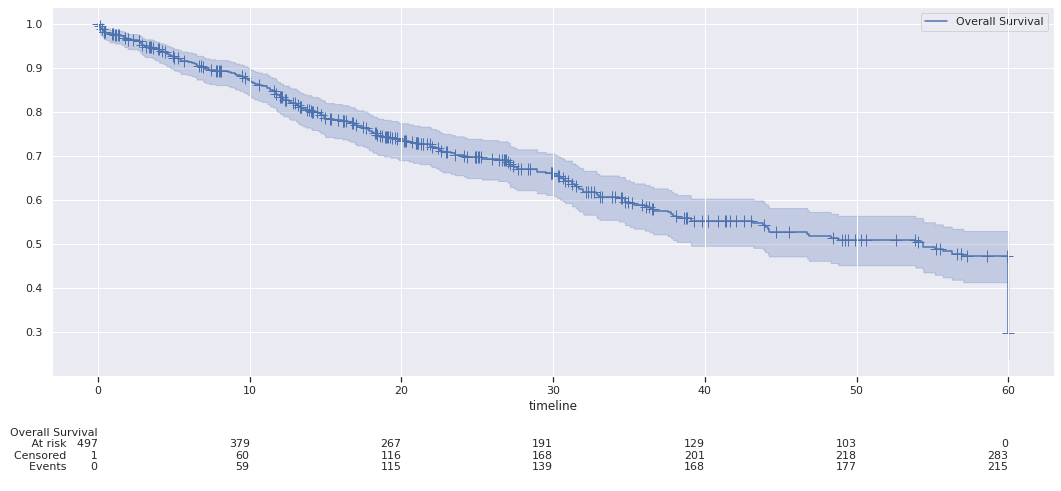

In [20]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=clinical_data["OS_MONTHS"],
        event_observed=clinical_data["OS_STATUS_B"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1, at_risk_counts=True)

Read the cBioPortal dataset's mRNA (Seq V2), Linear CNA and Methylation (hm450) datasets.

In [21]:
try:
    RNAseq = pd.read_csv(os.path.join(data_directory, study_name, "data_mrna_seq_v2_rsem.txt"), comment="#", sep="\t")
except FileNotFoundError:
    # Sometimes the downloaded file has a different name
    RNAseq = pd.read_csv(os.path.join(data_directory, study_name, "data_RNA_Seq_v2_expression_median.txt"), comment="#", sep="\t")

try:
    linearCNA = pd.read_csv(os.path.join(data_directory, study_name, "data_linear_cna.txt"), comment="#", sep="\t")
except FileNotFoundError:
    # Sometimes the downloaded file has a different name
    linearCNA = pd.read_csv(os.path.join(data_directory, study_name, "data_linear_CNA.txt"), comment="#", sep="\t")

# The methylation file had a consistent filename along the runs, so no try-catch is attempted.
methylation_hm450 = pd.read_csv(os.path.join(data_directory, study_name, "data_methylation_hm450.txt"), comment="#", sep="\t")

RNAseq = RNAseq.set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
linearCNA = linearCNA.set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
methylation_hm450 = methylation_hm450.set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")

RNAseq.shape[0], linearCNA.shape[0], methylation_hm450.shape[0]

(20531, 24776, 16714)

Remove any columns with a mode with more than 20% frequency

In [22]:
RNAseq_t = remove_columns_with_significant_modes(RNAseq.transpose()).dropna(axis="columns")
RNAseq_t = RNAseq_t.rename(lambda x: x+"_mrna", axis="columns")
linearCNA_t = remove_columns_with_significant_modes(linearCNA.transpose()).dropna(axis="columns")
linearCNA_t = linearCNA_t.rename(lambda x: x+"_lcna", axis="columns")
methylation_hm450_t = remove_columns_with_significant_modes(methylation_hm450.transpose()).dropna(axis="columns")
methylation_hm450_t = methylation_hm450_t.rename(lambda x: x+"_methy", axis="columns")
RNAseq_t.shape[-1], linearCNA_t.shape[-1], methylation_hm450_t.shape[-1]

(16827, 24754, 15854)

In [23]:
RNAseq_t = (RNAseq_t)
linearCNA_t = (linearCNA_t)
methylation_hm450_t = remove_columns_with_significant_modes(methylation_hm450_t)
RNAseq_t.shape[-1], linearCNA_t.shape[-1], methylation_hm450_t.shape[-1]

(16827, 24754, 15854)

Trying to find a column in our dataset that maps approximately or exactly to another on another study's dataframe to assure we are using the same data.

In [24]:
smpls = ['TCGA-18-3408-01', 'TCGA-18-3409-01', 'TCGA-18-3410-01']
vals = np.array([[0],[0],[7.8777]])
eps=1e-1

RNAseq_t.loc[:,((RNAseq_t.loc[smpls]-vals)**2<eps).all(axis="rows")]

Hugo_Symbol,EFCAB8_mrna,H3FM_mrna
TCGA-18-3406-01,4.7244,0.7874
TCGA-18-3407-01,0.9515,0.9515
TCGA-18-3408-01,0.0000,0.0000
TCGA-18-3409-01,0.0000,0.0000
TCGA-18-3410-01,7.8777,7.8777
...,...,...
TCGA-O2-A52S-01,2.4834,13.2450
TCGA-O2-A52V-01,5.8830,5.8830
TCGA-O2-A52W-01,6.4481,9.1349
TCGA-O2-A5IB-01,2.1299,15.9744


$EFCAB8_{mrna} \rightarrow X388795_{RNAseq}$

It seems as if we are using the same data.

Check the maximum RNAseq count value in the dataset.

In [25]:
RNAseq_t.max().max()

1737511.5871

Get histograms for random columns to have a look at the distribution variety in the counts for each of the datasets.

During an initial analysis (with the first 25 columns it was noticed that some columns seemed to have data identical to others, therefore a cleanup of these repeated columns is done as well and the plot is re-made.

First with RNAseq:

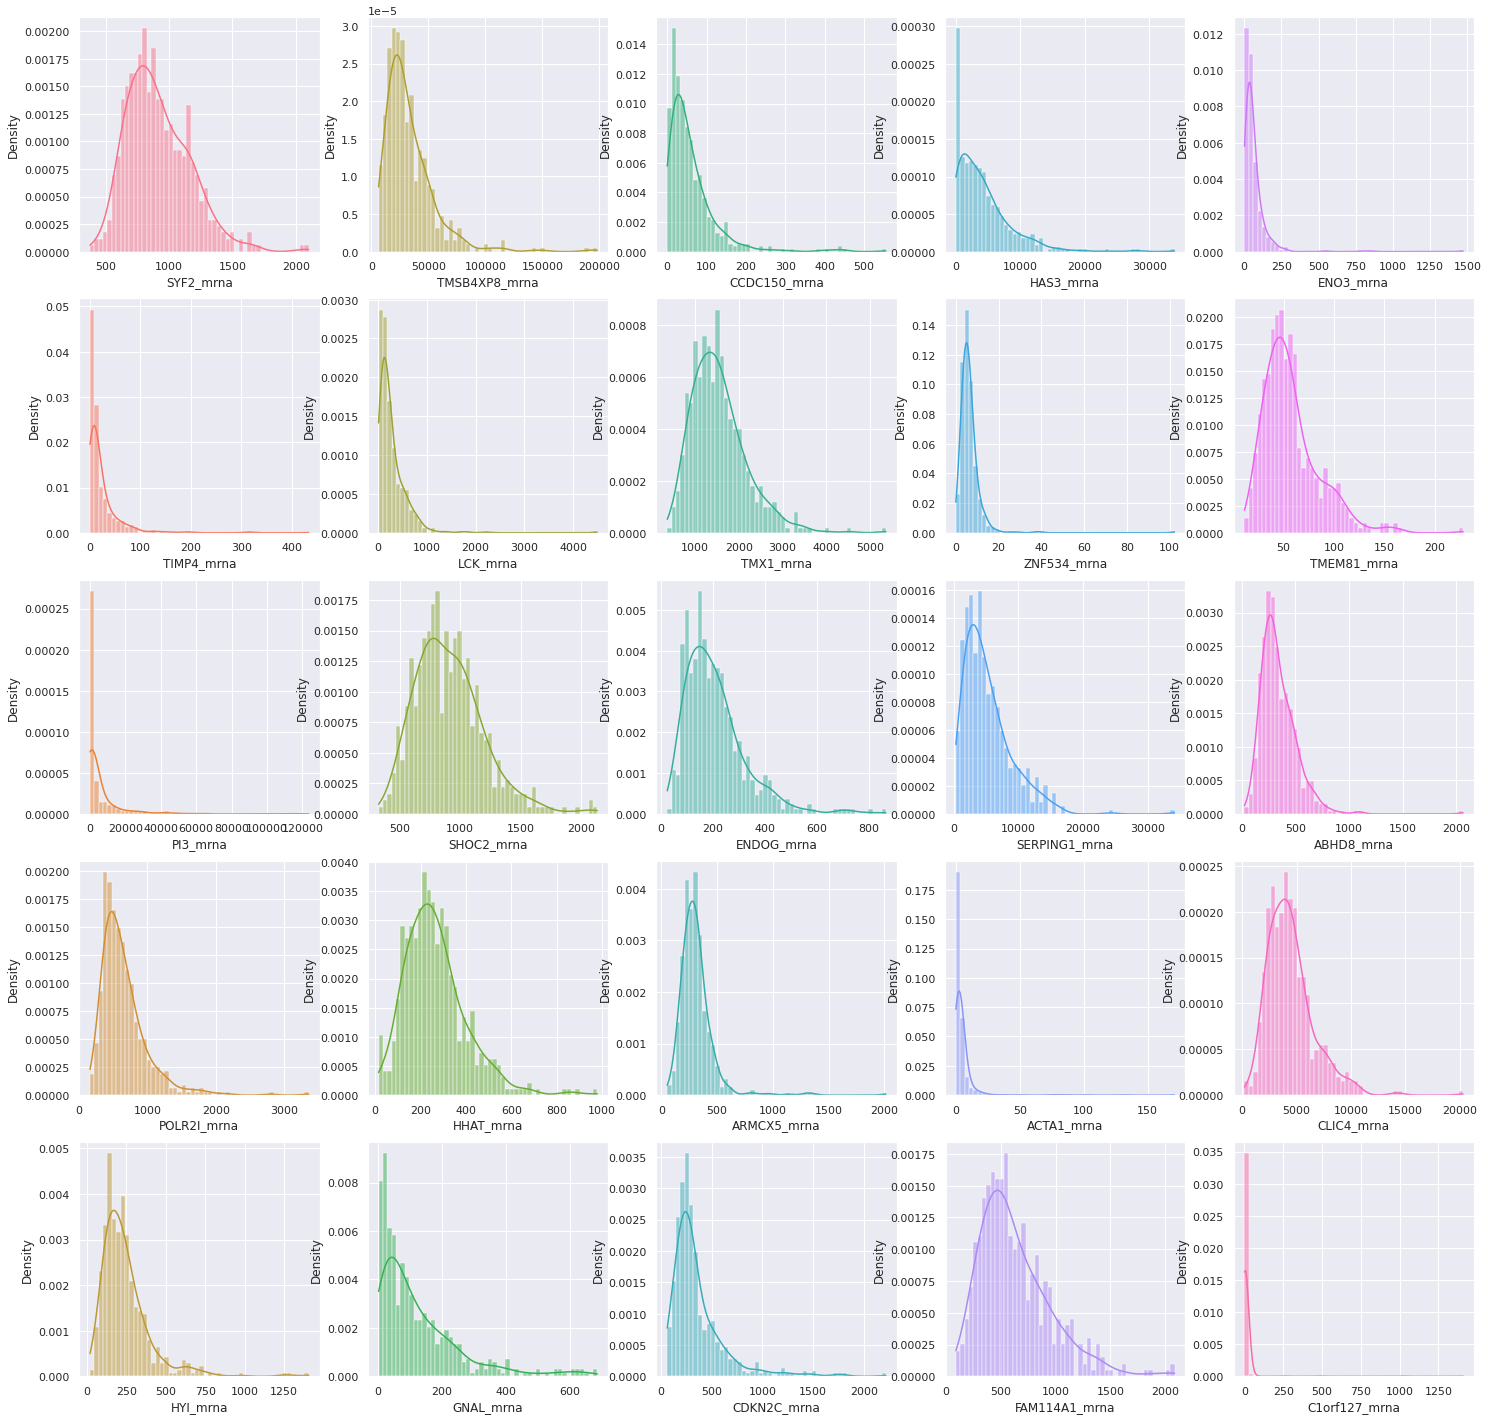

In [104]:
get_histograms_from_columns(RNAseq_t, RNAseq_t.columns[:25])
pass

In [ ]:
# This takes a long time. The result is cached below.
use_cached_duplicate_columns_for_rnaseq = False
if use_cached_duplicate_columns_for_rnaseq:
    duplicate_columns = []
else:
    duplicate_columns = get_columns_with_duplicates(RNAseq_t, disable_tqdm=False)
    print(duplicate_columns)

  0%|          | 0/16827 [00:00<?, ?it/s]

In [ ]:
len(duplicate_columns)

In [ ]:
RNAseq_t = RNAseq_t.drop(columns=duplicate_columns)

In [ ]:
get_histograms_from_columns(RNAseq_t, np.random.choice(RNAseq_t.columns, 25))
pass

Now for linear CNA (which has a significant amount of repeated columns):

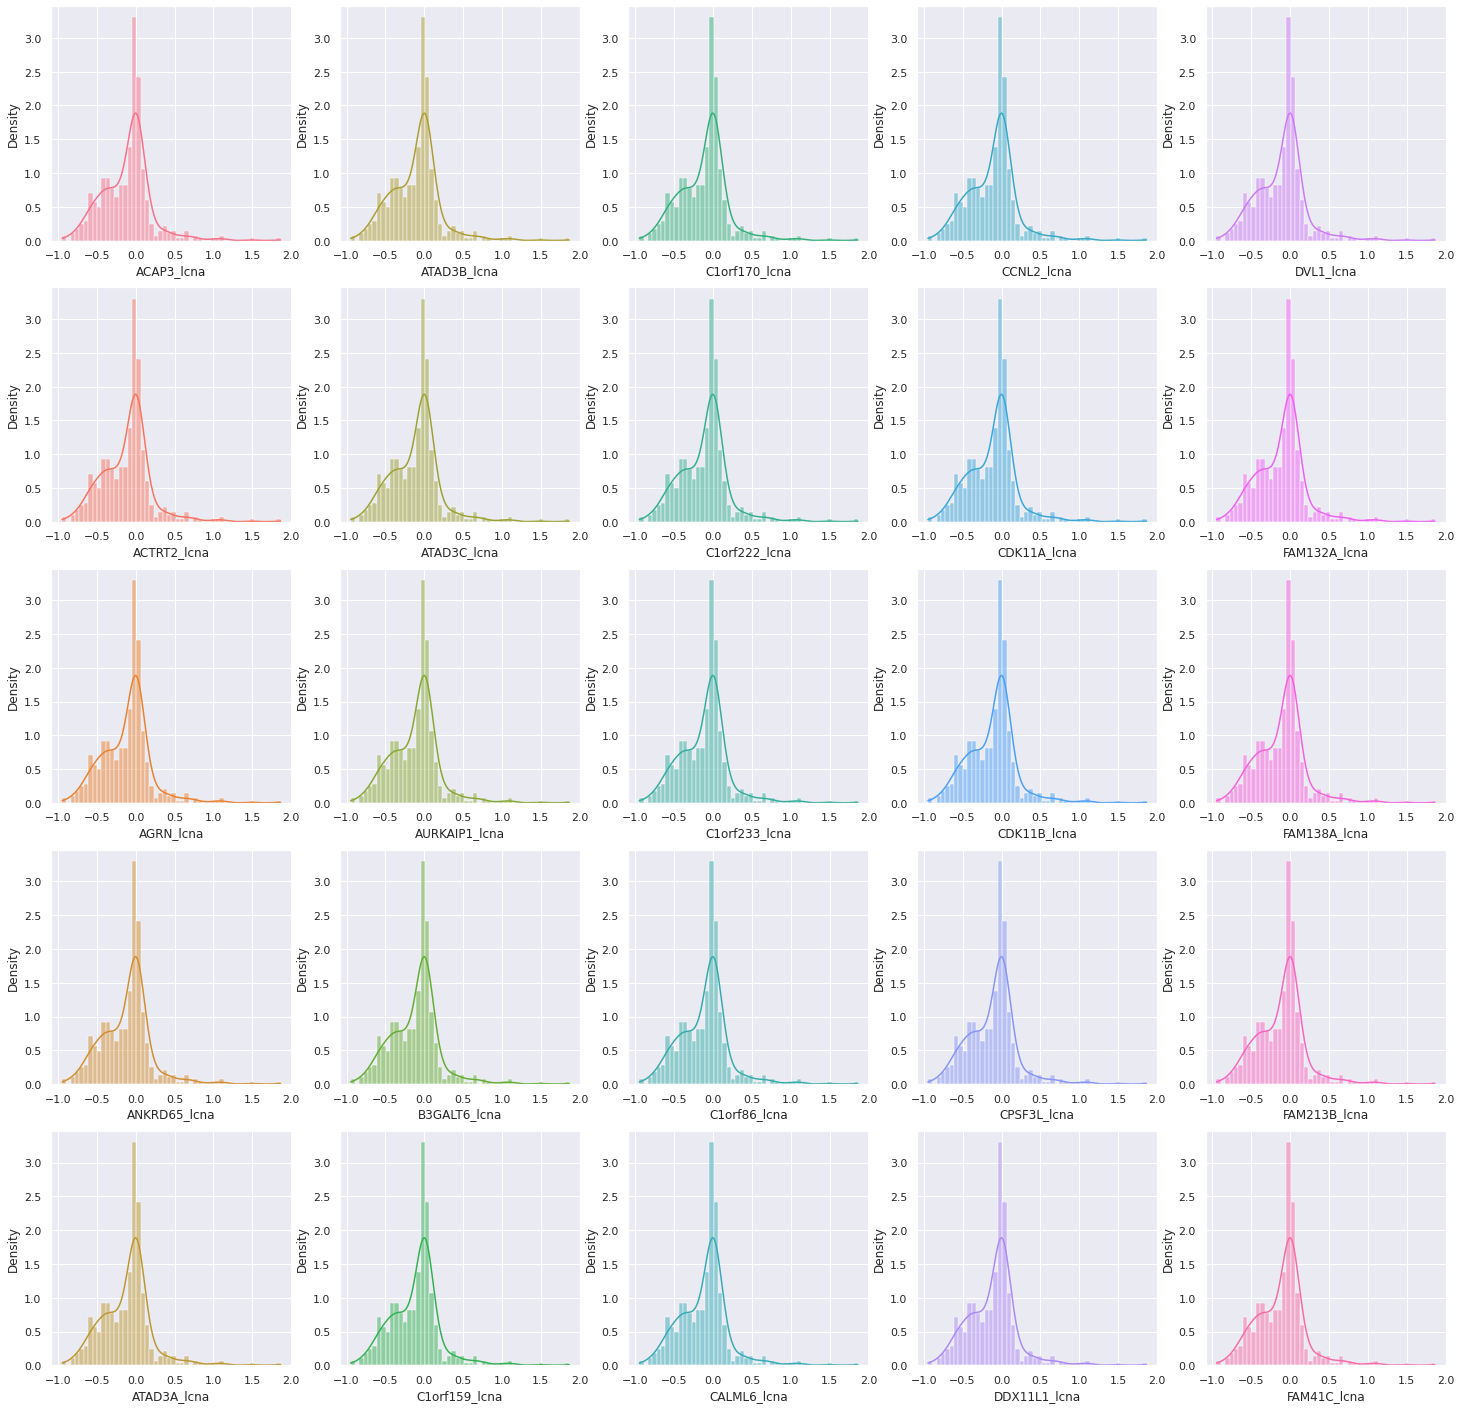

In [27]:
get_histograms_from_columns(linearCNA_t, linearCNA_t.columns[:25])
pass

In [67]:
# This takes a long time. The result is cached below.
use_cached_duplicate_columns_for_linear_cna = True
if use_cached_duplicate_columns_for_linear_cna:
    duplicate_columns = ['ACTRT2_lcna', 'AGRN_lcna', 'ANKRD65_lcna', 'ATAD3A_lcna', 'ATAD3B_lcna', 'ATAD3C_lcna', 'AURKAIP1_lcna', 'B3GALT6_lcna', 'C1orf159_lcna', 'C1orf170_lcna', 'C1orf222_lcna', 'C1orf233_lcna', 'C1orf86_lcna', 'CALML6_lcna', 'CCNL2_lcna', 'CDK11A_lcna', 'CDK11B_lcna', 'CPSF3L_lcna', 'DDX11L1_lcna', 'DVL1_lcna', 'FAM132A_lcna', 'FAM138A_lcna', 'FAM213B_lcna', 'FAM41C_lcna', 'FAM87B_lcna', 'GABRD_lcna', 'GLTPD1_lcna', 'GNB1_lcna', 'HES4_lcna', 'HES5_lcna', 'ISG15_lcna', 'KLHL17_lcna', 'LINC00115_lcna', 'LINC00982_lcna', 'MIB2_lcna', 'MIR200A_lcna', 'MIR200B_lcna', 'MIR429_lcna', 'MMEL1_lcna', 'MMP23B_lcna', 'MORN1_lcna', 'MRPL20_lcna', 'MXRA8_lcna', 'NADK_lcna', 'NOC2L_lcna', 'OR4F16_lcna', 'OR4F29_lcna', 'OR4F5_lcna', 'PANK4_lcna', 'PEX10_lcna', 'PLCH2_lcna', 'PLEKHN1_lcna', 'PRDM16_lcna', 'PRKCZ_lcna', 'PUSL1_lcna', 'RER1_lcna', 'RN7SL657P_lcna', 'RNF223_lcna', 'SAMD11_lcna', 'SCNN1D_lcna', 'SDF4_lcna', 'SKI_lcna', 'SLC35E2B_lcna', 'SLC35E2_lcna', 'SSU72_lcna', 'TAS1R3_lcna', 'TMEM240_lcna', 'TMEM52_lcna', 'TMEM88B_lcna', 'TNFRSF14_lcna', 'TNFRSF18_lcna', 'TNFRSF4_lcna', 'TTC34_lcna', 'TTLL10_lcna', 'UBE2J2_lcna', 'VWA1_lcna', 'SMIM1_lcna', 'LRRC47_lcna', 'RN7SL574P_lcna', 'RNF207_lcna', 'ICMT_lcna', 'GPR153_lcna', 'HES3_lcna', 'ACOT7_lcna', 'PLEKHG5_lcna', 'TNFRSF25_lcna', 'KLHL21_lcna', 'THAP3_lcna', 'PER3_lcna', 'UTS2_lcna', 'ERRFI1_lcna', 'RN7SL451P_lcna', 'SLC2A7_lcna', 'GPR157_lcna', 'H6PD_lcna', 'TMEM201_lcna', 'C1orf200_lcna', 'NMNAT1_lcna', 'RN7SKP269_lcna', 'MIR5697_lcna', 'RN7SL731P_lcna', 'APITD1_lcna', 'DFFA_lcna', 'TARDBP_lcna', 'MASP2_lcna', 'SRM_lcna', 'EXOSC10_lcna', 'MTOR_lcna', 'snoU13|ENSG00000271794.1_lcna', 'ANGPTL7_lcna', 'PTCHD2_lcna', 'FBXO44_lcna', 'FBXO6_lcna', 'MAD2L2_lcna', 'DRAXIN_lcna', 'MTHFR_lcna', 'CLCN6_lcna', 'KIAA2013_lcna', 'PLOD1_lcna', 'MIIP_lcna', 'RN7SL649P_lcna', 'MIR4632_lcna', 'SNORA70|ENSG00000252969.1_lcna', 'snoU13|ENSG00000238771.1_lcna', 'PRAMEF10_lcna', 'PRAMEF11_lcna', 'PRAMEF12_lcna', 'PRAMEF13_lcna', 'PRAMEF14_lcna', 'PRAMEF15_lcna', 'PRAMEF16_lcna', 'PRAMEF17_lcna', 'PRAMEF18_lcna', 'PRAMEF19_lcna', 'PRAMEF1_lcna', 'PRAMEF21_lcna', 'PRAMEF22_lcna', 'PRAMEF2_lcna', 'PRAMEF3_lcna', 'PRAMEF4_lcna', 'PRAMEF5_lcna', 'PRAMEF6_lcna', 'PRAMEF7_lcna', 'PRAMEF8_lcna', 'PRAMEF9_lcna', 'PRAMEF20_lcna', 'LRRC38_lcna', 'C1orf195_lcna', 'FHAD1_lcna', 'CELA2A_lcna', 'CELA2B_lcna', 'CASP9_lcna', 'SCARNA21|ENSG00000251866.1_lcna', 'AGMAT_lcna', 'RSC1A1_lcna', 'PLEKHM2_lcna', 'FBLIM1_lcna', 'SLC25A34_lcna', 'TMEM82_lcna', 'SPEN_lcna', 'snoU13|ENSG00000238818.1_lcna', 'ZBTB17_lcna', 'CLCNKA_lcna', 'CLCNKB_lcna', 'FAM131C_lcna', 'C1ORF134_lcna', 'RSG1_lcna', 'SZRD1_lcna', 'CROCCP2_lcna', 'CROCC_lcna', 'ESPNP_lcna', 'MFAP2_lcna', 'MIR3675_lcna', 'MST1L_lcna', 'NBPF1_lcna', 'U1|ENSG00000228549.2_lcna', 'U1|ENSG00000233421.3_lcna', 'PADI2_lcna', 'MIR3972_lcna', 'PADI6_lcna', 'snoU13|ENSG00000239020.1_lcna', 'ALDH4A1_lcna', 'MIR4695_lcna', 'MIR1290_lcna', 'MRTO4_lcna', 'AKR7A3_lcna', 'AKR7L_lcna', 'PQLC2_lcna', 'RN7SL85P_lcna', 'RN7SL277P_lcna', 'MINOS1_lcna', 'NBL1_lcna', 'HTR6_lcna', 'OTUD3_lcna', 'PLA2G2A_lcna', 'RN7SL304P_lcna', 'PLA2G2D_lcna', 'PLA2G2C_lcna', 'UBXN10_lcna', 'VWA5B1_lcna', 'MUL1_lcna', 'FAM43B_lcna', 'CDA_lcna', 'PINK1_lcna', 'DDOST_lcna', 'SH2D5_lcna', 'NBPF3_lcna', 'HSPG2_lcna', 'CELA3A_lcna', 'CELA3B_lcna', 'LINC00339_lcna', 'RN7SL186P_lcna', 'RN7SL386P_lcna', 'RN7SL421P_lcna', 'RN7SL768P_lcna', 'WNT4_lcna', 'EPHA8_lcna', 'C1QA_lcna', 'C1QC_lcna', 'C1QB_lcna', 'MIR4253_lcna', 'C1orf234_lcna', 'MIR4419A_lcna', 'ZNF436_lcna', 'C1orf213_lcna', 'TCEA3_lcna', 'E2F2_lcna', 'ID3_lcna', 'RN7SL532P_lcna', 'TCEB3_lcna', 'PITHD1_lcna', 'LYPLA2_lcna', 'FUCA1_lcna', 'CNR2_lcna', 'RN7SL24P_lcna', 'snoU13|ENSG00000238538.1_lcna', 'MIR378F_lcna', 'PNRC2_lcna', 'SRSF10_lcna', 'IFNLR1_lcna', 'STPG1_lcna', 'NIPAL3_lcna', 'RN7SL857P_lcna', 'NCMAP_lcna', 'snoU13|ENSG00000238986.1_lcna', 'RHCE_lcna', 'RHD_lcna', 'SYF2_lcna', 'TMEM50A_lcna', 'snoU13|ENSG00000238889.1_lcna', 'LDLRAP1_lcna', 'MTFR1L_lcna', 'AUNIP_lcna', 'PAQR7_lcna', 'STMN1_lcna', 'MIR3917_lcna', 'SCARNA17|ENSG00000252190.1_lcna', 'SCARNA18|ENSG00000252691.1_lcna', 'EXTL1_lcna', 'SLC30A2_lcna', 'TRIM63_lcna', 'FAM110D_lcna', 'ZNF593_lcna', 'CATSPER4_lcna', 'CEP85_lcna', 'SH3BGRL3_lcna', 'UBXN11_lcna', 'CD52_lcna', 'RN7SL490P_lcna', 'ZNF683_lcna', 'LIN28A_lcna', 'HMGN2_lcna', 'RPS6KA1_lcna', 'MIR1976_lcna', 'RN7SL501P_lcna', 'RN7SL165P_lcna', 'ZDHHC18_lcna', 'GPATCH3_lcna', 'NR0B2_lcna', 'TRNP1_lcna', 'FAM46B_lcna', 'SYTL1_lcna', 'MAP3K6_lcna', 'FCN3_lcna', 'CD164L2_lcna', 'GPR3_lcna', 'IFI6_lcna', 'FAM76A_lcna', 'SCARNA1_lcna', 'THEMIS2_lcna', 'SMPDL3B_lcna', 'EYA3_lcna', 'RN7SL559P_lcna', 'SESN2_lcna', 'RCC1_lcna', 'SNHG3_lcna', 'SNORA73B_lcna', 'snoU13|ENSG00000238821.1_lcna', 'TRNAU1AP_lcna', 'SNHG12_lcna', 'SNORD99_lcna', 'RAB42_lcna', 'RNU11_lcna', 'GMEB1_lcna', 'SCARNA24|ENSG00000252777.1_lcna', 'YTHDF2_lcna', 'TMEM200B_lcna', 'SRSF4_lcna', 'MATN1_lcna', 'MIR4420_lcna', 'SNORD85_lcna', 'PEF1_lcna', 'MIR4254_lcna', 'PTP4A2_lcna', 'MIR5585_lcna', 'CCDC28B_lcna', 'IQCC_lcna', 'DCDC2B_lcna', 'TMEM234_lcna', 'EIF3I_lcna', 'MTMR9LP_lcna', 'FAM167B_lcna', 'HDAC1_lcna', 'BSDC1_lcna', 'FAM229A_lcna', 'ZBTB8B_lcna', 'S100PBP_lcna', 'FNDC5_lcna', 'HPCA_lcna', 'TMEM54_lcna', 'RNF19B_lcna', 'FKSG48_lcna', 'A3GALT2_lcna', 'MIR3605_lcna', 'RN7SKP16_lcna', 'GJB5_lcna', 'GJB4_lcna', 'GJB3_lcna', 'GJA4_lcna', 'ZMYM6_lcna', 'RN7SL503P_lcna', 'SNORA62|ENSG00000201542.1_lcna', 'RNY5P1_lcna', 'KIAA0319L_lcna', 'NCDN_lcna', 'TFAP2E_lcna', 'RN7SL281P_lcna', 'CLSPN_lcna', 'ADPRHL2_lcna', 'COL8A2_lcna', 'MAP7D1_lcna', 'RN7SL131P_lcna', 'SH3D21_lcna', 'MRPS15_lcna', 'CSF3R_lcna', 'MIR5581_lcna', 'SNIP1_lcna', 'GNL2_lcna', 'RSPO1_lcna', 'C1orf109_lcna', 'CDCA8_lcna', 'EPHA10_lcna', 'MANEAL_lcna', 'YRDC_lcna', 'C1orf122_lcna', 'SF3A3_lcna', 'FHL3_lcna', 'UTP11L_lcna', 'POU3F1_lcna', 'MYCBP_lcna', 'GJA9_lcna', 'SNORA55_lcna', 'HEYL_lcna', 'HPCAL4_lcna', 'NT5C1A_lcna', 'PPT1_lcna', 'ZMPSTE24_lcna', 'COL9A2_lcna', 'EXO5_lcna', 'NFYC_lcna', 'MIR30C1_lcna', 'RN7SL326P_lcna', 'CITED4_lcna', 'SLFNL1_lcna', 'EDN2_lcna', 'GUCA2A_lcna', 'ZMYND12_lcna', 'PPCS_lcna', 'PPIH_lcna', 'LEPRE1_lcna', 'CCDC23_lcna', 'ERMAP_lcna', 'ZNF691_lcna', 'WDR65_lcna', 'RNA5SP46_lcna', 'TMEM125_lcna', 'C1orf210_lcna', 'MPL_lcna', 'ELOVL1_lcna', 'SZT2_lcna', 'IPO13_lcna', 'DPH2_lcna', 'ATP6V0B_lcna', 'B4GALT2_lcna', 'CCDC24_lcna', 'SLC6A9_lcna', 'RN7SL479P_lcna', 'ERI3_lcna', 'TMEM53_lcna', 'BTBD19_lcna', 'PLK3_lcna', 'RPS8_lcna', 'SNORD38A_lcna', 'SNORD38B_lcna', 'SNORD46|ENSG00000200913.1_lcna', 'SNORD55_lcna', 'TCTEX1D4_lcna', 'EIF2B3_lcna', 'RNA5SP47_lcna', 'HECTD3_lcna', 'UROD_lcna', 'TESK2_lcna', 'TOE1_lcna', 'snoU13|ENSG00000238945.1_lcna', 'MMACHC_lcna', 'PRDX1_lcna', 'AKR1A1_lcna', 'NASP_lcna', 'TMEM69_lcna', 'PIK3R3_lcna', 'TSPAN1_lcna', 'POMGNT1_lcna', 'LURAP1_lcna', 'LRRC41_lcna', 'UQCRH_lcna', 'DMBX1_lcna', 'MKNK1_lcna', 'MOB3C_lcna', 'EFCAB14_lcna', 'TEX38_lcna', 'CYP4A11_lcna', 'CYP4X1_lcna', 'TAL1_lcna', 'FOXD2_lcna', 'C1orf185_lcna', 'RNF11_lcna', 'RN7SL290P_lcna', 'KTI12_lcna', 'BTF3L4_lcna', 'RN7SL788P_lcna', 'ORC1_lcna', 'PRPF38A_lcna', 'ZCCHC11_lcna', 'snoU13|ENSG00000239063.1_lcna', 'GPX7_lcna', 'SELRC1_lcna', 'ZYG11B_lcna', 'ZYG11A_lcna', 'ECHDC2_lcna', 'MIR1273F_lcna', 'MIR1273G_lcna', 'SLC1A7_lcna', 'C1orf123_lcna', 'MAGOH_lcna', 'LRP8_lcna', 'DMRTB1_lcna', 'SNORA58|ENSG00000201003.1_lcna', 'HSPB11_lcna', 'LRRC42_lcna', 'TMEM59_lcna', 'CYB5RL_lcna', 'MRPL37_lcna', 'C1orf191_lcna', 'TTC4_lcna', 'C1orf177_lcna', 'PARS2_lcna', 'TTC22_lcna', 'BSND_lcna', 'USP24_lcna', 'RN7SL713P_lcna', 'TACSTD2_lcna', 'KANK4_lcna', 'DOCK7_lcna', 'ANGPTL3_lcna', 'RNA5SP49_lcna', 'RN7SL488P_lcna', 'DLEU2L_lcna', 'RN7SL130P_lcna', 'MIR4794_lcna', 'DNAJC6_lcna', 'LEPROT_lcna', 'LEPR_lcna', 'MIR3117_lcna', 'INSL5_lcna', 'C1orf141_lcna', 'SNORA31|ENSG00000252433.1_lcna', 'IL23R_lcna', 'RNU4ATAC4P_lcna', 'IL12RB2_lcna', 'GADD45A_lcna', 'GNG12_lcna', 'WLS_lcna', 'RPE65_lcna', 'DEPDC1_lcna', 'PIN1P1_lcna', 'RN7SL242P_lcna', 'SRSF11_lcna', 'MIR186_lcna', 'CRYZ_lcna', 'SNORD45C_lcna', 'SNORD45A_lcna', 'SNORD45B_lcna', 'ASB17_lcna', 'RNA5SP20_lcna', 'RN7SL370P_lcna', 'USP33_lcna', 'FUBP1_lcna', 'IFI44_lcna', 'PRKACB_lcna', 'SNORA2|ENSG00000199959.1_lcna', 'UOX_lcna', 'RPF1_lcna', 'GNG5_lcna', 'SPATA1_lcna', 'C1orf180_lcna', 'SSX2IP_lcna', 'MCOLN2_lcna', 'MCOLN3_lcna', 'MIR4423_lcna', 'SYDE2_lcna', 'BCL10_lcna', 'SNORD81|ENSG00000199934.1_lcna', 'CLCA3P_lcna', 'RBMXL1_lcna', 'GBP1_lcna', 'GBP2_lcna', 'GBP7_lcna', 'GBP1P1_lcna', 'ZNF326_lcna', 'BARHL2_lcna', 'RN7SL235P_lcna', 'BRDT_lcna', 'ACTBP12_lcna', 'GLMN_lcna', 'RPAP2_lcna', 'RN7SL824P_lcna', 'EVI5_lcna', 'SNORD21_lcna', 'SNORA66|ENSG00000251795.1_lcna', 'SNORA66|ENSG00000207523.1_lcna', 'FAM69A_lcna', 'SNORA51|ENSG00000207022.1_lcna', 'RN7SL692P_lcna', 'CCDC18_lcna', 'RNA5SP53_lcna', 'DNTTIP2_lcna', 'RN7SL440P_lcna', 'snoU13|ENSG00000238389.1_lcna', 'F3_lcna', 'RN7SKP270_lcna', 'SLC35A3_lcna', 'SASS6_lcna', 'LRRC39_lcna', 'RTCA_lcna', 'MIR553_lcna', 'GPR88_lcna', 'VCAM1_lcna', 'DPH5_lcna', 'S1PR1_lcna', 'AMY1B_lcna', 'AMY1C_lcna', 'AMY2A_lcna', 'AMY2B_lcna', 'RNPC3_lcna', 'NBPF4_lcna', 'NBPF6_lcna', 'HENMT1_lcna', 'PRPF38B_lcna', 'GPSM2_lcna', 'TAF13_lcna', 'C1orf194_lcna', 'SCARNA2_lcna', 'TMEM167B_lcna', 'CELSR2_lcna', 'PSRC1_lcna', 'MYBPHL_lcna', 'SORT1_lcna', 'ATXN7L2_lcna', 'CYB561D1_lcna', 'AMIGO1_lcna', 'GNAI3_lcna', 'RNU6V_lcna', 'GNAT2_lcna', 'AMPD2_lcna', 'GSTM2_lcna', 'GSTM4_lcna', 'GSTM3_lcna', 'EPS8L3_lcna', 'AHCYL1_lcna', 'STRIP1_lcna', 'ALX3_lcna', 'UBL4B_lcna', 'SLC6A17_lcna', 'SNORA25|ENSG00000200536.1_lcna', 'LAMTOR5_lcna', 'CYMP_lcna', 'KCNA10_lcna', 'KCNA3_lcna', 'CEPT1_lcna', 'DENND2D_lcna', 'PGCP1_lcna', 'OVGP1_lcna', 'ATP5F1_lcna', 'ADORA3_lcna', 'FAM212B_lcna', 'CTTNBP2NL_lcna', 'WNT2B_lcna', 'RHOC_lcna', 'FAM19A3_lcna', 'PTPN22_lcna', 'BCL2L15_lcna', 'AP4B1_lcna', 'DCLRE1B_lcna', 'HIPK1_lcna', 'RN7SL432P_lcna', 'NRAS_lcna', 'SIKE1_lcna', 'TSPAN2_lcna', 'SNORA42|ENSG00000207502.1_lcna', 'ATP1A1OS_lcna', 'MIR548AC_lcna', 'IGSF3_lcna', 'ANKRD20A12P_lcna', 'ANKRD34A_lcna', 'ANKRD35_lcna', 'BCL9_lcna', 'BOLA1_lcna', 'CD160_lcna', 'CHD1L_lcna', 'FAM72B_lcna', 'FAM72C_lcna', 'FAM72D_lcna', 'FCGR1A_lcna', 'FCGR1B_lcna', 'FCGR1C_lcna', 'FMO5_lcna', 'GJA5_lcna', 'GJA8_lcna', 'GNRHR2_lcna', 'GPR89A_lcna', 'GPR89B_lcna', 'GPR89C_lcna', 'HFE2_lcna', 'HIST2H2AA3_lcna', 'HIST2H2AA4_lcna', 'HIST2H2AB_lcna', 'HIST2H2AC_lcna', 'HIST2H2BA_lcna', 'HIST2H2BE_lcna', 'HIST2H2BF_lcna', 'HIST2H3A_lcna', 'HIST2H3C_lcna', 'HIST2H3D_lcna', 'HIST2H4A_lcna', 'HIST2H4B_lcna', 'HYDIN2_lcna', 'ITGA10_lcna', 'LINC00623_lcna', 'LINC00624_lcna', 'LIX1L_lcna', 'NBPF10_lcna', 'NBPF11_lcna', 'NBPF12_lcna', 'NBPF14_lcna', 'NBPF15_lcna', 'NBPF16_lcna', 'NBPF20_lcna', 'NBPF24_lcna', 'NBPF8_lcna', 'NBPF9_lcna', 'NOTCH2NL_lcna', 'NUDT17_lcna', 'PDE4DIP_lcna', 'PDZK1P1_lcna', 'PDZK1_lcna', 'PEX11B_lcna', 'PIAS3_lcna', 'POLR3C_lcna', 'POLR3GL_lcna', 'PPIAL4A_lcna', 'PPIAL4B_lcna', 'PPIAL4C_lcna', 'PPIAL4D_lcna', 'PPIAL4G_lcna', 'PRKAB2_lcna', 'RBM8A_lcna', 'RN7SKP88_lcna', 'RN7SL261P_lcna', 'RNA5SP57_lcna', 'RNA5SP58_lcna', 'RNA5SP59_lcna', 'RNF115_lcna', 'SEC22B_lcna', 'SRGAP2B_lcna', 'TXNIP_lcna', 'MTMR11_lcna', 'PLEKHO1_lcna', 'CA14_lcna', 'snoU13|ENSG00000238526.1_lcna', 'APH1A_lcna', 'C1orf54_lcna', 'C1orf51_lcna', 'MRPS21_lcna', 'PRPF3_lcna', 'LINC00568_lcna', 'ADAMTSL4_lcna', 'MIR4257_lcna', 'C1orf138_lcna', 'RN7SL473P_lcna', 'RN7SL600P_lcna', 'MCL1_lcna', 'SNORA40|ENSG00000253047.1_lcna', 'SETDB1_lcna', 'ANXA9_lcna', 'FAM63A_lcna', 'PRUNE_lcna', 'BNIPL_lcna', 'C1orf56_lcna', 'CDC42SE1_lcna', 'MLLT11_lcna', 'GABPB2_lcna', 'SEMA6C_lcna', 'LYSMD1_lcna', 'SCNM1_lcna', 'TNFAIP8L2_lcna', 'TMOD4_lcna', 'VPS72_lcna', 'PIP5K1A_lcna', 'PI4KB_lcna', 'RN7SL444P_lcna', 'RFX5_lcna', 'PSMB4_lcna', 'SELENBP1_lcna', 'CGN_lcna', 'SNORA44_lcna', 'MIR554_lcna', 'SNX27_lcna', 'RIIAD1_lcna', 'MRPL9_lcna', 'OAZ3_lcna', 'TDRKH_lcna', 'LINGO4_lcna', 'RORC_lcna', 'C2CD4D_lcna', 'THEM5_lcna', 'THEM4_lcna', 'TCHHL1_lcna', 'HRNR_lcna', 'FLG_lcna', 'CRCT1_lcna', 'LCE3B_lcna', 'LCE3C_lcna', 'LCE3D_lcna', 'LCE3E_lcna', 'LCE3A_lcna', 'LCE2D_lcna', 'LINC00302_lcna', 'LCE2C_lcna', 'LCE2A_lcna', 'C1orf68_lcna', 'LCE1F_lcna', 'LCE1C_lcna', 'LCE1D_lcna', 'LCE1E_lcna', 'LCE6A_lcna', 'SPRR4_lcna', 'SPRR1A_lcna', 'SPRR3_lcna', 'SNORA31|ENSG00000252920.1_lcna', 'SPRR1B_lcna', 'SPRR2D_lcna', 'SPRR2A_lcna', 'SPRR2E_lcna', 'SPRR2G_lcna', 'LOR_lcna', 'PGLYRP3_lcna', 'S100A8_lcna', 'S100A9_lcna', 'S100A7L2_lcna', 'S100A7_lcna', 'RN7SL44P_lcna', 'S100A4_lcna', 'S100A5_lcna', 'S100A6_lcna', 'S100A2_lcna', 'S100A14_lcna', 'S100A13_lcna', 'S100A1_lcna', 'CHTOP_lcna', 'ILF2_lcna', 'INTS3_lcna', 'RN7SL372P_lcna', 'snoU13|ENSG00000238511.1_lcna', 'SLC27A3_lcna', 'GATAD2B_lcna', 'CRTC2_lcna', 'SLC39A1_lcna', 'CREB3L4_lcna', 'JTB_lcna', 'RAB13_lcna', 'NUP210L_lcna', 'RPS27_lcna', 'U3|ENSG00000252669.1_lcna', 'TPM3_lcna', 'RN7SL431P_lcna', 'MIR190B_lcna', 'C1orf189_lcna', 'C1orf43_lcna', 'SNORA58|ENSG00000201129.1_lcna', 'HAX1_lcna', 'SNORD59|ENSG00000252682.1_lcna', 'SHE_lcna', 'TDRD10_lcna', 'UBE2Q1_lcna', 'CHRNB2_lcna', 'ADAR_lcna', 'PBXIP1_lcna', 'PYGO2_lcna', 'SHC1_lcna', 'CKS1B|ENSG00000173207.8_lcna', 'MIR4258_lcna', 'FLAD1_lcna', 'ZBTB7B_lcna', 'DCST2_lcna', 'DCST1_lcna', 'ADAM15_lcna', 'EFNA4_lcna', 'DPM3_lcna', 'SLC50A1_lcna', 'KRTCAP2_lcna', 'TRIM46_lcna', 'MIR92B_lcna', 'MUC1_lcna', 'THBS3_lcna', 'GBAP1_lcna', 'GBA_lcna', 'FAM189B_lcna', 'SCAMP3_lcna', 'HCN3_lcna', 'FDPS_lcna', 'RUSC1_lcna', 'DAP3_lcna', 'KIAA0907_lcna', 'SNORA42|ENSG00000207475.1_lcna', 'SCARNA4|ENSG00000252808.1_lcna', 'RXFP4_lcna', 'ARHGEF2_lcna', 'LAMTOR2_lcna', 'RAB25_lcna', 'LMNA_lcna', 'SNORA26|ENSG00000252236.1_lcna', 'SLC25A44_lcna', 'BGLAP_lcna', 'PAQR6_lcna', 'SMG5_lcna', 'C1orf85_lcna', 'TMEM79_lcna', 'VHLL_lcna', 'CCT3_lcna', 'TSACC_lcna', 'RHBG_lcna', 'C1orf61_lcna', 'snoU13|ENSG00000238843.1_lcna', 'TTC24_lcna', 'APOA1BP_lcna', 'GPATCH4_lcna', 'BCAN_lcna', 'CRABP2_lcna', 'ISG20L2_lcna', 'RRNAD1_lcna', 'MRPL24_lcna', 'PRCC_lcna', 'NTRK1_lcna', 'LRRC71_lcna', 'MIR765_lcna', 'RN7SL612P_lcna', 'ETV3L_lcna', 'CD5L_lcna', 'CD1C_lcna', 'OR10T2_lcna', 'OR10K2_lcna', 'OR10K1_lcna', 'OR10R2_lcna', 'OR6P1_lcna', 'OR6Y1_lcna', 'OR6K3_lcna', 'OR6K6_lcna', 'OR6N1_lcna', 'OR6N2_lcna', 'RNA5SP60_lcna', 'DARC_lcna', 'OR10J1_lcna', 'OR10J5_lcna', 'APCS_lcna', 'SLAMF8_lcna', 'C1orf204_lcna', 'VSIG8_lcna', 'CCDC19_lcna', 'IGSF9_lcna', 'SLAMF9_lcna', 'IGSF8_lcna', 'NCSTN_lcna', 'NHLH1_lcna', 'SLAMF1_lcna', 'ITLN2_lcna', 'USF1_lcna', 'ARHGAP30_lcna', 'PVRL4_lcna', 'KLHDC9_lcna', 'PFDN2_lcna', 'DEDD_lcna', 'ACA64|ENSG00000238934.1_lcna', 'UFC1_lcna', 'USP21_lcna', 'B4GALT3_lcna', 'PPOX_lcna', 'ADAMTS4_lcna', 'NDUFS2_lcna', 'APOA2_lcna', 'MIR5187_lcna', 'NR1I3_lcna', 'TOMM40L_lcna', 'PCP4L1_lcna', 'SDHC_lcna', 'C1orf192_lcna', 'FCGR2B_lcna', 'FCGR2C_lcna', 'FCGR3A_lcna', 'FCGR3B_lcna', 'HSPA6_lcna', 'RPL31P11_lcna', 'FCRLA_lcna', 'FCRLB_lcna', 'DUSP12_lcna', 'C1orf111_lcna', 'SH2D1B_lcna', 'UAP1_lcna', 'DDR2_lcna', 'RN7SL861P_lcna', 'HSD17B7_lcna', 'RNA5SP62_lcna', 'RNA5SP63_lcna', 'FAM78B_lcna', 'TADA1_lcna', 'MAEL_lcna', 'RNA5SP65_lcna', 'snoU13|ENSG00000238325.1_lcna', 'GPA33_lcna', 'MPZL1_lcna', 'ADCY10_lcna', 'MPC2_lcna', 'DCAF6_lcna', 'MIR1255B2_lcna', 'TIPRL_lcna', 'ANKRD36BP1_lcna', 'MIR557_lcna', 'LINC00626_lcna', 'ATP1B1_lcna', 'CCDC181_lcna', 'F5_lcna', 'SELL_lcna', 'SELE_lcna', 'RN7SL269P_lcna', 'MIR1295A_lcna', 'FMO6P_lcna', 'PRRC2C_lcna', 'RN7SL425P_lcna', 'VAMP4_lcna', 'METTL13_lcna', 'MIR214_lcna', 'MIR199A2_lcna', 'FASLG_lcna', 'CENPL_lcna', 'DARS2_lcna', 'GAS5_lcna', 'SNORD78|ENSG00000208317.1_lcna', 'RNA5SP67_lcna', 'TEX35_lcna', 'RNA5SP69_lcna', 'FAM20B_lcna', 'TOR3A_lcna', 'SNORA67|ENSG00000212338.1_lcna', 'RN7SL374P_lcna', 'IFRG15_lcna', 'TOR1AIP1_lcna', 'RN7SL230P_lcna', 'RN7SKP229_lcna', 'TEDDM1_lcna', 'LINC00272_lcna', 'RGS8_lcna', 'DHX9_lcna', 'RNA5SP71_lcna', 'NCF2_lcna', 'ARPC5_lcna', 'APOBEC4_lcna', 'TSEN15_lcna', 'C1orf21_lcna', 'EDEM3_lcna', 'RNF2_lcna', 'TRMT1L_lcna', 'IVNS1ABP_lcna', 'TPR_lcna', 'RGS13_lcna', 'snoU109|ENSG00000238754.1_lcna', 'CFH_lcna', 'CFHR1_lcna', 'CFHR2_lcna', 'CFHR3_lcna', 'CFHR4_lcna', 'CFHR5_lcna', 'F13B_lcna', 'ASPM_lcna', 'LHX9_lcna', 'MIR181A1_lcna', 'MIR181B1_lcna', 'ZNF281_lcna', 'CAMSAP2_lcna', 'GPR25_lcna', 'C1orf106_lcna', 'ASCL5_lcna', 'LAD1_lcna', 'TNNI1_lcna', 'PHLDA3_lcna', 'IPO9_lcna', 'LMOD1_lcna', 'SNORA70|ENSG00000206637.1_lcna', 'RNPEP_lcna', 'ARL8A_lcna', 'PTPN7_lcna', 'LGR6_lcna', 'snoU13|ENSG00000238571.1_lcna', 'snoU13|ENSG00000239046.1_lcna', 'UBE2T_lcna', 'SNORA70|ENSG00000253042.1_lcna', 'KDM5B_lcna', 'PCAT6_lcna', 'RABIF_lcna', 'KLHL12_lcna', 'ADIPOR1_lcna', 'CYB5R1_lcna', 'TMEM183A_lcna', 'MYOG_lcna', 'ADORA1_lcna', 'CHIT1_lcna', 'FMOD_lcna', 'PRELP_lcna', 'OPTC_lcna', 'SNORA77|ENSG00000221643.1_lcna', 'LAX1_lcna', 'ZBED6_lcna', 'LINC00303_lcna', 'ETNK2_lcna', 'REN_lcna', 'GOLT1A_lcna', 'SCARNA20|ENSG00000251861.1_lcna', 'SNORD112|ENSG00000252946.1_lcna', 'TMEM81_lcna', 'RBBP5_lcna', 'DSTYK_lcna', 'MFSD4_lcna', 'ELK4_lcna', 'SLC45A3_lcna', 'NUCKS1_lcna', 'SNORA72|ENSG00000201944.1_lcna', 'SLC41A1_lcna', 'PM20D1_lcna', 'SLC26A9_lcna', 'FAM72A_lcna', 'SNORD60|ENSG00000252692.1_lcna', 'IKBKE_lcna', 'RASSF5_lcna', 'DYRK3_lcna', 'SNORD112|ENSG00000252853.1_lcna', 'IL10_lcna', 'IL20_lcna', 'IL24_lcna', 'FAIM3_lcna', 'PIGR_lcna', 'FCAMR_lcna', 'snoU13|ENSG00000238401.1_lcna', 'YOD1_lcna', 'PFKFB2_lcna', 'C4BPB_lcna', 'C4BPA_lcna', 'CD46_lcna', 'MIR29B2_lcna', 'MIR29C_lcna', 'C1orf132_lcna', 'LAMB3_lcna', 'MIR4260_lcna', 'RD3_lcna', 'SLC30A1_lcna', 'RN7SL344P_lcna', 'DTL_lcna', 'MIR3122_lcna', 'RN7SKP98_lcna', 'SNORA16B_lcna', 'TMEM206_lcna', 'NENF_lcna', 'ATF3_lcna', 'RN7SL512P_lcna', 'FAM71A_lcna', 'BATF3_lcna', 'TATDN3_lcna', 'C1orf227_lcna', 'FLVCR1_lcna', 'ANGEL2_lcna', 'USH2A_lcna', 'SNORD116|ENSG00000202498.1_lcna', 'C1orf143_lcna', 'U3|ENSG00000212610.1_lcna', 'EPRS_lcna', 'snoU13|ENSG00000238798.1_lcna', 'IARS2_lcna', 'MIR215_lcna', 'snoU13|ENSG00000238576.1_lcna', 'C1orf115_lcna', 'TAF1A_lcna', 'AIDA_lcna', 'BROX_lcna', 'RN7SL276P_lcna', 'FAM177B_lcna', 'CAPN8_lcna', 'SNORA72|ENSG00000201898.1_lcna', 'MIR320B2_lcna', 'snoU13|ENSG00000238856.1_lcna', 'CNIH4_lcna', 'MIR4742_lcna', 'TMEM63A_lcna', 'LEFTY1_lcna', 'PYCR2_lcna', 'SDE2_lcna', 'MIXL1_lcna', 'snoU13|ENSG00000238545.1_lcna', 'snoU13|ENSG00000239094.1_lcna', 'RN7SKP165_lcna', 'SNAP47_lcna', 'MIR5008_lcna', 'WNT3A_lcna', 'ARF1_lcna', 'MIR3620_lcna', 'C1orf35_lcna', 'MRPL55_lcna', 'GJC2_lcna', 'GUK1_lcna', 'C1orf148_lcna', 'IBA57_lcna', 'C1orf145_lcna', 'BTNL10_lcna', 'HIST3H2A_lcna', 'HIST3H2BB_lcna', 'HIST3H3_lcna', 'MIR4666A_lcna', 'RNA5S10_lcna', 'RNA5S11_lcna', 'RNA5S12_lcna', 'RNA5S13_lcna', 'RNA5S14_lcna', 'RNA5S15_lcna', 'RNA5S16_lcna', 'RNA5S17_lcna', 'RNA5S1_lcna', 'RNA5S2_lcna', 'RNA5S3_lcna', 'RNA5S4_lcna', 'RNA5S5_lcna', 'RNA5S6_lcna', 'RNA5S7_lcna', 'RNA5S8_lcna', 'RNA5S9_lcna', 'RNA5SP18_lcna', 'RNA5SP19_lcna', 'RNF187_lcna', 'SNORA51|ENSG00000206878.1_lcna', 'TRIM11_lcna', 'TRIM17_lcna', 'RAB4A_lcna', 'SPHAR_lcna', 'CCSAP_lcna', 'RN7SKP276_lcna', 'ACTA1_lcna', 'ABCB10_lcna', 'RNA5SP78_lcna', 'URB2_lcna', 'CAPN9_lcna', 'RNA5SP79_lcna', 'C1orf198_lcna', 'snoU13|ENSG00000238985.1_lcna', 'ARV1_lcna', 'FAM89A_lcna', 'MIR1182_lcna', 'C1orf131_lcna', 'GNPAT_lcna', 'RNA5SP80_lcna', 'EXOC8_lcna', 'SPRTN_lcna', 'EGLN1_lcna', 'TSNAX_lcna', 'LINC00582_lcna', 'MIR4427_lcna', 'COA6_lcna', 'IRF2BP2_lcna', 'RN7SL668P_lcna', 'RBM34_lcna', 'SNORA14B_lcna', 'MIR4753_lcna', 'TBCE_lcna', 'OPN3_lcna', 'WDR64_lcna', 'MAP1LC3C_lcna', 'RN7SKP12_lcna', 'MIR4677_lcna', 'RN7SL148P_lcna', 'ADSS_lcna', 'C1orf101_lcna', 'HNRNPU_lcna', 'SCCPDH_lcna', 'SNORA25|ENSG00000252011.1_lcna', 'SNORD112|ENSG00000252495.1_lcna', 'TFB2M_lcna', 'C1orf229_lcna', 'RNA5SP82_lcna', 'OR2B11_lcna', 'OR2C3_lcna', 'MIR3124_lcna', 'OR11L1_lcna', 'OR13G1_lcna', 'OR14A16_lcna', 'OR14A2_lcna', 'OR14C36_lcna', 'OR14I1_lcna', 'OR14K1_lcna', 'OR1C1_lcna', 'OR2AJ1_lcna', 'OR2AK2_lcna', 'OR2G6_lcna', 'OR2L13_lcna', 'OR2L2_lcna', 'OR2L3_lcna', 'OR2L5_lcna', 'OR2L8_lcna', 'OR2M2_lcna', 'OR2M3_lcna', 'OR2M4_lcna', 'OR2M5_lcna', 'OR2M7_lcna', 'OR2T10_lcna', 'OR2T11_lcna', 'OR2T12_lcna', 'OR2T1_lcna', 'OR2T27_lcna', 'OR2T29_lcna', 'OR2T2_lcna', 'OR2T33_lcna', 'OR2T34_lcna', 'OR2T35_lcna', 'OR2T3_lcna', 'OR2T4_lcna', 'OR2T5_lcna', 'OR2T6_lcna', 'OR2T7_lcna', 'OR2T8_lcna', 'OR2W3_lcna', 'OR6F1_lcna', 'PGBD2_lcna', 'SH3BP5L_lcna', 'TRIM58_lcna', 'ZNF672_lcna', 'ZNF692_lcna', 'FAM110C_lcna', 'FAM150B_lcna', 'SH3YL1_lcna', 'SNTG2_lcna', 'TPO_lcna', 'RPS7_lcna', 'SNORA73|ENSG00000252531.1_lcna', 'COLEC11_lcna', 'CPSF3_lcna', 'IAH1_lcna', 'ADAM17_lcna', 'snoU13|ENSG00000238462.1_lcna', 'KLF11_lcna', 'CYS1_lcna', 'RRM2_lcna', 'C2orf48_lcna', 'SNORA2|ENSG00000206647.1_lcna', 'MIR4261_lcna', 'SNORA80B_lcna', 'PDIA6_lcna', 'KCNF1_lcna', 'PQLC3_lcna', 'ROCK2_lcna', 'E2F6_lcna', 'RNA5SP84_lcna', 'GREB1_lcna', 'MIR4429_lcna', 'RNA5SP85_lcna', 'RN7SL674P_lcna', 'LPIN1_lcna', 'MIR4262_lcna', 'MIR3681_lcna', 'MIR3125_lcna', 'MYCNOS_lcna', 'MYCN_lcna', 'RN7SL104P_lcna', 'GEN1_lcna', 'OSR1_lcna', 'TTC32_lcna', 'RHOB_lcna', 'GDF7_lcna', 'C2orf43_lcna', 'TDRD15_lcna', 'C2orf44_lcna', 'FKBP1B_lcna', 'SF3B6_lcna', 'FAM228B_lcna', 'TP53I3_lcna', 'PFN4_lcna', 'FAM228A_lcna', 'SCARNA21|ENSG00000251805.1_lcna', 'DNAJC27_lcna', 'SNORD14_lcna', 'ASXL2_lcna', 'RAB10_lcna', 'HADHA_lcna', 'GPR113_lcna', 'DRC1_lcna', 'C2orf70_lcna', 'CIB4_lcna', 'KCNK3_lcna', 'SLC35F6_lcna', 'MAPRE3_lcna', 'TMEM214_lcna', 'AGBL5_lcna', 'OST4_lcna', 'EMILIN1_lcna', 'KHK_lcna', 'CGREF1_lcna', 'ABHD1_lcna', 'PREB_lcna', 'C2orf53_lcna', 'SLC5A6_lcna', 'ATRAID_lcna', 'CAD_lcna', 'SLC30A3_lcna', 'DNAJC5G_lcna', 'TRIM54_lcna', 'MPV17_lcna', 'UCN_lcna', 'GTF3C2_lcna', 'EIF2B4_lcna', 'SNX17_lcna', 'ZNF513_lcna', 'PPM1G_lcna', 'NRBP1_lcna', 'IFT172_lcna', 'KRTCAP3_lcna', 'FNDC4_lcna', 'GCKR_lcna', 'C2orf16_lcna', 'ZNF512_lcna', 'CCDC121_lcna', 'SNORA36|ENSG00000206731.1_lcna', 'SUPT7L_lcna', 'SLC4A1AP_lcna', 'SNORD53_lcna', 'SNORD92_lcna', 'SPDYA_lcna', 'TRMT61B_lcna', 'WDR43_lcna', 'CLIP4_lcna', 'SNORA64|ENSG00000207187.1_lcna', 'LBH_lcna', 'RNA5SP90_lcna', 'EHD3_lcna', 'MEMO1_lcna', 'SPAST_lcna', 'NLRC4_lcna', 'LTBP1_lcna', 'MIR4765_lcna', 'MIR558_lcna', 'SNORD112|ENSG00000252502.1_lcna', 'TTC27_lcna', 'RNA5SP92_lcna', 'FAM98A_lcna', 'EIF2AK2_lcna', 'CEBPZ_lcna', 'NDUFAF7_lcna', 'CDC42EP3_lcna', 'LINC00211_lcna', 'RMDN2_lcna', 'CYP1B1_lcna', 'SRSF7_lcna', 'MORN2_lcna', 'RN7SL96P_lcna', 'SNORA67|ENSG00000252473.1_lcna', 'SNORD75|ENSG00000221300.1_lcna', 'RN7SKP66_lcna', 'DYNC2LI1_lcna', 'snoU13|ENSG00000239052.1_lcna', 'PREPL_lcna', 'RN7SL817P_lcna', 'TTC7A_lcna', 'CALM2_lcna', 'C2orf61_lcna', 'RN7SKP119_lcna', 'MIR559_lcna', 'FOXN2_lcna', 'PPP1R21_lcna', 'GPR75_lcna', 'C2orf73_lcna', 'TSPYL6_lcna', 'CLHC1_lcna', 'PRORSD1P_lcna', 'CCDC88A_lcna', 'SMEK2_lcna', 'SNORA12|ENSG00000212175.1_lcna', 'MIR217_lcna', 'MIR216B_lcna', 'PEX13_lcna', 'MIR5192_lcna', 'snoU13|ENSG00000238809.1_lcna', 'VPS54_lcna', 'snoU13|ENSG00000238696.1_lcna', 'Vault|ENSG00000251900.1_lcna', 'PNO1_lcna', 'ARHGAP25_lcna', 'FBXO48_lcna', 'PROKR1_lcna', 'MIR3126_lcna', 'RNA5SP96_lcna', 'AAK1_lcna', 'SNORA36C_lcna', 'SNRNP27_lcna', 'MXD1_lcna', 'ASPRV1_lcna', 'RN7SL470P_lcna', 'PCYOX1_lcna', 'SNRPG_lcna', 'CD207_lcna', 'ATP6V1B1_lcna', 'snoU13|ENSG00000239064.1_lcna', 'RN7SL160P_lcna', 'ANKRD53_lcna', 'TEX261_lcna', 'PAIP2B_lcna', 'EMX1_lcna', 'SMYD5_lcna', 'CCT7_lcna', 'PRADC1_lcna', 'FBXO41_lcna', 'EGR4_lcna', 'ALMS1P_lcna', 'NAT8_lcna', 'TPRKB_lcna', 'DUSP11_lcna', 'C2orf78_lcna', 'MGC10955_lcna', 'MOB1A_lcna', 'C2orf81_lcna', 'WDR54_lcna', 'RTKN_lcna', 'INO80B_lcna', 'WBP1_lcna', 'MOGS_lcna', 'MRPL53_lcna', 'TTC31_lcna', 'PCGF1_lcna', 'TLX2_lcna', 'DQX1_lcna', 'AUP1_lcna', 'HTRA2_lcna', 'LOXL3_lcna', 'DOK1_lcna', 'M1AP_lcna', 'EVA1A_lcna', 'snoU109|ENSG00000238410.1_lcna', 'U3|ENSG00000221638.1_lcna', 'snoU13|ENSG00000239018.1_lcna', 'REG1B_lcna', 'REG1P_lcna', 'REG3A_lcna', 'REG3G_lcna', 'TMSB10_lcna', 'KCMF1_lcna', 'RETSAT_lcna', 'ELMOD3_lcna', 'RN7SL113P_lcna', 'CAPG_lcna', 'SH2D6_lcna', 'RN7SL251P_lcna', 'MAT2A_lcna', 'GGCX_lcna', 'VAMP8_lcna', 'RN7SL126P_lcna', 'RNF181_lcna', 'C2orf68_lcna', 'TMEM150A_lcna', 'USP39_lcna', 'GNLY_lcna', 'RN7SKP83_lcna', 'IMMT_lcna', 'MIR4779_lcna', 'MRPL35_lcna', 'PTCD3_lcna', 'REEP1_lcna', 'SNORD94_lcna', 'CHMP3_lcna', 'RMND5A_lcna', 'CD8A_lcna', 'CD8B_lcna', 'PLGLB1_lcna', 'PLGLB2_lcna', 'RGPD1_lcna', 'KRCC1_lcna', 'SMYD1_lcna', 'MIR4780_lcna', 'FABP1_lcna', 'THNSL2_lcna', 'RNY4P15_lcna', 'TEX37_lcna', 'EIF2AK3_lcna', 'RPIA_lcna', 'IGKJ1_lcna', 'IGKJ2_lcna', 'IGKJ3_lcna', 'IGKJ4_lcna', 'IGKJ5_lcna', 'RNA5SP100_lcna', 'SLC9B1P2_lcna', 'ZNF514_lcna', 'FLJ14082_lcna', 'LINC00342_lcna', 'TRIM43_lcna', 'FAHD2CP_lcna', 'RN7SL210P_lcna', 'GPAT2_lcna', 'ADRA2B_lcna', 'ASTL_lcna', 'CIAO1_lcna', 'SNRNP200_lcna', 'ITPRIPL1_lcna', 'ARID5A_lcna', 'LMAN2L_lcna', 'CNNM4_lcna', 'MIR3127_lcna', 'CNNM3_lcna', 'ANKRD39_lcna', 'SEMA4C_lcna', 'FAM178B_lcna', 'snoU13|ENSG00000238760.1_lcna', 'ANKRD36B_lcna', 'ANKRD36_lcna', 'COX5B_lcna', 'FAHD2B_lcna', 'RN7SL313P_lcna', 'UNC50_lcna', 'MRPL30_lcna', 'MITD1_lcna', 'LYG2_lcna', 'PDCL3_lcna', 'snoU13|ENSG00000238328.1_lcna', 'RNF149_lcna', 'SNORD89_lcna', 'MIR5696_lcna', 'CREG2_lcna', 'IL1RL1_lcna', 'MIR4772_lcna', 'SLC9A4_lcna', 'TMEM182_lcna', 'GPR45_lcna', 'TGFBRAP1_lcna', 'UXS1_lcna', 'RGPD3_lcna', 'CD8BP_lcna', 'RGPD4_lcna', 'SULT1C2_lcna', 'CCDC138_lcna', 'SOWAHC_lcna', 'LIMS3|ENSG00000256977.6_lcna', 'LIMS3|ENSG00000257207.4_lcna', 'LINC00116_lcna', 'MALL_lcna', 'MIR4267_lcna', 'MIR4436B1_lcna', 'MIR4436B2_lcna', 'NPHP1_lcna', 'RGPD5_lcna', 'RGPD6_lcna', 'snoU13|ENSG00000238951.1_lcna', 'TTL_lcna', 'POLR1B_lcna', 'SLC20A1_lcna', 'NT5DC4_lcna', 'CKAP2L_lcna', 'IL1A_lcna', 'IL36A_lcna', 'IL36RN_lcna', 'IL1F10_lcna', 'FOXD4L1_lcna', 'RABL2A_lcna', 'RPL23AP7_lcna', 'WASH2P_lcna', 'SLC35F5_lcna', 'MIR4782_lcna', 'snoU13|ENSG00000239077.1_lcna', 'CCDC93_lcna', 'RN7SL468P_lcna', 'DBI_lcna', 'TMEM177_lcna', 'RALB_lcna', 'MKI67IP_lcna', 'TSN_lcna', 'MAP3K2_lcna', 'MIR4783_lcna', 'PROC_lcna', 'IWS1_lcna', 'GPR17_lcna', 'AMMECR1L_lcna', 'SAP130_lcna', 'RN7SL206P_lcna', 'CCDC74B_lcna', 'CYP4F43P_lcna', 'IMP4_lcna', 'MZT2B_lcna', 'POTEF_lcna', 'PTPN18_lcna', 'SMPD4_lcna', 'TUBA3E_lcna', 'CFC1_lcna', 'CYP4F30P_lcna', 'POTEI_lcna', 'POTEJ_lcna', 'MIR4784_lcna', 'MZT2A_lcna', 'POTEE_lcna', 'TUBA3D_lcna', 'C2orf27B_lcna', 'RN7SL701P_lcna', 'MIR663B_lcna', 'RN7SKP103_lcna', 'CCNT2_lcna', 'MCM6_lcna', 'NMI_lcna', 'TNFAIP6_lcna', 'RN7SL124P_lcna', 'ARL6IP6_lcna', 'snoU13|ENSG00000238481.1_lcna', 'RN7SKP281_lcna', 'ERMN_lcna', 'snoZ5_lcna', 'LY75_lcna', 'MIR4785_lcna', 'FAP_lcna', 'IFIH1_lcna', 'SCN7A_lcna', 'RN7SL813P_lcna', 'SPC25_lcna', 'LRP2_lcna', 'KLHL41_lcna', 'FASTKD1_lcna', 'CCDC173_lcna', 'KLHL23_lcna', 'PHOSPHO2_lcna', 'METTL5_lcna', 'U3|ENSG00000252981.1_lcna', 'ERICH2_lcna', 'GAD1_lcna', 'DCAF17_lcna', 'DLX1_lcna', 'DLX2_lcna', 'RN7SL65P_lcna', 'CIR1_lcna', 'SCRN3_lcna', 'GPR155_lcna', 'ATP5G3_lcna', 'HOXD13_lcna', 'HOXD12_lcna', 'HOXD10_lcna', 'HOXD11_lcna', 'HOXD8_lcna', 'HOXD3_lcna', 'HOXD4_lcna', 'MIR10B_lcna', 'HOXD1_lcna', 'OSBPL6_lcna', 'PRKRA_lcna', 'DFNB59_lcna', 'FKBP7_lcna', 'PLEKHA3_lcna', 'CWC22_lcna', 'SSFA2_lcna', 'RNA5SP113_lcna', 'SNORA77|ENSG00000221498.1_lcna', 'DUSP19_lcna', 'U8|ENSG00000212581.1_lcna', 'MIR561_lcna', 'MIR3129_lcna', 'OSGEPL1_lcna', 'TMEM194B_lcna', 'RN7SKP179_lcna', 'snoU13|ENSG00000239161.1_lcna', 'SCARNA16|ENSG00000252923.1_lcna', 'GTF3C3_lcna', 'C2orf66_lcna', 'SNORA4|ENSG00000202434.1_lcna', 'HSPD1_lcna', 'HSPE1_lcna', 'MOB4_lcna', 'TYW5_lcna', 'RNA5SP115_lcna', 'CLK1_lcna', 'NIF3L1_lcna', 'RN7SL694P_lcna', 'FAM126B_lcna', 'MPP4_lcna', 'SNORD70|ENSG00000212534.1_lcna', 'SNORD70|ENSG00000212309.1_lcna', 'SNORD11B_lcna', 'SNORD11|ENSG00000238317.1_lcna', 'RN7SL753P_lcna', 'CARF_lcna', 'ABI2_lcna', 'Vault|ENSG00000252485.1_lcna', 'EEF1B2_lcna', 'SNORA41|ENSG00000207406.1_lcna', 'SNORD51|ENSG00000207047.2_lcna', 'RN7SKP200_lcna', 'RN7SKP260_lcna', 'FASTKD2_lcna', 'METTL21A_lcna', 'FZD5_lcna', 'CRYGD_lcna', 'CRYGC_lcna', 'CRYGB_lcna', 'CRYGA_lcna', 'C2orf80_lcna', 'RPE_lcna', 'ACADL_lcna', 'ATIC_lcna', 'TMEM169_lcna', 'XRCC5_lcna', 'IGFBP2_lcna', 'IGFBP5_lcna', 'CXCR1_lcna', 'snoU13|ENSG00000238428.1_lcna', 'ARPC2_lcna', 'AAMP_lcna', 'GPBAR1_lcna', 'TMBIM1_lcna', 'snoU13|ENSG00000238736.1_lcna', 'CTDSP1_lcna', 'MIR26B_lcna', 'VIL1_lcna', 'PLCD4_lcna', 'U3|ENSG00000252805.1_lcna', 'ZNF142_lcna', 'BCS1L_lcna', 'RNF25_lcna', 'STK36_lcna', 'TTLL4_lcna', 'CYP27A1_lcna', 'PRKAG3_lcna', 'WNT10A_lcna', 'LINC00608_lcna', 'CRYBA2_lcna', 'FEV_lcna', 'CCDC108_lcna', 'MIR375_lcna', 'IHH_lcna', 'MIR3131_lcna', 'NHEJ1_lcna', 'SLC23A3_lcna', 'RN7SL764P_lcna', 'CNPPD1_lcna', 'FAM134A_lcna', 'ABCB6_lcna', 'ATG9A_lcna', 'ANKZF1_lcna', 'GLB1L_lcna', 'STK16_lcna', 'TUBA4A_lcna', 'TUBA4B_lcna', 'DNAJB2_lcna', 'PTPRN_lcna', 'DES_lcna', 'GMPPA_lcna', 'ASIC4_lcna', 'CHPF_lcna', 'TMEM198_lcna', 'MIR3132_lcna', 'OBSL1_lcna', 'INHA_lcna', 'STK11IP_lcna', 'SLC4A3_lcna', 'MOGAT1_lcna', 'MRPL44_lcna', 'RHBDD1_lcna', 'SNORA48|ENSG00000212391.1_lcna', 'TM4SF20_lcna', 'DAW1_lcna', 'SPHKAP_lcna', 'TRIP12_lcna', 'GPR55_lcna', 'SPATA3_lcna', 'C2orf72_lcna', 'PSMD1_lcna', 'HTR2B_lcna', 'B3GNT7_lcna', 'NCL_lcna', 'SNORA75|ENSG00000206885.1_lcna', 'SNORD20_lcna', 'SNORD82_lcna', 'C2orf57_lcna', 'LINC00471_lcna', 'NMUR1_lcna', 'RN7SL499P_lcna', 'MGC4771_lcna', 'PTMA_lcna', 'COPS7B_lcna', 'MIR1471_lcna', 'MIR562_lcna', 'ALPP_lcna', 'ECEL1P2_lcna', 'ALPI_lcna', 'ECEL1_lcna', 'CHRND_lcna', 'TIGD1_lcna', 'EIF4E2_lcna', 'MIR5001_lcna', 'snoU13|ENSG00000239170.1_lcna', 'KCNJ13_lcna', 'NEU2_lcna', 'DGKD_lcna', 'UGT1A10_lcna', 'UGT1A8_lcna', 'UGT1A9_lcna', 'UGT1A7_lcna', 'UGT1A4_lcna', 'UGT1A3_lcna', 'DNAJB3_lcna', 'UGT1A1_lcna', 'MSL3P1_lcna', 'PRLH_lcna', 'RAB17_lcna', 'RAMP1_lcna', 'SNORD39|ENSG00000263723.1_lcna', 'ESPNL_lcna', 'FAM132B_lcna', 'ILKAP_lcna', 'PER2_lcna', 'ASB1_lcna', 'MIR4441_lcna', 'TWIST2_lcna', 'PRR21_lcna', 'OR6B3_lcna', 'OTOS_lcna', 'MIR149_lcna', 'RNPEPL1_lcna', 'CAPN10_lcna', 'AQP12A_lcna', 'AQP12B_lcna', 'KIF1A_lcna', 'SEPT2_lcna', 'STK25_lcna', 'BOK_lcna', 'CXXC11_lcna', 'D2HGDH_lcna', 'DTYMK_lcna', 'GAL3ST2_lcna', 'ING5_lcna', 'NEU4_lcna', 'PDCD1_lcna', 'RNA5SP122_lcna', 'THAP4_lcna', 'CNTN6_lcna', 'RN7SKP144_lcna', 'RN7SL120P_lcna', 'SNORA43|ENSG00000253049.1_lcna', 'TRNT1_lcna', 'CRBN_lcna', 'RN7SL553P_lcna', 'OXTR_lcna', 'BRPF1_lcna', 'OGG1_lcna', 'CAMK1_lcna', 'TADA3_lcna', 'ARPC4_lcna', 'TTLL3_lcna', 'RPUSD3_lcna', 'IL17RE_lcna', 'CRELD1_lcna', 'PRRT3_lcna', 'CIDECP_lcna', 'FANCD2_lcna', 'FANCD2OS_lcna', 'BRK1_lcna', 'snoU13|ENSG00000238642.1_lcna', 'IRAK2_lcna', 'GHRLOS_lcna', 'GHRL_lcna', 'SEC13_lcna', 'TSEN2_lcna', 'C3orf83_lcna', 'MKRN2_lcna', 'snoU13|ENSG00000239140.1_lcna', 'SNORA7A_lcna', 'TPRXL_lcna', 'TMEM43_lcna', 'XPC_lcna', 'LSM3_lcna', 'MRPS25_lcna', 'ZFYVE20_lcna', 'SH3BP5_lcna', 'snoU13|ENSG00000238891.1_lcna', 'METTL6_lcna', 'EAF1_lcna', 'COLQ_lcna', 'MIR4270_lcna', 'RN7SL110P_lcna', 'MIR3134_lcna', 'RN7SL4P_lcna', 'DPH3_lcna', 'OXNAD1_lcna', 'RFTN1_lcna', 'SGOL1_lcna', 'NKIRAS1_lcna', 'RPL15_lcna', 'NR1D2_lcna', 'RNA5SP125_lcna', 'MIR4442_lcna', 'LINC00692_lcna', 'RN7SL859P_lcna', 'AZI2_lcna', 'snoU13|ENSG00000238646.1_lcna', 'CMTM6_lcna', 'DYNC1LI1_lcna', 'CCR4_lcna', 'TMPPE_lcna', 'RN7SL296P_lcna', 'CRTAP_lcna', 'CLASP2_lcna', 'DCLK3_lcna', 'HSPD1P6_lcna', 'RNU6ATAC4P_lcna', 'GOLGA4_lcna', 'RNA5SP129_lcna', 'C3orf35_lcna', 'VILL_lcna', 'PLCD1_lcna', 'DLEC1_lcna', 'XYLB_lcna', 'ACVR2B_lcna', 'TTC21A_lcna', 'CSRNP1_lcna', 'XIRP1_lcna', 'CCR8_lcna', 'SLC25A38_lcna', 'RPSA_lcna', 'SNORA62|ENSG00000202363.1_lcna', 'SNORA6_lcna', 'RN7SL411P_lcna', 'SNORA64|ENSG00000202517.1_lcna', 'ZNF619_lcna', 'ZNF621_lcna', 'RN7SKP58_lcna', 'CCK_lcna', 'SEC22C_lcna', 'SS18L2_lcna', 'ZBTB47_lcna', 'RN7SL567P_lcna', 'CCDC13_lcna', 'HHATL_lcna', 'HIGD1A_lcna', 'KRBOX1_lcna', 'CYP8B1_lcna', 'ZNF662_lcna', 'FAM198A_lcna', 'GTDC2_lcna', 'TCAIM_lcna', 'LINC00694_lcna', 'ZNF445_lcna', 'ZNF660_lcna', 'ZNF35_lcna', 'ZNF501_lcna', 'KIAA1143_lcna', 'TMEM42_lcna', 'TGM4_lcna', 'CLEC3B_lcna', 'CDCP1_lcna', 'U3|ENSG00000202268.1_lcna', 'RN7SL145P_lcna', 'SLC6A20_lcna', 'LZTFL1_lcna', 'CCR9_lcna', 'CXCR6_lcna', 'CCR1_lcna', 'CCR2_lcna', 'CCR5_lcna', 'RTP3_lcna', 'LRRC2_lcna', 'LUZPP1_lcna', 'ALS2CL_lcna', 'TMIE_lcna', 'PRSS46_lcna', 'PRSS42_lcna', 'PRSS44_lcna', 'PRSS45_lcna', 'PTH1R_lcna', 'CCDC12_lcna', 'snoU13|ENSG00000251938.1_lcna', 'KIF9_lcna', 'snoU13|ENSG00000239128.1_lcna', 'KLHL18_lcna', 'SCAP_lcna', 'snoU13|ENSG00000238350.1_lcna', 'CSPG5_lcna', 'MIR1226_lcna', 'CAMP_lcna', 'NME6_lcna', 'SPINK8_lcna', 'FBXW12_lcna', 'RN7SL321P_lcna', 'CCDC51_lcna', 'SHISA5_lcna', 'TREX1_lcna', 'PFKFB4_lcna', 'UCN2_lcna', 'MIR711_lcna', 'TMEM89_lcna', 'SLC26A6_lcna', 'CELSR3_lcna', 'PRKAR2A_lcna', 'SLC25A20_lcna', 'ARIH2_lcna', 'P4HTM_lcna', 'WDR6_lcna', 'DALRD3_lcna', 'MIR191_lcna', 'MIR425_lcna', 'NDUFAF3_lcna', 'IMPDH2_lcna', 'QRICH1_lcna', 'RN7SL182P_lcna', 'QARS1_lcna', 'USP19_lcna', 'LAMB2_lcna', 'CCDC71_lcna', 'KLHDC8B_lcna', 'C3orf84_lcna', 'C3orf62_lcna', 'MIR4271_lcna', 'USP4_lcna', 'AMT_lcna', 'NICN1_lcna', 'DAG1_lcna', 'RNA5SP130_lcna', 'BSN_lcna', 'APEH_lcna', 'MST1_lcna', 'RNF123_lcna', 'AMIGO3_lcna', 'GMPPB_lcna', 'FAM212A_lcna', 'MIR5193_lcna', 'UBA7_lcna', 'TRAIP_lcna', 'RN7SL217P_lcna', 'MST1R_lcna', 'MIR566_lcna', 'SLC38A3_lcna', 'GNAI2_lcna', 'SEMA3B_lcna', 'LSMEM2_lcna', 'IFRD2_lcna', 'HYAL3_lcna', 'HYAL1_lcna', 'NAT6_lcna', 'HYAL2_lcna', 'TUSC2_lcna', 'RASSF1_lcna', 'ZMYND10_lcna', 'NPRL2_lcna', 'CYB561D2_lcna', 'TMEM115_lcna', 'RNA5SP131_lcna', 'C3orf18_lcna', 'HEMK1_lcna', 'CISH_lcna', 'VPRBP_lcna', 'TEX264_lcna', 'GRM2_lcna', 'IQCF3_lcna', 'IQCF2_lcna', 'RN7SL504P_lcna', 'IQCF5_lcna', 'IQCF1_lcna', 'RRP9_lcna', 'PARP3_lcna', 'GPR62_lcna', 'PCBP4_lcna', 'ABHD14B_lcna', 'ABHD14A_lcna', 'ACY1_lcna', 'RPL29_lcna', 'LINC00696_lcna', 'POC1A_lcna', 'TLR9_lcna', 'TWF2_lcna', 'PPM1M_lcna', 'WDR82_lcna', 'GLYCTK_lcna', 'MIR135A1_lcna', 'DNAH1_lcna', 'BAP1_lcna', 'SEMA3G_lcna', 'STAB1_lcna', 'NT5DC2_lcna', 'SNORD19B|ENSG00000238862.1_lcna', 'SNORD19B|ENSG00000252787.1_lcna', 'SNORD19|ENSG00000212493.1_lcna', 'SNORD19|ENSG00000222345.1_lcna', 'SNORD69_lcna', 'GLT8D1_lcna', 'SPCS1_lcna', 'NEK4_lcna', 'ITIH1_lcna', 'MUSTN1_lcna', 'PRKCD_lcna', 'RN7SL821P_lcna', 'SNORD38|ENSG00000207109.1_lcna', 'SNORA26|ENSG00000212608.1_lcna', 'IL17RB_lcna', 'ACTR8_lcna', 'FAM208A_lcna', 'IL17RD_lcna', 'APPL1_lcna', 'ASB14_lcna', 'DNAH12_lcna', 'snoU13|ENSG00000238905.1_lcna', 'PDE12_lcna', 'ARF4_lcna', 'ABHD6_lcna', 'RPP14_lcna', 'PDHB_lcna', 'KCTD6_lcna', 'ACOX2_lcna', 'U3|ENSG00000212211.1_lcna', 'THOC7_lcna', 'ATXN7_lcna', 'U3|ENSG00000200222.1_lcna', 'TMF1_lcna', 'MIR3136_lcna', 'UBA3_lcna', 'ARL6IP5_lcna', 'LMOD3_lcna', 'RN7SL418P_lcna', 'PROK2_lcna', 'RN7SL271P_lcna', 'LINC00870_lcna', 'SHQ1_lcna', 'GXYLT2_lcna', 'EBLN2_lcna', 'FRG2C_lcna', 'LINC00960_lcna', 'MIR1324_lcna', 'MIR4273_lcna', 'RN7SL92P_lcna', 'ZNF717_lcna', 'RN7SKP61_lcna', 'MIR4795_lcna', 'C3orf38_lcna', 'OR5AC2_lcna', 'OR5H14_lcna', 'OR5H15_lcna', 'OR5H2_lcna', 'OR5K4_lcna', 'OR5K1_lcna', 'OR5K2_lcna', 'CPOX_lcna', 'GPR15_lcna', 'SNORD61|ENSG00000238377.1_lcna', 'TBC1D23_lcna', 'NIT2_lcna', 'SNORA31|ENSG00000252989.1_lcna', 'TFG_lcna', 'IMPG2_lcna', 'RPL24_lcna', 'NFKBIZ_lcna', 'LINC00636_lcna', 'IFT57_lcna', 'DZIP3_lcna', 'GUCA1C_lcna', 'LINC00488_lcna', 'MORC1_lcna', 'U3|ENSG00000221633.1_lcna', 'TAGLN3_lcna', 'GCSAM_lcna', 'BTLA_lcna', 'GTPBP8_lcna', 'C3orf17_lcna', 'SIDT1_lcna', 'KIAA2018_lcna', 'ATP6V1A_lcna', 'GRAMD1C_lcna', 'QTRTD1_lcna', 'MIR568_lcna', 'UPK1B_lcna', 'ADPRH_lcna', 'PLA1A_lcna', 'COX17_lcna', 'RN7SL762P_lcna', 'RN7SL397P_lcna', 'HGD_lcna', 'FBXO40_lcna', 'GOLGB1_lcna', 'HCLS1_lcna', 'RN7SL172P_lcna', 'snoU13|ENSG00000238670.1_lcna', 'EAF2_lcna', 'SLC15A2_lcna', 'SNORD112|ENSG00000252170.1_lcna', 'WDR5B_lcna', 'KPNA1_lcna', 'PARP9_lcna', 'DTX3L_lcna', 'PARP15_lcna', 'snoU13|ENSG00000238480.1_lcna', 'DIRC2_lcna', 'SNORA5_lcna', 'CCDC14_lcna', 'ROPN1_lcna', 'MIR544B_lcna', 'MUC13_lcna', 'HEG1_lcna', 'RNA5SP137_lcna', 'SNX4_lcna', 'snoU13|ENSG00000238992.1_lcna', 'UROC1_lcna', 'CHST13_lcna', 'TXNRD3NB_lcna', 'TXNRD3_lcna', 'NUP210P1_lcna', 'ABTB1_lcna', 'SEC61A1_lcna', 'GATA2_lcna', 'RPN1_lcna', 'RN7SL698P_lcna', 'KIAA1257_lcna', 'EFCC1_lcna', 'GP9_lcna', 'snoU13|ENSG00000252435.1_lcna', 'snoU13|ENSG00000238874.1_lcna', 'RAB43_lcna', 'ISY1_lcna', 'CNBP_lcna', 'C3orf37_lcna', 'H1FX_lcna', 'SNORA7B_lcna', 'EFCAB12_lcna', 'H1FOO_lcna', 'RN7SL752P_lcna', 'FAM86HP_lcna', 'SNORA58|ENSG00000249020.1_lcna', 'ACAD11_lcna', 'SNORA33|ENSG00000201827.1_lcna', 'CDV3_lcna', 'TOPBP1_lcna', 'TFP1_lcna', 'RNA5SP140_lcna', 'TF_lcna', 'SLCO2A1_lcna', 'AMOTL2_lcna', 'RNA5SP141_lcna', 'DZIP1L_lcna', 'MRAS_lcna', 'ESYT3_lcna', 'PIK3CB_lcna', 'FOXL2_lcna', 'PRR23A_lcna', 'PRR23B_lcna', 'BPESC1_lcna', 'COPB2_lcna', 'NMNAT3_lcna', 'RN7SKP124_lcna', 'RNA5SP143_lcna', 'PCOLCE2_lcna', 'U2SURP_lcna', 'PBX2P1_lcna', 'PLSCR2_lcna', 'CPA3_lcna', 'snoU13|ENSG00000243321.2_lcna', 'EIF2A_lcna', 'SELT_lcna', 'FAM194A_lcna', 'SIAH2_lcna', 'FAM188B2_lcna', 'CLRN1_lcna', 'GPR171_lcna', 'AADAC_lcna', 'SUCNR1_lcna', 'snoU13|ENSG00000271922.1_lcna', 'SLC33A1_lcna', 'LXN_lcna', 'MFSD1_lcna', 'MIR15B_lcna', 'SCARNA7_lcna', 'TERC_lcna', 'MYNN_lcna', 'LRRC34_lcna', 'SKIL_lcna', 'RPL22L1_lcna', 'EIF5A2_lcna', 'SLC2A2_lcna', 'PP13439_lcna', 'TMEM212_lcna', 'snoU13|ENSG00000238359.1_lcna', 'snoU13|ENSG00000271842.1_lcna', 'GNB4_lcna', 'MRPL47_lcna', 'NDUFB5_lcna', 'snoU13|ENSG00000239096.1_lcna', 'RNA5SP150_lcna', 'RNA5SP151_lcna', 'AP2M1_lcna', 'CYP2AB1P_lcna', 'DVL3_lcna', 'HTR3C_lcna', 'HTR3D_lcna', 'HTR3E_lcna', 'KLHL24_lcna', 'KLHL6_lcna', 'LINC00888_lcna', 'MAP6D1_lcna', 'MIR4448_lcna', 'PARL_lcna', 'SNORA4|ENSG00000251730.1_lcna', 'SNORA63|ENSG00000199363.1_lcna', 'SNORA63|ENSG00000201229.1_lcna', 'SNORA81|ENSG00000253092.1_lcna', 'YEATS2_lcna', 'ALG3_lcna', 'ECE2_lcna', 'MIR1224_lcna', 'CAMK2N2_lcna', 'EIF4G1_lcna', 'SNORD66|ENSG00000212158.1_lcna', 'FAM131A_lcna', 'CLCN2_lcna', 'THPO_lcna', 'CHRD_lcna', 'IGF2BP2_lcna', 'TBCCD1_lcna', 'FETUB_lcna', 'SNORD2|ENSG00000238942.1_lcna', 'RFC4_lcna', 'SNORA4|ENSG00000263776.1_lcna', 'SNORA63|ENSG00000200320.1_lcna', 'SNORA63|ENSG00000200418.1_lcna', 'SNORA81|ENSG00000221420.2_lcna', 'RTP2_lcna', 'RN7SL215P_lcna', 'CPN2_lcna', 'LRRC15_lcna', 'GP5_lcna', 'TMEM44_lcna', 'LSG1_lcna', 'RN7SL36P_lcna', 'APOD_lcna', 'LINC00969_lcna', 'MIR570_lcna', 'MUC20_lcna', 'MUC4_lcna', 'PPP1R2_lcna', 'RN7SL773P_lcna', 'RNU6ATAC24P_lcna', 'SDHAP1_lcna', 'TNK2_lcna', 'PCYT1A_lcna', 'TM4SF19_lcna', 'RN7SL738P_lcna', 'SMCO1_lcna', 'FBXO45_lcna', 'PIGX_lcna', 'CEP19_lcna', 'DLG1_lcna', 'MFI2_lcna', 'NCBP2_lcna', 'PAK2_lcna', 'PIGZ_lcna', 'SENP5_lcna', 'U4|ENSG00000272359.1_lcna', 'snoU13|ENSG00000238491.1_lcna', 'MIR922_lcna', 'FAM157A_lcna', 'IQCG_lcna', 'LMLN_lcna', 'RPL35A_lcna', 'ATP5I_lcna', 'CPLX1_lcna', 'DGKQ_lcna', 'FGFRL1_lcna', 'GAK_lcna', 'IDUA_lcna', 'MFSD7_lcna', 'MIR571_lcna', 'MYL5_lcna', 'PCGF3_lcna', 'PDE6B_lcna', 'PIGG_lcna', 'RN7SL358P_lcna', 'RNF212_lcna', 'SLC26A1_lcna', 'TMEM175_lcna', 'ZNF141_lcna', 'ZNF595_lcna', 'ZNF718_lcna', 'ZNF721_lcna', 'ZNF732_lcna', 'ZNF876P_lcna', 'SNORA48|ENSG00000212458.1_lcna', 'UVSSA_lcna', 'TMEM129_lcna', 'TACC3_lcna', 'NELFA_lcna', 'NAT8L_lcna', 'MXD4_lcna', 'MIR4800_lcna', 'RN7SL589P_lcna', 'MFSD10_lcna', 'NOP14_lcna', 'GRK4_lcna', 'DOK7_lcna', 'LRPAP1_lcna', 'TMEM128_lcna', 'LYAR_lcna', 'ZBTB49_lcna', 'NSG1_lcna', 'CRMP1_lcna', 'MRFAP1L1_lcna', 'BLOC1S4_lcna', 'RN7SKP292_lcna', 'CCDC96_lcna', 'TADA2B_lcna', 'PSAPL1_lcna', 'RNA5SP152_lcna', 'CPZ_lcna', 'FAM90A26_lcna', 'HMX1_lcna', 'MIR548I2_lcna', 'RNA5SP153_lcna', 'USP17L10_lcna', 'USP17L11_lcna', 'USP17L12_lcna', 'USP17L13_lcna', 'USP17L15_lcna', 'USP17L17_lcna', 'USP17L18_lcna', 'USP17L19_lcna', 'USP17L20_lcna', 'USP17L21_lcna', 'USP17L22_lcna', 'USP17L23_lcna', 'USP17L24_lcna', 'USP17L25_lcna', 'USP17L26_lcna', 'USP17L27_lcna', 'USP17L28_lcna', 'USP17L29_lcna', 'USP17L30_lcna', 'USP17L5_lcna', 'RNA5SP154_lcna', 'MIR3138_lcna', 'RNA5SP155_lcna', 'CLNK_lcna', 'RNA5SP156_lcna', 'RAB28_lcna', 'FBXL5_lcna', 'BST1_lcna', 'CD38_lcna', 'FGFBP2_lcna', 'snoU13|ENSG00000238536.1_lcna', 'RN7SL315P_lcna', 'MED28_lcna', 'RN7SL16P_lcna', 'PI4K2B_lcna', 'SNORD74|ENSG00000200999.1_lcna', 'MIR4801_lcna', 'TLR10_lcna', 'TLR1_lcna', 'TLR6_lcna', 'FAM114A1_lcna', 'MIR574_lcna', 'MIR5591_lcna', 'LIAS_lcna', 'SNORA51|ENSG00000201863.1_lcna', 'TMEM33_lcna', 'SLC30A9_lcna', 'GNPDA2_lcna', 'ATP10D_lcna', 'FRYL_lcna', 'OCIAD1_lcna', 'OCIAD2_lcna', 'SLAIN2_lcna', 'SLC10A4_lcna', 'TEC_lcna', 'ZAR1_lcna', 'SPATA18_lcna', 'SNORA26|ENSG00000212588.1_lcna', 'snoU13|ENSG00000238753.1_lcna', 'NMU_lcna', 'AASDH_lcna', 'SRP72_lcna', 'SPINK2_lcna', 'snoU13|ENSG00000238541.1_lcna', 'UBA6_lcna', 'SNORA62|ENSG00000202374.1_lcna', 'TMPRSS11GP_lcna', 'TMPRSS11BNL_lcna', 'TMPRSS11B_lcna', 'UGT2A3_lcna', 'UGT2B10_lcna', 'UGT2B11_lcna', 'UGT2B15_lcna', 'UGT2B17_lcna', 'UGT2B28_lcna', 'UGT2B7_lcna', 'UGT2A2_lcna', 'SULT1E1_lcna', 'CSN2_lcna', 'HTN3_lcna', 'CSN1S2AP_lcna', 'C4orf40_lcna', 'ODAM_lcna', 'FDCSP_lcna', 'CSN3_lcna', 'SMR3A_lcna', 'SMR3B_lcna', 'AMTN_lcna', 'ENAM_lcna', 'IGJ_lcna', 'RUFY3_lcna', 'snoU13|ENSG00000238318.1_lcna', 'GRSF1_lcna', 'DCK_lcna', 'RNA5SP163_lcna', 'SNORA3|ENSG00000221639.1_lcna', 'PF4V1_lcna', 'CXCL1_lcna', 'PPBP_lcna', 'CXCL5_lcna', 'RN7SL218P_lcna', 'CXCL3_lcna', 'PPBPP2_lcna', 'EREG_lcna', 'THAP6_lcna', 'CDKL2_lcna', 'USO1_lcna', 'SDAD1_lcna', 'CXCL10_lcna', 'CXCL11_lcna', 'FAM47E_lcna', 'MIR548AH_lcna', 'MIR5096_lcna', 'SNORA75|ENSG00000212620.1_lcna', 'FGF5_lcna', 'SNORD42|ENSG00000202440.1_lcna', 'SEC31A_lcna', 'THAP9_lcna', 'LIN54_lcna', 'HELQ_lcna', 'FAM175A_lcna', 'C4orf36_lcna', 'HSD17B13_lcna', 'NUDT9_lcna', 'SPARCL1_lcna', 'DMP1_lcna', 'PPM1K_lcna', 'HERC5_lcna', 'HERC3_lcna', 'PIGY_lcna', 'PYURF_lcna', 'RN7SKP244_lcna', 'NAP1L5_lcna', 'FAM13A_lcna', 'MIR3684_lcna', 'ADH5_lcna', 'PCNAP1_lcna', 'ADH1B_lcna', 'MTTP_lcna', 'MIR1255A_lcna', 'RN7SL728P_lcna', 'snoU13|ENSG00000238948.1_lcna', 'SLC9B1_lcna', 'BDH2_lcna', 'TET2_lcna', 'RN7SL89P_lcna', 'GSTCD_lcna', 'RN7SL55P_lcna', 'MIR576_lcna', 'CCDC109B_lcna', 'PLA2G12A_lcna', 'GAR1_lcna', 'LRIT3_lcna', 'AP1AR_lcna', 'TIFA_lcna', 'LARP7_lcna', 'MIR302A_lcna', 'MIR302B_lcna', 'MIR302C_lcna', 'MIR302D_lcna', 'MIR367_lcna', 'CAMK2D_lcna', 'MIR577_lcna', 'RN7SL808P_lcna', 'FABP2_lcna', 'SNORA11|ENSG00000221245.1_lcna', 'RN7SKP137_lcna', 'QRFPR_lcna', 'SMIM43_lcna', 'EXOSC9_lcna', 'CCNA2_lcna', 'BBS7_lcna', 'BBS12_lcna', 'NUDT6_lcna', 'SLC25A31_lcna', 'PLK4_lcna', 'C4orf33_lcna', 'SNORA70|ENSG00000252014.1_lcna', 'LINC00499_lcna', 'MGARP_lcna', 'NDUFC1_lcna', 'RN7SKP237_lcna', 'SNORD112|ENSG00000252300.1_lcna', 'CLGN_lcna', 'ELMOD2_lcna', 'UCP1_lcna', 'ZNF330_lcna', 'snoU13|ENSG00000238695.1_lcna', 'MIR3139_lcna', 'GYPB_lcna', 'GYPE_lcna', 'RN7SKP235_lcna', 'ABCE1_lcna', 'C4orf51_lcna', 'SLC10A7_lcna', 'EDNRA_lcna', 'PRMT10_lcna', 'RNA5SP165_lcna', 'MIR4799_lcna', 'RN7SL254P_lcna', 'SNORD73A_lcna', 'SNORD73_lcna', 'PET112_lcna', 'SFRP2_lcna', 'PLRG1_lcna', 'FGB_lcna', 'FGA_lcna', 'MAP9_lcna', 'ASIC5_lcna', 'TDO2_lcna', 'CTSO_lcna', 'TMEM144_lcna', 'ETFDH_lcna', 'U3|ENSG00000271817.1_lcna', 'PPID_lcna', 'FNIP2_lcna', 'TKTL2_lcna', 'TRIM61_lcna', 'TRIM60_lcna', 'KLHL2_lcna', 'CPE_lcna', 'MIR578_lcna', 'snoU13|ENSG00000238744.1_lcna', 'AADAT_lcna', 'SCRG1_lcna', 'RNA5SP172_lcna', 'SNORD65|ENSG00000212191.1_lcna', 'FAM92A1P2_lcna', 'RN7SKP67_lcna', 'U3|ENSG00000252048.1_lcna', 'snoU13|ENSG00000238319.1_lcna', 'CLDN24_lcna', 'snoU13|ENSG00000238596.1_lcna', 'CDKN2AIP_lcna', 'ING2_lcna', 'snoU13|ENSG00000239116.1_lcna', 'STOX2_lcna', 'TRAPPC11_lcna', 'CCDC111_lcna', 'MLF1IP_lcna', 'KIAA1430_lcna', 'LRP2BP_lcna', 'MIR3945_lcna', 'MIR4455_lcna', 'SLC25A4_lcna', 'SNX25_lcna', 'UFSP2_lcna', 'C4orf47_lcna', 'SNORA31|ENSG00000253013.1_lcna', 'DUX4L3_lcna', 'DUX4L4_lcna', 'DUX4L5_lcna', 'DUX4L6_lcna', 'DUX4L7_lcna', 'DUX4_lcna', 'FRG1_lcna', 'FRG2_lcna', 'HSP90AA4P_lcna', 'RNA5SP174_lcna', 'RNA5SP175_lcna', 'TRIML1_lcna', 'TRIML2_lcna', 'ZFP42_lcna', 'BRD9_lcna', 'C5orf55_lcna', 'CCDC127_lcna', 'CEP72_lcna', 'EXOC3_lcna', 'LRRC14B_lcna', 'MIR4456_lcna', 'PDCD6_lcna', 'PLEKHG4B_lcna', 'SDHA_lcna', 'SLC9A3_lcna', 'TPPP_lcna', 'TRIP13_lcna', 'ZDHHC11B_lcna', 'ZDHHC11_lcna', 'SLC12A7_lcna', 'SLC6A18_lcna', 'SLC6A19_lcna', 'CLPTM1L_lcna', 'LPCAT1_lcna', 'MIR4277_lcna', 'MRPL36_lcna', 'NDUFS6_lcna', 'SDHAP3_lcna', 'IRX2_lcna', 'UBE2QL1_lcna', 'SRD5A1_lcna', 'MTRR_lcna', 'FASTKD3_lcna', 'CCT5_lcna', 'ROPN1L_lcna', 'DAP_lcna', 'MIR887_lcna', 'RNA5SP178_lcna', 'RN7SKP133_lcna', 'C5orf22_lcna', 'MTMR12_lcna', 'MIR579_lcna', 'AMACR_lcna', 'C1QTNF3_lcna', 'SLC45A2_lcna', 'BRIX1_lcna', 'DNAJC21_lcna', 'MIR580_lcna', 'SKP2_lcna', 'FYB_lcna', 'PTGER4_lcna', 'SNORD72_lcna', 'FBXO4_lcna', 'C5orf34_lcna', 'PAIP1_lcna', 'CDC20B_lcna', 'MIR449B_lcna', 'MIR449C_lcna', 'DHX29_lcna', 'RNA5SP183_lcna', 'IL6ST_lcna', 'RNA5SP184_lcna', 'GAPT_lcna', 'RGS7BP_lcna', 'RN7SL169P_lcna', 'CENPK_lcna', 'PPWD1_lcna', 'TRAPPC13_lcna', 'SLC30A5_lcna', 'SNORA50|ENSG00000220986.1_lcna', 'CCNB1_lcna', 'snoU13|ENSG00000238334.1_lcna', 'CENPH_lcna', 'CDK7_lcna', 'CCDC125_lcna', 'TAF9_lcna', 'RAD17_lcna', 'MARVELD2_lcna', 'GTF2H2C_lcna', 'GTF2H2_lcna', 'GUSBP3_lcna', 'NAIP_lcna', 'OCLN_lcna', 'RN7SL476P_lcna', 'RN7SL616P_lcna', 'RN7SL9P_lcna', 'SERF1A_lcna', 'SERF1B_lcna', 'SMN1_lcna', 'SMN2_lcna', 'snoU13|ENSG00000238451.1_lcna', 'snoU13|ENSG00000238740.1_lcna', 'MIR4803_lcna', 'RN7SL153P_lcna', 'PTCD2_lcna', 'MIR4804_lcna', 'FCHO2_lcna', 'TMEM171_lcna', 'FAM169A_lcna', 'SNORA40|ENSG00000212363.1_lcna', 'GCNT4_lcna', 'ANKRD31_lcna', 'HMGCR_lcna', 'F2RL1_lcna', 'RN7SL208P_lcna', 'snoU13|ENSG00000238688.1_lcna', 'S100Z_lcna', 'CRHBP_lcna', 'AGGF1_lcna', 'ZBED3_lcna', 'SNORA47_lcna', 'WDR41_lcna', 'TBCA_lcna', 'BHMT2_lcna', 'RNY3P1_lcna', 'SNORA18|ENSG00000206592.1_lcna', 'JMY_lcna', 'CMYA5_lcna', 'SNORA31|ENSG00000251828.1_lcna', 'SPZ1_lcna', 'ZFYVE16_lcna', 'FAM151B_lcna', 'ANKRD34B_lcna', 'MTRNR2L2_lcna', 'ZCCHC9_lcna', 'ACOT12_lcna', 'SCARNA18|ENSG00000238835.1_lcna', 'XRCC4_lcna', 'MIR3607_lcna', 'MIR4280_lcna', 'RNA5SP187_lcna', 'MEF2C_lcna', 'MBLAC2_lcna', 'POLR3G_lcna', 'LYSMD3_lcna', 'GPR150_lcna', 'C5orf27_lcna', 'RN7SKP62_lcna', 'ST8SIA4_lcna', 'MIR548P_lcna', 'SLCO4C1_lcna', 'RN7SKP68_lcna', 'LINC00491_lcna', 'PPIP5K2_lcna', 'NUDT12_lcna', 'RN7SKP230_lcna', 'SLC25A46_lcna', 'WDR36_lcna', 'SNORA13_lcna', 'FLJ11235_lcna', 'YTHDC2_lcna', 'TICAM2_lcna', 'TMED7_lcna', 'ATG12_lcna', 'AP3S1_lcna', 'ARL14EPL_lcna', 'snoU13|ENSG00000239011.1_lcna', 'MIR5706_lcna', 'snoU13|ENSG00000239084.1_lcna', 'FAM170A_lcna', 'LOX_lcna', 'snoU13|ENSG00000252295.1_lcna', 'SNX24_lcna', 'snoU13|ENSG00000239103.1_lcna', 'PPIC_lcna', 'RN7SL689P_lcna', 'RN7SL711P_lcna', 'PRDM6_lcna', 'PHAX_lcna', 'C5orf48_lcna', 'CTXN3_lcna', 'MIR4633_lcna', 'RNU6ATAC10P_lcna', 'RNA5SP191_lcna', 'LYRM7_lcna', 'IL3_lcna', 'CSF2_lcna', 'snoZ6|ENSG00000253067.1_lcna', 'PDLIM4_lcna', 'SLC22A4_lcna', 'MIR3936_lcna', 'SLC22A5_lcna', 'C5orf56_lcna', 'IRF1_lcna', 'RAD50_lcna', 'IL13_lcna', 'IL4_lcna', 'KIF3A_lcna', 'CCNI2_lcna', 'SEPT8_lcna', 'SOWAHA_lcna', 'SHROOM1_lcna', 'RNA5SP192_lcna', 'GDF9_lcna', 'UQCRQ_lcna', 'LEAP2_lcna', 'AFF4_lcna', 'ZCCHC10_lcna', 'HSPA4_lcna', 'VDAC1_lcna', 'SKP1_lcna', 'PPP2CA_lcna', 'CDKL3_lcna', 'MIR3661_lcna', 'UBE2B_lcna', 'CDKN2AIPNL_lcna', 'PHF15_lcna', 'SEC24A_lcna', 'DDX46_lcna', 'C5orf24_lcna', 'TXNDC15_lcna', 'PCBD2_lcna', 'MIR4461_lcna', 'CATSPER3_lcna', 'TIFAB_lcna', 'IL9_lcna', 'LECT2_lcna', 'FBXL21_lcna', 'HNRNPA0_lcna', 'NPY6R_lcna', 'PKD2L2_lcna', 'WNT8A_lcna', 'NME5_lcna', 'snoU13|ENSG00000238605.1_lcna', 'BRD8_lcna', 'KIF20A_lcna', 'CDC23_lcna', 'GFRA3_lcna', 'RN7SL682P_lcna', 'CDC25C_lcna', 'FAM53C_lcna', 'EGR1_lcna', 'ETF1_lcna', 'SNORD63|ENSG00000222937.1_lcna', 'SNORD63|ENSG00000206989.1_lcna', 'SNORA74A_lcna', 'RN7SKP64_lcna', 'PAIP2_lcna', 'SLC23A1_lcna', 'MZB1_lcna', 'PROB1_lcna', 'SPATA24_lcna', 'DNAJC18_lcna', 'ECSCR_lcna', 'TMEM173_lcna', 'NRG2_lcna', 'IGIP_lcna', 'CYSTM1_lcna', 'PFDN1_lcna', 'HBEGF_lcna', 'SLC4A9_lcna', 'ANKHD1_lcna', 'SNORD45|ENSG00000200051.1_lcna', 'SRA1_lcna', 'EIF4EBP3_lcna', 'APBB3_lcna', 'SLC35A4_lcna', 'SNORA27|ENSG00000200235.1_lcna', 'CD14_lcna', 'NDUFA2_lcna', 'TMCO6_lcna', 'IK_lcna', 'MIR3655_lcna', 'DND1_lcna', 'HARS_lcna', 'HARS2_lcna', 'ZMAT2_lcna', 'PCDHA2_lcna', 'PCDHA3_lcna', 'PCDHA4_lcna', 'PCDHA10_lcna', 'PCDHA11_lcna', 'PCDHA5_lcna', 'PCDHA6_lcna', 'PCDHA7_lcna', 'PCDHA8_lcna', 'PCDHA9_lcna', 'PCDHA13_lcna', 'PCDHAC1_lcna', 'PCDHB1_lcna', 'PCDHB2_lcna', 'PCDHB3_lcna', 'PCDHB4_lcna', 'PCDHB5_lcna', 'PCDHB6_lcna', 'PCDHB7_lcna', 'PCDHB16_lcna', 'PCDHB8_lcna', 'PCDHB10_lcna', 'PCDHB11_lcna', 'PCDHB12_lcna', 'PCDHB13_lcna', 'PCDHB14_lcna', 'PCDHB18_lcna', 'PCDHB15_lcna', 'SLC25A2_lcna', 'TAF7_lcna', 'PCDHGA2_lcna', 'PCDHGA3_lcna', 'PCDHGB1_lcna', 'PCDHGA4_lcna', 'PCDHGB2_lcna', 'PCDHGA5_lcna', 'PCDHGB3_lcna', 'PCDHGA6_lcna', 'PCDHGA7_lcna', 'PCDHGB4_lcna', 'PCDHGA8_lcna', 'PCDHGA9_lcna', 'PCDHGA10_lcna', 'PCDHGA11_lcna', 'PCDHGB6_lcna', 'PCDHGB7_lcna', 'PCDHGA12_lcna', 'PCDHGC4_lcna', 'PCDHGC5_lcna', 'RELL2_lcna', 'FCHSD1_lcna', 'ARAP3_lcna', 'PCDH12_lcna', 'RNF14_lcna', 'GNPDA1_lcna', 'YIPF5_lcna', 'KCTD16_lcna', 'RN7SKP246_lcna', 'PLAC8L1_lcna', 'LARS_lcna', 'POU4F3_lcna', 'GPR151_lcna', 'RNA5SP196_lcna', 'RN7SL791P_lcna', 'SCGB3A2_lcna', 'C5orf46_lcna', 'SPINK6_lcna', 'SPINK13_lcna', 'SPINK7_lcna', 'SPINK9_lcna', 'FBXO38_lcna', 'HTR4_lcna', 'SH3TC2_lcna', 'MIR584_lcna', 'RN7SKP145_lcna', 'ABLIM3_lcna', 'AFAP1L1_lcna', 'PCYOX1L_lcna', 'IL17B_lcna', 'RN7SL868P_lcna', 'MIR378A_lcna', 'PPARGC1B_lcna', 'PDE6A_lcna', 'SLC26A2_lcna', 'TIGD6_lcna', 'HMGXB3_lcna', 'CSF1R_lcna', 'PDGFRB_lcna', 'CDX1_lcna', 'CD74_lcna', 'RPS14_lcna', 'RBM22_lcna', 'IRGM_lcna', 'ZNF300_lcna', 'ZNF300P1_lcna', 'SLC36A2_lcna', 'G3BP1_lcna', 'RN7SL655P_lcna', 'RN7SL439P_lcna', 'MIR378H_lcna', 'CNOT8_lcna', 'MRPL22_lcna', 'KIF4B_lcna', 'HAVCR1_lcna', 'MED7_lcna', 'ITK_lcna', 'FAM71B_lcna', 'FNDC9_lcna', 'NIPAL4_lcna', 'LSM11_lcna', 'CLINT1_lcna', 'SNORA68|ENSG00000252458.1_lcna', 'RNU4ATAC2P_lcna', 'CCNJL_lcna', 'RN7SL295P_lcna', 'C5orf54_lcna', 'SLU7_lcna', 'MIR146A_lcna', 'MIR3142_lcna', 'GABRG2_lcna', 'HMMR_lcna', 'PANK3_lcna', 'MIR103A1_lcna', 'C5orf58_lcna', 'LCP2_lcna', 'GABRP_lcna', 'TLX3_lcna', 'RN7SL339P_lcna', 'SNORA70|ENSG00000206909.1_lcna', 'MIR3912_lcna', 'NPM1_lcna', 'FGF18_lcna', 'EFCAB9_lcna', 'STK10_lcna', 'SNORA57|ENSG00000212529.1_lcna', 'MIR5003_lcna', 'DUSP1_lcna', 'RPL26L1_lcna', 'ATP6V0E1_lcna', 'SNORA74B_lcna', 'MSX2_lcna', 'snoU13|ENSG00000239026.1_lcna', 'ARL10_lcna', 'MIR1271_lcna', 'NOP16_lcna', 'HIGD2A_lcna', 'CLTB_lcna', 'RNF44_lcna', 'RN7SL684P_lcna', 'GPRIN1_lcna', 'HK3_lcna', 'MIR4281_lcna', 'TSPAN17_lcna', 'UNC5A_lcna', 'RAB24_lcna', 'PRELID1_lcna', 'LMAN2_lcna', 'RN7SL562P_lcna', 'RGS14_lcna', 'SLC34A1_lcna', 'F12_lcna', 'GRK6_lcna', 'PFN3_lcna', 'PRR7_lcna', 'DBN1_lcna', 'PDLIM7_lcna', 'DDX41_lcna', 'FAM193B_lcna', 'FAM153C_lcna', 'N4BP3_lcna', 'RMND5B_lcna', 'NHP2_lcna', 'RN7SKP70_lcna', 'ZNF454_lcna', 'ZNF879_lcna', 'ZNF354C_lcna', 'CBY3_lcna', 'MGAT4B_lcna', 'MIR1229_lcna', 'SQSTM1_lcna', 'TBC1D9B_lcna', 'GFPT2_lcna', 'SCGB3A1_lcna', 'OR2Y1_lcna', 'ZFP62_lcna', 'BTNL9_lcna', 'GNB2L1_lcna', 'MIR4638_lcna', 'OR2V1_lcna', 'OR2V2_lcna', 'OR4F3_lcna', 'SNORD95|ENSG00000264549.1_lcna', 'SNORD96A_lcna', 'TRIM41_lcna', 'TRIM52_lcna', 'TRIM7_lcna', 'EXOC2_lcna', 'HUS1B_lcna', 'IRF4_lcna', 'RNA5SP201_lcna', 'TUBB2A_lcna', 'TUBB2B_lcna', 'FAM50B_lcna', 'PRPF4B_lcna', 'FAM217A_lcna', 'C6orf201_lcna', 'RMRPP2_lcna', 'MIR5683_lcna', 'snoU13|ENSG00000251762.1_lcna', 'RIOK1_lcna', 'TXNDC5_lcna', 'EEF1E1_lcna', 'LINC00518_lcna', 'MIR5689_lcna', 'GCNT6_lcna', 'PAK1IP1_lcna', 'TMEM14C_lcna', 'MAK_lcna', 'ADTRP_lcna', 'SIRT5_lcna', 'NOL7_lcna', 'RANBP9_lcna', 'RNF182_lcna', 'JARID2_lcna', 'MIR4639_lcna', 'U3|ENSG00000251793.1_lcna', 'RNA5SP204_lcna', 'SNORD46|ENSG00000251830.1_lcna', 'MRS2_lcna', 'ALDH5A1_lcna', 'ACOT13_lcna', 'C6orf62_lcna', 'GMNN_lcna', 'HIST1H2BA_lcna', 'SCGN_lcna', 'SLC17A1_lcna', 'HIST1H3A_lcna', 'HIST1H4A_lcna', 'HIST1H4B_lcna', 'HIST1H2AB_lcna', 'HIST1H3B_lcna', 'HIST1H1C_lcna', 'HIST1H2BB_lcna', 'HIST1H3C_lcna', 'HIST1H4C_lcna', 'HIST1H2AC_lcna', 'HIST1H2BD_lcna', 'HIST1H4D_lcna', 'HIST1H3D_lcna', 'HIST1H2AD_lcna', 'HIST1H2BF_lcna', 'HIST1H4E_lcna', 'HIST1H2AE_lcna', 'HIST1H1D_lcna', 'HIST1H4G_lcna', 'HIST1H3F_lcna', 'HIST1H2BH_lcna', 'HIST1H3G_lcna', 'HIST1H4H_lcna', 'BTN2A2_lcna', 'BTN3A1_lcna', 'BTN2A1_lcna', 'BTN2A3P_lcna', 'BTN3A3_lcna', 'HMGN4_lcna', 'HIST1H2BK_lcna', 'HIST1H4I_lcna', 'HIST1H2AH_lcna', 'MIR3143_lcna', 'PRSS16_lcna', 'ZNF391_lcna', 'HIST1H2AJ_lcna', 'HIST1H2BL_lcna', 'HIST1H2BM_lcna', 'HIST1H3H_lcna', 'HIST1H4J_lcna', 'HIST1H4K_lcna', 'HIST1H2AK_lcna', 'HIST1H2BN_lcna', 'HIST1H2AL_lcna', 'HIST1H1B_lcna', 'HIST1H4L_lcna', 'HIST1H3J_lcna', 'HIST1H2AM_lcna', 'HIST1H2BO_lcna', 'ZSCAN12P1_lcna', 'ZSCAN16_lcna', 'ZKSCAN8_lcna', 'ZNF192P1_lcna', 'NKAPL_lcna', 'PGBD1_lcna', 'ZSCAN31_lcna', 'ZSCAN12_lcna', 'GPX5_lcna', 'TRIM27_lcna', 'RN7SL471P_lcna', 'HCG15_lcna', 'HCG16_lcna', 'OR2B3_lcna', 'OR2J1_lcna', 'OR2J2_lcna', 'OR2J3_lcna', 'OR12D3_lcna', 'OR12D2_lcna', 'GABBR1_lcna', 'UBD_lcna', 'OR2H2_lcna', 'SNORD32B_lcna', 'ZFP57_lcna', 'PPP1R11_lcna', 'RNF39_lcna', 'TRIM31_lcna', 'TRIM40_lcna', 'TRIM10_lcna', 'TRIM26_lcna', 'HCG17_lcna', 'HCG18_lcna', 'TRIM39_lcna', 'PRR3_lcna', 'ABCF1_lcna', 'MIR877_lcna', 'PPP1R10_lcna', 'MRPS18B_lcna', 'C6orf136_lcna', 'DHX16_lcna', 'NRM_lcna', 'PPP1R18_lcna', 'MDC1_lcna', 'TUBB_lcna', 'IER3_lcna', 'RN7SL353P_lcna', 'LINC00243_lcna', 'DDR1_lcna', 'RN7SKP186_lcna', 'GTF2H4_lcna', 'RN7SL175P_lcna', 'VARS2_lcna', 'SFTA2_lcna', 'HCG21_lcna', 'MUC21_lcna', 'HCG22_lcna', 'PSORS1C1_lcna', 'CCHCR1_lcna', 'TCF19_lcna', 'POU5F1_lcna', 'PSORS1C3_lcna', 'HCG27_lcna', 'AGER_lcna', 'AGPAT1_lcna', 'AIF1_lcna', 'APOM_lcna', 'ATF6B_lcna', 'ATP6V1G2_lcna', 'BAG6_lcna', 'BTNL2_lcna', 'C2_lcna', 'C4A_lcna', 'C4B_lcna', 'C6orf10_lcna', 'C6orf25_lcna', 'C6orf47_lcna', 'C6orf48_lcna', 'CFB_lcna', 'CLIC1_lcna', 'CSNK2B_lcna', 'CYP21A1P_lcna', 'CYP21A2_lcna', 'DDAH2_lcna', 'DDX39B_lcna', 'DOM3Z_lcna', 'EGFL8_lcna', 'EHMT2_lcna', 'FKBPL_lcna', 'GPANK1_lcna', 'GPSM3_lcna', 'HCG23_lcna', 'HCP5_lcna', 'HSPA1A_lcna', 'HSPA1B_lcna', 'HSPA1L_lcna', 'LSM2_lcna', 'LST1_lcna', 'LTA_lcna', 'LTB_lcna', 'LY6G5B_lcna', 'LY6G5C_lcna', 'LY6G6C_lcna', 'LY6G6D_lcna', 'LY6G6E_lcna', 'LY6G6F_lcna', 'MCCD1_lcna', 'MEGT1_lcna', 'MICA_lcna', 'MICB_lcna', 'MIR1236_lcna', 'MIR3135B_lcna', 'MIR4646_lcna', 'MSH5_lcna', 'NCR3_lcna', 'NELFE_lcna', 'NEU1_lcna', 'NFKBIL1_lcna', 'NOTCH4_lcna', 'PBX2_lcna', 'PPP1R2P1_lcna', 'PPT2_lcna', 'PRRC2A_lcna', 'PRRT1_lcna', 'PSMB8_lcna', 'PSMB9_lcna', 'RNA5SP206_lcna', 'RNF5_lcna', 'SAPCD1_lcna', 'SKIV2L_lcna', 'SLC44A4_lcna', 'SNORA38|ENSG00000200816.1_lcna', 'SNORD117_lcna', 'SNORD48_lcna', 'SNORD52_lcna', 'SNORD84_lcna', 'STK19_lcna', 'TAP1_lcna', 'TAP2_lcna', 'TNF_lcna', 'TNXB_lcna', 'VARS_lcna', 'VWA7_lcna', 'ZBTB12_lcna', 'RXRB_lcna', 'HSD17B8_lcna', 'RNY4P10_lcna', 'SLC39A7_lcna', 'RING1_lcna', 'RPS18_lcna', 'B3GALT4_lcna', 'WDR46_lcna', 'PFDN6_lcna', 'RGL2_lcna', 'TAPBP_lcna', 'ZBTB22_lcna', 'CUTA_lcna', 'PHF1_lcna', 'MIR5004_lcna', 'GGNBP1_lcna', 'LINC00336_lcna', 'SBP1_lcna', 'MIR3934_lcna', 'IP6K3_lcna', 'MLN_lcna', 'GRM4_lcna', 'HMGA1_lcna', 'C6orf1_lcna', 'PACSIN1_lcna', 'SPDEF_lcna', 'snoU13|ENSG00000239059.1_lcna', 'snoU13|ENSG00000238484.1_lcna', 'TAF11_lcna', 'UHRF1BP1_lcna', 'ZNF76_lcna', 'DEF6_lcna', 'PPARD_lcna', 'FANCE_lcna', 'RPL10A_lcna', 'TEAD3_lcna', 'TULP1_lcna', 'MIR5690_lcna', 'CLPSL2_lcna', 'CLPS_lcna', 'LHFPL5_lcna', 'C6orf222_lcna', 'ETV7_lcna', 'PXT1_lcna', 'RN7SL502P_lcna', 'RN7SL748P_lcna', 'MIR3925_lcna', 'RAB44_lcna', 'PPIL1_lcna', 'MTCH1_lcna', 'COX6A1P2_lcna', 'SNORD112|ENSG00000252687.1_lcna', 'TMEM217_lcna', 'snoU13|ENSG00000238375.1_lcna', 'TBC1D22B_lcna', 'KCNK16_lcna', 'NFYA_lcna', 'TREML1_lcna', 'TREM2_lcna', 'TREML3P_lcna', 'TREML4_lcna', 'TREM1_lcna', 'FRS3_lcna', 'PRICKLE4_lcna', 'TOMM6_lcna', 'TBCC_lcna', 'C6orf226_lcna', 'PTCRA_lcna', 'CNPY3_lcna', 'GNMT_lcna', 'PEX6_lcna', 'PPP2R5D_lcna', 'MEA1_lcna', 'RRP36_lcna', 'RN7SL403P_lcna', 'CUL7_lcna', 'MRPL2_lcna', 'PTK7_lcna', 'DNPH1_lcna', 'TTBK1_lcna', 'SLC22A7_lcna', 'CRIP3_lcna', 'TJAP1_lcna', 'LRRC73_lcna', 'POLR1C_lcna', 'YIPF3_lcna', 'XPO5_lcna', 'SCARNA15|ENSG00000252218.1_lcna', 'GTPBP2_lcna', 'MIR4647_lcna', 'SLC35B2_lcna', 'TCTE1_lcna', 'AARS2_lcna', 'SPATS1_lcna', 'CDC5L_lcna', 'MIR4642_lcna', 'ENPP5_lcna', 'PLA2G7_lcna', 'MEP1A_lcna', 'RN7SKP116_lcna', 'CENPQ_lcna', 'C6orf141_lcna', 'RHAG_lcna', 'CRISP3_lcna', 'DEFB133_lcna', 'DEFB112_lcna', 'MIR133B_lcna', 'MCM3_lcna', 'U3|ENSG00000251930.1_lcna', 'MIR548U_lcna', 'C6orf57_lcna', 'MIR30C2_lcna', 'MIR30A_lcna', 'KHDC1_lcna', 'OOEP_lcna', 'DDX43_lcna', 'snoU13|ENSG00000238464.1_lcna', 'MTO1_lcna', 'EEF1A1_lcna', 'COX7A2_lcna', 'FILIP1_lcna', 'U3|ENSG00000221332.1_lcna', 'MIR4463_lcna', 'snoU13|ENSG00000239132.1_lcna', 'PHIP_lcna', 'CYB5R4_lcna', 'MRAP2_lcna', 'KIAA1009_lcna', 'SNHG5_lcna', 'CGA_lcna', 'CFAP206_lcna', 'C6orf165_lcna', 'SLC35A1_lcna', 'ORC3_lcna', 'RN7SL183P_lcna', 'SNORA73|ENSG00000222145.1_lcna', 'RN7SL336P_lcna', 'SRSF12_lcna', 'PM20D2_lcna', 'RRAGD_lcna', 'LYRM2_lcna', 'snoU13|ENSG00000238747.1_lcna', 'RN7SL509P_lcna', 'FBXL4_lcna', 'USP45_lcna', 'CCNC_lcna', 'PRDM13_lcna', 'LINC00577_lcna', 'POPDC3_lcna', 'RN7SL47P_lcna', 'RTN4IP1_lcna', 'NR2E1_lcna', 'SNX3_lcna', 'snoU13|ENSG00000238974.1_lcna', 'RNA5SP212_lcna', 'ZNF259P1_lcna', 'CEP57L1_lcna', 'CCDC162P_lcna', 'snoU13|ENSG00000238474.1_lcna', 'CD164_lcna', 'PPIL6_lcna', 'MICAL1_lcna', 'FIG4_lcna', 'CDC40_lcna', 'SLC22A16_lcna', 'RN7SL617P_lcna', 'AMD1_lcna', 'snoU13|ENSG00000238775.1_lcna', 'RPF2_lcna', 'C6orf3_lcna', 'snoU13|ENSG00000239015.1_lcna', 'TUBE1_lcna', 'FAM229B_lcna', 'MARCKS_lcna', 'HDAC2_lcna', 'RNA5SP213_lcna', 'TSPYL1_lcna', 'TRAPPC3L_lcna', 'FAM26E_lcna', 'FAM26D_lcna', 'RSPH4A_lcna', 'ZUFSP_lcna', 'KPNA5_lcna', 'FAM162B_lcna', 'GPRC6A_lcna', 'RFX6_lcna', 'RN7SKP51_lcna', 'DCBLD1_lcna', 'CEP85L_lcna', 'PLN_lcna', 'ASF1A_lcna', 'GJA1_lcna', 'FABP7_lcna', 'SMPDL3A_lcna', 'RNA5SP216_lcna', 'RNF146_lcna', 'ECHDC1_lcna', 'RNA5SP217_lcna', 'SOGA3_lcna', 'KIAA0408_lcna', 'C6orf58_lcna', 'ENPP3_lcna', 'OR2A4_lcna', 'CTAGE9_lcna', 'MIR548H5_lcna', 'ENPP1_lcna', 'RN7SKP245_lcna', 'TAAR9_lcna', 'TAAR8_lcna', 'TAAR5_lcna', 'TAAR2_lcna', 'TAAR1_lcna', 'VNN3_lcna', 'RPS12_lcna', 'SNORA33|ENSG00000200534.1_lcna', 'SNORD100_lcna', 'SNORD101_lcna', 'TBPL1_lcna', 'MTFR2_lcna', 'BCLAF1_lcna', 'SNORA27|ENSG00000201807.1_lcna', 'IL20RA_lcna', 'SNORD112|ENSG00000252476.1_lcna', 'MIR3145_lcna', 'REPS1_lcna', 'MIR3668_lcna', 'GJE1_lcna', 'VTA1_lcna', 'GPR126_lcna', 'PEX3_lcna', 'RNA5SP221_lcna', 'PHACTR2_lcna', 'PLAGL1_lcna', 'FBXO30_lcna', 'SHPRH_lcna', 'SUMO4_lcna', 'PPIL4_lcna', 'KATNA1_lcna', 'NUP43_lcna', 'RAET1E_lcna', 'RAET1K_lcna', 'RAET1L_lcna', 'RN7SKP268_lcna', 'snoU13|ENSG00000238939.1_lcna', 'ZBTB2_lcna', 'RMND1_lcna', 'C6orf211_lcna', 'VIP_lcna', 'U8|ENSG00000238963.1_lcna', 'CLDN20_lcna', 'MIR3692_lcna', 'GTF2H5_lcna', 'DYNLT1_lcna', 'EZR_lcna', 'MIR3918_lcna', 'C6orf99_lcna', 'TAGAP_lcna', 'RNU4ATAC18P_lcna', 'WTAP_lcna', 'TCP1_lcna', 'SNORA20|ENSG00000207392.1_lcna', 'SNORA29_lcna', 'MRPL18_lcna', 'MAS1_lcna', 'IGF2R_lcna', 'AIRN_lcna', 'SLC22A2_lcna', 'LPA_lcna', 'SFT2D1_lcna', 'FGFR1OP_lcna', 'MIR3939_lcna', 'CCR6_lcna', 'C6orf123_lcna', 'GPR31_lcna', 'TCP10_lcna', 'TTLL2_lcna', 'UNC93A_lcna', 'FRMD1_lcna', 'KIF25_lcna', 'PHF10_lcna', 'TCTE3_lcna', 'LINC00242_lcna', 'LINC00574_lcna', 'TBP_lcna', 'PDGFA_lcna', 'ADAP1_lcna', 'C7orf50_lcna', 'COX19_lcna', 'CYP2W1_lcna', 'GPER_lcna', 'GPR146_lcna', 'MIR339_lcna', 'ZFAND2A_lcna', 'INTS1_lcna', 'MAFK_lcna', 'TMEM184A_lcna', 'PSMG3_lcna', 'MIR4655_lcna', 'NUDT1_lcna', 'SNX8_lcna', 'GRIFIN_lcna', 'MIR4648_lcna', 'BRAT1_lcna', 'snoU13|ENSG00000238857.1_lcna', 'IQCE_lcna', 'MIR4656_lcna', 'RADIL_lcna', 'PAPOLB_lcna', 'RBAK_lcna', 'RNF216P1_lcna', 'TNRC18_lcna', 'snoU13|ENSG00000238394.1_lcna', 'OCM_lcna', 'PMS2_lcna', 'RN7SL556P_lcna', 'RSPH10B_lcna', 'ZNF815P_lcna', 'AIMP2_lcna', 'SNORA42|ENSG00000207217.1_lcna', 'ANKRD61_lcna', 'RN7SL851P_lcna', 'FLJ20306_lcna', 'GRID2IP_lcna', 'ZDHHC4_lcna', 'C7orf26_lcna', 'ZNF853_lcna', 'PMS2CL_lcna', 'MIR3683_lcna', 'MIOS_lcna', 'RPA3_lcna', 'SNORA64|ENSG00000199470.1_lcna', 'SNORA63|ENSG00000199473.1_lcna', 'MIR3146_lcna', 'TMEM196_lcna', 'TWIST1_lcna', 'TWISTNB_lcna', 'SNORD56|ENSG00000200753.1_lcna', 'SNORD93_lcna', 'GPNMB_lcna', 'STK31_lcna', 'NPVF_lcna', 'U3|ENSG00000202233.1_lcna', 'CBX3_lcna', 'HOTAIRM1_lcna', 'HOXA2_lcna', 'HOXA3_lcna', 'HOXA4_lcna', 'HOXA6_lcna', 'HOXA9_lcna', 'HOXA10_lcna', 'MIR196B_lcna', 'HOXA11_lcna', 'HOXA13_lcna', 'HOTTIP_lcna', 'RN7SL365P_lcna', 'MIR550A3_lcna', 'snoU13|ENSG00000238906.1_lcna', 'FKBP14_lcna', 'PLEKHA8_lcna', 'C7orf41_lcna', 'ZNRF2_lcna', 'CRHR2_lcna', 'INMT_lcna', 'FAM188B_lcna', 'AQP1_lcna', 'GHRHR_lcna', 'snoU13|ENSG00000252706.1_lcna', 'MIR548N_lcna', 'GPR141_lcna', 'SFRP4_lcna', 'TRGC1_lcna', 'TRGC2_lcna', 'TRGJ1_lcna', 'TRGJ2_lcna', 'TRGJP1_lcna', 'TRGJP2_lcna', 'TRGJP_lcna', 'TRGV10_lcna', 'TRGV11_lcna', 'TRGV1_lcna', 'TRGV2_lcna', 'TRGV3_lcna', 'TRGV4_lcna', 'TRGV5_lcna', 'TRGV8_lcna', 'TRGV9_lcna', 'MIR3943_lcna', 'MRPL32_lcna', 'PSMA2_lcna', 'LINC00957_lcna', 'PGAM2_lcna', 'POLM_lcna', 'AEBP1_lcna', 'MIR4649_lcna', 'POLD2_lcna', 'RNA5SP230_lcna', 'MYL7_lcna', 'GCK_lcna', 'YKT6_lcna', 'TMED4_lcna', 'ZMIZ2_lcna', 'PPIA_lcna', 'PURB_lcna', 'MIR4657_lcna', 'MYO1G_lcna', 'SNHG15_lcna', 'NACAD_lcna', 'TBRG4_lcna', 'SNORA5A_lcna', 'SNORA5B_lcna', 'SNORA5C_lcna', 'RAMP3_lcna', 'IGFBP3_lcna', 'LINC00525_lcna', 'PKD1L1_lcna', 'C7orf69_lcna', 'SUN3_lcna', 'C7orf57_lcna', 'DDC_lcna', 'ZNF713_lcna', 'RN7SL64P_lcna', 'PSPH_lcna', 'SNORA15|ENSG00000207168.1_lcna', 'SNORA22|ENSG00000206603.1_lcna', 'SUMF2_lcna', 'CHCHD2_lcna', 'snoU13|ENSG00000238673.1_lcna', 'NUPR1L_lcna', 'ZNF716_lcna', 'ZNF733P_lcna', 'INTS4L1_lcna', 'INTS4L2_lcna', 'SNORA15|ENSG00000207062.1_lcna', 'SNORA22|ENSG00000207344.1_lcna', 'SNORA63|ENSG00000200130.1_lcna', 'SNORA63|ENSG00000252102.1_lcna', 'ZNF92_lcna', 'SNORA15|ENSG00000206785.1_lcna', 'SNORA22|ENSG00000206634.1_lcna', 'GTF2IRD1P1_lcna', 'SBDS_lcna', 'TYW1_lcna', 'STAG3L4_lcna', 'RN7SL625P_lcna', 'TYW1B_lcna', 'NCF1B_lcna', 'NSUN5P2_lcna', 'NSUN5_lcna', 'STAG3L3_lcna', 'TRIM50_lcna', 'TRIM74_lcna', 'FKBP6_lcna', 'VPS37D_lcna', 'DNAJC30_lcna', 'WBSCR22_lcna', 'MIR4284_lcna', 'LINC00035_lcna', 'RN7SL265P_lcna', 'CLDN3_lcna', 'WBSCR27_lcna', 'MIR590_lcna', 'CLIP2_lcna', 'STAG3L2_lcna', 'NCF1_lcna', 'GTF2IRD2B_lcna', 'NSUN5P1_lcna', 'PMS2P3_lcna', 'MIR4651_lcna', 'SNORA14A_lcna', 'snoU13|ENSG00000238935.1_lcna', 'RN7SL212P_lcna', 'HSPB1_lcna', 'DTX2_lcna', 'POMZP3_lcna', 'UPK3B_lcna', 'RN7SL35P_lcna', 'TMEM243_lcna', 'CROT_lcna', 'STEAP4_lcna', 'DPY19L2P4_lcna', 'STEAP1_lcna', 'STEAP2_lcna', 'ZNF804B_lcna', 'LRRD1_lcna', 'SAMD9L_lcna', 'HEPACAM2_lcna', 'CCDC132_lcna', 'MIR653_lcna', 'BET1_lcna', 'DLX5_lcna', 'ASNS_lcna', 'MIR5692C2_lcna', 'OCM2_lcna', 'RN7SL478P_lcna', 'RN7SL13P_lcna', 'TECPR1_lcna', 'SMURF1_lcna', 'TMEM130_lcna', 'TRRAP_lcna', 'snoU13|ENSG00000238459.1_lcna', 'ARPC1B_lcna', 'BUD31_lcna', 'snoU13|ENSG00000239133.1_lcna', 'CPSF4_lcna', 'ATP5J2_lcna', 'ZNF789_lcna', 'ZNF394_lcna', 'ZKSCAN5_lcna', 'FAM200A_lcna', 'ZNF655_lcna', 'ZSCAN25_lcna', 'CYP3A5_lcna', 'CYP3A4_lcna', 'CYP3A43_lcna', 'OR2AE1_lcna', 'GJC3_lcna', 'AZGP1_lcna', 'ZKSCAN1_lcna', 'COPS6_lcna', 'MCM7_lcna', 'MIR106B_lcna', 'MIR25_lcna', 'MIR93_lcna', 'AP4M1_lcna', 'TAF6_lcna', 'CNPY4_lcna', 'MBLAC1_lcna', 'LAMTOR4_lcna', 'C7orf43_lcna', 'GAL3ST4_lcna', 'MIR4658_lcna', 'GPC2_lcna', 'PVRIG_lcna', 'PILRB_lcna', 'STAG3L5P_lcna', 'PILRA_lcna', 'ZCWPW1_lcna', 'MEPCE_lcna', 'PPP1R35_lcna', 'C7orf61_lcna', 'RN7SL161P_lcna', 'TSC22D4_lcna', 'NYAP1_lcna', 'AGFG2_lcna', 'LRCH4_lcna', 'SAP25_lcna', 'FBXO24_lcna', 'MOSPD3_lcna', 'PCOLCE_lcna', 'TFR2_lcna', 'ACTL6B_lcna', 'GNB2_lcna', 'RN7SL750P_lcna', 'SLC12A9_lcna', 'TRIP6_lcna', 'SRRT_lcna', 'ACHE_lcna', 'UFSP1_lcna', 'RN7SL549P_lcna', 'RN7SKP54_lcna', 'TRIM56_lcna', 'AP1S1_lcna', 'MIR4653_lcna', 'VGF_lcna', 'NAT16_lcna', 'MOGAT3_lcna', 'PLOD3_lcna', 'ZNHIT1_lcna', 'FIS1_lcna', 'RABL5_lcna', 'SH2B2_lcna', 'MIR548O_lcna', 'LRWD1_lcna', 'MIR4467_lcna', 'MIR5090_lcna', 'POLR2J2_lcna', 'POLR2J3_lcna', 'POLR2J_lcna', 'RASA4B_lcna', 'RASA4_lcna', 'SPDYE2B_lcna', 'SPDYE2_lcna', 'UPK3BL_lcna', 'DNAJC2_lcna', 'PSMC2_lcna', 'RINT1_lcna', 'DUS4L_lcna', 'snoU109|ENSG00000238832.1_lcna', 'U3|ENSG00000238297.1_lcna', 'DNAJB9_lcna', 'LSMEM1_lcna', 'snoZ185_lcna', 'ASZ1_lcna', 'RNA5SP240_lcna', 'RNA5SP241_lcna', 'AASS_lcna', 'RNF148_lcna', 'ASB15_lcna', 'LMOD2_lcna', 'HYAL4_lcna', 'ARF5_lcna', 'FSCN3_lcna', 'PAX4_lcna', 'RBM28_lcna', 'PRRT4_lcna', 'FAM71F2_lcna', 'HILPDA_lcna', 'METTL2B_lcna', 'RNA5SP242_lcna', 'RNA5SP243_lcna', 'CALU_lcna', 'RN7SL81P_lcna', 'CCDC136_lcna', 'FLNC_lcna', 'KCP_lcna', 'ATP6V1F_lcna', 'RN7SL306P_lcna', 'snoU13|ENSG00000238733.1_lcna', 'SMO_lcna', 'SMKR1_lcna', 'MIR182_lcna', 'MIR183_lcna', 'MIR96_lcna', 'TMEM209_lcna', 'SSMEM1_lcna', 'CPA2_lcna', 'snoU13|ENSG00000238336.1_lcna', 'CPA5_lcna', 'CPA1_lcna', 'CEP41_lcna', 'MEST_lcna', 'MIR335_lcna', 'RNA5SP246_lcna', 'TSGA13_lcna', 'MIR29B1_lcna', 'SNORD46|ENSG00000201009.1_lcna', 'SLC35B4_lcna', 'AKR1B15_lcna', 'BPGM_lcna', 'C7orf49_lcna', 'TMEM140_lcna', 'STRA8_lcna', 'SLC13A4_lcna', 'FAM180A_lcna', 'MIR490_lcna', 'RN7SKP223_lcna', 'snoU13|ENSG00000239145.1_lcna', 'MIR4468_lcna', 'SNORA51|ENSG00000201465.1_lcna', 'snoU13|ENSG00000238984.1_lcna', 'snoU13|ENSG00000239123.1_lcna', 'SNORA40|ENSG00000252188.1_lcna', 'TMEM213_lcna', 'KIAA1549_lcna', 'UBN2_lcna', 'KLRG2_lcna', 'CLEC2L_lcna', 'JHDM1D_lcna', 'RAB19_lcna', 'RNA5SP247_lcna', 'RNA5SP248_lcna', 'snoU13|ENSG00000238868.1_lcna', 'RN7SL771P_lcna', 'ADCK2_lcna', 'NDUFB2_lcna', 'WEE2_lcna', 'TAS2R3_lcna', 'TAS2R4_lcna', 'TAS2R5_lcna', 'OR9A3P_lcna', 'OR9A4_lcna', 'CLEC5A_lcna', 'TAS2R38_lcna', 'MOXD2P_lcna', 'PRSS58_lcna', 'PRSS1_lcna', 'PRSS3P2_lcna', 'PRSS3P3_lcna', 'TRBC2_lcna', 'TRBV19_lcna', 'TRBV27_lcna', 'TRBV28_lcna', 'TRBV2_lcna', 'TRBV9_lcna', 'TRPV6_lcna', 'C7orf34_lcna', 'OR9A2_lcna', 'OR6W1P_lcna', 'TAS2R39_lcna', 'TAS2R40_lcna', 'GSTK1_lcna', 'TMEM139_lcna', 'RN7SL535P_lcna', 'RN7SL481P_lcna', 'CLCN1_lcna', 'TAS2R60_lcna', 'TAS2R41_lcna', 'CTAGE6_lcna', 'FAM115A_lcna', 'FAM115C_lcna', 'OR2A25_lcna', 'OR2A2_lcna', 'ARHGEF5_lcna', 'CTAGE4_lcna', 'CTAGE8_lcna', 'NOBOX_lcna', 'OR2A1_lcna', 'OR2A20P_lcna', 'OR2A42_lcna', 'OR2A7_lcna', 'OR2A9P_lcna', 'RN7SL72P_lcna', 'RNY1_lcna', 'RNY3_lcna', 'RNY4_lcna', 'ZNF425_lcna', 'ZNF786_lcna', 'RN7SL521P_lcna', 'ZNF398_lcna', 'ZNF783_lcna', 'SNORD112|ENSG00000252557.1_lcna', 'ZNF746_lcna', 'ATP6V0E2_lcna', 'ZNF862_lcna', 'ZBED6CL_lcna', 'RARRES2_lcna', 'ZNF775_lcna', 'GIMAP7_lcna', 'GIMAP1_lcna', 'TMEM176A_lcna', 'AOC1_lcna', 'NOS3_lcna', 'ATG9B_lcna', 'ASIC3_lcna', 'CDK5_lcna', 'SLC4A2_lcna', 'FASTK_lcna', 'TMUB1_lcna', 'AGAP3_lcna', 'ASB10_lcna', 'IQCA1P1_lcna', 'ABCF2_lcna', 'CHPF2_lcna', 'MIR671_lcna', 'MIR3907_lcna', 'RN7SL76P_lcna', 'snoU13|ENSG00000238557.1_lcna', 'SNORA26|ENSG00000212590.1_lcna', 'RN7SL811P_lcna', 'BLACE_lcna', 'SHH_lcna', 'LINC00689_lcna', 'MIR5707_lcna', 'NCAPG2_lcna', 'VIPR2_lcna', 'WDR60_lcna', 'OR4F21_lcna', 'RPL23AP53_lcna', 'TDRP_lcna', 'ZNF596_lcna', 'MIR596_lcna', 'RN7SL318P_lcna', 'MIR4659A_lcna', 'DEFB1_lcna', 'DEFA4_lcna', 'DEFA1B_lcna', 'DEFA1_lcna', 'DEFA3_lcna', 'DEFA5_lcna', 'DEFB103A_lcna', 'DEFB103B_lcna', 'DEFB104A_lcna', 'DEFB104B_lcna', 'DEFB105A_lcna', 'DEFB105B_lcna', 'DEFB106A_lcna', 'DEFB106B_lcna', 'DEFB107A_lcna', 'DEFB107B_lcna', 'DEFB4A_lcna', 'DEFB4B_lcna', 'FAM66B_lcna', 'FAM66E_lcna', 'FAM85B_lcna', 'FAM86B3P_lcna', 'FAM90A24P_lcna', 'LRLE1_lcna', 'MIR548I3_lcna', 'PRAG1_lcna', 'SPAG11A_lcna', 'SPAG11B_lcna', 'ZNF705B_lcna', 'ZNF705G_lcna', 'MIR4660_lcna', 'PPP1R3B_lcna', 'U3|ENSG00000252543.1_lcna', 'MIR4286_lcna', 'C8orf74_lcna', 'RNA5SP252_lcna', 'PINX1_lcna', 'SNORD112|ENSG00000252565.1_lcna', 'MIR598_lcna', 'TDH_lcna', 'RN7SL293P_lcna', 'FAM167A_lcna', 'LINC00208_lcna', 'NEIL2_lcna', 'DEFB130|ENSG00000232948.1_lcna', 'DEFB130|ENSG00000233050.1_lcna', 'DEFB134_lcna', 'DEFB135_lcna', 'DEFB136_lcna', 'FAM66A_lcna', 'FAM66D_lcna', 'FAM86B1_lcna', 'FAM86B2_lcna', 'FDFT1_lcna', 'RNA5SP253_lcna', 'RNA5SP254_lcna', 'USP17L2_lcna', 'ZNF705D_lcna', 'C8orf48_lcna', 'CNOT7_lcna', 'VPS37A_lcna', 'LPL_lcna', 'LZTS1_lcna', 'XPO7_lcna', 'NPM2_lcna', 'snoU13|ENSG00000238466.1_lcna', 'DMTN_lcna', 'FAM160B2_lcna', 'NUDT18_lcna', 'HR_lcna', 'REEP4_lcna', 'LGI3_lcna', 'SFTPC_lcna', 'MIR320A_lcna', 'POLR3D_lcna', 'PPP3CC_lcna', 'SLC39A14_lcna', 'SORBS3_lcna', 'PDLIM2_lcna', 'C8orf58_lcna', 'KIAA1967_lcna', 'RHOBTB2_lcna', 'TNFRSF10C_lcna', 'R3HCC1_lcna', 'FP15737_lcna', 'KCTD9_lcna', 'CDCA2_lcna', 'RNA5SP258_lcna', 'SDAD1P1_lcna', 'PTK2B_lcna', 'EPHX2_lcna', 'CLU_lcna', 'SCARA3_lcna', 'MIR3622B_lcna', 'snoU13|ENSG00000238624.1_lcna', 'ESCO2_lcna', 'PBK_lcna', 'ZNF395_lcna', 'MIR4288_lcna', 'RNA5SP259_lcna', 'MIR3148_lcna', 'TMEM66_lcna', 'MAK16_lcna', 'SNORD13_lcna', 'RNF122_lcna', 'DUSP26_lcna', 'TM2D2_lcna', 'MIR548AO_lcna', 'RN7SL806P_lcna', 'POTEA_lcna', 'RN7SKP41_lcna', 'POMK_lcna', 'U3|ENSG00000201329.1_lcna', 'LYPLA1_lcna', 'RNU6ATAC32P_lcna', 'SNORA1|ENSG00000199405.1_lcna', 'RN7SL323P_lcna', 'SNORD54_lcna', 'SNORA3|ENSG00000221093.1_lcna', 'PLAG1_lcna', 'SDR16C6P_lcna', 'PENK_lcna', 'LINC00968_lcna', 'NSMAF_lcna', 'snoU13|ENSG00000238433.1_lcna', 'YTHDF3_lcna', 'RN7SL135P_lcna', 'PDE7A_lcna', 'LINC00967_lcna', 'RRS1_lcna', 'C8orf46_lcna', 'VCPIP1_lcna', 'C8orf44_lcna', 'SNORD87_lcna', 'COPS5_lcna', 'RNA5SP268_lcna', 'ARFGEF1_lcna', 'CPA6_lcna', 'RN7SKP29_lcna', 'RNA5SP270_lcna', 'snoU13|ENSG00000238450.1_lcna', 'XKR9_lcna', 'MSC_lcna', 'SBSPON_lcna', 'RDH10_lcna', 'TMEM70_lcna', 'LY96_lcna', 'PI15_lcna', 'FABP9_lcna', 'FABP4_lcna', 'SLC10A5_lcna', 'ZFAND1_lcna', 'CA13_lcna', 'REXO1L10P|ENSG00000270416.1_lcna', 'REXO1L11P_lcna', 'REXO1L1_lcna', 'RMDN1_lcna', 'CPNE3_lcna', 'CALB1_lcna', 'NECAB1_lcna', 'OTUD6B_lcna', 'RN7SL777P_lcna', 'MIR4661_lcna', 'RBM12B_lcna', 'TMEM67_lcna', 'PDP1_lcna', 'MIR378D2_lcna', 'GEM_lcna', 'RAD54B_lcna', 'CCNE2_lcna', 'snoU13|ENSG00000238791.1_lcna', 'PLEKHF2_lcna', 'MTERFD1_lcna', 'UQCRB_lcna', 'C8orf47_lcna', 'POP1_lcna', 'MIR875_lcna', 'MIR1273A_lcna', 'POLR2K_lcna', 'RNU6ATAC41P_lcna', 'RN7SL685P_lcna', 'ZNF706_lcna', 'RN7SL563P_lcna', 'UBR5_lcna', 'RNU6ATAC8P_lcna', 'KLF10_lcna', 'BAALC_lcna', 'MIR3151_lcna', 'DCAF13_lcna', 'SNORD112|ENSG00000252559.1_lcna', 'UTP23_lcna', 'MIR3610_lcna', 'AARD_lcna', 'MED30_lcna', 'RN7SKP153_lcna', 'TAF2_lcna', 'DSCC1_lcna', 'RN7SL396P_lcna', 'RNA5SP277_lcna', 'MTBP_lcna', 'SNTB1_lcna', 'RNY4P5_lcna', 'U3|ENSG00000221461.1_lcna', 'MIR4663_lcna', 'C8orf76_lcna', 'snoU13|ENSG00000238422.1_lcna', 'TATDN1_lcna', 'NDUFB9_lcna', 'SQLE_lcna', 'NSMCE2_lcna', 'RN7SL590P_lcna', 'LRRC6_lcna', 'PTK2_lcna', 'RNA5SP278_lcna', 'LINC00051_lcna', 'MROH5_lcna', 'PTP4A3_lcna', 'SNORD5|ENSG00000238854.1_lcna', 'TSNARE1_lcna', 'PSCA_lcna', 'THEM6_lcna', 'SLURP1_lcna', 'LYPD2_lcna', 'LYNX1_lcna', 'GML_lcna', 'CYP11B1_lcna', 'CYP11B2_lcna', 'C8orf31_lcna', 'LY6H_lcna', 'GLI4_lcna', 'GSDMD_lcna', 'MROH6_lcna', 'EEF1D_lcna', 'NAPRT1_lcna', 'TIGD5_lcna', 'PYCRL_lcna', 'ZNF623_lcna', 'CCDC166_lcna', 'FAM83H_lcna', 'MAPK15_lcna', 'MIR4664_lcna', 'ZNF707_lcna', 'SCRIB_lcna', 'MIR937_lcna', 'NRBP2_lcna', 'PLEC_lcna', 'MIR661_lcna', 'PARP10_lcna', 'GRINA_lcna', 'SPATC1_lcna', 'OPLAH_lcna', 'EXOSC4_lcna', 'SHARPIN_lcna', 'KIAA1875_lcna', 'MAF1_lcna', 'MROH1_lcna', 'ARHGAP39_lcna', 'BOP1_lcna', 'C8orf33_lcna', 'C8orf82_lcna', 'COMMD5_lcna', 'CPSF1_lcna', 'CYHR1_lcna', 'DGAT1_lcna', 'FAM203B_lcna', 'FBXL6_lcna', 'FOXH1_lcna', 'GPT_lcna', 'HSF1_lcna', 'KIFC2_lcna', 'LRRC14_lcna', 'LRRC24_lcna', 'MFSD3_lcna', 'MIR1234_lcna', 'MIR939_lcna', 'PPP1R16A_lcna', 'RECQL4_lcna', 'RN7SL395P_lcna', 'RPL8_lcna', 'SCRT1_lcna', 'SCXA_lcna', 'SCXB_lcna', 'SLC39A4_lcna', 'SLC52A2_lcna', 'TMEM249_lcna', 'TONSL_lcna', 'VPS28_lcna', 'ZNF16_lcna', 'ZNF250_lcna', 'ZNF251_lcna', 'ZNF252P_lcna', 'ZNF34_lcna', 'ZNF517_lcna', 'ZNF7_lcna', 'CBWD1_lcna', 'DOCK8_lcna', 'FAM138C_lcna', 'FOXD4_lcna', 'KANK1_lcna', 'RN7SL412P_lcna', 'DMRT3_lcna', 'RNA5SP279_lcna', 'INSL6_lcna', 'RLN1_lcna', 'PDCD1LG2_lcna', 'snoU13|ENSG00000238654.1_lcna', 'MIR4665_lcna', 'RANBP6_lcna', 'GLDC_lcna', 'RN7SL123P_lcna', 'RN7SL25P_lcna', 'TPD52L3_lcna', 'UHRF2_lcna', 'snoU13|ENSG00000252110.1_lcna', 'LURAP1L_lcna', 'RN7SL98P_lcna', 'HAUS6_lcna', 'SCARNA8_lcna', 'RN7SL158P_lcna', 'PLIN2_lcna', 'ACER2_lcna', 'IFNA21_lcna', 'IFNA16_lcna', 'IFNA7_lcna', 'IFNA17_lcna', 'KLHL9_lcna', 'IFNA6_lcna', 'MIR876_lcna', 'CHMP5_lcna', 'SNORD121A_lcna', 'KIAA1161_lcna', 'C9orf24_lcna', 'DNAI1_lcna', 'RN7SKP24_lcna', 'ENHO_lcna', 'RPP25L_lcna', 'DCTN3_lcna', 'GALT_lcna', 'SIGMAR1_lcna', 'IL11RA_lcna', 'CCL21_lcna', 'FAM205A_lcna', 'DNAJB5_lcna', 'FLJ00273_lcna', 'PIGO_lcna', 'STOML2_lcna', 'MIR4667_lcna', 'TESK1_lcna', 'CCDC107_lcna', 'RMRP_lcna', 'RN7SL22P_lcna', 'TPM2_lcna', 'TLN1_lcna', 'CREB3_lcna', 'GBA2_lcna', 'RGP1_lcna', 'MSMP_lcna', 'SPAG8_lcna', 'FAM221B_lcna', 'HINT2_lcna', 'OR13J1_lcna', 'LINC00961_lcna', 'GNE_lcna', 'RN7SL463P_lcna', 'ANKRD20A2_lcna', 'ANKRD20A3_lcna', 'ANKRD20A4_lcna', 'CBWD3_lcna', 'CBWD5_lcna', 'CBWD6_lcna', 'CBWD7_lcna', 'CNTNAP3B_lcna', 'CNTNAP3_lcna', 'FAM27A_lcna', 'FAM27B_lcna', 'FAM27C_lcna', 'FAM27D1_lcna', 'FAM27E1_lcna', 'FAM27E2_lcna', 'FAM27E3_lcna', 'FAM74A1_lcna', 'FAM74A2_lcna', 'FAM74A3_lcna', 'FAM74A4_lcna', 'FAM74A5_lcna', 'FAM74A6_lcna', 'FAM95B1_lcna', 'FOXD4L4_lcna', 'FOXD4L5_lcna', 'FOXD4L6_lcna', 'MIR1299_lcna', 'MIR4477A_lcna', 'PGM5P2_lcna', 'RN7SL343P_lcna', 'RN7SL422P_lcna', 'RN7SL462P_lcna', 'RN7SL544P_lcna', 'RN7SL565P_lcna', 'RN7SL640P_lcna', 'RN7SL722P_lcna', 'RN7SL763P_lcna', 'RN7SL787P_lcna', 'RNA5SP283_lcna', 'RNA5SP284_lcna', 'SNORA70|ENSG00000252133.1_lcna', 'SNORA70|ENSG00000252617.1_lcna', 'SNORA70|ENSG00000252724.1_lcna', 'SNORA70|ENSG00000252878.1_lcna', 'SPATA31A1_lcna', 'SPATA31A2_lcna', 'SPATA31A3_lcna', 'SPATA31A4_lcna', 'SPATA31A5_lcna', 'SPATA31A6_lcna', 'SPATA31A7_lcna', 'ZNF658_lcna', 'C9orf40_lcna', 'C9orf41_lcna', 'NMRK1_lcna', 'OSTF1_lcna', 'GCNT1_lcna', 'PSAT1_lcna', 'SNORD95|ENSG00000200969.1_lcna', 'SPATA31D5P_lcna', 'SPATA31D4_lcna', 'SPATA31D3_lcna', 'HNRNPK_lcna', 'RMI1_lcna', 'ISCA1_lcna', 'ZCCHC6_lcna', 'SNORA26|ENSG00000212421.1_lcna', 'SPATA31C1_lcna', 'U6|ENSG00000271923.1_lcna', 'MIR4289_lcna', 'S1PR3_lcna', 'MIR3153_lcna', 'AUH_lcna', 'snoU13|ENSG00000238996.1_lcna', 'SNORA84_lcna', 'CENPP_lcna', 'ECM2_lcna', 'MIR4670_lcna', 'OGN_lcna', 'OMD_lcna', 'C9orf89_lcna', 'NINJ1_lcna', 'MIRLET7DHG_lcna', 'MIRLET7F1_lcna', 'MIRLET7D_lcna', 'snoU13|ENSG00000238792.1_lcna', 'PCAT7_lcna', 'FBP1_lcna', 'MIR27B_lcna', 'MIR3074_lcna', 'DKFZP434H0512_lcna', 'LINC00092_lcna', 'ZNF367_lcna', 'ZNF510_lcna', 'CTSV_lcna', 'TMOD1_lcna', 'NCBP1_lcna', 'C9orf156_lcna', 'HEMGN_lcna', 'CORO2A_lcna', 'RN7SL794P_lcna', 'ALG2_lcna', 'SEC61B_lcna', 'RN7SL75P_lcna', 'MURC_lcna', 'RN7SKP87_lcna', 'BAAT_lcna', 'ZNF189_lcna', 'PPP3R2_lcna', 'OR13C4_lcna', 'OR13C3_lcna', 'OR13C5_lcna', 'OR13D1_lcna', 'NIPSNAP3A_lcna', 'NIPSNAP3B_lcna', 'TAL2_lcna', 'RNA5SP292_lcna', 'ZNF462_lcna', 'ACTL7A_lcna', 'CTNNAL1_lcna', 'TMEM245_lcna', 'MIR32_lcna', 'EPB41L4B_lcna', 'MIR3927_lcna', 'TXNDC8_lcna', 'TXN_lcna', 'DNAJC25_lcna', 'GNG10_lcna', 'C9orf84_lcna', 'MIR4668_lcna', 'RNA5SP295_lcna', 'RN7SL430P_lcna', 'C9orf147_lcna', 'INIP_lcna', 'SNX30_lcna', 'FAM225B_lcna', 'ZFP37_lcna', 'ZNF883_lcna', 'SLC31A2_lcna', 'FKBP15_lcna', 'CDC26_lcna', 'RNF183_lcna', 'WDR31_lcna', 'BSPRY_lcna', 'HDHD3_lcna', 'ALAD_lcna', 'POLE3_lcna', 'KIF12_lcna', 'ORM1_lcna', 'ORM2_lcna', 'C9orf91_lcna', 'PHF19_lcna', 'TRAF1_lcna', 'RN7SL187P_lcna', 'DAB2IP_lcna', 'NDUFA8_lcna', 'MORN5_lcna', 'LHX6_lcna', 'RBM18_lcna', 'OR1J2_lcna', 'OR1J4_lcna', 'OR1N1_lcna', 'OR1N2_lcna', 'OR1L8_lcna', 'OR1L6_lcna', 'OR5C1_lcna', 'OR1K1_lcna', 'PDCL_lcna', 'SNORD90_lcna', 'ZBTB6_lcna', 'ZBTB26_lcna', 'RABGAP1_lcna', 'MIR601_lcna', 'PSMB7_lcna', 'NR6A1_lcna', 'RN7SL302P_lcna', 'MIR181A2HG_lcna', 'MIR181A2_lcna', 'OLFML2A_lcna', 'RPL35_lcna', 'ARPC5L_lcna', 'HSPA5_lcna', 'GAPVD1_lcna', 'NRON_lcna', 'ZNF79_lcna', 'RPL12_lcna', 'SNORA65_lcna', 'LRSAM1_lcna', 'FAM129B_lcna', 'STXBP1_lcna', 'PTRH1_lcna', 'C9orf117_lcna', 'TTC16_lcna', 'TOR2A_lcna', 'MIR3960_lcna', 'FPGS_lcna', 'RNA5SP296_lcna', 'AK1_lcna', 'MIR4672_lcna', 'ST6GALNAC4_lcna', 'PIP5KL1_lcna', 'DPM2_lcna', 'FAM102A_lcna', 'SLC25A25_lcna', 'PTGES2_lcna', 'LCN2_lcna', 'C9orf16_lcna', 'MIR3154_lcna', 'GOLGA2_lcna', 'SWI5_lcna', 'TRUB2_lcna', 'COQ4_lcna', 'SLC27A4_lcna', 'CERCAM_lcna', 'ODF2_lcna', 'SPTAN1_lcna', 'SET_lcna', 'PKN3_lcna', 'ZDHHC12_lcna', 'ZER1_lcna', 'snoU13|ENSG00000239055.1_lcna', 'TBC1D13_lcna', 'C9orf114_lcna', 'ENDOG_lcna', 'CCBL1_lcna', 'LRRC8A_lcna', 'PHYHD1_lcna', 'DOLK_lcna', 'NUP188_lcna', 'SH3GLB2_lcna', 'FAM73B_lcna', 'PPP2R4_lcna', 'NTMT1_lcna', 'PTGES_lcna', 'TOR1A_lcna', 'C9orf78_lcna', 'HMCN2_lcna', 'ASS1_lcna', 'snoU13|ENSG00000238298.1_lcna', 'EXOSC2_lcna', 'FIBCD1_lcna', 'AIF1L_lcna', 'NUP214_lcna', 'FAM78A_lcna', 'PPAPDC3_lcna', 'SNORD62B_lcna', 'UCK1_lcna', 'SETX_lcna', 'TTF1_lcna', 'C9orf171_lcna', 'GTF3C4_lcna', 'CELP_lcna', 'CEL_lcna', 'snoU13|ENSG00000238657.1_lcna', 'GBGT1_lcna', 'MED22_lcna', 'RPL7A_lcna', 'SNORD24_lcna', 'SNORD36A_lcna', 'SNORD36B_lcna', 'SNORD36C_lcna', 'SURF1_lcna', 'SURF2_lcna', 'SURF4_lcna', 'REXO4_lcna', 'CACFD1_lcna', 'SLC2A6_lcna', 'TMEM8C_lcna', 'FAM163B_lcna', 'BRD3_lcna', 'MIR3689B_lcna', 'MIR3689C_lcna', 'MIR3689D1_lcna', 'MIR3689D2_lcna', 'MIR3689E_lcna', 'MIR3689F_lcna', 'FCN2_lcna', 'C9orf116_lcna', 'MRPS2_lcna', 'PAEP_lcna', 'LCN9_lcna', 'KCNT1_lcna', 'DKFZP434A062_lcna', 'DNLZ_lcna', 'GPSM1_lcna', 'LHX3_lcna', 'QSOX2_lcna', 'SNAPC4_lcna', 'PMPCA_lcna', 'INPP5E_lcna', 'MIR126_lcna', 'SNHG7_lcna', 'LCN10_lcna', 'LCN6_lcna', 'LCN15_lcna', 'RABL6_lcna', 'C9orf172_lcna', 'EDF1_lcna', 'MAMDC4_lcna', 'MIR4292_lcna', 'PHPT1_lcna', 'FBXW5_lcna', 'LCN12_lcna', 'LCNL1_lcna', 'PTGDS_lcna', 'C9orf142_lcna', 'CLIC3_lcna', 'C9orf139_lcna', 'FUT7_lcna', 'NPDC1_lcna', 'ENTPD2_lcna', 'SAPCD2_lcna', 'UAP1L1_lcna', 'MAN1B1_lcna', 'SNORD62_lcna', 'DPP7_lcna', 'snoU13|ENSG00000238824.1_lcna', 'GRIN1_lcna', 'LRRC26_lcna', 'MIR3621_lcna', 'SSNA1_lcna', 'TMEM210_lcna', 'C9orf169_lcna', 'FAM166A_lcna', 'NDOR1_lcna', 'RNF208_lcna', 'RNF224_lcna', 'SLC34A3_lcna', 'TMEM203_lcna', 'TPRN_lcna', 'TUBB4B_lcna', 'C9orf173_lcna', 'NELFB_lcna', 'NRARP_lcna', 'TOR4A_lcna', 'snoU13|ENSG00000272272.1_lcna', 'ENTPD8_lcna', 'NSMF_lcna', 'MRPL41_lcna', 'ARRDC1_lcna', 'C9orf37_lcna', 'FAM157B_lcna', 'TUBBP5_lcna', 'RNA5SP298_lcna', 'TUBB8_lcna', 'ZMYND11_lcna', 'PRR26_lcna', 'IDI1_lcna', 'IDI2_lcna', 'LINC00200_lcna', 'WDR37_lcna', 'LINC00705_lcna', 'TUBAL3_lcna', 'RN7SL445P_lcna', 'GDI2_lcna', 'FBXO18_lcna', 'MIR3155A_lcna', 'KIN_lcna', 'ATP5C1_lcna', 'LINC00710_lcna', 'UPF2_lcna', 'MIR548AK_lcna', 'U6|ENSG00000272507.1_lcna', 'NUDT5_lcna', 'RN7SL232P_lcna', 'RNU6ATAC39P_lcna', 'MCM10_lcna', 'PHYH_lcna', 'SEPHS1_lcna', 'PRPF18_lcna', 'HSPA14_lcna', 'SUV39H2_lcna', 'DCLRE1C_lcna', 'MEIG1_lcna', 'OLAH_lcna', 'ACBD7_lcna', 'C10orf111_lcna', 'RPP38_lcna', 'snoU13|ENSG00000239130.1_lcna', 'C1QL3_lcna', 'snoR442|ENSG00000251959.1_lcna', 'MRC1L1_lcna', 'MRC1_lcna', 'SLC39A12_lcna', 'TMEM236|ENSG00000148483.7_lcna', 'TMEM236|ENSG00000184040.7_lcna', 'CASC10_lcna', 'MIR1915_lcna', 'SKIDA1_lcna', 'BMI1_lcna', 'COMMD3_lcna', 'MSRB2_lcna', 'PTF1A_lcna', 'C10orf115_lcna', 'THNSL1_lcna', 'LINC00264_lcna', 'ABI1_lcna', 'SNORA57|ENSG00000223027.1_lcna', 'snoU13|ENSG00000238414.1_lcna', 'ACBD5_lcna', 'LRRC37A6P_lcna', 'PTCHD3_lcna', 'RAB18_lcna', 'RN7SKP132_lcna', 'RN7SKP39_lcna', 'WAC_lcna', 'RNU4ATAC6P_lcna', 'BAMBI_lcna', 'RNA5SP308_lcna', 'MIR604_lcna', 'SNORD115|ENSG00000212411.1_lcna', 'MIR938_lcna', 'RN7SL241P_lcna', 'MAP3K8_lcna', 'SVILP1_lcna', 'ARHGAP12_lcna', 'KIF5B_lcna', 'C10orf68_lcna', 'RN7SL847P_lcna', 'MIR4683_lcna', 'ZNF33A_lcna', 'ZNF33B_lcna', 'snoU13|ENSG00000238732.1_lcna', 'FXYD4_lcna', 'HNRNPF_lcna', 'C10orf25_lcna', 'ZNF22_lcna', 'AGAP10_lcna', 'AGAP4_lcna', 'AGAP9_lcna', 'ANTXRLP1_lcna', 'ANTXRL_lcna', 'ANXA8L1_lcna', 'ANXA8L2_lcna', 'ANXA8_lcna', 'ASAH2C_lcna', 'BMS1P1_lcna', 'BMS1P2_lcna', 'C10orf43_lcna', 'FAM21B_lcna', 'FAM21C_lcna', 'FAM25B_lcna', 'FAM25E_lcna', 'FAM25G_lcna', 'FAM35BP_lcna', 'GPRIN2_lcna', 'LINC00842_lcna', 'NPY4R_lcna', 'PTPN20A_lcna', 'RBP3_lcna', 'RN7SL248P_lcna', 'RN7SL453P_lcna', 'RNA5SP310_lcna', 'RNA5SP311_lcna', 'RNA5SP312_lcna', 'RNA5SP313_lcna', 'SYT15_lcna', 'ZNF488_lcna', 'FAM25C_lcna', 'FRMPD2_lcna', 'GLUD1P2_lcna', 'PTPN20B_lcna', 'RN7SL527P_lcna', 'RNA5SP314_lcna', 'RNA5SP315_lcna', 'FAM170B_lcna', 'PGBD3_lcna', 'SLC18A3_lcna', 'C10orf53_lcna', 'AGAP8_lcna', 'FAM21D_lcna', 'FAM25D_lcna', 'RNA5SP316_lcna', 'SNORA74|ENSG00000223182.1_lcna', 'TIMM23B_lcna', 'ASAH2_lcna', 'FAM21A_lcna', 'LINC00843_lcna', 'RMRPP4_lcna', 'RNA5SP317_lcna', 'SGMS1_lcna', 'SNORA74|ENSG00000223111.1_lcna', 'TIMM23_lcna', 'TFAM_lcna', 'C10orf40_lcna', 'MIR1296_lcna', 'snoU13|ENSG00000239000.1_lcna', 'RN7SL394P_lcna', 'SIRT1_lcna', 'ATOH7_lcna', 'PBLD_lcna', 'HNRNPH3_lcna', 'RNA5SP319_lcna', 'SLC25A16_lcna', 'SNORD98_lcna', 'DDX21_lcna', 'RN7SL373P_lcna', 'SRGN_lcna', 'VPS26A_lcna', 'SUPV3L1_lcna', 'HKDC1_lcna', 'TACR2_lcna', 'AIFM2_lcna', 'PPA1_lcna', 'NPFFR1_lcna', 'NODAL_lcna', 'ADAMTS14_lcna', 'TBATA_lcna', 'PCBD1_lcna', 'PSAP_lcna', 'ASCC1_lcna', 'SNORA36|ENSG00000200294.1_lcna', 'ANAPC16_lcna', 'DDIT4_lcna', 'DNAJB12_lcna', 'NUDT13_lcna', 'SNORA11|ENSG00000221164.1_lcna', 'ECD_lcna', 'DNAJC9_lcna', 'MRPS16_lcna', 'MSS51_lcna', 'USP54_lcna', 'SYNPO2L_lcna', 'AGAP5_lcna', 'BMS1P4_lcna', 'GLUD1P3_lcna', 'SEC24C_lcna', 'FUT11_lcna', 'RMRPP1_lcna', 'CHCHD1_lcna', 'ZSWIM8_lcna', 'CAMK2G_lcna', 'PLAU_lcna', 'DUSP13_lcna', 'COMTD1_lcna', 'EIF5AL1_lcna', 'LINC00857_lcna', 'MBL1P_lcna', 'NUTM2B_lcna', 'NUTM2E_lcna', 'PLAC9_lcna', 'SFTPA1_lcna', 'SFTPA2_lcna', 'SFTPD_lcna', 'TMEM254_lcna', 'DYDC2_lcna', 'CDHR1_lcna', 'LRIT2_lcna', 'LRIT1_lcna', 'RGR_lcna', 'CCSER2_lcna', 'OPN4_lcna', 'SNCG_lcna', 'ADIRF_lcna', 'AGAP11_lcna', 'FAM25A_lcna', 'FAM35A_lcna', 'LINC00863_lcna', 'NUTM2A_lcna', 'NUTM2D_lcna', 'RN7SL733P_lcna', 'LIPK_lcna', 'LIPM_lcna', 'ACTA2_lcna', 'FAS_lcna', 'IFIT3_lcna', 'IFIT1_lcna', 'RPP30_lcna', 'ANKRD1_lcna', 'TNKS2_lcna', 'FGFBP3_lcna', 'CPEB3_lcna', 'SNORA25|ENSG00000252993.1_lcna', 'HHEX_lcna', 'IDE_lcna', 'KIF11_lcna', 'RN7SL644P_lcna', 'CYP26A1_lcna', 'CEP55_lcna', 'RNA5SP323_lcna', 'RBP4_lcna', 'PIPSL_lcna', 'RNY4P26_lcna', 'CYP2C19_lcna', 'TCTN3_lcna', 'C10orf131_lcna', 'CC2D2B_lcna', 'CCNJ_lcna', 'MIR3157_lcna', 'BLNK_lcna', 'DNTT_lcna', 'OPALIN_lcna', 'TLL2_lcna', 'RNA5SP324_lcna', 'FRAT1_lcna', 'FRAT2_lcna', 'EXOSC1_lcna', 'ZDHHC16_lcna', 'MMS19_lcna', 'UBTD1_lcna', 'ANKRD2_lcna', 'HOGA1_lcna', 'PI4K2A_lcna', 'C10orf62_lcna', 'MORN4_lcna', 'AVPI1_lcna', 'MARVELD1_lcna', 'ZFYVE27_lcna', 'SFRP5_lcna', 'GOLGA7B_lcna', 'MIR1287_lcna', 'HPS1_lcna', 'MIR4685_lcna', 'GOT1_lcna', 'COX15_lcna', 'CHUK_lcna', 'CWF19L1_lcna', 'SNORA12|ENSG00000212464.1_lcna', 'BLOC1S2_lcna', 'PKD2L1_lcna', 'SCD_lcna', 'LINC00263_lcna', 'WNT8B_lcna', 'SEC31B_lcna', 'NDUFB8_lcna', 'HIF1AN_lcna', 'MIR608_lcna', 'MRPL43_lcna', 'SEMA4G_lcna', 'C10orf2_lcna', 'LZTS2_lcna', 'PDZD7_lcna', 'SFXN3_lcna', 'KAZALD1_lcna', 'TLX1NB_lcna', 'HUG1_lcna', 'TLX1_lcna', 'LBX1_lcna', 'SNORD112|ENSG00000252844.1_lcna', 'snoU13|ENSG00000239091.1_lcna', 'POLL_lcna', 'FBXW4_lcna', 'MGEA5_lcna', 'NPM3_lcna', 'KCNIP2_lcna', 'C10orf76_lcna', 'HPS6_lcna', 'LDB1_lcna', 'PPRC1_lcna', 'NOLC1_lcna', 'PITX3_lcna', 'PSD_lcna', 'CUEDC2_lcna', 'FBXL15_lcna', 'MIR146B_lcna', 'TMEM180_lcna', 'ACTR1A_lcna', 'RN7SL21P_lcna', 'WBP1L_lcna', 'CYP17A1_lcna', 'BORCS7_lcna', 'C10orf32_lcna', 'AS3MT_lcna', 'PCGF6_lcna', 'TAF5_lcna', 'CALHM1_lcna', 'CALHM2_lcna', 'MIR1307_lcna', 'PDCD11_lcna', 'USMG5_lcna', 'CALHM3_lcna', 'NEURL_lcna', 'RN7SL524P_lcna', 'MIR936_lcna', 'MIR609_lcna', 'GSTO2_lcna', 'snoU13|ENSG00000238620.1_lcna', 'RN7SL450P_lcna', 'SMC3_lcna', 'snoU13|ENSG00000239125.1_lcna', 'RN7SKP288_lcna', 'RNA5SP327_lcna', 'BBIP1_lcna', 'MIR4680_lcna', 'SHOC2_lcna', 'MIR548E_lcna', 'ADRA2A_lcna', 'TECTB_lcna', 'GUCY2GP_lcna', 'ACSL5_lcna', 'CASP7_lcna', 'PLEKHS1_lcna', 'SNORA17|ENSG00000212589.1_lcna', 'DCLRE1A_lcna', 'NHLRC2_lcna', 'ADRB1_lcna', 'VWA2_lcna', 'ABLIM1_lcna', 'snoU13|ENSG00000238577.1_lcna', 'FAM160B1_lcna', 'PNLIPRP1_lcna', 'PNLIPRP2_lcna', 'C10orf82_lcna', 'HSPA12A_lcna', 'MIR3663_lcna', 'KCNK18_lcna', 'EMX2_lcna', 'NANOS1_lcna', 'SNORA19|ENSG00000222588.1_lcna', 'FAM45A_lcna', 'SFXN4_lcna', 'PRDX3_lcna', 'MCMBP_lcna', 'SEC23IP_lcna', 'MIR4682_lcna', 'C10orf85_lcna', 'BTBD16_lcna', 'ARMS2_lcna', 'HTRA1_lcna', 'FAM24B_lcna', 'FAM24A_lcna', 'C10orf88_lcna', 'PSTK_lcna', 'IKZF5_lcna', 'HMX3_lcna', 'BUB3_lcna', 'METTL10_lcna', 'FAM175B_lcna', 'MMP21_lcna', 'UROS_lcna', 'MIR4484_lcna', 'C10orf90_lcna', 'PTPRE_lcna', 'BNIP3_lcna', 'STK32C_lcna', 'PWWP2B_lcna', 'VENTX_lcna', 'ADAM8_lcna', 'CALY_lcna', 'FUOM_lcna', 'ECHS1_lcna', 'PAOX_lcna', 'CYP2E1_lcna', 'FRG2B_lcna', 'SPRN_lcna', 'SYCE1_lcna', 'ATHL1_lcna', 'B4GALNT4_lcna', 'BET1L_lcna', 'IFITM1_lcna', 'IFITM2_lcna', 'IFITM3_lcna', 'IFITM5_lcna', 'NLRP6_lcna', 'ODF3_lcna', 'PKP3_lcna', 'PSMD13_lcna', 'PTDSS2_lcna', 'RIC8A_lcna', 'RN7SL838P_lcna', 'SCGB1C1_lcna', 'SIGIRR_lcna', 'SIRT3_lcna', 'LRRC56_lcna', 'C11orf35_lcna', 'RASSF7_lcna', 'MIR210HG_lcna', 'MIR210_lcna', 'PHRF1_lcna', 'CDHR5_lcna', 'IRF7_lcna', 'SCT_lcna', 'DEAF1_lcna', 'EPS8L2_lcna', 'TMEM80_lcna', 'TALDO1_lcna', 'PDDC1_lcna', 'CEND1_lcna', 'SLC25A22_lcna', 'PIDD_lcna', 'RPLP2_lcna', 'SNORA52_lcna', 'CD151_lcna', 'EFCAB4A_lcna', 'POLR2L_lcna', 'CHID1_lcna', 'MUC5B_lcna', 'FAM99A_lcna', 'FAM99B_lcna', 'IFITM10_lcna', 'MIR4298_lcna', 'SYT8_lcna', 'TNNI2_lcna', 'C11orf89_lcna', 'H19_lcna', 'IGF2_lcna', 'MIR483_lcna', 'INS_lcna', 'MIR4686_lcna', 'TH_lcna', 'C11orf21_lcna', 'TSPAN32_lcna', 'CD81_lcna', 'TRPM5_lcna', 'TSSC4_lcna', 'CDKN1C_lcna', 'SLC22A18AS_lcna', 'SLC22A18_lcna', 'PHLDA2_lcna', 'SNORA54_lcna', 'CARS_lcna', 'MRGPRG_lcna', 'ZNF195_lcna', 'TSSC2_lcna', 'ART5_lcna', 'CHRNA10_lcna', 'OR52I2_lcna', 'OR52I1_lcna', 'TRIM68_lcna', 'OR51E2_lcna', 'OR51C1P_lcna', 'OR51F1_lcna', 'OR52R1_lcna', 'OR51F2_lcna', 'OR51S1_lcna', 'OR51H1P_lcna', 'OR51T1_lcna', 'OR51A7_lcna', 'OR51G2_lcna', 'OR51G1_lcna', 'OR51A4_lcna', 'OR51L1_lcna', 'OR52J3_lcna', 'OR52E2_lcna', 'OR52A5_lcna', 'OR52A1_lcna', 'OR51V1_lcna', 'HBB_lcna', 'HBD_lcna', 'HBBP1_lcna', 'HBG1_lcna', 'OR51B2_lcna', 'OR51B5_lcna', 'OR51B6_lcna', 'OR51I1_lcna', 'UBQLNL_lcna', 'TRIM6_lcna', 'TRIM34_lcna', 'OR56B1_lcna', 'OR52N4_lcna', 'OR52N1_lcna', 'OR52N5_lcna', 'OR52N2_lcna', 'OR52E8_lcna', 'OR56A3_lcna', 'OR56A1_lcna', 'OR56A4_lcna', 'OR56B4_lcna', 'RNA5SP329_lcna', 'C11orf42_lcna', 'FAM160A2_lcna', 'CNGA4_lcna', 'APBB1_lcna', 'SMPD1_lcna', 'HPX_lcna', 'TIMM10B_lcna', 'RRP8_lcna', 'ILK_lcna', 'TAF10_lcna', 'TPP1_lcna', 'DCHS1_lcna', 'OR2AG1_lcna', 'OR6A2_lcna', 'OR10A5_lcna', 'OR2D2_lcna', 'OR2D3_lcna', 'NLRP14_lcna', 'MIR302E_lcna', 'OVCH2_lcna', 'OR5P3_lcna', 'OR10A3_lcna', 'NLRP10_lcna', 'EIF3F_lcna', 'TRIM66_lcna', 'RPL27A_lcna', 'SNORA3|ENSG00000200983.1_lcna', 'SNORA45_lcna', 'RNA5SP330_lcna', 'C11orf16_lcna', 'ASCL3_lcna', 'TMEM9B_lcna', 'TMEM41B_lcna', 'ZNF143_lcna', 'WEE1_lcna', 'snoU13|ENSG00000238387.1_lcna', 'LYVE1_lcna', 'EIF4G2_lcna', 'SNORD97_lcna', 'RN7SKP151_lcna', 'CALCA_lcna', 'C11orf58_lcna', 'RPS13_lcna', 'SNORD14A_lcna', 'SNORD14B_lcna', 'OTOG_lcna', 'SAAL1_lcna', 'SAA3P_lcna', 'MRGPRX3_lcna', 'MRGPRX4_lcna', 'SAA4_lcna', 'SAA2_lcna', 'RNA5SP333_lcna', 'RNA5SP334_lcna', 'SAA1_lcna', 'HPS5_lcna', 'LDHA_lcna', 'LDHC_lcna', 'LDHAL6A_lcna', 'TSG101_lcna', 'UEVLD_lcna', 'SPTY2D1_lcna', 'IGSF22_lcna', 'PTPN5_lcna', 'E2F8_lcna', 'SNORA1|ENSG00000207407.1_lcna', 'PRMT3_lcna', 'CCDC179_lcna', 'RNA5SP339_lcna', 'MIR610_lcna', 'RN7SKP158_lcna', 'DEPDC7_lcna', 'FBXO3_lcna', 'ELF5_lcna', 'C11orf74_lcna', 'ALX4_lcna', 'C11orf94_lcna', 'PEX16_lcna', 'CHRM4_lcna', 'MDK_lcna', 'MIR4688_lcna', 'ATG13_lcna', 'F2_lcna', 'MIR5582_lcna', 'SNORD67|ENSG00000252427.1_lcna', 'SNORD67|ENSG00000212135.1_lcna', 'PACSIN3_lcna', 'RN7SL772P_lcna', 'ACP2_lcna', 'PTPMT1_lcna', 'KBTBD4_lcna', 'C1QTNF4_lcna', 'FAM180B_lcna', 'snoU13|ENSG00000252447.1_lcna', 'OR4C5_lcna', 'OR4A15_lcna', 'OR4A16_lcna', 'OR4A5_lcna', 'OR4C11_lcna', 'OR4C15_lcna', 'OR4C16_lcna', 'OR4C46_lcna', 'OR4C6_lcna', 'OR4P4_lcna', 'OR4S2_lcna', 'OR5AS1_lcna', 'OR5D13_lcna', 'OR5D14_lcna', 'OR5D16_lcna', 'OR5D18_lcna', 'OR5F1_lcna', 'OR5I1_lcna', 'OR5J2_lcna', 'OR5L1_lcna', 'OR5L2_lcna', 'OR5T2_lcna', 'OR5W2_lcna', 'OR8H2_lcna', 'OR8H3_lcna', 'OR8I2_lcna', 'OR8J3_lcna', 'OR8K5_lcna', 'TRIM48_lcna', 'TRIM51HP_lcna', 'TRIM51_lcna', 'OR8H1_lcna', 'OR8J1_lcna', 'OR8U1_lcna', 'OR5R1_lcna', 'OR5M3_lcna', 'OR5M11_lcna', 'OR5M10_lcna', 'APLNR_lcna', 'SSRP1_lcna', 'snoU13|ENSG00000238692.1_lcna', 'P2RX3_lcna', 'PRG3_lcna', 'PRG2_lcna', 'SLC43A3_lcna', 'RN7SKP259_lcna', 'RTN4RL2_lcna', 'SLC43A1_lcna', 'SMTNL1_lcna', 'UBE2L6_lcna', 'YPEL4_lcna', 'CLP1_lcna', 'C11orf31_lcna', 'OR1S2_lcna', 'OR1S1_lcna', 'OR5B3_lcna', 'OR5B2_lcna', 'OR5B12_lcna', 'LPXN_lcna', 'DTX4_lcna', 'MPEG1_lcna', 'RN7SL42P_lcna', 'OR5AN1_lcna', 'OR5A1_lcna', 'OR4D6_lcna', 'OR4D11_lcna', 'OR4D9_lcna', 'MIR3162_lcna', 'RN7SKP192_lcna', 'OR10V1_lcna', 'GIF_lcna', 'TCN1_lcna', 'MS4A3_lcna', 'MS4A14_lcna', 'MS4A7_lcna', 'MS4A1_lcna', 'MS4A13_lcna', 'MS4A15_lcna', 'PTGDR2_lcna', 'ZP1_lcna', 'PRPF19_lcna', 'TMEM109_lcna', 'TMEM132A_lcna', 'SLC15A3_lcna', 'CD6_lcna', 'CD5_lcna', 'VPS37C_lcna', 'PGA4_lcna', 'PGA5_lcna', 'VWCE_lcna', 'CYB561A3_lcna', 'TMEM138_lcna', 'CPSF7_lcna', 'RN7SL23P_lcna', 'PPP1R32_lcna', 'MIR4488_lcna', 'SYT7_lcna', 'MYRF_lcna', 'TMEM258_lcna', 'FEN1_lcna', 'MIR611_lcna', 'FADS1_lcna', 'MIR1908_lcna', 'FADS3_lcna', 'RAB3IL1_lcna', 'BEST1_lcna', 'FTH1_lcna', 'SCGB2A1_lcna', 'SCGB1D2_lcna', 'SCGB2A2_lcna', 'SCGB1D4_lcna', 'MIR3654_lcna', 'EML3_lcna', 'B3GAT3_lcna', 'INTS5_lcna', 'C11orf98_lcna', 'C11orf83_lcna', 'METTL12_lcna', 'SNORA57|ENSG00000206597.1_lcna', 'UBXN1_lcna', 'LRRN4CL_lcna', 'GNG3_lcna', 'HNRNPUL2_lcna', 'POLR2G_lcna', 'ZBTB3_lcna', 'TMEM223_lcna', 'NXF1_lcna', 'RN7SL119P_lcna', 'WDR74_lcna', 'SNHG1_lcna', 'SLC22A6_lcna', 'SLC22A8_lcna', 'LGALS12_lcna', 'PLA2G16_lcna', 'C11orf95_lcna', 'COX8A_lcna', 'OTUB1_lcna', 'TRPT1_lcna', 'NUDT22_lcna', 'DNAJC4_lcna', 'VEGFB_lcna', 'FKBP2_lcna', 'PLCB3_lcna', 'PPP1R14B_lcna', 'BAD_lcna', 'GPR137_lcna', 'TEX40_lcna', 'ESRRA_lcna', 'PRDX5_lcna', 'TRMT112_lcna', 'RPS6KA4_lcna', 'MIR1237_lcna', 'PYGM_lcna', 'SF1_lcna', 'MAP4K2_lcna', 'MEN1_lcna', 'AP5B1_lcna', 'ARL2_lcna', 'ATG2A_lcna', 'BATF2_lcna', 'C11orf85_lcna', 'CAPN1_lcna', 'CCDC85B_lcna', 'CDC42EP2_lcna', 'CDCA5_lcna', 'CFL1_lcna', 'CTSW_lcna', 'DPF2_lcna', 'EFEMP2_lcna', 'EHBP1L1_lcna', 'EHD1_lcna', 'FAM89B_lcna', 'FAU_lcna', 'FIBP_lcna', 'FOSL1_lcna', 'FRMD8_lcna', 'GPHA2_lcna', 'KAT5_lcna', 'KCNK7_lcna', 'LTBP3_lcna', 'MALAT1_lcna', 'MAP3K11_lcna', 'MIR192_lcna', 'MIR4489_lcna', 'MIR4690_lcna', 'MRPL49_lcna', 'MUS81_lcna', 'NAALADL1_lcna', 'NEAT1_lcna', 'OVOL1_lcna', 'PCNXL3_lcna', 'POLA2_lcna', 'PPP2R5B_lcna', 'RELA_lcna', 'RN7SL114P_lcna', 'RN7SL309P_lcna', 'RNASEH2C_lcna', 'SAC3D1_lcna', 'SCYL1_lcna', 'SIPA1_lcna', 'SLC22A20_lcna', 'SLC25A45_lcna', 'SNX15_lcna', 'SNX32_lcna', 'SPDYC_lcna', 'SSSCA1_lcna', 'SYVN1_lcna', 'TIGD3_lcna', 'TM7SF2_lcna', 'VPS51_lcna', 'ZFPL1_lcna', 'ZNHIT2_lcna', 'DRAP1_lcna', 'SART1_lcna', 'EIF1AD_lcna', 'BANF1_lcna', 'CATSPER1_lcna', 'SF3B2_lcna', 'snoU13|ENSG00000238752.1_lcna', 'RAB1B_lcna', 'CNIH2_lcna', 'BRMS1_lcna', 'B3GNT1_lcna', 'SNORA43|ENSG00000201733.1_lcna', 'ZDHHC24_lcna', 'CTSF_lcna', 'RBM4_lcna', 'RN7SL12P_lcna', 'LRFN4_lcna', 'MIR3163_lcna', 'U3|ENSG00000252709.1_lcna', 'SYT12_lcna', 'ANKRD13D_lcna', 'SSH3_lcna', 'CLCF1_lcna', 'RAD9A_lcna', 'PPP1CA_lcna', 'CARNS1_lcna', 'CORO1B_lcna', 'PTPRCAP_lcna', 'CABP4_lcna', 'GPR152_lcna', 'TMEM134_lcna', 'AIP_lcna', 'PITPNM1_lcna', 'CDK2AP2_lcna', 'ALDH3B2_lcna', 'C11orf72_lcna', 'DOC2GP_lcna', 'FAM86C2P_lcna', 'GSTP1_lcna', 'NDUFV1_lcna', 'NUDT8_lcna', 'RN7SL59P_lcna', 'TBX10_lcna', 'MIR4691_lcna', 'TCIRG1_lcna', 'C11orf24_lcna', 'ORAOV1_lcna', 'FGF19_lcna', 'MIR548K_lcna', 'DEFB108B_lcna', 'RNA5SP342_lcna', 'LAMTOR1_lcna', 'snoU13|ENSG00000238768.1_lcna', 'ANAPC15_lcna', 'FOLR3_lcna', 'FOLR1_lcna', 'PHOX2A_lcna', 'ARAP1_lcna', 'MIR4692_lcna', 'UCP2_lcna', 'UCP3_lcna', 'P4HA3_lcna', 'SNORA7|ENSG00000206913.1_lcna', 'MIR548AL_lcna', 'CHRDL2_lcna', 'SNORD43|ENSG00000212277.1_lcna', 'MIR4696_lcna', 'MIR326_lcna', 'SNORD15A_lcna', 'SNORD15B_lcna', 'KLHL35_lcna', 'MAP6_lcna', 'PRKRIR_lcna', 'GUCY2EP_lcna', 'CAPN5_lcna', 'OMP_lcna', 'DKFZP434E1119_lcna', 'CLNS1A_lcna', 'THRSP_lcna', 'NDUFC2_lcna', 'KCTD21_lcna', 'USP35_lcna', 'MIR5579_lcna', 'snoU13|ENSG00000238995.1_lcna', 'C11orf82_lcna', 'ANKRD42_lcna', 'CCDC90B_lcna', 'TMEM126A_lcna', 'CCDC89_lcna', 'snoU13|ENSG00000238666.1_lcna', 'C11orf73_lcna', 'RN7SL225P_lcna', 'MIR3166_lcna', 'TRIM49D1_lcna', 'TRIM49_lcna', 'TRIM64B_lcna', 'TRIM77_lcna', 'SLC36A4_lcna', 'SNORA25|ENSG00000207112.1_lcna', 'SNORA1|ENSG00000206834.1_lcna', 'SNORA32|ENSG00000206799.1_lcna', 'SNORA8|ENSG00000207304.1_lcna', 'SNORD6_lcna', 'MIR1304_lcna', 'SNORA18|ENSG00000207145.1_lcna', 'SNORD5|ENSG00000239195.1_lcna', 'SNORA40|ENSG00000210825.1_lcna', 'C11orf54_lcna', 'MED17_lcna', 'snoU13|ENSG00000238437.1_lcna', 'VSTM5_lcna', 'PANX1_lcna', 'GPR83_lcna', 'MRE11A_lcna', 'MIR548L_lcna', 'ANKRD49_lcna', 'PIWIL4_lcna', 'KDM4E_lcna', 'ENDOD1_lcna', 'CCDC82_lcna', 'RNA5SP346_lcna', 'snoU13|ENSG00000238388.1_lcna', 'C11orf70_lcna', 'snoU13|ENSG00000252679.1_lcna', 'snoU13|ENSG00000239154.1_lcna', 'BIRC3_lcna', 'MMP8_lcna', 'MMP10_lcna', 'CASP4_lcna', 'CARD16_lcna', 'CARD17_lcna', 'CARD18_lcna', 'MSANTD4_lcna', 'AASDHPPT_lcna', 'SLN_lcna', 'RAB39A_lcna', 'NPAT_lcna', 'C11orf65_lcna', 'KDELC2_lcna', 'EXPH5_lcna', 'SNORD39|ENSG00000264997.1_lcna', 'C11orf87_lcna', 'FDX1_lcna', 'C11orf93_lcna', 'MIR34C_lcna', 'LAYN_lcna', 'FDXACB1_lcna', 'C11orf1_lcna', 'CRYAB_lcna', 'HSPB2_lcna', 'C11orf52_lcna', 'DIXDC1_lcna', 'RNA5SP351_lcna', 'PIH1D2_lcna', 'C11orf57_lcna', 'TIMM8B_lcna', 'SDHD_lcna', 'IL18_lcna', 'TEX12_lcna', 'BCO2_lcna', 'C11orf34_lcna', 'ANKK1_lcna', 'MIR4301_lcna', 'CLDN25_lcna', 'ATF4P4_lcna', 'HTR3B_lcna', 'HTR3A_lcna', 'RBM7_lcna', 'REXO2_lcna', 'snoU13|ENSG00000238724.1_lcna', 'NXPE4_lcna', 'ZNF259_lcna', 'APOA5_lcna', 'APOC3_lcna', 'APOA1_lcna', 'TAGLN_lcna', 'PCSK7_lcna', 'RNF214_lcna', 'SCARNA11|ENSG00000252992.1_lcna', 'BACE1_lcna', 'IL10RA_lcna', 'AMICA1_lcna', 'MPZL3_lcna', 'MPZL2_lcna', 'CD3D_lcna', 'CD3G_lcna', 'UBE4A_lcna', 'ATP5L_lcna', 'RN7SL86P_lcna', 'TTC36_lcna', 'IFT46_lcna', 'DDX6_lcna', 'BCL9L_lcna', 'MIR4492_lcna', 'UPK2_lcna', 'RN7SL688P_lcna', 'FOXR1_lcna', 'RN7SL529P_lcna', 'CCDC84_lcna', 'RPS25_lcna', 'MIR3656_lcna', 'TRAPPC4_lcna', 'SLC37A4_lcna', 'HYOU1_lcna', 'VPS11_lcna', 'HMBS_lcna', 'DPAGT1_lcna', 'H2AFX_lcna', 'C2CD2L_lcna', 'HINFP_lcna', 'ABCG4_lcna', 'NLRX1_lcna', 'CCDC153_lcna', 'MCAM_lcna', 'RNF26_lcna', 'C1QTNF5_lcna', 'MFRP_lcna', 'OAF_lcna', 'TMEM136_lcna', 'TECTA_lcna', 'BLID_lcna', 'MIR100_lcna', 'RNU4ATAC5P_lcna', 'SNORD14E_lcna', 'SNORD14C_lcna', 'SNORD14D_lcna', 'SCN3B_lcna', 'ZNF202_lcna', 'OR6X1_lcna', 'OR4D5_lcna', 'OR6T1_lcna', 'OR10G4_lcna', 'OR10G9_lcna', 'OR10G7_lcna', 'OR8D2_lcna', 'OR8B3_lcna', 'OR8B8_lcna', 'OR8A1_lcna', 'TBRG1_lcna', 'SIAE_lcna', 'RNA5SP352_lcna', 'SPA17_lcna', 'VSIG2_lcna', 'ESAM_lcna', 'MSANTD2_lcna', 'HEPACAM_lcna', 'HEPN1_lcna', 'KRT18P59_lcna', 'STT3A_lcna', 'CHEK1_lcna', 'ACRV1_lcna', 'PATE2_lcna', 'PATE3_lcna', 'PUS3_lcna', 'DDX25_lcna', 'CDON_lcna', 'FAM118B_lcna', 'RN7SL351P_lcna', 'FOXRED1_lcna', 'TIRAP_lcna', 'snoU13|ENSG00000238855.1_lcna', 'DCPS_lcna', 'RN7SKP279_lcna', 'KCNJ5_lcna', 'C11orf45_lcna', 'TP53AIP1_lcna', 'PRDM10_lcna', 'ADAMTS15_lcna', 'THYN1_lcna', 'ACAD8_lcna', 'B3GAT1_lcna', 'GLB1L2_lcna', 'GLB1L3_lcna', 'CCDC77_lcna', 'FAM138D_lcna', 'IQSEC3_lcna', 'KDM5A_lcna', 'NINJ2_lcna', 'RNU4ATAC16P_lcna', 'SLC6A12_lcna', 'SLC6A13_lcna', 'LINC00942_lcna', 'MIR3649_lcna', 'WNT5B_lcna', 'FKBP4_lcna', 'NRIP2_lcna', 'RHNO1_lcna', 'RN7SL69P_lcna', 'TNFRSF1A_lcna', 'TAPBPL_lcna', 'VAMP1_lcna', 'MRPL51_lcna', 'NCAPD2_lcna', 'SCARNA10_lcna', 'IFFO1_lcna', 'NOP2_lcna', 'CHD4_lcna', 'SCARNA11|ENSG00000251898.1_lcna', 'ING4_lcna', 'ZNF384_lcna', 'COPS7A_lcna', 'PTMS_lcna', 'LAG3_lcna', 'RN7SL380P_lcna', 'LEPREL2_lcna', 'GNB3_lcna', 'CDCA3_lcna', 'USP5_lcna', 'TPI1_lcna', 'LRRC23_lcna', 'RPL13P5_lcna', 'C12orf57_lcna', 'PTPN6_lcna', 'MIR141_lcna', 'MIR200C_lcna', 'PHB2_lcna', 'SCARNA12_lcna', 'LPCAT3_lcna', 'C1RL_lcna', 'RBP5_lcna', 'CLSTN3_lcna', 'GDF3_lcna', 'CLEC4C_lcna', 'NANOGNB_lcna', 'NANOG_lcna', 'SLC2A14_lcna', 'SLC2A3_lcna', 'C3AR1_lcna', 'NECAP1_lcna', 'CLEC4A_lcna', 'FAM66C_lcna', 'FAM86FP_lcna', 'FAM90A1_lcna', 'LINC00937_lcna', 'CLEC6A_lcna', 'CLEC4E_lcna', 'SCARNA11|ENSG00000252727.1_lcna', 'AICDA_lcna', 'RIMKLB_lcna', 'M6PR_lcna', 'KLRG1_lcna', 'A2M_lcna', 'A2MP1_lcna', 'LINC00987_lcna', 'SNORA75|ENSG00000212432.1_lcna', 'SNORA75|ENSG00000212440.1_lcna', 'KLRF1_lcna', 'CLEC2B_lcna', 'KLRF2_lcna', 'CLEC2A_lcna', 'CLEC1B_lcna', 'CLEC9A_lcna', 'TMEM52B_lcna', 'KLRC4_lcna', 'KLRC1_lcna', 'KLRC2_lcna', 'KLRC3_lcna', 'EIF2S3L_lcna', 'MAGOHB_lcna', 'STYK1_lcna', 'TAS2R8_lcna', 'TAS2R9_lcna', 'TAS2R50_lcna', 'TAS2R20_lcna', 'TAS2R19_lcna', 'TAS2R30_lcna', 'TAS2R31_lcna', 'TAS2R42_lcna', 'TAS2R43_lcna', 'TAS2R46_lcna', 'TAS2R64P_lcna', 'PRB4_lcna', 'PRB1_lcna', 'PRB2_lcna', 'LRP6_lcna', 'LOH12CR2_lcna', 'CREBL2_lcna', 'GPR19_lcna', 'CDKN1B_lcna', 'MIR613_lcna', 'GPRC5D_lcna', 'GSG1_lcna', 'HEBP1_lcna', 'HTR7P1_lcna', 'KIAA1467_lcna', 'MIR614_lcna', 'SNORD88_lcna', 'EMP1_lcna', 'RN7SL676P_lcna', 'PLBD1_lcna', 'HIST4H4_lcna', 'SMCO3_lcna', 'ART4_lcna', 'LMO3_lcna', 'IAPP_lcna', 'GOLT1B_lcna', 'GYS2_lcna', 'KCNJ8_lcna', 'C12orf77_lcna', 'MED21_lcna', 'C12orf71_lcna', 'ARNTL2_lcna', 'MRPS35_lcna', 'MANSC4_lcna', 'RN7SKP15_lcna', 'SNORA75|ENSG00000212533.1_lcna', 'snoU13|ENSG00000239033.1_lcna', 'STMN1P1_lcna', 'H3F3C_lcna', 'SNORA25|ENSG00000252204.1_lcna', 'ALG10_lcna', 'RNA5SP358_lcna', 'RNA5SP359_lcna', 'SYT10_lcna', 'IRAK4_lcna', 'SLC38A2_lcna', 'MIR4494_lcna', 'RAPGEF3_lcna', 'SLC48A1_lcna', 'HDAC7_lcna', 'COL2A1_lcna', 'ASB8_lcna', 'DKFZP779L1853_lcna', 'OR10AD1_lcna', 'ZNF641_lcna', 'ANP32D_lcna', 'C12orf54_lcna', 'SNORA2B_lcna', 'MIR4701_lcna', 'CACNB3_lcna', 'RND1_lcna', 'FKBP11_lcna', 'snoU13|ENSG00000238395.1_lcna', 'WNT1_lcna', 'DDN_lcna', 'PRKAG1_lcna', 'KMT2D_lcna', 'DHH_lcna', 'TUBA1B_lcna', 'TUBA1A_lcna', 'TUBA1C_lcna', 'PRPH_lcna', 'C1QL4_lcna', 'TROAP_lcna', 'DNAJC22_lcna', 'SPATS2_lcna', 'MCRS1_lcna', 'PRPF40B_lcna', 'FMNL3_lcna', 'BCDIN3D_lcna', 'AQP5_lcna', 'AQP6_lcna', 'RACGAP1_lcna', 'ASIC1_lcna', 'SMARCD1_lcna', 'COX14_lcna', 'GPD1_lcna', 'CERS5_lcna', 'LIMA1_lcna', 'MIR1293_lcna', 'TMPRSS12_lcna', 'METTL7A_lcna', 'HIGD1C_lcna', 'LETMD1_lcna', 'POU6F1_lcna', 'DAZAP2_lcna', 'SMAGP_lcna', 'BIN2_lcna', 'CELA1_lcna', 'ANKRD33_lcna', 'GRASP_lcna', 'C12orf44_lcna', 'OR7E47P_lcna', 'LINC00592_lcna', 'KRT7_lcna', 'KRT121P_lcna', 'KRT81_lcna', 'KRT83_lcna', 'KRT84_lcna', 'KRT85_lcna', 'KRT6C_lcna', 'KRT75_lcna', 'KRT5_lcna', 'KRT74_lcna', 'KRT72_lcna', 'KRT2_lcna', 'KRT1_lcna', 'KRT77_lcna', 'KRT3_lcna', 'KRT4_lcna', 'KRT79_lcna', 'IGFBP6_lcna', 'SOAT2_lcna', 'SPRYD3_lcna', 'TENC1_lcna', 'ZNF740_lcna', 'ITGB7_lcna', 'RARG_lcna', 'MFSD5_lcna', 'ESPL1_lcna', 'PFDN5_lcna', 'C12orf10_lcna', 'AAAS_lcna', 'SP7_lcna', 'AMHR2_lcna', 'PRR13_lcna', 'MAP3K12_lcna', 'TARBP2_lcna', 'NPFF_lcna', 'RN7SKP289_lcna', 'HOXC12_lcna', 'HOTAIR_lcna', 'HOXC10_lcna', 'HOXC5_lcna', 'HOXC6_lcna', 'MIR196A2_lcna', 'HOXC9_lcna', 'HOXC8_lcna', 'HOXC4_lcna', 'MIR615_lcna', 'SMUG1_lcna', 'RN7SL390P_lcna', 'HNRNPA1_lcna', 'NFE2_lcna', 'COPZ1_lcna', 'MIR148B_lcna', 'RN7SL744P_lcna', 'ZNF385A_lcna', 'PDE1B_lcna', 'PPP1R1A_lcna', 'DCD_lcna', 'OR10A7_lcna', 'OR6C6_lcna', 'OR6C3_lcna', 'OR6C65_lcna', 'OR6C2_lcna', 'OR6C70_lcna', 'OR6C68_lcna', 'OR10P1_lcna', 'ITGA7_lcna', 'BLOC1S1_lcna', 'RDH5_lcna', 'CD63_lcna', 'GDF11_lcna', 'DNAJC14_lcna', 'ORMDL2_lcna', 'TMEM198B_lcna', 'MMP19_lcna', 'DGKA_lcna', 'PMEL_lcna', 'CDK2_lcna', 'RAB5B_lcna', 'SUOX_lcna', 'RPS26_lcna', 'PA2G4_lcna', 'ESYT1_lcna', 'ZC3H10_lcna', 'MYL6B_lcna', 'MYL6_lcna', 'SMARCC2_lcna', 'RN7SL770P_lcna', 'RNF41_lcna', 'NABP2_lcna', 'SLC39A5_lcna', 'ANKRD52_lcna', 'COQ10A_lcna', 'CS_lcna', 'PAN2_lcna', 'STAT2_lcna', 'APOF_lcna', 'MIP_lcna', 'SPRYD4_lcna', 'ATP5B_lcna', 'SNORD59A_lcna', 'PTGES3_lcna', 'RN7SL809P_lcna', 'NACA_lcna', 'PRIM1_lcna', 'HSD17B6_lcna', 'RDH16_lcna', 'HBCBP_lcna', 'ZBTB39_lcna', 'TAC3_lcna', 'MYO1A_lcna', 'NAB2_lcna', 'STAT6_lcna', 'LRP1_lcna', 'MIR1228_lcna', 'NXPH4_lcna', 'SHMT2_lcna', 'NDUFA4L2_lcna', 'STAC3_lcna', 'INHBE_lcna', 'GLI1_lcna', 'ARHGAP9_lcna', 'MARS_lcna', 'RN7SL312P_lcna', 'DDIT3_lcna', 'MBD6_lcna', 'MIR616_lcna', 'KIF5A_lcna', 'DTX3_lcna', 'ARHGEF25_lcna', 'B4GALNT1_lcna', 'SLC26A10_lcna', 'snoU13|ENSG00000238436.1_lcna', 'TSPAN31_lcna', 'MARCH9_lcna', 'CYP27B1_lcna', 'METTL1_lcna', 'METTL21B_lcna', 'TSFM_lcna', 'AVIL_lcna', 'MIR26A2_lcna', 'MIRLET7I_lcna', 'C12orf56_lcna', 'MIR548C_lcna', 'snoU13|ENSG00000238592.1_lcna', 'HMGA2_lcna', 'LLPH_lcna', 'TMBIM4_lcna', 'IL22_lcna', 'YEATS4_lcna', 'MYRFL_lcna', 'THAP2_lcna', 'TMEM19_lcna', 'GLIPR1L1_lcna', 'GLIPR1L2_lcna', 'GLIPR1_lcna', 'KRR1_lcna', 'NAP1L1_lcna', 'BBS10_lcna', 'MYF5_lcna', 'TSPAN19_lcna', 'C12orf29_lcna', 'CEP290_lcna', 'RNA5SP364_lcna', 'TMTC3_lcna', 'GALNT4_lcna', 'LINC00936_lcna', 'RNA5SP365_lcna', 'CLLU1_lcna', 'PLEKHG7_lcna', 'snoU13|ENSG00000238361.1_lcna', 'NUDT4_lcna', 'UBE2N_lcna', 'RN7SL737P_lcna', 'SOCS2_lcna', 'RN7SL630P_lcna', 'PLXNC1_lcna', 'CCDC41_lcna', 'MIR5700_lcna', 'TMCC3_lcna', 'KRT19P2_lcna', 'MIR492_lcna', 'NDUFA12_lcna', 'MIR331_lcna', 'MIR3685_lcna', 'USP44_lcna', 'NTN4_lcna', 'CCDC38_lcna', 'AMDHD1_lcna', 'LTA4H_lcna', 'RN7SL88P_lcna', 'CDK17_lcna', 'MIR4303_lcna', 'RN7SL179P_lcna', 'SNORA53_lcna', 'RN7SL176P_lcna', 'ACTR6_lcna', 'DEPDC4_lcna', 'snoU13|ENSG00000238748.1_lcna', 'NR1H4_lcna', 'GAS2L3_lcna', 'RNA5SP367_lcna', 'SPIC_lcna', 'SYCP3_lcna', 'GNPTAB_lcna', 'RNA5SP368_lcna', 'snoU13|ENSG00000238940.1_lcna', 'RNA5SP369_lcna', 'CCDC53_lcna', 'NUP37_lcna', 'PARPBP_lcna', 'PMCH_lcna', 'RN7SL793P_lcna', 'IGF1_lcna', 'ASCL1_lcna', 'MIR3652_lcna', 'C12orf73_lcna', 'TDG_lcna', 'HCFC2_lcna', 'RNA5SP370_lcna', 'MIR3922_lcna', 'ALDH1L2_lcna', 'TCP11L2_lcna', 'C12orf23_lcna', 'MTERFD3_lcna', 'PRDM4_lcna', 'ASCL4_lcna', 'SART3_lcna', 'SELPLG_lcna', 'CORO1C_lcna', 'SNORA40|ENSG00000264043.2_lcna', 'MIR619_lcna', 'DAO_lcna', 'SVOP_lcna', 'USP30_lcna', 'ALKBH2_lcna', 'UNG_lcna', 'ACACB_lcna', 'MYO1H_lcna', 'KCTD10_lcna', 'UBE3B_lcna', 'MMAB_lcna', 'MVK_lcna', 'TRPV4_lcna', 'MIR4497_lcna', 'GLTP_lcna', 'RN7SL441P_lcna', 'TCHP_lcna', 'GIT2_lcna', 'C12orf76_lcna', 'ANAPC7_lcna', 'GPN3_lcna', 'VPS29_lcna', 'SNORD50|ENSG00000202335.1_lcna', 'RAD9B_lcna', 'TCTN1_lcna', 'RN7SL387P_lcna', 'FAM109A_lcna', 'ALDH2_lcna', 'MAPKAPK5_lcna', 'RASAL1_lcna', 'CCDC42B_lcna', 'DDX54_lcna', 'C12orf52_lcna', 'IQCD_lcna', 'TPCN1_lcna', 'PLBD2_lcna', 'SDS_lcna', 'SDSL_lcna', 'LHX5_lcna', 'RN7SKP216_lcna', 'MAP1LC3B2_lcna', 'C12orf49_lcna', 'TESC_lcna', 'FBXO21_lcna', 'WSB2_lcna', 'PEBP1_lcna', 'snoU13|ENSG00000272464.1_lcna', 'MIR4498_lcna', 'RPLP0_lcna', 'SIRT4_lcna', 'PLA2G1B_lcna', 'MSI1_lcna', 'GATC_lcna', 'TRIAP1_lcna', 'SRSF9_lcna', 'DYNLL1_lcna', 'COQ5_lcna', 'POP5_lcna', 'MLEC_lcna', 'UNC119B_lcna', 'ANAPC5_lcna', 'RNF34_lcna', 'ORAI1_lcna', 'TMEM120B_lcna', 'RHOF_lcna', 'HPD_lcna', 'WDR66_lcna', 'BCL7A_lcna', 'MLXIP_lcna', 'IL31_lcna', 'B3GNT4_lcna', 'DIABLO_lcna', 'VPS33A_lcna', 'CLIP1_lcna', 'SNORA9|ENSG00000252192.1_lcna', 'RSRC2_lcna', 'HCAR1_lcna', 'HCAR3_lcna', 'DENR_lcna', 'HIP1R_lcna', 'VPS37B_lcna', 'OGFOD2_lcna', 'RN7SL133P_lcna', 'C12orf65_lcna', 'SBNO1_lcna', 'RILPL2_lcna', 'SNRNP35_lcna', 'RILPL1_lcna', 'MIR3908_lcna', 'TMED2_lcna', 'SNORA9|ENSG00000206897.1_lcna', 'TCTN2_lcna', 'CCDC92_lcna', 'DNAH10OS_lcna', 'ZNF664_lcna', 'MIR5188_lcna', 'LINC00508_lcna', 'MIR3612_lcna', 'snoU13|ENSG00000238895.1_lcna', 'PIWIL1_lcna', 'RN7SL534P_lcna', 'snoU13|ENSG00000238822.1_lcna', 'RNA5SP378_lcna', 'MMP17_lcna', 'PUS1_lcna', 'SNORA49_lcna', 'GALNT9_lcna', 'NOC4L_lcna', 'ANKLE2_lcna', 'CHFR_lcna', 'GOLGA3_lcna', 'LRCOL1_lcna', 'P2RX2_lcna', 'PGAM5_lcna', 'POLE_lcna', 'PXMP2_lcna', 'RNA5SP379_lcna', 'RNU4ATAC12P_lcna', 'ZNF10_lcna', 'ZNF140_lcna', 'ZNF268_lcna', 'ZNF26_lcna', 'ZNF605_lcna', 'ZNF84_lcna', 'ZNF891_lcna', 'LINC00387_lcna', 'LINC00388_lcna', 'LINC00350_lcna', 'MPHOSPH8_lcna', 'PSPC1_lcna', 'RN7SL166P_lcna', 'ZMYM5_lcna', 'snoU13|ENSG00000238665.1_lcna', 'GJB2_lcna', 'GJB6_lcna', 'MIR4499_lcna', 'N6AMT2_lcna', 'snoU13|ENSG00000238893.1_lcna', 'SAP18_lcna', 'SNORD27|ENSG00000252128.1_lcna', 'SKA3_lcna', 'MRP63_lcna', 'MIPEPP3_lcna', 'ZDHHC20_lcna', 'snoU13|ENSG00000238878.1_lcna', 'SNORD36|ENSG00000253094.1_lcna', 'C1QTNF9B_lcna', 'MIPEP_lcna', 'TNFRSF19_lcna', 'LINC00566_lcna', 'RNY1P7_lcna', 'CENPJ_lcna', 'TPTE2P1_lcna', 'NUPL1_lcna', 'RNY1P3_lcna', 'LINC00415_lcna', 'RPL21_lcna', 'SNORD102_lcna', 'SNORA27|ENSG00000207051.1_lcna', 'RASL11A_lcna', 'GTF3A_lcna', 'MTIF3_lcna', 'CDX2_lcna', 'LINC00543_lcna', 'PDX1_lcna', 'RN7SL272P_lcna', 'LINC00297_lcna', 'LINC00572_lcna', 'LINC00544_lcna', 'LINC00426_lcna', 'MEDAG_lcna', 'B3GALTL_lcna', 'CCDC169_lcna', 'SPG20_lcna', 'CCNA1_lcna', 'ARL2BPP3_lcna', 'EXOSC8_lcna', 'RN7SKP1_lcna', 'NHLRC3_lcna', 'MIR4305_lcna', 'SNORD116|ENSG00000212553.1_lcna', 'RNY3P9_lcna', 'LINC00598_lcna', 'SLC25A15_lcna', 'MIR621_lcna', 'MIR3168_lcna', 'RN7SL597P_lcna', 'KBTBD6_lcna', 'DNAJC15_lcna', 'EPSTI1_lcna', 'LINC00400_lcna', 'LACC1_lcna', 'LINC00284_lcna', 'snoU13|ENSG00000238932.1_lcna', 'KIAA1704_lcna', 'RN7SL49P_lcna', 'GTF2F2_lcna', '7SK|ENSG00000271818.1_lcna', 'SNORA31|ENSG00000253051.1_lcna', 'TPT1_lcna', 'SNORA31|ENSG00000199477.1_lcna', 'SLC25A30_lcna', 'COG3_lcna', 'FAM194B_lcna', 'RNA5SP27_lcna', 'SPERT_lcna', 'SIAH3_lcna', 'snoU13|ENSG00000238483.1_lcna', 'RN7SKP5_lcna', 'LINC00563_lcna', 'NUDT15_lcna', 'MLNR_lcna', 'CDADC1_lcna', 'PHF11_lcna', 'ARL11_lcna', 'EBPL_lcna', 'KPNA3_lcna', 'RNY4P9_lcna', 'DLEU2_lcna', 'DLEU7_lcna', 'GUCY1B2_lcna', 'KCNRG_lcna', 'MIR3613_lcna', 'RNA5SP28_lcna', 'RNA5SP29_lcna', 'RNASEH2B_lcna', 'TRIM13_lcna', 'MIR5693_lcna', 'INTS6_lcna', 'RPS4XP16_lcna', 'RN7SL320P_lcna', 'RN7SL413P_lcna', 'ALG11_lcna', 'UTP14C_lcna', 'NEK5_lcna', 'RNY4P24_lcna', 'VPS36_lcna', 'LINC00345_lcna', 'PRR20B_lcna', 'PRR20C_lcna', 'PRR20D_lcna', 'PRR20E_lcna', 'RNY3P5_lcna', 'RNY4P31_lcna', 'SNORA68|ENSG00000251715.1_lcna', 'BORA_lcna', 'DIS3_lcna', 'RNY1P5_lcna', 'LINC00561_lcna', 'IRG1_lcna', 'FBXL3_lcna', 'RNY3P7_lcna', 'SLAIN1_lcna', 'RN7SL810P_lcna', 'LINC00446_lcna', 'RNF219_lcna', 'RNA5SP34_lcna', 'TGDS_lcna', 'RNA5SP36_lcna', 'RN7SL585P_lcna', 'LINC00391_lcna', 'SOX21_lcna', 'RNY4P27_lcna', 'DNAJC3_lcna', 'snR65|ENSG00000251901.1_lcna', 'RN7SKP7_lcna', 'SNORD112|ENSG00000252154.1_lcna', 'OXGR1_lcna', 'MIR3170_lcna', 'SLC15A1_lcna', 'GPR18_lcna', 'MIR623_lcna', 'RNY3P6_lcna', 'MIR4306_lcna', 'snoU13|ENSG00000238305.1_lcna', 'ZIC2_lcna', 'LINC00554_lcna', 'RNY1P2_lcna', 'MIR4705_lcna', 'TPP2_lcna', 'CCDC168_lcna', 'LINC00283_lcna', 'TEX30_lcna', 'RNY5P8_lcna', 'METTL21EP_lcna', 'LINC00343_lcna', 'LINC00344_lcna', 'ARGLU1_lcna', 'ABHD13_lcna', 'TNFSF13B_lcna', 'RNA5SP39_lcna', 'CARS2_lcna', 'ING1_lcna', 'ANKRD10_lcna', 'LINC00404_lcna', 'TUBGCP3_lcna', 'F7_lcna', 'PROZ_lcna', 'PCID2_lcna', 'CUL4A_lcna', 'GRTP1_lcna', 'DCUN1D2_lcna', 'GRK1_lcna', 'LINC00454_lcna', 'TMEM255B_lcna', 'LINC00565_lcna', 'CHAMP1_lcna', 'MIR4502_lcna', 'MIR548AR_lcna', 'UPF3A_lcna', 'MED15P1_lcna', 'MED15P6_lcna', 'OR11H12_lcna', 'OR4K13_lcna', 'OR4K14_lcna', 'OR4K15_lcna', 'OR4K1_lcna', 'OR4K2_lcna', 'OR4K5_lcna', 'OR4M1_lcna', 'OR4N2_lcna', 'OR4Q2_lcna', 'OR4Q3_lcna', 'POTEG_lcna', 'POTEM_lcna', 'snoU13|ENSG00000238492.1_lcna', 'OR4L1_lcna', 'RNA5SP381_lcna', 'OR11H7_lcna', 'OR11H4_lcna', 'CCNB1IP1_lcna', 'SNORA79|ENSG00000222489.1_lcna', 'SNORD126_lcna', 'PARP2_lcna', 'KLHL33_lcna', 'OSGEP_lcna', 'APEX1_lcna', 'TMEM55B_lcna', 'PNP_lcna', 'RNASE10_lcna', 'RNASE4_lcna', 'RNASE6_lcna', 'RNASE2_lcna', 'RNASE3_lcna', 'SLC39A2_lcna', 'TPPP2_lcna', 'RNASE13_lcna', 'RNASE7_lcna', 'RNASE8_lcna', 'ARHGEF40_lcna', 'SNORD9_lcna', 'SNORD8_lcna', 'RAB2B_lcna', 'TOX4_lcna', 'OR10G2_lcna', 'DAD1_lcna', 'OR4E2_lcna', 'OR6J1_lcna', 'TRAC_lcna', 'TRAJ10_lcna', 'TRAJ11_lcna', 'TRAJ12_lcna', 'TRAJ13_lcna', 'TRAJ14_lcna', 'TRAJ16_lcna', 'TRAJ17_lcna', 'TRAJ18_lcna', 'TRAJ19_lcna', 'TRAJ1_lcna', 'TRAJ20_lcna', 'TRAJ21_lcna', 'TRAJ22_lcna', 'TRAJ23_lcna', 'TRAJ24_lcna', 'TRAJ25_lcna', 'TRAJ26_lcna', 'TRAJ27_lcna', 'TRAJ28_lcna', 'TRAJ29_lcna', 'TRAJ2_lcna', 'TRAJ30_lcna', 'TRAJ31_lcna', 'TRAJ32_lcna', 'TRAJ33_lcna', 'TRAJ34_lcna', 'TRAJ35_lcna', 'TRAJ36_lcna', 'TRAJ37_lcna', 'TRAJ38_lcna', 'TRAJ39_lcna', 'TRAJ3_lcna', 'TRAJ40_lcna', 'TRAJ41_lcna', 'TRAJ42_lcna', 'TRAJ43_lcna', 'TRAJ44_lcna', 'TRAJ45_lcna', 'TRAJ46_lcna', 'TRAJ47_lcna', 'TRAJ48_lcna', 'TRAJ49_lcna', 'TRAJ4_lcna', 'TRAJ50_lcna', 'TRAJ52_lcna', 'TRAJ53_lcna', 'TRAJ54_lcna', 'TRAJ56_lcna', 'TRAJ57_lcna', 'TRAJ58_lcna', 'TRAJ59_lcna', 'TRAJ5_lcna', 'TRAJ61_lcna', 'TRAJ6_lcna', 'TRAJ7_lcna', 'TRAJ8_lcna', 'TRAJ9_lcna', 'TRAV10_lcna', 'TRAV14DV4_lcna', 'TRAV16_lcna', 'TRAV17_lcna', 'TRAV18_lcna', 'TRAV19_lcna', 'TRAV20_lcna', 'TRAV21_lcna', 'TRAV22_lcna', 'TRAV23DV6_lcna', 'TRAV24_lcna', 'TRAV25_lcna', 'TRAV27_lcna', 'TRAV29DV5_lcna', 'TRAV2_lcna', 'TRAV30_lcna', 'TRAV34_lcna', 'TRAV35_lcna', 'TRAV36DV7_lcna', 'TRAV39_lcna', 'TRAV3_lcna', 'TRAV40_lcna', 'TRAV41_lcna', 'TRAV4_lcna', 'TRAV5_lcna', 'TRAV6_lcna', 'TRAV7_lcna', 'TRDC_lcna', 'TRDD1_lcna', 'TRDD2_lcna', 'TRDD3_lcna', 'TRDJ1_lcna', 'TRDJ2_lcna', 'TRDJ3_lcna', 'TRDJ4_lcna', 'TRDV1_lcna', 'TRDV2_lcna', 'TRDV3_lcna', 'SLC7A7_lcna', 'SNORD41|ENSG00000212302.1_lcna', 'MRPL52_lcna', 'MMP14_lcna', 'REM2_lcna', 'RBM23_lcna', 'PRMT5_lcna', 'MIR4707_lcna', 'C14orf93_lcna', 'PSMB11_lcna', 'C14orf164_lcna', 'BCL2L2_lcna', 'PABPN1_lcna', 'MIR208A_lcna', 'MIR208B_lcna', 'AP1G2_lcna', 'JPH4_lcna', 'DHRS4L2_lcna', 'LRRC16B_lcna', 'CPNE6_lcna', 'NRL_lcna', 'DCAF11_lcna', 'FITM1_lcna', 'EMC9_lcna', 'PSME1_lcna', 'PSME2_lcna', 'RNF31_lcna', 'IRF9_lcna', 'RNA5SP383_lcna', 'REC8_lcna', 'TM9SF1_lcna', 'TSSK4_lcna', 'MDP1_lcna', 'GMPR2_lcna', 'TGM1_lcna', 'RABGGTA_lcna', 'NOP9_lcna', 'CIDEB_lcna', 'LTB4R2_lcna', 'LTB4R_lcna', 'RIPK3_lcna', 'CBLN3_lcna', 'SDR39U1_lcna', 'CMA1_lcna', 'GZMH_lcna', 'GZMB_lcna', 'FOXG1_lcna', 'SCFD1_lcna', 'PPP2R3C_lcna', 'PTCSC3_lcna', 'DPPA3P2_lcna', 'PNN_lcna', 'snoU13|ENSG00000238501.1_lcna', 'SNORD127_lcna', 'FKBP3_lcna', 'MIR548Y_lcna', 'RPS29_lcna', 'RN7SL1_lcna', 'LRR1_lcna', 'MGAT2_lcna', 'RPL36AL_lcna', 'DNAAF2_lcna', 'POLE2_lcna', 'METTL21D_lcna', 'SOS2_lcna', 'RN7SL452P_lcna', 'snoU83B_lcna', 'ABHD12B_lcna', 'TMX1_lcna', 'C14orf166_lcna', 'STYX_lcna', 'GNPNAT1_lcna', 'RN7SL588P_lcna', 'BMP4_lcna', 'CNIH_lcna', 'MIR4308_lcna', 'MAPK1IP1L_lcna', 'LGALS3_lcna', 'DLGAP5_lcna', 'TBPL2_lcna', 'RPL13AP3_lcna', 'RN7SL461P_lcna', 'AP5M1_lcna', 'ACTR10_lcna', 'PSMA3_lcna', 'ARID4A_lcna', 'TOMM20L_lcna', 'TIMM9_lcna', 'KIAA0586_lcna', 'DACT1_lcna', 'L3HYPDH_lcna', 'JKAMP_lcna', 'CCDC175_lcna', 'DHRS7_lcna', 'GPHB5_lcna', 'U3|ENSG00000200693.1_lcna', 'AKAP5_lcna', 'ZBTB1_lcna', 'PPP1R36_lcna', 'GPX2_lcna', 'RAB15_lcna', 'FNTB_lcna', 'MAX_lcna', 'MIR4706_lcna', 'ATP6V1D_lcna', 'PLEK2_lcna', 'ARG2_lcna', 'VTI1B_lcna', 'RDH11_lcna', 'RN7SL369P_lcna', 'U3|ENSG00000252792.1_lcna', 'RN7SL213P_lcna', 'RN7SL224P_lcna', 'ERH_lcna', 'PLEKHD1_lcna', 'CCDC177|ENSG00000267909.1_lcna', 'KIAA0247_lcna', 'SNORA11|ENSG00000221060.1_lcna', 'SYNJ2BP_lcna', 'ADAM21_lcna', 'ADAM20P1_lcna', 'ADAM20_lcna', 'RN7SL77P_lcna', 'TTC9_lcna', 'MAP3K9_lcna', 'snoU13|ENSG00000238972.1_lcna', 'DCAF4_lcna', 'ZFYVE1_lcna', 'RN7SL586P_lcna', 'RBM25_lcna', 'ACOT2_lcna', 'ACOT4_lcna', 'MIR4505_lcna', 'ZNF410_lcna', 'FAM161B_lcna', 'ABCD4_lcna', 'VRTN_lcna', 'MIR4709_lcna', 'ISCA2_lcna', 'SNORA7|ENSG00000222604.1_lcna', 'DLST_lcna', 'RPS6KL1_lcna', 'EIF2B2_lcna', 'MLH3_lcna', 'FLVCR2_lcna', 'RNA5SP387_lcna', 'RN7SL747P_lcna', 'KIAA1737_lcna', 'TMEM63C_lcna', 'NGB_lcna', 'POMT2_lcna', 'GSTZ1_lcna', 'TMED8_lcna', 'RN7SL137P_lcna', 'SAMD15_lcna', 'NOXRED1_lcna', 'FKSG61_lcna', 'VIPAS39_lcna', 'ISM2_lcna', 'SLIRP_lcna', 'SNW1_lcna', 'C14orf178_lcna', 'SNORA79|ENSG00000221303.1_lcna', 'STON2_lcna', 'SEL1L_lcna', 'ZC3H14_lcna', 'PSMC1_lcna', 'CALM1_lcna', 'LINC00642_lcna', 'CCDC88C_lcna', 'CATSPERB_lcna', 'U3|ENSG00000200042.1_lcna', 'ATXN3_lcna', 'NDUFB1_lcna', 'TMEM251_lcna', 'BTBD7_lcna', 'COX8C_lcna', 'FAM181A_lcna', 'MIR4506_lcna', 'OTUB2_lcna', 'DDX24_lcna', 'IFI27L1_lcna', 'IFI27_lcna', 'IFI27L2_lcna', 'SERPINA1_lcna', 'SERPINA12_lcna', 'SERPINA4_lcna', 'SERPINA5_lcna', 'SERPINA3_lcna', 'MIR3173_lcna', 'SCARNA13_lcna', 'TCL1A_lcna', 'CCNK_lcna', 'HHIPL1_lcna', 'MIR342_lcna', 'DEGS2_lcna', 'SLC25A29_lcna', 'RN7SL523P_lcna', 'SLC25A47_lcna', 'WARS_lcna', 'DLK1_lcna', 'MIR2392_lcna', 'MIR770_lcna', 'MIR493_lcna', 'MIR337_lcna', 'MIR431_lcna', 'MIR433_lcna', 'MIR665_lcna', 'RTL1_lcna', 'MIR127_lcna', 'MIR136_lcna', 'MIR432_lcna', 'MEG8_lcna', 'MIR370_lcna', 'SNORD112|ENSG00000251769.1_lcna', 'SNORD112|ENSG00000252873.1_lcna', 'SNORD112|ENSG00000251949.1_lcna', 'SNORD112|ENSG00000252144.1_lcna', 'SNORD112|ENSG00000251918.1_lcna', 'SNORD113|ENSG00000200150.1_lcna', 'SNORD113|ENSG00000201500.1_lcna', 'SNORD113|ENSG00000201710.1_lcna', 'SNORD113|ENSG00000222095.1_lcna', 'SNORD112|ENSG00000252009.1_lcna', 'SNORD113|ENSG00000222185.1_lcna', 'MIR379_lcna', 'MIR411_lcna', 'MIR380_lcna', 'MIR1197_lcna', 'MIR323A_lcna', 'MIR758_lcna', 'MIR1193_lcna', 'MIR494_lcna', 'MIR495_lcna', 'MIR543_lcna', 'MIR300_lcna', 'MIR376A1_lcna', 'MIR376C_lcna', 'MIR654_lcna', 'MIR381HG_lcna', 'MIR381_lcna', 'MIR487B_lcna', 'MIR539_lcna', 'MIR889_lcna', 'MIR544A_lcna', 'MIR655_lcna', 'MIR487A_lcna', 'MIR134_lcna', 'MIR382_lcna', 'MIR485_lcna', 'MIR323B_lcna', 'MIR154_lcna', 'MIR377_lcna', 'MIR496_lcna', 'MIR369_lcna', 'MIR409_lcna', 'MIR410_lcna', 'MIR412_lcna', 'MIR541_lcna', 'MIR656_lcna', 'MEG9_lcna', 'DIO3_lcna', 'CINP_lcna', 'snoU13|ENSG00000239061.1_lcna', 'MIR4309_lcna', 'RN7SL546P_lcna', 'LINC00677_lcna', 'TNFAIP2_lcna', 'TRMT61A_lcna', 'BAG5_lcna', 'KLC1_lcna', 'APOPT1_lcna', 'ZFYVE21_lcna', 'PPP1R13B_lcna', 'LINC00637_lcna', 'MIR203_lcna', 'MIR4710_lcna', 'INF2_lcna', 'ADSSL1_lcna', 'SIVA1_lcna', 'AKT1_lcna', 'ZBTB42_lcna', 'CEP170B_lcna', 'NUDT14_lcna', 'BTBD6_lcna', 'MTA1_lcna', 'CRIP1_lcna', 'IGHA1_lcna', 'IGHA2_lcna', 'IGHD_lcna', 'IGHE_lcna', 'IGHG1_lcna', 'IGHG2_lcna', 'IGHG3_lcna', 'IGHG4_lcna', 'IGHJ1_lcna', 'IGHJ2_lcna', 'IGHJ3_lcna', 'IGHJ4_lcna', 'IGHJ5_lcna', 'IGHJ6_lcna', 'IGHM_lcna', 'KIAA0125_lcna', 'LINC00221_lcna', 'LINC00226_lcna', 'RNA5SP389_lcna', 'TMEM121_lcna', 'CT60_lcna', 'CYFIP1_lcna', 'DKFZP547L112_lcna', 'GOLGA6L1_lcna', 'GOLGA6L2_lcna', 'GOLGA6L6_lcna', 'GOLGA8DP_lcna', 'GOLGA8EP_lcna', 'GOLGA8I_lcna', 'GOLGA8S_lcna', 'HERC2P2_lcna', 'HERC2P3_lcna', 'MIR1268A_lcna', 'NBEAP1_lcna', 'NIPA1_lcna', 'NIPA2_lcna', 'OR4M2_lcna', 'OR4N4_lcna', 'POTEB2_lcna', 'POTEB_lcna', 'RN7SL106P_lcna', 'RN7SL400P_lcna', 'RN7SL495P_lcna', 'RN7SL536P_lcna', 'RN7SL545P_lcna', 'RN7SL584P_lcna', 'RN7SL759P_lcna', 'TUBGCP5_lcna', 'WHAMMP3_lcna', 'snoU13|ENSG00000238960.1_lcna', 'snoU13|ENSG00000239083.1_lcna', 'SNORD64|ENSG00000270704.2_lcna', 'SNORD108_lcna', 'SNORD109A_lcna', 'ARHGAP11B_lcna', 'CHRFAM7A_lcna', 'FAM189A1_lcna', 'GOLGA6L7P_lcna', 'GOLGA8F_lcna', 'GOLGA8G_lcna', 'GOLGA8H_lcna', 'GOLGA8J_lcna', 'GOLGA8M_lcna', 'GOLGA8Q_lcna', 'GOLGA8R_lcna', 'GOLGA8T_lcna', 'HERC2P9_lcna', 'NDNL2_lcna', 'RN7SL196P_lcna', 'RN7SL238P_lcna', 'RN7SL469P_lcna', 'RN7SL628P_lcna', 'RN7SL673P_lcna', 'RN7SL719P_lcna', 'RN7SL796P_lcna', 'RN7SL829P_lcna', 'RN7SL82P_lcna', 'TJP1_lcna', 'U8|ENSG00000207430.1_lcna', 'U8|ENSG00000207432.1_lcna', 'U8|ENSG00000238519.1_lcna', 'U8|ENSG00000252602.1_lcna', 'ULK4P2_lcna', 'ULK4P3_lcna', 'WHAMMP2_lcna', 'snoZ278_lcna', 'CHRNA7_lcna', 'GOLGA8K_lcna', 'GOLGA8N_lcna', 'GOLGA8O_lcna', 'RN7SL185P_lcna', 'RN7SL286P_lcna', 'RN7SL539P_lcna', 'SNORA18|ENSG00000206849.1_lcna', 'U8|ENSG00000206987.1_lcna', 'ULK4P1_lcna', 'PGBD4_lcna', 'SLC12A6_lcna', 'GOLGA8A_lcna', 'GOLGA8B_lcna', 'SNORA18|ENSG00000252425.1_lcna', 'RASGRP1_lcna', 'GPR176_lcna', 'SRP14_lcna', 'C15orf56_lcna', 'PLCB2_lcna', 'ANKRD63_lcna', 'LINC00984_lcna', 'C15orf52_lcna', 'RNA5SP392_lcna', 'DISP2_lcna', 'LINC00594_lcna', 'KNSTRN_lcna', 'IVD_lcna', 'CHST14_lcna', 'RMDN3_lcna', 'C15orf62_lcna', 'ZFYVE19_lcna', 'PPP1R14D_lcna', 'SPINT1_lcna', 'RHOV_lcna', 'DLL4_lcna', 'NUSAP1_lcna', 'NDUFAF1_lcna', 'LTK_lcna', 'RPAP1_lcna', 'TYRO3_lcna', 'PLA2G4B_lcna', 'RNA5SP393_lcna', 'SPTBN5_lcna', 'MIR4310_lcna', 'MIR627_lcna', 'TMEM87A_lcna', 'SNAP23_lcna', 'LRRC57_lcna', 'snoU13|ENSG00000239025.1_lcna', 'CDAN1_lcna', 'TTBK2_lcna', 'TMEM62_lcna', 'CCNDBP1_lcna', 'TGM7_lcna', 'LCMT2_lcna', 'ADAL_lcna', 'ZSCAN29_lcna', 'RN7SL487P_lcna', 'PPIP5K1_lcna', 'CATSPER2_lcna', 'CKMT1A_lcna', 'CKMT1B_lcna', 'STRC_lcna', 'snoU13|ENSG00000238494.1_lcna', 'snoU13|ENSG00000238535.1_lcna', 'ELL3_lcna', 'SERF2_lcna', 'HYPK_lcna', 'MIR1282_lcna', 'SERINC4_lcna', 'MFAP1_lcna', 'WDR76_lcna', 'RN7SL347P_lcna', 'SORD_lcna', 'DUOX2_lcna', 'DUOXA2_lcna', 'DUOXA1_lcna', 'DUOX1_lcna', 'SHF_lcna', 'SNORA11|ENSG00000261709.2_lcna', 'SLC28A2_lcna', 'C15orf48_lcna', 'MIR147B_lcna', 'SLC30A4_lcna', 'snoU13|ENSG00000238583.1_lcna', 'HMGN2P46_lcna', 'SNORA41|ENSG00000207516.1_lcna', 'MYEF2_lcna', 'CTXN2_lcna', 'SLC12A1_lcna', 'DUT_lcna', 'FBN1_lcna', 'EID1_lcna', 'RN7SL307P_lcna', 'FGF7_lcna', 'DTWD1_lcna', 'HDC_lcna', 'RN7SL494P_lcna', 'GABPB1_lcna', 'MIR4712_lcna', 'RNA5SP395_lcna', 'USP50_lcna', 'TRPM7_lcna', 'U6|ENSG00000272337.1_lcna', 'LEO1_lcna', 'MAPK6_lcna', 'MYO5A_lcna', 'PIGB_lcna', 'CCPG1_lcna', 'MIR628_lcna', 'snoU13|ENSG00000238513.1_lcna', 'RN7SL568P_lcna', 'MYZAP_lcna', 'POLR2M_lcna', 'RNF111_lcna', 'SLTM_lcna', 'CCNB2_lcna', 'MIR2116_lcna', 'LDHAL6B_lcna', 'snoU13|ENSG00000238767.1_lcna', 'RN7SL613P_lcna', 'C2CD4A_lcna', 'LACTB_lcna', 'RPS27L_lcna', 'APH1B_lcna', 'FBXL22_lcna', 'FAM96A_lcna', 'SNX1_lcna', 'SNX22_lcna', 'PPIB_lcna', 'RN7SL595P_lcna', 'RN7SL707P_lcna', 'ZNF609_lcna', 'RBPMS2_lcna', 'MIR1272_lcna', 'PLEKHO2_lcna', 'RN7SL348P_lcna', 'ANKDD1A_lcna', 'SPG21_lcna', 'MTFMT_lcna', 'SLC51B_lcna', 'RASL12_lcna', 'KBTBD13_lcna', 'UBAP1L_lcna', 'PDCD7_lcna', 'CLPX_lcna', 'CILP_lcna', 'snoU13|ENSG00000238715.1_lcna', 'VWA9_lcna', 'SLC24A1_lcna', 'DENND4A_lcna', 'snoU13|ENSG00000238311.1_lcna', 'MIR4511_lcna', 'RAB11A_lcna', 'MIR4311_lcna', 'TIPIN_lcna', 'SCARNA14_lcna', 'MIR4512_lcna', 'RPL4_lcna', 'SNORD18C_lcna', 'SNORD16_lcna', 'SNORD18A_lcna', 'SNORD18B_lcna', 'ZWILCH_lcna', 'LCTL_lcna', 'AAGAB_lcna', 'CLN6_lcna', 'ANP32A_lcna', 'MIR4312_lcna', 'SPESP1_lcna', 'PAQR5_lcna', 'SNORA77|ENSG00000221376.1_lcna', 'RNA5SP398_lcna', 'KIF23_lcna', 'U3|ENSG00000207119.1_lcna', 'MIR629_lcna', 'THAP10_lcna', 'PKM_lcna', 'PARP6_lcna', 'CELF6_lcna', 'TMEM202_lcna', 'ARIH1_lcna', 'MIR630_lcna', 'RN7SL485P_lcna', 'RN7SL853P_lcna', 'BBS4_lcna', 'HCN4_lcna', 'NPTN_lcna', 'C15orf59_lcna', 'LOXL1_lcna', 'STOML1_lcna', 'ISLR2_lcna', 'RN7SL429P_lcna', 'ISLR_lcna', 'STRA6_lcna', 'SEMA7A_lcna', 'UBL7_lcna', 'EDC3_lcna', 'CYP1A1_lcna', 'CSK_lcna', 'MIR4513_lcna', 'CPLX3_lcna', 'ULK3_lcna', 'SCAMP2_lcna', 'FAM219B_lcna', 'COX5A_lcna', 'RPP25_lcna', 'SCARNA20|ENSG00000252722.1_lcna', 'GOLGA6C_lcna', 'GOLGA6D_lcna', 'RN7SL327P_lcna', 'RN7SL489P_lcna', 'COMMD4_lcna', 'NEIL1_lcna', 'MAN2C1_lcna', 'MIR631_lcna', 'SIN3A_lcna', 'SNX33_lcna', 'ODF3L1_lcna', 'DNM1P35_lcna', 'RN7SL319P_lcna', 'SNORD112|ENSG00000252372.1_lcna', 'UBE2Q2_lcna', 'RN7SL510P_lcna', 'NRG4_lcna', 'ISL2_lcna', 'RN7SKP217_lcna', 'RN7SL278P_lcna', 'MIR1827_lcna', 'SH2D7_lcna', 'SNORA63|ENSG00000199633.1_lcna', 'CIB2_lcna', 'IDH3A_lcna', 'ACSBG1_lcna', 'DNAJA4_lcna', 'WDR61_lcna', 'PSMA4_lcna', 'CHRNA3_lcna', 'MORF4L1_lcna', 'CTSH_lcna', 'RASGRF1_lcna', 'ANKRD34C_lcna', 'ST20_lcna', 'ST20-AS1_lcna', 'C15orf37_lcna', 'BCL2A1_lcna', 'MIR4514_lcna', 'MESDC1_lcna', 'C15orf26_lcna', 'STARD5_lcna', 'TMC3_lcna', 'GOLGA6L10|ENSG00000205281.6_lcna', 'GOLGA6L10|ENSG00000254374.2_lcna', 'GOLGA6L9|ENSG00000196648.6_lcna', 'GOLGA6L9|ENSG00000197978.8_lcna', 'RN7SL256P_lcna', 'RN7SL410P_lcna', 'RN7SL61P_lcna', 'RPS17_lcna', 'UBE2Q2P2_lcna', 'UBE2Q2P3_lcna', 'FSD2_lcna', 'WHAMM_lcna', 'FAM103A1_lcna', 'TM6SF1_lcna', 'HDGFL3_lcna', 'GOLGA6L4_lcna', 'GOLGA6L5_lcna', 'RN7SL331P_lcna', 'RN7SL417P_lcna', 'UBE2Q2P1_lcna', 'SCAND2P_lcna', 'WDR73_lcna', 'NMB_lcna', 'SEC11A_lcna', 'SLC28A1_lcna', 'RN7SL428P_lcna', 'MIR1276_lcna', 'MRPS11_lcna', 'AEN_lcna', 'ISG20_lcna', 'MFGE8_lcna', 'POLG_lcna', 'TICRR_lcna', 'KIF7_lcna', 'PEX11A_lcna', 'WDR93_lcna', 'ANPEP_lcna', 'AP3S2_lcna', 'MIR5094_lcna', 'MIR5009_lcna', 'C15orf38_lcna', 'IDH2_lcna', 'GDPGP1_lcna', 'ZNF774_lcna', 'FURIN_lcna', 'MAN2A2_lcna', 'UNC45A_lcna', 'PRC1_lcna', 'VPS33B_lcna', 'SV2B_lcna', 'C15orf32_lcna', 'MIR1469_lcna', 'DKFZP779J2370_lcna', 'LYSMD4_lcna', 'DNM1P46_lcna', 'RN7SL484P_lcna', 'SPATA41_lcna', 'ASB7_lcna', 'VIMP_lcna', 'DNM1P47_lcna', 'FAM138E_lcna', 'OR4F13P_lcna', 'OR4F15_lcna', 'OR4F4_lcna', 'OR4F6_lcna', 'RN7SL209P_lcna', 'TARSL2_lcna', 'TM2D3_lcna', 'WASH3P_lcna', 'snoU13|ENSG00000238502.1_lcna', 'AXIN1_lcna', 'C16orf11_lcna', 'CAPN15_lcna', 'DDX11L10_lcna', 'DECR2_lcna', 'HBA1_lcna', 'HBA2_lcna', 'HBM_lcna', 'HBQ1_lcna', 'HBZ_lcna', 'ITFG3_lcna', 'LUC7L_lcna', 'MIR3176_lcna', 'MIR5587_lcna', 'MPG_lcna', 'MRPL28_lcna', 'NHLRC4_lcna', 'NME4_lcna', 'NPRL3_lcna', 'PDIA2_lcna', 'PIGQ_lcna', 'POLR3K_lcna', 'RAB11FIP3_lcna', 'RGS11_lcna', 'RHBDF1_lcna', 'SNRNP25_lcna', 'TMEM8A_lcna', 'WASH4P_lcna', 'WASIR2_lcna', 'FAM195A_lcna', 'WDR90_lcna', 'WFIKKN1_lcna', 'RHOT2_lcna', 'JMJD8_lcna', 'RHBDL1_lcna', 'STUB1_lcna', 'FBXL16_lcna', 'WDR24_lcna', 'METRN_lcna', 'CCDC78_lcna', 'FAM173A_lcna', 'HAGHL_lcna', 'NARFL_lcna', 'CHTF18_lcna', 'GNG13_lcna', 'MIR662_lcna', 'MSLNL_lcna', 'MSLN_lcna', 'PRR25_lcna', 'RPUSD1_lcna', 'SSTR5_lcna', 'PRSS29P_lcna', 'TPSAB1_lcna', 'TPSB2_lcna', 'TPSD1_lcna', 'TPSG1_lcna', 'UBE2I_lcna', 'GNPTG_lcna', 'TSR3_lcna', 'C16orf91_lcna', 'CCDC154_lcna', 'PTX4_lcna', 'TELO2_lcna', 'IFT140_lcna', 'MRPS34_lcna', 'NME3_lcna', 'NUBP2_lcna', 'SPSB3_lcna', 'HAGH_lcna', 'IGFALS_lcna', 'FAHD1_lcna', 'MEIOB_lcna', 'HS3ST6_lcna', 'MSRB1_lcna', 'RPL3L_lcna', 'NDUFB10_lcna', 'RNF151_lcna', 'RPS2_lcna', 'SNHG9_lcna', 'SNORA10_lcna', 'SNORA64|ENSG00000207405.1_lcna', 'NOXO1_lcna', 'GFER_lcna', 'SYNGR3_lcna', 'NPW_lcna', 'ZNF598_lcna', 'RN7SL219P_lcna', 'NTHL1_lcna', 'MIR1225_lcna', 'PKD1_lcna', 'CASKIN1_lcna', 'MIR4516_lcna', 'RAB26_lcna', 'SNORD60|ENSG00000206630.1_lcna', 'TRAF7_lcna', 'BRICD5_lcna', 'PGP_lcna', 'E4F1_lcna', 'ECI1_lcna', 'RNPS1_lcna', 'MIR940_lcna', 'MIR3677_lcna', 'MIR4717_lcna', 'ABCA17P_lcna', 'C16orf59_lcna', 'NTN3_lcna', 'TBC1D24_lcna', 'ATP6C_lcna', 'ATP6V0C_lcna', 'AMDHD2_lcna', 'CEMP1_lcna', 'MIR3178_lcna', 'KCTD5_lcna', 'PRSS27_lcna', 'SRRM2_lcna', 'TCEB2_lcna', 'PRSS33_lcna', 'SNORA3|ENSG00000221719.1_lcna', 'PRSS21_lcna', 'ZG16B_lcna', 'PRSS30P_lcna', 'PRSS22_lcna', 'FLYWCH2_lcna', 'PAQR4_lcna', 'CLDN6_lcna', 'CLDN9_lcna', 'CCDC64B_lcna', 'HCFC1R1_lcna', 'THOC6_lcna', 'TNFRSF12A_lcna', 'IL32_lcna', 'ZNF205_lcna', 'CASP16_lcna', 'ZNF200_lcna', 'ZNF263_lcna', 'ZNF75A_lcna', 'OR2C1_lcna', 'MTRNR2L4_lcna', 'ZNF174_lcna', 'ZNF597_lcna', 'C16orf90_lcna', 'NLRC3_lcna', 'SLX4_lcna', 'TRAP1_lcna', 'PAM16_lcna', 'VASN_lcna', 'DNAJA3_lcna', 'HMOX2_lcna', 'CDIP1_lcna', 'C16orf96_lcna', 'UBALD1_lcna', 'MGRN1_lcna', 'RN7SL850P_lcna', 'ANKS3_lcna', 'C16orf71_lcna', 'ZNF500_lcna', 'SEPT12_lcna', 'SMIM22_lcna', 'ROGDI_lcna', 'ALG1_lcna', 'C16orf89_lcna', 'RN7SL743P_lcna', 'CARHSP1_lcna', 'USP7_lcna', 'RNA5SP404_lcna', 'TVP23A_lcna', 'DEXI_lcna', 'SOCS1_lcna', 'TNP2_lcna', 'PRM3_lcna', 'SNORA48|ENSG00000212228.1_lcna', 'PRM2_lcna', 'PRM1_lcna', 'snoU13|ENSG00000238409.1_lcna', 'MIR548H2_lcna', 'ZC3H7A_lcna', 'RSL1D1_lcna', 'MIR365A_lcna', 'ABCC1_lcna', 'ABCC6P1_lcna', 'ABCC6_lcna', 'C16orf45_lcna', 'FOPNL_lcna', 'KIAA0430_lcna', 'MIR484_lcna', 'MPV17L_lcna', 'MYH11_lcna', 'NDE1_lcna', 'NOMO1_lcna', 'NOMO2_lcna', 'NOMO3_lcna', 'NPIPA1_lcna', 'NPIPA2_lcna', 'NPIPA3_lcna', 'NPIPA5_lcna', 'NPIPA7_lcna', 'NPIPA8_lcna', 'NPIPP1_lcna', 'NTAN1_lcna', 'PDXDC1_lcna', 'PKD1P5_lcna', 'PKD1P6_lcna', 'PLA2G10_lcna', 'RN7SL90P_lcna', 'RPS15A_lcna', 'RRN3_lcna', 'XYLT1_lcna', 'COQ7_lcna', 'SYT17_lcna', 'GDE1_lcna', 'KNOP1_lcna', 'IQCK_lcna', 'GPRC5B_lcna', 'ACSM2B_lcna', 'ACSM3_lcna', 'ERI2_lcna', 'ZP2_lcna', 'CRYM_lcna', 'CDR2_lcna', 'EEF2K_lcna', 'IGSF6_lcna', 'METTL9_lcna', 'NPIPB3_lcna', 'NPIPB4_lcna', 'NPIPB5_lcna', 'OTOA_lcna', 'PDZD9_lcna', 'POLR3E_lcna', 'RN7SL245P_lcna', 'RRN3P1_lcna', 'RRN3P3_lcna', 'SCARNA6|ENSG00000252798.1_lcna', 'SDR42E2_lcna', 'SMG1P1_lcna', 'UQCRC2_lcna', 'VWA3A_lcna', 'snoU13|ENSG00000238712.1_lcna', 'snoU13|ENSG00000238954.1_lcna', 'snoU13|ENSG00000239172.1_lcna', 'COG7_lcna', 'RN7SKP23_lcna', 'SNORA75|ENSG00000212593.1_lcna', 'EARS2_lcna', 'UBFD1_lcna', 'NDUFAB1_lcna', 'PALB2_lcna', 'DCTN5_lcna', 'PLK1_lcna', 'ERN2_lcna', 'ZKSCAN2_lcna', 'RNA5SP405_lcna', 'SNORA25|ENSG00000200652.1_lcna', 'EIF3CL_lcna', 'NPIPB7_lcna', 'snoU13|ENSG00000238703.1_lcna', 'IL27_lcna', 'ATP2A1_lcna', 'ATXN2L_lcna', 'CD19_lcna', 'EIF3C_lcna', 'LAT_lcna', 'MIR4517_lcna', 'MIR4721_lcna', 'NFATC2IP_lcna', 'NPIPB8_lcna', 'NPIPB9_lcna', 'RABEP2_lcna', 'SH2B1_lcna', 'SNORA43|ENSG00000252461.1_lcna', 'SPNS1_lcna', 'SULT1A1_lcna', 'TUFM_lcna', 'snoU13|ENSG00000238352.1_lcna', 'snoU13|ENSG00000238684.1_lcna', 'snoU13|ENSG00000238699.1_lcna', 'ASPHD1_lcna', 'BOLA2B_lcna', 'BOLA2_lcna', 'C16orf54_lcna', 'C16orf92_lcna', 'CDIPT_lcna', 'CORO1A_lcna', 'DOC2A_lcna', 'FAM57B_lcna', 'GDPD3_lcna', 'HIRIP3_lcna', 'INO80E_lcna', 'KCTD13_lcna', 'KIF22_lcna', 'MAPK3_lcna', 'MAZ_lcna', 'MVP_lcna', 'PAGR1_lcna', 'PPP4C_lcna', 'PRRT2_lcna', 'QPRT_lcna', 'RN7SKP127_lcna', 'SEZ6L2_lcna', 'SLX1A_lcna', 'SLX1B_lcna', 'SPN_lcna', 'SULT1A3_lcna', 'SULT1A4_lcna', 'TAOK2_lcna', 'TBX6_lcna', 'TMEM219_lcna', 'YPEL3_lcna', 'ZG16_lcna', 'snoU13|ENSG00000238639.1_lcna', 'snoU13|ENSG00000239114.1_lcna', 'snoU13|ENSG00000239193.1_lcna', 'SEPT1_lcna', 'ZNF48_lcna', 'ZNF771_lcna', 'DCTPP1_lcna', 'SNORA42|ENSG00000199787.1_lcna', 'MIR4518_lcna', 'ZNF768_lcna', 'ZNF785_lcna', 'FBRS_lcna', 'PRR14_lcna', 'C16orf93_lcna', 'MIR4519_lcna', 'CTF1_lcna', 'HSD3B7_lcna', 'STX1B_lcna', 'STX4_lcna', 'ZNF668_lcna', 'ZNF646_lcna', 'KAT8_lcna', 'PRSS8_lcna', 'PRSS36_lcna', 'C16orf98_lcna', 'PYCARD_lcna', 'PYDC1_lcna', 'TRIM72_lcna', 'ITGAD_lcna', 'COX6A2_lcna', 'ZNF843_lcna', 'ARMC5_lcna', 'SLC5A2_lcna', 'C16orf58_lcna', 'AHSP_lcna', 'HERC2P4_lcna', 'HERC2P5_lcna', 'HERC2P8_lcna', 'LINC00273_lcna', 'RNA5SP406_lcna', 'RNA5SP407_lcna', 'RNA5SP408_lcna', 'RNA5SP409_lcna', 'RNA5SP410_lcna', 'RNA5SP413_lcna', 'RNA5SP415_lcna', 'RNA5SP416_lcna', 'RNA5SP417_lcna', 'RNA5SP418_lcna', 'RNA5SP419_lcna', 'RNA5SP420_lcna', 'RNA5SP421_lcna', 'RNA5SP422_lcna', 'RNA5SP423_lcna', 'SLC6A10P_lcna', 'TP53TG3B_lcna', 'TP53TG3C_lcna', 'TP53TG3D_lcna', 'TP53TG3_lcna', 'ZNF267_lcna', 'DNAJA2_lcna', 'RNA5SP425_lcna', 'SIAH1_lcna', 'RN7SL54P_lcna', 'C16orf78_lcna', 'RNY4P3_lcna', 'SNORA70|ENSG00000252526.1_lcna', 'SNX20_lcna', 'snoU13|ENSG00000238645.1_lcna', 'AKTIP_lcna', 'IRX5_lcna', 'IRX6_lcna', 'CAPNS2_lcna', 'CES1_lcna', 'OGFOD1_lcna', 'MT2A_lcna', 'MT1L_lcna', 'MT1E_lcna', 'MT1M_lcna', 'MT1JP_lcna', 'MT1A_lcna', 'MT1DP_lcna', 'MT1B_lcna', 'MT1F_lcna', 'MT1G_lcna', 'MT1H_lcna', 'MT1X_lcna', 'RSPRY1_lcna', 'ARL2BP_lcna', 'CX3CL1_lcna', 'CCL17_lcna', 'CIAPIN1_lcna', 'COQ9_lcna', 'POLR2C_lcna', 'DOK4_lcna', 'GPR114_lcna', 'GPR56_lcna', 'GPR97_lcna', 'CCDC135_lcna', 'KATNB1_lcna', 'CNGB1_lcna', 'USB1_lcna', 'ZNF319_lcna', 'MMP15_lcna', 'CSNK2A2_lcna', 'RN7SL645P_lcna', 'CCDC113_lcna', 'PRSS54_lcna', 'GINS3_lcna', 'SETD6_lcna', 'CNOT1_lcna', 'SNORA50|ENSG00000206952.2_lcna', 'snoU13|ENSG00000239121.1_lcna', 'GOT2_lcna', 'RN7SL143P_lcna', 'LINC00920_lcna', 'BEAN1_lcna', 'CKLF_lcna', 'CMTM1_lcna', 'CMTM2_lcna', 'CCDC79_lcna', 'CA7_lcna', 'PDP2_lcna', 'CDH16_lcna', 'RRAD_lcna', 'FAM96B_lcna', 'CES2_lcna', 'CES3_lcna', 'RN7SL543P_lcna', 'C16orf70_lcna', 'FBXL8_lcna', 'TRADD_lcna', 'HSF4_lcna', 'NOL3_lcna', 'KIAA0895L_lcna', 'EXOC3L1_lcna', 'E2F4_lcna', 'ELMO3_lcna', 'MIR328_lcna', 'LRRC29_lcna', 'TMEM208_lcna', 'FHOD1_lcna', 'SLC9A5_lcna', 'RN7SKP118_lcna', 'LRRC36_lcna', 'TPPP3_lcna', 'ZDHHC1_lcna', 'HSD11B2_lcna', 'AGRP_lcna', 'CTCF_lcna', 'ACD_lcna', 'C16orf86_lcna', 'ENKD1_lcna', 'PARD6A_lcna', 'RANBP10_lcna', 'TSNAXIP1_lcna', 'CENPT_lcna', 'NUTF2_lcna', 'EDC4_lcna', 'NRN1L_lcna', 'LCAT_lcna', 'SLC12A4_lcna', 'DPEP3_lcna', 'DPEP2_lcna', 'ESRP2_lcna', 'PLA2G15_lcna', 'SLC7A6_lcna', 'SLC7A6OS_lcna', 'snoU13|ENSG00000238343.1_lcna', 'snoU109|ENSG00000252640.1_lcna', 'CHTF8_lcna', 'COG8_lcna', 'PDF_lcna', 'NIP7_lcna', 'TMED6_lcna', 'MIR1538_lcna', 'snoU13|ENSG00000238683.1_lcna', 'CLEC18C_lcna', 'PDPR_lcna', 'PDXDC2P_lcna', 'snoU13|ENSG00000238734.1_lcna', 'AARS_lcna', 'EXOSC6_lcna', 'RN7SL407P_lcna', 'RN7SL279P_lcna', 'DDX19B_lcna', 'ST3GAL2_lcna', 'COG4_lcna', 'SF3B3_lcna', 'SNORD111B_lcna', 'SNORD111|ENSG00000221066.1_lcna', 'MTSS1L_lcna', 'SNORD112|ENSG00000251700.1_lcna', 'FTSJD1_lcna', 'CHST4_lcna', 'PHLPP2_lcna', 'SNORA70D_lcna', 'AP1G1_lcna', 'SNORD71_lcna', 'DHODH_lcna', 'TXNL4B_lcna', 'HPR_lcna', 'HP_lcna', 'DHX38_lcna', 'C16orf47_lcna', 'NPIPB15_lcna', 'PSMD7_lcna', 'FA2H_lcna', 'ZFP1_lcna', 'CTRB2_lcna', 'BCAR1_lcna', 'TMEM231_lcna', 'GABARAPL2_lcna', 'ADAT1_lcna', 'KARS_lcna', 'RN7SL520P_lcna', 'CENPN_lcna', 'ATMIN_lcna', 'C16orf46_lcna', 'GCSH_lcna', 'MIR4720_lcna', 'SDR42E1_lcna', 'RN7SKP190_lcna', 'OSGIN1_lcna', 'SLC38A8_lcna', 'ATP2C2_lcna', 'COTL1_lcna', 'CRISPLD2_lcna', 'KCNG4_lcna', 'KLHL36_lcna', 'RNA5SP433_lcna', 'TAF1C_lcna', 'TLDC1_lcna', 'USP10_lcna', 'WFDC1_lcna', 'FAM92B_lcna', 'MIR5093_lcna', 'GINS2_lcna', 'MIR1910_lcna', 'EMC8_lcna', 'FOXF1_lcna', 'MTHFSD_lcna', 'FOXC2_lcna', 'FOXL1_lcna', 'CA5A_lcna', 'APRT_lcna', 'CBFA2T3_lcna', 'CDH15_lcna', 'CDT1_lcna', 'CTU2_lcna', 'CYBA_lcna', 'GALNS_lcna', 'IL17C_lcna', 'LINC00304_lcna', 'MIR4722_lcna', 'MIR5189_lcna', 'MVD_lcna', 'PABPN1L_lcna', 'PIEZO1_lcna', 'RNF166_lcna', 'SLC22A31_lcna', 'SNAI3_lcna', 'TRAPPC2L_lcna', 'ZC3H18_lcna', 'ZNF778_lcna', 'AFG3L1P_lcna', 'C16orf3_lcna', 'CDK10_lcna', 'CENPBD1_lcna', 'CHMP1A_lcna', 'CPNE7_lcna', 'DBNDD1_lcna', 'DEF8_lcna', 'DPEP1_lcna', 'FAM157C_lcna', 'FANCA_lcna', 'GAS8_lcna', 'MC1R_lcna', 'PRDM7_lcna', 'RPL13_lcna', 'SNORD68_lcna', 'SPATA2L_lcna', 'SPATA33_lcna', 'SPG7_lcna', 'SPIRE2_lcna', 'TCF25_lcna', 'TUBB3_lcna', 'TUBB8P7_lcna', 'URAHP_lcna', 'VPS9D1_lcna', 'ZNF276_lcna', 'DBIL5P_lcna', 'DOC2B_lcna', 'FAM101B_lcna', 'FAM57A_lcna', 'GEMIN4_lcna', 'GLOD4_lcna', 'MIR3183_lcna', 'NXN_lcna', 'RNMTL1_lcna', 'RPH3AL_lcna', 'TIMM22_lcna', 'VPS53_lcna', 'MYO1C_lcna', 'INPP5K_lcna', 'PITPNA_lcna', 'snoU13|ENSG00000238946.1_lcna', 'SCARF1_lcna', 'RILP_lcna', 'TLCD2_lcna', 'WDR81_lcna', 'SERPINF2_lcna', 'SERPINF1_lcna', 'SMYD4_lcna', 'RPA1_lcna', 'RTN4RL1_lcna', 'HIC1_lcna', 'MIR132_lcna', 'MIR212_lcna', 'SRR_lcna', 'SNORD91A_lcna', 'SNORD91B_lcna', 'METTL16_lcna', 'PAFAH1B1_lcna', 'snoU13|ENSG00000239024.1_lcna', 'RN7SL608P_lcna', 'CLUH_lcna', 'MIR1253_lcna', 'RN7SL605P_lcna', 'RAP1GAP2_lcna', 'OR1D5_lcna', 'OR1D4_lcna', 'OR3A2_lcna', 'OR3A1_lcna', 'OR3A3_lcna', 'ASPA_lcna', 'TRPV3_lcna', 'SHPK_lcna', 'TRPV1_lcna', 'CTNS_lcna', 'EMC6_lcna', 'P2RX5_lcna', 'TAX1BP3_lcna', 'P2RX1_lcna', 'ATP2A3_lcna', 'ANKFY1_lcna', 'SPNS3_lcna', 'MYBBP1A_lcna', 'ALOX15_lcna', 'ARRB2_lcna', 'MED11_lcna', 'CXCL16_lcna', 'GLTPD2_lcna', 'TM4SF5_lcna', 'VMO1_lcna', 'PLD2_lcna', 'PSMB6_lcna', 'RN7SL171P_lcna', 'RN7SL784P_lcna', 'CHRNE_lcna', 'C17orf107_lcna', 'RNF167_lcna', 'PFN1_lcna', 'SPAG7_lcna', 'CAMTA2_lcna', 'INCA1_lcna', 'SLC52A1_lcna', 'ZFP3_lcna', 'ZNF232_lcna', 'DHX33_lcna', 'DERL2_lcna', 'NLRP1_lcna', 'FAM64A_lcna', 'KIAA0753_lcna', 'RNA5SP435_lcna', 'MED31_lcna', 'TXNDC17_lcna', 'MIR4520B_lcna', 'XAF1_lcna', 'C17orf49_lcna', 'MIR497HG_lcna', 'RNASEK_lcna', 'BCL6B_lcna', 'SLC16A11_lcna', 'SLC16A13_lcna', 'ASGR1_lcna', 'DLG4_lcna', 'ACADVL_lcna', 'DVL2_lcna', 'MIR324_lcna', 'PHF23_lcna', 'GABARAP_lcna', 'CTDNEP1_lcna', 'ELP5_lcna', 'CLDN7_lcna', 'YBX2_lcna', 'EIF5A_lcna', 'GPS2_lcna', 'NEURL4_lcna', 'TMEM95_lcna', 'TMEM256_lcna', 'SPEM1_lcna', 'FGF11_lcna', 'TMEM102_lcna', 'SLC35G6_lcna', 'SENP3_lcna', 'TNFSF13_lcna', 'EIF4A1_lcna', 'SNORA48|ENSG00000209582.1_lcna', 'SNORA67|ENSG00000264772.2_lcna', 'SNORD10_lcna', 'CD68_lcna', 'MPDU1_lcna', 'SOX15_lcna', 'snoU13|ENSG00000251860.1_lcna', 'SAT2_lcna', 'TP53_lcna', 'EFNB3_lcna', 'RPL29P2_lcna', 'TMEM88_lcna', 'SCARNA21|ENSG00000252835.1_lcna', 'KCNAB3_lcna', 'CNTROB_lcna', 'TRAPPC1_lcna', 'GUCY2D_lcna', 'snoU13|ENSG00000238676.1_lcna', 'ALOX15B_lcna', 'ALOX12B_lcna', 'MIR4314_lcna', 'ALOXE3_lcna', 'HES7_lcna', 'PER1_lcna', 'VAMP2_lcna', 'SNORD118_lcna', 'TMEM107_lcna', 'MIR3676_lcna', 'AURKB_lcna', 'LINC00324_lcna', 'CTC1_lcna', 'PFAS_lcna', 'SLC25A35_lcna', 'RANGRF_lcna', 'RPL26_lcna', 'RNF222_lcna', 'MYH10_lcna', 'RN7SL129P_lcna', 'MFSD6L_lcna', 'PIK3R6_lcna', 'MYH2_lcna', 'ADPRM_lcna', 'TMEM220_lcna', 'MAGOH2_lcna', 'LINC00675_lcna', 'PIRT_lcna', 'MAP2K4_lcna', 'MIR744_lcna', 'RN7SL550P_lcna', 'CDRT1_lcna', 'CDRT4_lcna', 'CDRT7_lcna', 'CDRT8_lcna', 'HS3ST3B1_lcna', 'MIR4731_lcna', 'PMP22_lcna', 'RN7SL792P_lcna', 'SNORA74|ENSG00000252129.1_lcna', 'TEKT3_lcna', 'TVP23C_lcna', 'snoU13|ENSG00000238806.1_lcna', 'ZNF286A_lcna', 'TTC19_lcna', 'RN7SL620P_lcna', 'KRT16P2_lcna', 'KRT17P1_lcna', 'USP32P1_lcna', 'TBC1D27_lcna', 'PLD6_lcna', 'FLCN_lcna', 'RASD1_lcna', 'PEMT_lcna', 'SREBF1_lcna', 'ATPAF2_lcna', 'GID4_lcna', 'DRG2_lcna', 'FLII_lcna', 'SMCR7_lcna', 'TOP3A_lcna', 'SMCR8_lcna', 'CCDC144B_lcna', 'FAM106A_lcna', 'KRT16P1_lcna', 'KRT17P2_lcna', 'LGALS9C_lcna', 'RN7SL639P_lcna', 'TBC1D28_lcna', 'USP32P2_lcna', 'ZNF286B_lcna', 'TRIM16L_lcna', 'TVP23B_lcna', 'FAM83G_lcna', 'GRAPL_lcna', 'GRAP_lcna', 'SNORD3A_lcna', 'SNORD3C_lcna', 'SNORD3D_lcna', 'MAPK7_lcna', 'MFAP4_lcna', 'RNF112_lcna', 'SNORA59B_lcna', 'SNORA31|ENSG00000252349.1_lcna', 'SLC47A2_lcna', 'U6|ENSG00000266839.2_lcna', 'LGALS9B_lcna', 'NOS2P3_lcna', 'C17orf103_lcna', 'FAM27L_lcna', 'MTND1P15_lcna', 'MTRNR2L1_lcna', 'UBBP4_lcna', 'SNORA70|ENSG00000202389.1_lcna', 'TMEM97_lcna', 'IFT20_lcna', 'TNFAIP1_lcna', 'SARM1_lcna', 'SEBOX_lcna', 'VTN_lcna', 'SLC46A1_lcna', 'FOXN1_lcna', 'ALDOC_lcna', 'SUPT6H_lcna', 'RAB34_lcna', 'RPL23A_lcna', 'SNORD42B_lcna', 'SNORD42A_lcna', 'SNORD4A_lcna', 'SNORD4B_lcna', 'TLCD1_lcna', 'TRAF4_lcna', 'FAM222B_lcna', 'MIR4732_lcna', 'FLOT2_lcna', 'DHRS13_lcna', 'PHF12_lcna', 'SEZ6_lcna', 'NUFIP2_lcna', 'GIT1_lcna', 'TP53I13_lcna', 'MIR3184_lcna', 'MIR423_lcna', 'SNORD63|ENSG00000252112.1_lcna', 'TMIGD1_lcna', 'LRRC37BP1_lcna', 'RN7SL316P_lcna', 'SUZ12P_lcna', 'RN7SL138P_lcna', 'MIR4724_lcna', 'RNU6ATAC7P_lcna', 'MIR365B_lcna', 'MIR4725_lcna', 'MIR632_lcna', 'ZNF207_lcna', 'CDK5R1_lcna', 'SPACA3_lcna', 'CCL11_lcna', 'CCL13_lcna', 'CCL1_lcna', 'CCL2_lcna', 'CCL7_lcna', 'CCL8_lcna', 'RNA5SP438_lcna', 'LIG3_lcna', 'Vault|ENSG00000252328.1_lcna', 'NLE1_lcna', 'SLFN12_lcna', 'SLFN12L_lcna', 'PEX12_lcna', 'SNORD7_lcna', 'GAS2L2_lcna', 'MMP28_lcna', 'C17orf50_lcna', 'TAF15_lcna', 'CCL5_lcna', 'RN7SKP274_lcna', 'LYZL6_lcna', 'CCL14_lcna', 'CCL23_lcna', 'CCL3L1_lcna', 'CCL3L3_lcna', 'CCL3_lcna', 'CCL4L1_lcna', 'CCL4L2_lcna', 'CCL4_lcna', 'GGNBP2_lcna', 'MYO19_lcna', 'PIGW_lcna', 'RN7SL301P_lcna', 'RNA5SP439_lcna', 'TBC1D3B_lcna', 'TBC1D3C_lcna', 'TBC1D3G_lcna', 'TBC1D3H_lcna', 'ZNHIT3_lcna', 'MIR2909_lcna', 'DUSP14_lcna', 'TBC1D3_lcna', 'GPR179_lcna', 'SOCS7_lcna', 'MLLT6_lcna', 'CISD3_lcna', 'MIR4726_lcna', 'RNA5SP440_lcna', 'PCGF2_lcna', 'PIP4K2B_lcna', 'CWC25_lcna', 'C17orf98_lcna', 'RPL23_lcna', 'SNORA21|ENSG00000199293.1_lcna', 'SNORA21|ENSG00000252699.1_lcna', 'LINC00672_lcna', 'FBXO47_lcna', 'CACNB1_lcna', 'NEUROD2_lcna', 'TCAP_lcna', 'PNMT_lcna', 'GSDMA_lcna', 'MED24_lcna', 'SNORD124_lcna', 'WIPF2_lcna', 'RNY4P8_lcna', 'SMARCE1_lcna', 'KRT223P_lcna', 'KRT27_lcna', 'KRT28_lcna', 'TMEM99_lcna', 'KRT40_lcna', 'KRT33B_lcna', 'KRT34_lcna', 'KRT38_lcna', 'KRT35_lcna', 'KRT36_lcna', 'KRT13_lcna', 'KRT15_lcna', 'KRT19_lcna', 'LINC00974_lcna', 'KRT9_lcna', 'KRT14_lcna', 'KRT16_lcna', 'KRT17_lcna', 'HAP1_lcna', 'RNA5SP442_lcna', 'RN7SL399P_lcna', 'FKBP10_lcna', 'KLHL10_lcna', 'RN7SL871P_lcna', 'KLHL11_lcna', 'ACLY_lcna', 'DNAJC7_lcna', 'DHX58_lcna', 'KAT2A_lcna', 'HSPB9_lcna', 'RAB5C_lcna', 'HCRT_lcna', 'GHDC_lcna', 'STAT5B_lcna', 'STAT3_lcna', 'MIR5010_lcna', 'HSD17B1_lcna', 'MLX_lcna', 'PSMC3IP_lcna', 'FAM134C_lcna', 'CCR10_lcna', 'CNTNAP1_lcna', 'PLEKHH3_lcna', 'RAMP2_lcna', 'VPS25_lcna', 'COA3_lcna', 'BECN1_lcna', 'PSME3_lcna', 'AOC3_lcna', 'AOC4P_lcna', 'G6PC_lcna', 'RNY4P2_lcna', 'SNORA40|ENSG00000212149.1_lcna', 'RUNDC1_lcna', 'RPL27_lcna', 'IFI35_lcna', 'VAT1_lcna', 'RND2_lcna', 'LINC00854_lcna', 'LINC00910_lcna', 'TMEM106A_lcna', 'DUSP3_lcna', 'C17orf105_lcna', 'MPP3_lcna', 'MPP2_lcna', 'PPY_lcna', 'TMEM101_lcna', 'U3|ENSG00000221044.1_lcna', 'HDAC5_lcna', 'ASB16_lcna', 'TMUB2_lcna', 'ATXN7L3_lcna', 'UBTF_lcna', 'RUNDC3A_lcna', 'U3|ENSG00000221496.1_lcna', 'SLC25A39_lcna', 'FAM171A2_lcna', 'ITGA2B_lcna', 'RN7SL258P_lcna', 'CCDC43_lcna', 'DBF4B_lcna', 'RN7SL819P_lcna', 'HIGD1B_lcna', 'EFTUD2_lcna', 'RN7SL405P_lcna', 'CCDC103_lcna', 'FAM187A_lcna', 'GFAP_lcna', 'NMT1_lcna', 'ACBD4_lcna', 'HEXIM1_lcna', 'ARL17B_lcna', 'CRHR1_lcna', 'FAM215B_lcna', 'KANSL1_lcna', 'LRRC37A2_lcna', 'LRRC37A4P_lcna', 'LRRC37A_lcna', 'MAPT_lcna', 'NSF_lcna', 'PLEKHM1_lcna', 'RN7SL199P_lcna', 'RN7SL656P_lcna', 'RN7SL730P_lcna', 'RN7SL739P_lcna', 'SPPL2C_lcna', 'STH_lcna', 'GOSR2_lcna', 'MIR5089_lcna', 'LRRC37A17P_lcna', 'RPRML_lcna', 'RN7SL270P_lcna', 'snoU13|ENSG00000252088.1_lcna', 'TBX21_lcna', 'MRPL10_lcna', 'SCRN2_lcna', 'SP6_lcna', 'PRR15L_lcna', 'CDK5RAP3_lcna', 'MIR152_lcna', 'NFE2L1_lcna', 'MIR1203_lcna', 'HOXB1_lcna', 'HOXB2_lcna', 'HOXB4_lcna', 'MIR10A_lcna', 'HOXB6_lcna', 'HOXB9_lcna', 'MIR196A1_lcna', 'MIR3185_lcna', 'PRAC_lcna', 'TTLL6_lcna', 'RN7SL125P_lcna', 'ATP5G1_lcna', 'snoU13|ENSG00000238804.1_lcna', 'GIP_lcna', 'ABI3_lcna', 'FAM117A_lcna', 'KAT7_lcna', 'TAC4_lcna', 'DLX4_lcna', 'SAMD14_lcna', 'PPP1R9B_lcna', 'SGCA_lcna', 'HILS1_lcna', 'COL1A1_lcna', 'snoU13|ENSG00000239135.1_lcna', 'MRPL27_lcna', 'EME1_lcna', 'CHAD_lcna', 'SPATA20_lcna', 'ANKRD40_lcna', 'TOB1_lcna', 'NME2_lcna', 'UTP18_lcna', 'COX11_lcna', 'MIR3614_lcna', 'COIL_lcna', 'SRSF1_lcna', 'OR4D1_lcna', 'OR4D2_lcna', 'EPX_lcna', 'MPO_lcna', 'MIR142_lcna', 'MIR4736_lcna', 'SUPT4H1_lcna', 'MTMR4_lcna', 'SEPT4_lcna', 'C17orf47_lcna', 'U3|ENSG00000212195.1_lcna', 'RAD51C_lcna', 'PPM1E_lcna', 'RN7SL716P_lcna', 'TRIM37_lcna', 'SKA2_lcna', 'MIR454_lcna', 'SMG8_lcna', 'MIR4737_lcna', 'SCARNA20|ENSG00000252577.1_lcna', 'C17orf64_lcna', 'C17orf82_lcna', 'METTL2A_lcna', 'KCNH6_lcna', 'DCAF7_lcna', 'FTSJ3_lcna', 'PSMC5_lcna', 'SMARCD2_lcna', 'RN7SL805P_lcna', 'TCAM1P_lcna', 'CSH1_lcna', 'CSH2_lcna', 'CSHL1_lcna', 'GH2_lcna', 'GH1_lcna', 'CD79B_lcna', 'SCN4A_lcna', 'ICAM2_lcna', 'SNORD104_lcna', 'DDX5_lcna', 'MIR3064_lcna', 'MIR5047_lcna', 'CEP95_lcna', 'RN7SL409P_lcna', 'RN7SL404P_lcna', 'AMZ2P1_lcna', 'CACNG5_lcna', 'CACNG1_lcna', 'SNORA8|ENSG00000207410.1_lcna', 'PSMD12_lcna', 'RN7SL622P_lcna', 'C17orf58_lcna', 'KPNA2_lcna', 'LINC00674_lcna', 'LRRC37A16P_lcna', 'ARSG_lcna', 'SLC16A6_lcna', 'WIPI1_lcna', 'MIR635_lcna', 'FAM20A_lcna', 'ABCA6_lcna', 'MIR4524B_lcna', 'CPSF4L_lcna', 'C17orf77_lcna', 'CD300A_lcna', 'CD300C_lcna', 'CD300E_lcna', 'CD300LB_lcna', 'CD300LD_lcna', 'DNAI2_lcna', 'GPR142_lcna', 'GPRC5C_lcna', 'KIF19_lcna', 'RNA5SP448_lcna', 'RPL38_lcna', 'TTYH2_lcna', 'SLC9A3R1_lcna', 'NAT9_lcna', 'TMEM104_lcna', 'USH1G_lcna', 'OTOP2_lcna', 'HID1_lcna', 'ICT1_lcna', 'ATP5H_lcna', 'RN7SL573P_lcna', 'ARMC7_lcna', 'HN1_lcna', 'NT5C_lcna', 'GGA3_lcna', 'MRPS7_lcna', 'SLC25A19_lcna', 'MIR3678_lcna', 'TSEN54_lcna', 'LLGL2_lcna', 'RECQL5_lcna', 'SMIM5_lcna', 'SMIM6_lcna', 'GALK1_lcna', 'MIR4738_lcna', 'WBP2_lcna', 'TRIM47_lcna', 'TRIM65_lcna', 'ACOX1_lcna', 'CDK3_lcna', 'EVPL_lcna', 'ZACN_lcna', 'QRICH2_lcna', 'UBALD2_lcna', 'SPHK1_lcna', 'RHBDF2_lcna', 'PRCD_lcna', 'SNORD1B_lcna', 'METTL23_lcna', 'MIR636_lcna', 'SRSF2_lcna', 'TNRC6C_lcna', 'TMC8_lcna', 'C17orf99_lcna', 'SYNGR2_lcna', 'RN7SL236P_lcna', 'PGS1_lcna', 'SNORA30|ENSG00000200063.1_lcna', 'CANT1_lcna', 'snoU13|ENSG00000239173.1_lcna', 'ENPP7_lcna', 'CBX8_lcna', 'EIF4A3_lcna', 'SGSH_lcna', 'MIR4730_lcna', 'NPTX1_lcna', 'MIR338_lcna', 'MIR657_lcna', 'C17orf89_lcna', 'TMEM105_lcna', 'FSCN2_lcna', 'C17orf70_lcna', 'OXLD1_lcna', 'CCDC137_lcna', 'ARL16_lcna', 'MRPL12_lcna', 'GCGR_lcna', 'PPP1R27_lcna', 'ANAPC11_lcna', 'NPB_lcna', 'PCYT2_lcna', 'SIRT7_lcna', 'MYADML2_lcna', 'PYCR1_lcna', 'STRA13_lcna', 'DCXR_lcna', 'LRRC45_lcna', 'RAC3_lcna', 'RFNG_lcna', 'DUS1L_lcna', 'FASN_lcna', 'snoU13|ENSG00000238947.1_lcna', 'SECTM1_lcna', 'TEX19_lcna', 'NARF_lcna', 'FN3K_lcna', 'THOC1_lcna', 'USP14_lcna', 'CETN1_lcna', 'CLUL1_lcna', 'ENOSF1_lcna', 'RN7SKP146_lcna', 'TYMS_lcna', 'YES1_lcna', 'NDC80_lcna', 'snoU109|ENSG00000238575.1_lcna', 'snoU13|ENSG00000238425.1_lcna', 'MYL12B_lcna', 'snoU13|ENSG00000238863.1_lcna', 'snoU13|ENSG00000238445.1_lcna', 'LINC00526_lcna', 'SNORD112|ENSG00000252572.1_lcna', 'RN7SL723P_lcna', 'RPL6P27_lcna', 'RNA5SP449_lcna', 'TXNDC2_lcna', 'RNA5SP450_lcna', 'AFG3L2_lcna', 'SLMO1_lcna', 'snoU13|ENSG00000238309.1_lcna', 'CYP4F35P_lcna', 'RN7SL662P_lcna', 'ROCK1_lcna', 'SNORA73|ENSG00000199977.1_lcna', 'snoU13|ENSG00000238907.1_lcna', 'DSC2_lcna', 'snoU13|ENSG00000238376.1_lcna', 'DSC1_lcna', 'DSG3_lcna', 'TTR_lcna', 'LRRC37A7P_lcna', 'SLC25A52_lcna', 'RNA5SP453_lcna', 'ZNF397_lcna', 'ZSCAN30_lcna', 'ZNF271_lcna', 'ZNF24_lcna', 'HAUS1_lcna', 'ST8SIA5_lcna', 'TCEB3CL2_lcna', 'TCEB3CL_lcna', 'TCEB3C_lcna', 'MIR1539_lcna', 'RPL17_lcna', 'SNORD58C_lcna', 'SNORD58A_lcna', 'SNORD58B_lcna', 'ACAA2_lcna', 'SCARNA17|ENSG00000251992.1_lcna', 'SCARNA17|ENSG00000267322.1_lcna', 'SCARNA18|ENSG00000252139.1_lcna', 'CCDC11_lcna', 'SKA1_lcna', 'MAPK4_lcna', 'SNORA37_lcna', 'POLI_lcna', 'STARD6_lcna', 'C18orf54_lcna', 'NARS_lcna', 'MALT1_lcna', 'U8|ENSG00000199713.1_lcna', 'OACYLP_lcna', 'SEC11C_lcna', 'RAX_lcna', 'CPLX4_lcna', 'LMAN1_lcna', 'RN7SL342P_lcna', 'TNFRSF11A_lcna', 'ZCCHC2_lcna', 'SERPINB13_lcna', 'SERPINB11_lcna', 'SERPINB3_lcna', 'SERPINB10_lcna', 'HMSD_lcna', 'MIR548AV_lcna', 'NETO1_lcna', 'RNA5SP460_lcna', 'TIMM21_lcna', 'CTDP1_lcna', 'HSBP1L1_lcna', 'KCNG2_lcna', 'NFATC1_lcna', 'PARD6G_lcna', 'PQLC1_lcna', 'RBFADN_lcna', 'RBFA_lcna', 'TXNL4A_lcna', 'OR4F17_lcna', 'PPAP2C_lcna', 'WASH5P_lcna', 'C2CD4C_lcna', 'SHC2_lcna', 'ODF3L2_lcna', 'MADCAM1_lcna', 'TPGS1_lcna', 'CDC34_lcna', 'GZMM_lcna', 'BSG_lcna', 'HCN2_lcna', 'FGF22_lcna', 'RNF126_lcna', 'FSTL3_lcna', 'MISP_lcna', 'MIR4745_lcna', 'LPPR3_lcna', 'MIR3187_lcna', 'CFD_lcna', 'ELANE_lcna', 'KISS1R_lcna', 'MED16_lcna', 'PRTN3_lcna', 'R3HDM4_lcna', 'TMEM259_lcna', 'ABCA7_lcna', 'POLR2E_lcna', 'GPX4_lcna', 'C19orf26_lcna', 'CIRBP_lcna', 'MIDN_lcna', 'EFNA2_lcna', 'GAMT_lcna', 'PCSK4_lcna', 'REEP6_lcna', 'ADAMTSL5_lcna', 'PLK5_lcna', 'MEX3D_lcna', 'RN7SL477P_lcna', 'UQCR11_lcna', 'KLF16_lcna', 'MIR1909_lcna', 'ONECUT3_lcna', 'REXO1_lcna', 'SCAMP4_lcna', 'RN7SL226P_lcna', 'MKNK2_lcna', 'IZUMO4_lcna', 'PLEKHJ1_lcna', 'SF3A2_lcna', 'AMH_lcna', 'JSRP1_lcna', 'MIR4321_lcna', 'OAZ1_lcna', 'LINGO3_lcna', 'LSM7_lcna', 'TMPRSS9_lcna', 'TIMM13_lcna', 'GADD45B_lcna', 'SLC39A3_lcna', 'ZNF555_lcna', 'ZNF556_lcna', 'TLE2_lcna', 'S1PR4_lcna', 'NCLN_lcna', 'DOHH_lcna', 'RN7SL866P_lcna', 'FZR1_lcna', 'MFSD12_lcna', 'GIPC3_lcna', 'HMG20B_lcna', 'CACTIN_lcna', 'MATK_lcna', 'NMRK2_lcna', 'DAPK3_lcna', 'MIR637_lcna', 'EEF2_lcna', 'SNORD37|ENSG00000206775.1_lcna', 'PIAS4_lcna', 'EBI3_lcna', 'FSD1_lcna', 'STAP2_lcna', 'SH3GL1_lcna', 'C19orf10_lcna', 'HDGFL2_lcna', 'LRG1_lcna', 'MIR4746_lcna', 'PLIN4_lcna', 'PLIN5_lcna', 'RN7SL121P_lcna', 'RN7SL528P_lcna', 'SEMA6B_lcna', 'TNFAIP8L1_lcna', 'UBXN6_lcna', 'PLIN3_lcna', 'C19orf70_lcna', 'HSD11B1L_lcna', 'PRR22_lcna', 'FUT6_lcna', 'NDUFA11_lcna', 'CAPS_lcna', 'RANBP3_lcna', 'VMAC_lcna', 'ACER1_lcna', 'ALKBH7_lcna', 'GTF2F1_lcna', 'PSPN_lcna', 'MIR3940_lcna', 'SLC25A41_lcna', 'CRB3_lcna', 'DENND1C_lcna', 'TNFSF9_lcna', 'C3_lcna', 'GPR108_lcna', 'TRIP10_lcna', 'SH2D3A_lcna', 'EMR4P_lcna', 'MBD3L2_lcna', 'MBD3L3_lcna', 'MBD3L4_lcna', 'MBD3L5_lcna', 'ZNF557_lcna', 'MCOLN1_lcna', 'PNPLA6_lcna', 'XAB2_lcna', 'PCP2_lcna', 'PET100_lcna', 'RETN_lcna', 'C19orf59_lcna', 'TRAPPC5_lcna', 'FCER2_lcna', 'MAP2K7_lcna', 'RN7SL115P_lcna', 'TGFBR3L_lcna', 'SNAPC2_lcna', 'CTXN1_lcna', 'TIMM44_lcna', 'FBN3_lcna', 'NDUFA7_lcna', 'RPS28_lcna', 'MARCH2_lcna', 'ZNF414_lcna', 'MYO1F_lcna', 'OR2Z1_lcna', 'MBD3L1_lcna', 'MUC16_lcna', 'OR7G2_lcna', 'OR7G1_lcna', 'OR7G3_lcna', 'OR7D4_lcna', 'OR7E24_lcna', 'OR7E19P_lcna', 'ZNF699_lcna', 'ZNF559_lcna', 'ZNF560_lcna', 'ZNF121_lcna', 'SNORA70|ENSG00000200237.1_lcna', 'UBL5_lcna', 'PIN1_lcna', 'MIR5589_lcna', 'C19orf66_lcna', 'ANGPTL6_lcna', 'PPAN_lcna', 'SNORD105_lcna', 'SNORD105B_lcna', 'EIF3G_lcna', 'S1PR2_lcna', 'MIR4322_lcna', 'MRPL4_lcna', 'ICAM4_lcna', 'FDX1L_lcna', 'ICAM3_lcna', 'TYK2_lcna', 'MIR1238_lcna', 'KRI1_lcna', 'CDKN2D_lcna', 'QTRT1_lcna', 'C19orf38_lcna', 'TMED1_lcna', 'YIPF2_lcna', 'SPC24_lcna', 'KANK2_lcna', 'RN7SL298P_lcna', 'C19orf80_lcna', 'CCDC159_lcna', 'TMEM205_lcna', 'DKFZP761J1410_lcna', 'EPOR_lcna', 'SWSAP1_lcna', 'PRKCSH_lcna', 'snoU13|ENSG00000238349.1_lcna', 'ELAVL3_lcna', 'RN7SL669P_lcna', 'ECSIT_lcna', 'RN7SL833P_lcna', 'ELOF1_lcna', 'ACP5_lcna', 'ZNF439_lcna', 'ZNF440_lcna', 'ZNF69_lcna', 'ZNF763_lcna', 'RNA5SP465_lcna', 'RNA5SP466_lcna', 'ZNF844_lcna', 'ZNF20_lcna', 'RNA5SP467_lcna', 'ZNF442_lcna', 'ZNF443_lcna', 'ZNF799_lcna', 'ZNF791_lcna', 'MAN2B1_lcna', 'WDR83OS_lcna', 'WDR83_lcna', 'DHPS_lcna', 'TNPO2_lcna', 'BEST2_lcna', 'MIR5684_lcna', 'JUNB_lcna', 'PRDX2_lcna', 'RNASEH2A_lcna', 'RTBDN_lcna', 'MAST1_lcna', 'KLF1_lcna', 'GCDH_lcna', 'SYCE2_lcna', 'FARSA_lcna', 'MIR5695_lcna', 'RAD23A_lcna', 'TRMT1_lcna', 'NACC1_lcna', 'STX10_lcna', 'IER2_lcna', 'C19orf53_lcna', 'RN7SL619P_lcna', 'MIR23A_lcna', 'NANOS3_lcna', 'MIR181C_lcna', 'MIR181D_lcna', 'CC2D1A_lcna', 'RLN3_lcna', 'PALM3_lcna', 'PRKACA_lcna', 'SAMD1_lcna', 'ASF1B_lcna', 'RN7SL231P_lcna', 'PTGER1_lcna', 'MIR639_lcna', 'CLEC17A_lcna', 'RN7SL337P_lcna', 'RN7SL842P_lcna', 'OR7A10_lcna', 'OR7C2_lcna', 'SLC1A6_lcna', 'ILVBL_lcna', 'RASAL3_lcna', 'CYP4F3_lcna', 'OR10H2_lcna', 'CYP4F24P_lcna', 'OR10H5_lcna', 'OR10H1_lcna', 'LINC00661_lcna', 'LINC00905_lcna', 'HSH2D_lcna', 'FAM32A_lcna', 'RN7SL844P_lcna', 'C19orf44_lcna', 'RN7SL146P_lcna', 'F2RL3_lcna', 'CPAMD8_lcna', 'RN7SL823P_lcna', 'OCEL1_lcna', 'USE1_lcna', 'NR2F6_lcna', 'USHBP1_lcna', 'ANKLE1_lcna', 'ABHD8_lcna', 'MRPL34_lcna', 'DDA1_lcna', 'ANO8_lcna', 'GTPBP3_lcna', 'MVB12A_lcna', 'TMEM221_lcna', 'PGLS_lcna', 'FAM129C_lcna', 'FCHO1_lcna', 'JAK3_lcna', 'SNORA68|ENSG00000207166.1_lcna', 'MAST3_lcna', 'PIK3R2_lcna', 'MPV17L2_lcna', 'RAB3A_lcna', 'PDE4C_lcna', 'JUND_lcna', 'MIR3188_lcna', 'GDF15_lcna', 'ISYNA1_lcna', 'CRLF1_lcna', 'UBA52_lcna', 'C19orf60_lcna', 'KLHL26_lcna', 'CERS1_lcna', 'GDF1_lcna', 'COPE_lcna', 'RN7SL70P_lcna', 'TMEM161A_lcna', 'MEF2B_lcna', 'MEF2BNB_lcna', 'RFXANK_lcna', 'NR2C2AP_lcna', 'HAPLN4_lcna', 'TM6SF2_lcna', 'SUGP1_lcna', 'NDUFA13_lcna', 'TSSK6_lcna', 'CILP2_lcna', 'GMIP_lcna', 'ATP13A1_lcna', 'ZNF430_lcna', 'ZNF486_lcna', 'ZNF626_lcna', 'ZNF66_lcna', 'ZNF682_lcna', 'ZNF737_lcna', 'ZNF826P_lcna', 'ZNF85_lcna', 'ZNF90_lcna', 'ZNF93_lcna', 'ZNF729_lcna', 'ZNF726_lcna', 'SNORA68|ENSG00000201388.1_lcna', 'RN7SKP22_lcna', 'CEP89_lcna', 'C19orf40_lcna', 'RHPN2_lcna', 'WDR88_lcna', 'LRP3_lcna', 'WTIP_lcna', 'SCN1B_lcna', 'LGI4_lcna', 'FXYD1_lcna', 'FXYD5_lcna', 'USF2_lcna', 'HAMP_lcna', 'FFAR3_lcna', 'GPR42_lcna', 'SBSN_lcna', 'GAPDHS_lcna', 'TMEM147_lcna', 'ATP4A_lcna', 'ETV2_lcna', 'COX6B1_lcna', 'RN7SL765P_lcna', 'UPK1A_lcna', 'KMT2B_lcna', 'WBP7_lcna', 'IGFLR1_lcna', 'LIN37_lcna', 'PSENEN_lcna', 'U2AF1L4_lcna', 'C19orf55_lcna', 'HSPB6_lcna', 'ARHGAP33_lcna', 'PRODH2_lcna', 'KIRREL2_lcna', 'APLP1_lcna', 'HCST_lcna', 'TYROBP_lcna', 'SDHAF1_lcna', 'SYNE4_lcna', 'ALKBH6_lcna', 'THAP8_lcna', 'POLR2I_lcna', 'TBCB_lcna', 'ZNF567_lcna', 'ZNF571_lcna', 'ZNF607_lcna', 'RN7SL663P_lcna', 'PPP1R14A_lcna', 'YIF1B_lcna', 'CATSPERG_lcna', 'PSMD8_lcna', 'SPRED3_lcna', 'FAM98C_lcna', 'EIF3K_lcna', 'LGALS7_lcna', 'LGALS7B_lcna', 'SIRT2_lcna', 'MRPS12_lcna', 'SYCN_lcna', 'IFNL4_lcna', 'IFNL2_lcna', 'IFNL1_lcna', 'LRFN1_lcna', 'GMFG_lcna', 'PAF1_lcna', 'MED29_lcna', 'PLEKHG2_lcna', 'ZFP36_lcna', 'SUPT5H_lcna', 'TIMM50_lcna', 'TTC9B_lcna', 'CNTD2_lcna', 'RN7SL758P_lcna', 'SHKBP1_lcna', 'C19orf54_lcna', 'RAB4B_lcna', 'CYP2A7_lcna', 'RN7SL718P_lcna', 'HNRNPUL1_lcna', 'BCKDHA_lcna', 'TMEM91_lcna', 'B3GNT8_lcna', 'ATP5SL_lcna', 'CEA_lcna', 'CEACAM3_lcna', 'CEACAM6_lcna', 'DMRTC2_lcna', 'ARHGEF1_lcna', 'POU2F2_lcna', 'MIR4323_lcna', 'SNORD112|ENSG00000252356.1_lcna', 'DEDD2_lcna', 'GSK3A_lcna', 'ERF_lcna', 'PRR19_lcna', 'MEGF8_lcna', 'CXCL17_lcna', 'CEACAMP10_lcna', 'PSG10P_lcna', 'PSG11_lcna', 'PSG1_lcna', 'PSG2_lcna', 'PSG3_lcna', 'PSG4_lcna', 'PSG5_lcna', 'PSG6_lcna', 'PSG7_lcna', 'PSG8_lcna', 'PSG9_lcna', 'TEX101_lcna', 'ETHE1_lcna', 'XRCC1_lcna', 'SRRM5_lcna', 'ZNF576_lcna', 'ZNF428_lcna', 'SMG9_lcna', 'KCNN4_lcna', 'LYPD5_lcna', 'ZNF283_lcna', 'ZNF45_lcna', 'ZNF222_lcna', 'ZNF224_lcna', 'ZNF226_lcna', 'CEACAM20_lcna', 'CEACAM22P_lcna', 'SNORA70|ENSG00000253027.1_lcna', 'BCAM_lcna', 'APOE_lcna', 'APOC1_lcna', 'APOC1P1_lcna', 'APOC4_lcna', 'CLPTM1_lcna', 'ZNF296_lcna', 'GEMIN7_lcna', 'PPP1R37_lcna', 'NKPD1_lcna', 'TRAPPC6A_lcna', 'BLOC1S3_lcna', 'EXOC3L2_lcna', 'ERCC2_lcna', 'KLC3_lcna', 'PPP1R13L_lcna', 'RTN2_lcna', 'PPM1N_lcna', 'VASP_lcna', 'EML2_lcna', 'MIR330_lcna', 'RN7SL836P_lcna', 'MIR642A_lcna', 'SNRPD2_lcna', 'QPCTL_lcna', 'SIX5_lcna', 'IRF2BP1_lcna', 'MYPOP_lcna', 'NOVA2_lcna', 'MIR769_lcna', 'PGLYRP1_lcna', 'IGFL4_lcna', 'IGFL2_lcna', 'PPP5C_lcna', 'PTGIR_lcna', 'GNG8_lcna', 'RN7SL364P_lcna', 'STRN4_lcna', 'FKRP_lcna', 'TMEM160_lcna', 'ZC3H4_lcna', 'RN7SL533P_lcna', 'MIR3191_lcna', 'CCDC9_lcna', 'PRR24_lcna', 'C5AR2_lcna', 'DHX34_lcna', 'NAPA_lcna', 'ZNF541_lcna', 'GLTSCR2_lcna', 'SEPW1_lcna', 'TPRX1_lcna', 'CRX_lcna', 'SULT2A1_lcna', 'CARD8_lcna', 'CCDC114_lcna', 'EMP3_lcna', 'TMEM143_lcna', 'SYNGR4_lcna', 'KDELR1_lcna', 'CYTH2_lcna', 'LMTK3_lcna', 'SULT2B1_lcna', 'FAM83E_lcna', 'SPACA4_lcna', 'RPL18_lcna', 'SPHK2_lcna', 'DBP_lcna', 'CA11_lcna', 'SEC1P_lcna', 'NTN5_lcna', 'FUT2_lcna', 'RN7SL345P_lcna', 'MAMSTR_lcna', 'RASIP1_lcna', 'IZUMO1_lcna', 'FUT1_lcna', 'FGF21_lcna', 'BCAT2_lcna', 'HSD17B14_lcna', 'PPP1R15A_lcna', 'TULP2_lcna', 'NUCB1_lcna', 'DHDH_lcna', 'FTL_lcna', 'GYS1_lcna', 'RUVBL2_lcna', 'CGB2_lcna', 'CGB_lcna', 'CGB1_lcna', 'CGB5_lcna', 'CGB7_lcna', 'CGB8_lcna', 'KCNA7_lcna', 'SNRNP70_lcna', 'C19orf73_lcna', 'PPFIA3_lcna', 'TRPM4_lcna', 'MIR4324_lcna', 'TEAD2_lcna', 'DKKL1_lcna', 'PTH2_lcna', 'SLC17A7_lcna', 'ALDH16A1_lcna', 'RPL13A_lcna', 'SNORD32A_lcna', 'SNORD33|ENSG00000199631.1_lcna', 'SNORD34_lcna', 'SNORD35A_lcna', 'RPS11_lcna', 'SNORD35B_lcna', 'MIR150_lcna', 'RCN3_lcna', 'NOSIP_lcna', 'PRRG2_lcna', 'PRR12_lcna', 'RRAS_lcna', 'SCAF1_lcna', 'ADM5_lcna', 'BCL2L12_lcna', 'IRF3_lcna', 'MIR5088_lcna', 'PRMT1_lcna', 'FUZ_lcna', 'MED25_lcna', 'MIR4749_lcna', 'AKT1S1_lcna', 'IL4I1_lcna', 'MIR4750_lcna', 'MIR4751_lcna', 'NUP62_lcna', 'SIGLEC11_lcna', 'SIGLEC16_lcna', 'TBC1D17_lcna', 'U3|ENSG00000221125.1_lcna', 'VRK3_lcna', 'ZNF473_lcna', 'NAPSB_lcna', 'POLD1_lcna', 'RN7SL324P_lcna', 'MYBPC2_lcna', 'FAM71E1_lcna', 'EMC10_lcna', 'ASPDH_lcna', 'LRRC4B_lcna', 'C19orf81_lcna', 'GPR32_lcna', 'ACPT_lcna', 'C19orf48_lcna', 'SNORD88A_lcna', 'SNORD88B_lcna', 'SNORD88C_lcna', 'KLK15_lcna', 'KLK2_lcna', 'KLK3_lcna', 'KLK4_lcna', 'KLKP1_lcna', 'KLK6_lcna', 'KLK7_lcna', 'KLK9_lcna', 'KLK12_lcna', 'KLK14_lcna', 'CTU1_lcna', 'SIGLEC9_lcna', 'SIGLEC17P_lcna', 'SIGLECL1_lcna', 'VSIG10L_lcna', 'ETFB_lcna', 'CLDND2_lcna', 'NKG7_lcna', 'LIM2_lcna', 'SIGLEC8_lcna', 'SIGLEC12_lcna', 'SIGLEC5_lcna', 'SIGLEC14_lcna', 'LINC00085_lcna', 'MIR125A_lcna', 'MIR99B_lcna', 'MIRLET7E_lcna', 'HAS1_lcna', 'FPR2_lcna', 'FPR3_lcna', 'HCCAT3_lcna', 'ZNF350_lcna', 'ZNF432_lcna', 'ZNF577_lcna', 'ZNF613_lcna', 'ZNF614_lcna', 'ZNF615_lcna', 'ZNF649_lcna', 'ZNF841_lcna', 'snoU13|ENSG00000238630.1_lcna', 'ZNF836_lcna', 'MIR643_lcna', 'ZNF480_lcna', 'ZNF528_lcna', 'ZNF534_lcna', 'ZNF578_lcna', 'ZNF880_lcna', 'ZNF808_lcna', 'ZNF83_lcna', 'ZNF320_lcna', 'ZNF321P_lcna', 'ZNF468_lcna', 'ZNF600_lcna', 'ZNF611_lcna', 'ZNF816_lcna', 'ZNF888_lcna', 'ZNF347_lcna', 'ZNF415_lcna', 'ZNF665_lcna', 'VN1R2_lcna', 'VN1R4_lcna', 'FAM90A27P_lcna', 'BIRC8_lcna', 'FAM90A28P_lcna', 'TPM3P9_lcna', 'ZNF761_lcna', 'ZNF813_lcna', 'MIR1323_lcna', 'MIR371A_lcna', 'MIR371B_lcna', 'MIR372_lcna', 'MIR373_lcna', 'MIR498_lcna', 'MIR516A1_lcna', 'MIR516A2_lcna', 'MIR516B1_lcna', 'MIR516B2_lcna', 'MIR517A_lcna', 'MIR517B_lcna', 'MIR517C_lcna', 'MIR518A1_lcna', 'MIR518A2_lcna', 'MIR518B_lcna', 'MIR518C_lcna', 'MIR518D_lcna', 'MIR518E_lcna', 'MIR518F_lcna', 'MIR519A1_lcna', 'MIR519A2_lcna', 'MIR519B_lcna', 'MIR519C_lcna', 'MIR519D_lcna', 'MIR519E_lcna', 'MIR520A_lcna', 'MIR520B_lcna', 'MIR520C_lcna', 'MIR520D_lcna', 'MIR520E_lcna', 'MIR520F_lcna', 'MIR520G_lcna', 'MIR520H_lcna', 'MIR522_lcna', 'MIR523_lcna', 'MIR524_lcna', 'MIR525_lcna', 'MIR526A1_lcna', 'MIR526A2_lcna', 'MIR526B_lcna', 'MIR527_lcna', 'NLRP12_lcna', 'RN7SL317P_lcna', 'CACNG7_lcna', 'MIR935_lcna', 'NDUFA3_lcna', 'TFPT_lcna', 'PRPF31_lcna', 'LENG1_lcna', 'MBOAT7_lcna', 'LILRA3_lcna', 'LILRA5_lcna', 'LILRA6_lcna', 'LILRB2_lcna', 'LILRB3_lcna', 'LILRB5_lcna', 'MIR4752_lcna', 'LENG8_lcna', 'CDC42EP5_lcna', 'LENG9_lcna', 'KIR2DL1_lcna', 'KIR2DL3_lcna', 'KIR2DL4_lcna', 'KIR2DS4_lcna', 'KIR3DL1_lcna', 'KIR3DL2_lcna', 'KIR3DL3_lcna', 'NLRP7_lcna', 'NLRP2_lcna', 'EPS8L1_lcna', 'PPP1R12C_lcna', 'DNAAF3_lcna', 'TNNI3_lcna', 'snoU13|ENSG00000239137.1_lcna', 'SYT5_lcna', 'PPP6R1_lcna', 'HSPBP1_lcna', 'COX6B2_lcna', 'SUV420H2_lcna', 'FAM71E2_lcna', 'IL11_lcna', 'TMEM190_lcna', 'RPL28_lcna', 'NAT14_lcna', 'SSC5D_lcna', 'SBK3_lcna', 'ZNF579_lcna', 'FIZ1_lcna', 'ZNF524_lcna', 'ZNF784_lcna', 'ZNF581_lcna', 'CCDC106_lcna', 'RN7SKP109_lcna', 'RFPL4AL1_lcna', 'RFPL4A_lcna', 'NLRP8_lcna', 'ZNF444_lcna', 'GALP_lcna', 'ZSCAN5B_lcna', 'ZSCAN5A_lcna', 'ZSCAN5C_lcna', 'ZSCAN5D_lcna', 'ZNF582_lcna', 'ZNF583_lcna', 'ZNF667_lcna', 'ZNF470_lcna', 'SMIM17_lcna', 'ZNF835_lcna', 'PEG3_lcna', 'MIMT1_lcna', 'DUXA_lcna', 'U3|ENSG00000252683.1_lcna', 'ZIM3_lcna', 'AURKC_lcna', 'ZNF805_lcna', 'ZNF460_lcna', 'ZNF304_lcna', 'ZNF547_lcna', 'ZNF749_lcna', 'ZNF772_lcna', 'ZNF773_lcna', 'ZNF550_lcna', 'ZNF416_lcna', 'ZIK1_lcna', 'ZNF134_lcna', 'ZNF211_lcna', 'ZNF776_lcna', 'ZNF552_lcna', 'ZNF418_lcna', 'ZNF256_lcna', 'C19orf18_lcna', 'RN7SL526P_lcna', 'ZNF329_lcna', 'CHMP2A_lcna', 'MIR4754_lcna', 'MZF1_lcna', 'RN7SL525P_lcna', 'RN7SL693P_lcna', 'RPL23AP79_lcna', 'RPS5_lcna', 'SLC27A5_lcna', 'TRIM28_lcna', 'UBE2M_lcna', 'ZBTB45_lcna', 'ZNF132_lcna', 'ZNF324B_lcna', 'ZNF324_lcna', 'ZNF446_lcna', 'ZNF584_lcna', 'ZNF837_lcna', 'DEFB125_lcna', 'DEFB126_lcna', 'DEFB127_lcna', 'DEFB128_lcna', 'DEFB129_lcna', 'DEFB132_lcna', 'NRSN2_lcna', 'RBCK1_lcna', 'SOX12_lcna', 'TBC1D20_lcna', 'TRIB3_lcna', 'ZCCHC3_lcna', 'SCRT2_lcna', 'PSMF1_lcna', 'TMEM74B_lcna', 'SDCBP2_lcna', 'SIRPB1_lcna', 'TGM6_lcna', 'SNORD119_lcna', 'NOP56_lcna', 'SNORA51|ENSG00000271798.1_lcna', 'SNORD110_lcna', 'SNORD86_lcna', 'SNORD56|ENSG00000229686.1_lcna', 'SNORD57_lcna', 'IDH3B_lcna', 'TMEM239_lcna', 'PCED1A_lcna', 'MRPS26_lcna', 'OXT_lcna', 'RN7SL555P_lcna', 'FASTKD5_lcna', 'ITPA_lcna', 'HSPA12B_lcna', 'SPEF1_lcna', 'CENPB_lcna', 'MAVS_lcna', 'MIR103A2_lcna', 'PANK2_lcna', 'RNF24_lcna', 'SMOX_lcna', 'PRND_lcna', 'PRNT_lcna', 'SNORA31|ENSG00000252096.1_lcna', 'TMEM230_lcna', 'PCNA_lcna', 'SNORA26|ENSG00000212517.1_lcna', 'CDS2_lcna', 'LINC00654_lcna', 'LINC00658_lcna', 'MCM8_lcna', 'RN7SL498P_lcna', 'CRLS1_lcna', 'LRRN4_lcna', 'FERMT1_lcna', 'RN7SKP111_lcna', 'BTBD3_lcna', 'OTOR_lcna', 'RN7SKP69_lcna', 'SNORD17_lcna', 'MGME1_lcna', 'PET117_lcna', 'RNY4P11_lcna', 'LINC00851_lcna', 'MIR3192_lcna', 'RBBP9_lcna', 'LINC00493_lcna', 'RN7SL638P_lcna', 'RNU6ATAC34P_lcna', 'SCP2D1_lcna', 'NAA20_lcna', 'RNA5SP477_lcna', 'RN7SKP140_lcna', 'FOXA2_lcna', 'THBD_lcna', 'CD93_lcna', 'RNA5SP479_lcna', 'CST13P_lcna', 'CST8_lcna', 'CST9L_lcna', 'CSTL1_lcna', 'CST3_lcna', 'APMAP_lcna', 'RN7SL594P_lcna', 'NCOR1P1_lcna', 'DEFB119_lcna', 'SNORA40|ENSG00000212134.1_lcna', 'DEFB121_lcna', 'DEFB122_lcna', 'DEFB123_lcna', 'REM1_lcna', 'LINC00028_lcna', 'MIR3193_lcna', 'DUSP15_lcna', 'TTLL9_lcna', 'XKR7_lcna', 'CCM2L_lcna', 'TSPY26P_lcna', 'POFUT1_lcna', 'BPIFB2_lcna', 'BPIFB6_lcna', 'BPIFA4P_lcna', 'BPIFA3_lcna', 'C20orf144_lcna', 'ACTL10_lcna', 'E2F1_lcna', 'MAP1LC3A_lcna', 'MYH7B_lcna', 'MIR499A_lcna', 'EIF6_lcna', 'FAM83C_lcna', 'UQCC_lcna', 'GDF5_lcna', 'CEP250_lcna', 'ERGIC3_lcna', 'RN7SKP271_lcna', 'RBM12_lcna', 'ROMO1_lcna', 'snoU13|ENSG00000238549.1_lcna', 'LINC00657_lcna', 'C20orf24_lcna', 'SLA2_lcna', 'NDRG3_lcna', 'RN7SL156P_lcna', 'TLDC2_lcna', 'SAMHD1_lcna', 'MANBAL_lcna', 'SRC_lcna', 'NNAT_lcna', 'RN7SKP185_lcna', 'SNORA71B_lcna', 'SNORA71A_lcna', 'SNORA71C_lcna', 'SNORA71D_lcna', 'SNORA71|ENSG00000201811.1_lcna', 'SNHG11_lcna', 'SNORA60_lcna', 'ARHGAP40_lcna', 'ACTR5_lcna', 'RN7SKP173_lcna', 'RN7SL116P_lcna', 'FAM83D_lcna', 'RN7SL194P_lcna', 'ZHX3_lcna', 'LPIN3_lcna', 'EMILIN3_lcna', 'L3MBTL1_lcna', 'SGK2_lcna', 'IFT52_lcna', 'MYBL2_lcna', 'GTSF1L_lcna', 'RN7SL443P_lcna', 'OSER1_lcna', 'FITM2_lcna', 'R3HDML_lcna', 'MIR3646_lcna', 'C20orf62_lcna', 'TTPAL_lcna', 'SERINC3_lcna', 'KCNK15_lcna', 'RIMS4_lcna', 'RN7SL31P_lcna', 'TOMM34_lcna', 'STK4_lcna', 'WFDC5_lcna', 'WFDC12_lcna', 'SLPI_lcna', 'MATN4_lcna', 'RBPJL_lcna', 'SDC4_lcna', 'SYS1_lcna', 'TP53TG5_lcna', 'DBNDD2_lcna', 'EPPIN_lcna', 'WFDC8_lcna', 'RNA5SP485_lcna', 'WFDC10A_lcna', 'WFDC11_lcna', 'WFDC13_lcna', 'MIR3617_lcna', 'SPINT4_lcna', 'WFDC3_lcna', 'RNU6ATAC38P_lcna', 'DNTTIP1_lcna', 'UBE2C_lcna', 'SNX21_lcna', 'ACOT8_lcna', 'ZSWIM3_lcna', 'ZSWIM1_lcna', 'NEURL2_lcna', 'SPATA25_lcna', 'CTSA_lcna', 'PLTP_lcna', 'MMP9_lcna', 'SLC12A5_lcna', 'NCOA5_lcna', 'SLC35C2_lcna', 'OCSTAMP_lcna', 'SLC13A3_lcna', 'SLC2A10_lcna', 'RN7SKP33_lcna', 'CSE1L_lcna', 'ZNFX1_lcna', 'SNORD12C_lcna', 'SNORD12_lcna', 'ZFAS1_lcna', 'RN7SL197P_lcna', 'RNF114_lcna', 'snoU13|ENSG00000239157.1_lcna', 'SNAI1_lcna', 'UBE2V1_lcna', 'MOCS3_lcna', 'FAM210B_lcna', 'AURKA_lcna', 'CSTF1_lcna', 'snoU13|ENSG00000238294.1_lcna', 'GCNT7_lcna', 'FAM209A_lcna', 'FAM209B_lcna', 'TFAP2C_lcna', 'SPO11_lcna', 'MTRNR2L3_lcna', 'RBM38_lcna', 'PMEPA1_lcna', 'APCDD1L_lcna', 'NPEPL1_lcna', 'MIR298_lcna', 'TUBB1_lcna', 'ATP5E_lcna', 'SLMO2_lcna', 'EDN3_lcna', 'FAM217B_lcna', 'PPP1R3D_lcna', 'C20orf197_lcna', 'MIR548AG2_lcna', 'RPS21_lcna', 'CABLES2_lcna', 'MRGBP_lcna', 'OGFR_lcna', 'COL9A3_lcna', 'TCFL5_lcna', 'DIDO1_lcna', 'GID8_lcna', 'SLC17A9_lcna', 'LINC00029_lcna', 'HAR1B_lcna', 'BIRC7_lcna', 'MIR3196_lcna', 'NKAIN4_lcna', 'ARFGAP1_lcna', 'MIR4326_lcna', 'CHRNA4_lcna', 'SRMS_lcna', 'HELZ2_lcna', 'ARFRP1_lcna', 'C20orf201_lcna', 'DNAJC5_lcna', 'LIME1_lcna', 'LINC00176_lcna', 'MIR1914_lcna', 'MIR647_lcna', 'MYT1_lcna', 'NPBWR2_lcna', 'OPRL1_lcna', 'PCMTD2_lcna', 'PRPF6_lcna', 'RGS19_lcna', 'RTEL1_lcna', 'SAMD10_lcna', 'SLC2A4RG_lcna', 'SOX18_lcna', 'STMN3_lcna', 'TCEA2_lcna', 'TNFRSF6B_lcna', 'TPD52L2_lcna', 'UCKL1_lcna', 'ZBTB46_lcna', 'ZGPAT_lcna', 'ZNF512B_lcna', 'ANKRD30BP2_lcna', 'BAGE2_lcna', 'CYP4F29P_lcna', 'MIR3648_lcna', 'MIR3687_lcna', 'POTED_lcna', 'RN7SL52P_lcna', 'SNORA70|ENSG00000252199.1_lcna', 'TEKT4P2_lcna', 'TPTE_lcna', 'MIRLET7C_lcna', 'LINC00515_lcna', 'GABPA_lcna', 'ADAMTS5_lcna', 'MIR4759_lcna', 'USP16_lcna', 'LINC00189_lcna', 'CLDN8_lcna', 'URB1_lcna', 'RN7SL109P_lcna', 'SNORA80_lcna', 'C21orf119_lcna', 'SNORA33|ENSG00000252045.1_lcna', 'RNA5SP490_lcna', 'LINC00846_lcna', 'TCP10L_lcna', 'CFAP298_lcna', 'C21orf59_lcna', 'PAXBP1_lcna', 'OLIG1_lcna', 'TMEM50B_lcna', 'GART_lcna', 'CRYZL1_lcna', 'RN7SL740P_lcna', 'KCNE2_lcna', 'SMIM11_lcna', 'SNORA11|ENSG00000221398.1_lcna', 'LINC00160_lcna', 'RN7SL73P_lcna', 'snoU13|ENSG00000238851.1_lcna', 'CHAF1B_lcna', 'PIGP_lcna', 'TTC3_lcna', 'DSCR9_lcna', 'RN7SL678P_lcna', 'DSCR3_lcna', 'DSCR10_lcna', 'snoU13|ENSG00000238556.1_lcna', 'LCA5L_lcna', 'C21orf88_lcna', 'MIR3197_lcna', 'LINC00112_lcna', 'TFF2_lcna', 'TFF1_lcna', 'LINC00313_lcna', 'LINC00319_lcna', 'LINC00322_lcna', 'SIK1_lcna', 'RRP1B_lcna', 'RRP1_lcna', 'C21orf33_lcna', 'DNMT3L_lcna', 'AIRE_lcna', 'C21orf2_lcna', 'TRPM2_lcna', 'snoZ6|ENSG00000264452.1_lcna', 'snoZ6|ENSG00000266692.1_lcna', 'LRRC3_lcna', 'LRRC3DN_lcna', 'SUMO3_lcna', 'LINC00162_lcna', 'PRED58_lcna', 'LINC00205_lcna', 'LINC00315_lcna', 'LINC00316_lcna', 'LINC00334_lcna', 'POFUT2_lcna', 'SLC19A1_lcna', 'C21orf58_lcna', 'DIP2A_lcna', 'PCNT_lcna', 'PRMT2_lcna', 'S100B_lcna', 'YBEY_lcna', 'HSFY1P1_lcna', 'KCNMB3P1_lcna', 'OR11H1_lcna', 'POTEH_lcna', 'TPTEP1_lcna', 'XKR3_lcna', 'CECR3_lcna', 'RN7SL843P_lcna', 'ATP6V1E1_lcna', 'snoU13|ENSG00000251737.1_lcna', 'TUBA8_lcna', 'ARVCF_lcna', 'BCRP2_lcna', 'C22orf29_lcna', 'C22orf39_lcna', 'CCDC116_lcna', 'CDC45_lcna', 'CLDN5_lcna', 'CLTCL1_lcna', 'COMT_lcna', 'CRKL_lcna', 'DGCR14_lcna', 'DGCR2_lcna', 'DGCR5_lcna', 'DGCR6L_lcna', 'DGCR6_lcna', 'DGCR8_lcna', 'FAM230A_lcna', 'FAM230B_lcna', 'FAM230C_lcna', 'GGT2_lcna', 'GGT3P_lcna', 'GGTLC3_lcna', 'GNB1L_lcna', 'GP1BB_lcna', 'GSC2_lcna', 'HIC2_lcna', 'HIRA_lcna', 'KLHL22_lcna', 'LZTR1_lcna', 'MED15_lcna', 'MIR1286_lcna', 'MIR1306_lcna', 'MIR130B_lcna', 'MIR185_lcna', 'MIR301B_lcna', 'MIR3618_lcna', 'MIR4761_lcna', 'MIR649_lcna', 'MRPL40_lcna', 'P2RX6P_lcna', 'P2RX6_lcna', 'PI4KAP1_lcna', 'PI4KAP2_lcna', 'PI4KA_lcna', 'POM121L4P_lcna', 'POM121L7_lcna', 'PPIL2_lcna', 'PRODH_lcna', 'RANBP1_lcna', 'RIMBP3B_lcna', 'RIMBP3C_lcna', 'RIMBP3_lcna', 'RN7SKP131_lcna', 'RN7SKP221_lcna', 'RN7SKP63_lcna', 'RN7SL168P_lcna', 'RN7SL280P_lcna', 'RN7SL389P_lcna', 'RN7SL812P_lcna', 'RTN4R_lcna', 'SCARF2_lcna', 'SCARNA17|ENSG00000252020.1_lcna', 'SCARNA17|ENSG00000252143.1_lcna', 'SCARNA17|ENSG00000252571.1_lcna', 'SCARNA18|ENSG00000252024.1_lcna', 'SCARNA18|ENSG00000252314.1_lcna', 'SCARNA18|ENSG00000252605.1_lcna', 'SDF2L1_lcna', 'SEPT5_lcna', 'SERPIND1_lcna', 'SLC25A1_lcna', 'SLC7A4_lcna', 'SMPD4P1_lcna', 'SNAP29_lcna', 'SNORA15|ENSG00000251940.1_lcna', 'SNORA77|ENSG00000264346.1_lcna', 'TANGO2_lcna', 'TBX1_lcna', 'THAP7_lcna', 'TMEM191A_lcna', 'TMEM191C_lcna', 'TRMT2A_lcna', 'TSSK2_lcna', 'TUBA3FP_lcna', 'TXNRD2_lcna', 'UBE2L3_lcna', 'UFD1L_lcna', 'USP18_lcna', 'USP41_lcna', 'YDJC_lcna', 'YPEL1_lcna', 'ZDHHC8_lcna', 'ZNF74_lcna', 'snoU13|ENSG00000252402.1_lcna', 'snoU13|ENSG00000252799.1_lcna', 'snoU13|ENSG00000271796.1_lcna', 'CES5AP1_lcna', 'GGTLC2_lcna', 'GNAZ_lcna', 'IGLC1_lcna', 'IGLC2_lcna', 'IGLC3_lcna', 'IGLC7_lcna', 'IGLJ1_lcna', 'IGLJ2_lcna', 'IGLJ3_lcna', 'IGLJ4_lcna', 'IGLJ5_lcna', 'IGLJ6_lcna', 'IGLJ7_lcna', 'IGLL5_lcna', 'MIR650_lcna', 'POM121L1P_lcna', 'PRAMEF24P_lcna', 'PRAME_lcna', 'RAB36_lcna', 'RN7SL263P_lcna', 'RTDR1_lcna', 'TOP3B_lcna', 'VPREB1_lcna', 'ZDHHC8P1_lcna', 'ZNF280A_lcna', 'ZNF280B_lcna', 'snoU13|ENSG00000239066.1_lcna', 'GUSBP11_lcna', 'IGLL1_lcna', 'RGL4_lcna', 'ZNF70_lcna', 'C22orf15_lcna', 'CHCHD10_lcna', 'MMP11_lcna', 'SLC2A11_lcna', 'RN7SL268P_lcna', 'MIF_lcna', 'DDT_lcna', 'GSTT1_lcna', 'GSTT2B_lcna', 'GSTT2_lcna', 'GSTTP2_lcna', 'SPECC1L_lcna', 'ADORA2A_lcna', 'SNRPD3_lcna', 'LRP5L_lcna', 'ASPHD2_lcna', 'HPS4_lcna', 'SRRD_lcna', 'TFIP11_lcna', 'MIR548J_lcna', 'CRYBB1_lcna', 'CRYBA4_lcna', 'CCDC117_lcna', 'XBP1_lcna', 'KREMEN1_lcna', 'GAS2L1_lcna', 'SNORD125_lcna', 'THOC5_lcna', 'ASCC2_lcna', 'LIF-AS2_lcna', 'GATSL3_lcna', 'SF3A1_lcna', 'CCDC157_lcna', 'SEC14L2_lcna', 'MTFP1_lcna', 'SEC14L3_lcna', 'SEC14L6_lcna', 'GAL3ST1_lcna', 'TCN2_lcna', 'DUSP18_lcna', 'SMTN_lcna', 'INPP5J_lcna', 'PLA2G3_lcna', 'MIR3928_lcna', 'RNF185_lcna', 'RNA5SP496_lcna', 'YWHAH_lcna', 'snoU13|ENSG00000238910.1_lcna', 'SLC5A4_lcna', 'RTCB_lcna', 'MIR3909_lcna', 'HMOX1_lcna', 'MB_lcna', 'APOL5_lcna', 'APOL2_lcna', 'RN7SL349P_lcna', 'EIF3D_lcna', 'NCF4_lcna', 'CSF2RB_lcna', 'TEX33_lcna', 'TST_lcna', 'MPST_lcna', 'KCTD17_lcna', 'RN7SKP214_lcna', 'SSTR3_lcna', 'RAC2_lcna', 'CYTH4_lcna', 'LGALS2_lcna', 'SH3BP1_lcna', 'PDXP_lcna', 'RN7SL385P_lcna', 'LGALS1_lcna', 'NOL12_lcna', 'GCAT_lcna', 'H1F0_lcna', 'ANKRD54_lcna', 'GALR3_lcna', 'MIR658_lcna', 'EIF3L_lcna', 'MIR659_lcna', 'C22orf23_lcna', 'MIR4534_lcna', 'SLC16A8_lcna', 'TMEM184B_lcna', 'RN7SL704P_lcna', 'CSNK1E_lcna', 'DDX17_lcna', 'TOMM22_lcna', 'JOSD1_lcna', 'SUN2_lcna', 'DNAL4_lcna', 'APOBEC3B_lcna', 'APOBEC3C_lcna', 'APOBEC3D_lcna', 'APOBEC3F_lcna', 'SNORD83B_lcna', 'SNORD83A_lcna', 'SNORD43|ENSG00000263764.1_lcna', 'MGAT3_lcna', 'ATF4_lcna', 'RPS19BP1_lcna', 'RN7SKP210_lcna', 'ST13_lcna', 'DNAJB7_lcna', 'snoU13|ENSG00000238887.1_lcna', 'RBX1_lcna', 'RANGAP1_lcna', 'PHF5A_lcna', 'CSDC2_lcna', 'PMM1_lcna', 'XRCC6_lcna', 'RNU6ATAC22P_lcna', 'CENPM_lcna', 'LINC00634_lcna', 'MIR33A_lcna', 'MIR378I_lcna', 'SEPT3_lcna', 'SHISA8_lcna', 'TNFRSF13C_lcna', 'WBP2NL_lcna', 'NAGA_lcna', 'FAM109B_lcna', 'snoU13|ENSG00000238498.1_lcna', 'NDUFA6_lcna', 'CYP2D6_lcna', 'POLDIP3_lcna', 'RN7SKP80_lcna', 'RRP7A_lcna', 'RRP7B_lcna', 'SERHL2_lcna', 'SERHL_lcna', 'MCAT_lcna', 'TTLL12_lcna', 'MIR1249_lcna', 'UPK3A_lcna', 'RIBC2_lcna', 'MIR4762_lcna', 'C22orf26_lcna', 'MIRLET7A3_lcna', 'MIRLET7B_lcna', 'PKDREJ_lcna', 'TRMU_lcna', 'ADM2_lcna', 'ALG12_lcna', 'ARSA_lcna', 'BRD1_lcna', 'C22orf34_lcna', 'CHKB_lcna', 'CPT1B_lcna', 'CRELD2_lcna', 'DENND6B_lcna', 'HDAC10_lcna', 'IL17REL_lcna', 'KLHDC7B_lcna', 'LMF2_lcna', 'MAPK11_lcna', 'MAPK12_lcna', 'MAPK8IP2_lcna', 'MIOX_lcna', 'MIR3667_lcna', 'MLC1_lcna', 'MOV10L1_lcna', 'NCAPH2_lcna', 'ODF3B_lcna', 'PANX2_lcna', 'PIM3_lcna', 'PLXNB2_lcna', 'PPP6R2_lcna', 'RABL2B_lcna', 'RN7SKP252_lcna', 'RN7SL500P_lcna', 'SBF1_lcna', 'SCO2_lcna', 'SHANK3_lcna', 'SYCE3_lcna', 'TRABD_lcna', 'TTLL8_lcna', 'TUBGCP6_lcna', 'TYMP_lcna', 'ZBED4_lcna', 'ARSD_lcna', 'ARSE_lcna', 'ARSF_lcna', 'ARSH_lcna', 'ASMTL|ENSG00000169093.10_lcna', 'ASMT|ENSG00000196433.6_lcna', 'CD99P1|ENSG00000223773.2_lcna', 'CD99|ENSG00000002586.13_lcna', 'CRLF2|ENSG00000205755.6_lcna', 'CSF2RA|ENSG00000198223.9_lcna', 'DHRSX|ENSG00000169084.8_lcna', 'GTPBP6|ENSG00000178605.8_lcna', 'GYG2_lcna', 'IL3RA|ENSG00000185291.6_lcna', 'LINC00102|ENSG00000230542.1_lcna', 'LINC00106|ENSG00000236871.2_lcna', 'LINC00685|ENSG00000226179.1_lcna', 'MIR3690|ENSG00000265658.1_lcna', 'P2RY8|ENSG00000182162.5_lcna', 'PLCXD1|ENSG00000182378.8_lcna', 'PPP2R3B|ENSG00000167393.12_lcna', 'RN7SL355P|ENSG00000265350.1_lcna', 'RN7SL578P_lcna', 'RNA5SP498|ENSG00000223274.1_lcna', 'SHOX|ENSG00000185960.8_lcna', 'SLC25A6|ENSG00000169100.8_lcna', 'XG_lcna', 'ZBED1|ENSG00000214717.4_lcna', 'snoU13|ENSG00000251848.1_lcna', 'MIR4767_lcna', 'MIR651_lcna', 'PNPLA4_lcna', 'STS_lcna', 'VCX2_lcna', 'VCX3A_lcna', 'VCX_lcna', 'VCX3B_lcna', 'RNA5SP499_lcna', 'WWC3_lcna', 'AMELX_lcna', 'MIR548AX_lcna', 'TMSB4X_lcna', 'RN7SKP20_lcna', 'TCEANC_lcna', 'OFD1_lcna', 'GPM6B_lcna', 'ASB11_lcna', 'ASB9_lcna', 'BMX_lcna', 'FIGF_lcna', 'PIGA_lcna', 'PIR_lcna', 'CA5BP1_lcna', 'S100G_lcna', 'SYAP1_lcna', 'SNORA16|ENSG00000201467.1_lcna', 'snoU13|ENSG00000238764.1_lcna', 'PHKA2_lcna', 'RN7SL48P_lcna', 'MAP3K15_lcna', 'SMPX_lcna', 'snoU13|ENSG00000238327.1_lcna', 'SAT1_lcna', 'KLHL15_lcna', 'RN7SL91P_lcna', 'MAGEB3_lcna', 'MAGEB4_lcna', 'MAGEB1_lcna', 'FTHL17_lcna', 'MIR548AJ2_lcna', 'SRPX_lcna', 'SYTL5_lcna', 'SNORA31|ENSG00000252050.1_lcna', 'CXorf38_lcna', 'MED14_lcna', 'DDX3X_lcna', 'RN7SL15P_lcna', 'MIR222_lcna', 'ZNF674_lcna', 'RBM10_lcna', 'INE1_lcna', 'CDK16_lcna', 'USP11_lcna', 'snoU13|ENSG00000238729.1_lcna', 'SNORA11C_lcna', 'ZNF41_lcna', 'CXorf24_lcna', 'ARAF_lcna', 'SYN1_lcna', 'TIMP1_lcna', 'MIR4769_lcna', 'UXT_lcna', 'SPACA5B_lcna', 'SPACA5_lcna', 'SSX6_lcna', 'ZNF182_lcna', 'ZNF630_lcna', 'snoU13|ENSG00000238473.1_lcna', 'RNA5SP503_lcna', 'SSX3_lcna', 'SSX4B_lcna', 'SSX4_lcna', 'SSX9_lcna', 'FTSJ1_lcna', 'PORCN_lcna', 'EBP_lcna', 'TBC1D25_lcna', 'snoU13|ENSG00000239017.1_lcna', 'RBM3_lcna', 'WDR13_lcna', 'SUV39H1_lcna', 'GATA1_lcna', 'HDAC6_lcna', 'PCSK1N_lcna', 'TIMM17B_lcna', 'PQBP1_lcna', 'SLC35A2_lcna', 'KCND1_lcna', 'GRIPAP1_lcna', 'TFE3_lcna', 'PRAF2_lcna', 'WDR45_lcna', 'GPKOW_lcna', 'RN7SL262P_lcna', 'MAGIX_lcna', 'PLP2_lcna', 'PRICKLE3_lcna', 'SYP_lcna', 'CACNA1F_lcna', 'FOXP3_lcna', 'PPP1R3F_lcna', 'GAGE12B_lcna', 'GAGE12C_lcna', 'GAGE12D_lcna', 'GAGE12E_lcna', 'GAGE12F_lcna', 'GAGE12G_lcna', 'GAGE12H_lcna', 'GAGE12I_lcna', 'GAGE12J_lcna', 'GAGE13_lcna', 'GAGE2A_lcna', 'GAGE2B_lcna', 'GAGE2C_lcna', 'GAGE2D_lcna', 'GAGE2E_lcna', 'MIR188_lcna', 'MIR500A_lcna', 'MIR500B_lcna', 'MIR501_lcna', 'MIR660_lcna', 'MIR502_lcna', 'CCNB3_lcna', 'MAGED4_lcna', 'SNORA11D_lcna', 'SNORA11E_lcna', 'XAGE1C_lcna', 'XAGE1D_lcna', 'XAGE1E_lcna', 'SSX2_lcna', 'SSX2B_lcna', 'SPANXN5_lcna', 'FAM156B_lcna', 'XAGE3_lcna', 'TSPYL2_lcna', 'RIBC1_lcna', 'HSD17B10_lcna', 'MIRLET7F2_lcna', 'WNK3_lcna', 'TSR2_lcna', 'SNORA11|ENSG00000221716.1_lcna', 'PAGE2_lcna', 'PAGE5_lcna', 'SPIN2B_lcna', 'RN7SL799P_lcna', 'ASB12_lcna', 'LAS1L_lcna', 'VSIG4_lcna', 'DGAT2L6_lcna', 'IGBP1_lcna', 'MIR676_lcna', 'OTUD6A_lcna', 'AWAT1_lcna', 'RNA5SP507_lcna', 'P2RY4_lcna', 'PDZD11_lcna', 'RAB41_lcna', 'KIF4A_lcna', 'RNY4P23_lcna', 'DLG3_lcna', 'TEX11_lcna', 'RN7SL746P_lcna', 'CXorf65_lcna', 'FOXO4_lcna', 'IL2RG_lcna', 'MED12_lcna', 'NLGN3_lcna', 'GJB1_lcna', 'NONO_lcna', 'ITGB1BP2_lcna', 'ACRC_lcna', 'CXorf49B_lcna', 'RN7SL388P_lcna', 'ERCC6L_lcna', 'RN7SL264P_lcna', 'RPS4X_lcna', 'U3|ENSG00000202482.1_lcna', 'FAM226A_lcna', 'DMRTC1_lcna', 'LINC00684_lcna', 'PABPC1L2A_lcna', 'NAP1L6_lcna', 'NAP1L2_lcna', 'CHIC1_lcna', 'MIR421_lcna', 'RN7SL648P_lcna', 'MIR545_lcna', 'SLC16A2_lcna', 'RN7SL641P_lcna', 'KIAA2022_lcna', 'UPRT_lcna', 'ZDHHC15_lcna', 'RNA5SP509_lcna', 'RN7SL460P_lcna', 'COX7B_lcna', 'PGAM4_lcna', 'TAF9B_lcna', 'LPAR4_lcna', 'ACA64|ENSG00000239008.1_lcna', 'POF1B_lcna', 'SATL1_lcna', 'UBE2DNL_lcna', 'ZNF711_lcna', 'MIR361_lcna', 'NAP1L3_lcna', 'RN7SL379P_lcna', 'RNA5SP510_lcna', 'TSPAN6_lcna', 'SRPX2_lcna', 'CSTF2_lcna', 'SNORA9|ENSG00000202231.1_lcna', 'TMEM35_lcna', 'TRMT2B_lcna', 'XKRX_lcna', 'GLA_lcna', 'HNRNPH2_lcna', 'ARMCX4_lcna', 'ARMCX1_lcna', 'ARMCX6_lcna', 'ARMCX3_lcna', 'ARMCX2_lcna', 'ZMAT1_lcna', 'TCEAL6_lcna', 'BEX5_lcna', 'TCP11X3P_lcna', 'NXF2_lcna', 'TCP11X1_lcna', 'NXF2B_lcna', 'TCP11X2_lcna', 'ARMCX5_lcna', 'GPRASP1_lcna', 'BHLHB9_lcna', 'LINC00630_lcna', 'RAB40AL_lcna', 'TCEAL5_lcna', 'TCEAL7_lcna', 'WBP5_lcna', 'NGFRAP1_lcna', 'RAB40A_lcna', 'TCEAL4_lcna', 'TCEAL1_lcna', 'MORF4L2_lcna', 'GLRA4_lcna', 'TMEM31_lcna', 'PLP1_lcna', 'H2BFWT_lcna', 'MIR548AN_lcna', 'RNF128_lcna', 'TBC1D8B_lcna', 'MORC4_lcna', 'CLDN2_lcna', 'RIPPLY1_lcna', 'PIH1D3_lcna', 'RBM41_lcna', 'FRMPD3_lcna', 'PRPS1_lcna', 'NCBP2L_lcna', 'VSIG1_lcna', 'PSMD10_lcna', 'ACSL4_lcna', 'TMEM164_lcna', 'MIR652_lcna', 'MIR3978_lcna', 'TDGF1P3_lcna', 'RN7SL661P_lcna', 'ALG13_lcna', 'RNA5SP512_lcna', 'MIR4329_lcna', 'SNORD30_lcna', 'MIR764_lcna', 'MIR1298_lcna', 'MIR448_lcna', 'IL13RA2_lcna', 'LRCH2_lcna', 'LUZP4_lcna', 'RBMXL3_lcna', 'SNORA35|ENSG00000271907.1_lcna', 'CXorf61_lcna', 'SNORA35|ENSG00000239182.1_lcna', 'ZCCHC12_lcna', 'SLC25A43_lcna', 'SLC25A5_lcna', 'CXorf56_lcna', 'UBE2A_lcna', 'NKRF_lcna', 'SEPT6_lcna', 'MIR766_lcna', 'SNORA69|ENSG00000206622.1_lcna', 'NDUFA1_lcna', 'RNF113A_lcna', 'NKAP_lcna', 'RHOXF1_lcna', 'NKAPP1_lcna', 'RHOXF2_lcna', 'ZBTB33_lcna', 'TMEM255A_lcna', 'snoU13|ENSG00000272179.1_lcna', 'MCTS1_lcna', 'CT47A11_lcna', 'CT47A12_lcna', 'CT47A1_lcna', 'CT47A2_lcna', 'CT47A3_lcna', 'CT47A4_lcna', 'CT47A5_lcna', 'CT47A6_lcna', 'CT47A7_lcna', 'CT47A8_lcna', 'CT47A9_lcna', 'CT47B1_lcna', 'GLUD2_lcna', 'RN7SL29P_lcna', 'SNORA40|ENSG00000252693.1_lcna', 'SMARCA1_lcna', 'SASH3_lcna', 'UTP14A_lcna', 'RAB33A_lcna', 'ZNF280C_lcna', 'GPR119_lcna', 'RN7SL191P_lcna', 'IGSF1_lcna', 'OR13H1_lcna', 'TFDP3_lcna', 'MIR18B_lcna', 'MIR19B2_lcna', 'MIR20B_lcna', 'MIR363_lcna', 'MIR92A2_lcna', 'MIR450A1_lcna', 'MIR450A2_lcna', 'MIR450B_lcna', 'MIR503HG_lcna', 'MIR542_lcna', 'MIR503_lcna', 'LINC00629_lcna', 'FAM127C_lcna', 'FAM127A_lcna', 'LINC00087_lcna', 'LINC00633_lcna', 'CT45A2_lcna', 'CT45A3_lcna', 'CT45A4_lcna', 'CT45A5_lcna', 'CT45A6_lcna', 'CXorf48_lcna', 'DDX26B_lcna', 'LINC00086_lcna', 'RNA5SP515_lcna', 'SAGE1_lcna', 'ZNF449_lcna', 'ZNF75D_lcna', 'MMGT1_lcna', 'SLC9A6_lcna', 'FHL1_lcna', 'GPR112_lcna', 'HTATSF1_lcna', 'VGLL1_lcna', 'CD40LG_lcna', 'ARHGEF6_lcna', 'SNORD61|ENSG00000206979.1_lcna', 'CXorf66_lcna', 'MIR505_lcna', 'RN7SL727P_lcna', 'RNU6ATAC23P_lcna', 'SNORA18|ENSG00000252719.1_lcna', 'snoU13|ENSG00000238485.1_lcna', 'CDR1_lcna', 'MIR320D2_lcna', 'SPANXB1_lcna', 'SPANXB2_lcna', 'MAGEC3_lcna', 'SPANXA1_lcna', 'SPANXA2_lcna', 'SPANXC_lcna', 'SPANXD_lcna', 'TMEM257_lcna', 'MIR890_lcna', 'MIR892A_lcna', 'MIR892B_lcna', 'MIR891B_lcna', 'CXorf51B_lcna', 'MIR513A1_lcna', 'MIR513A2_lcna', 'MIR506_lcna', 'MIR507_lcna', 'MIR508_lcna', 'MIR514B_lcna', 'MIR510_lcna', 'MIR514A2_lcna', 'MIR514A3_lcna', 'FMR1NB_lcna', 'LINC00893_lcna', 'HSFX1_lcna', 'HSFX2_lcna', 'MAGEA11_lcna', 'MAGEA8_lcna', 'MAGEA9B_lcna', 'MAGEA9_lcna', 'TMEM185A_lcna', 'GPR50_lcna', 'FATE1_lcna', 'CNGA2_lcna', 'MIR452_lcna', 'CSAG1_lcna', 'CSAG2_lcna', 'CSAG3_lcna', 'CSAG4_lcna', 'MAGEA12_lcna', 'MAGEA1_lcna', 'MAGEA2B_lcna', 'MAGEA2_lcna', 'MAGEA3_lcna', 'MAGEA6_lcna', 'NSDHL_lcna', 'PNMA3_lcna', 'PNMA5_lcna', 'PNMA6A_lcna', 'PNMA6B_lcna', 'PNMA6C_lcna', 'PNMA6D_lcna', 'RN7SL190P_lcna', 'RN7SL667P_lcna', 'ZFP92_lcna', 'ZNF185_lcna', 'ZNF275_lcna', 'snoU13|ENSG00000239037.1_lcna', 'TREX2_lcna', 'BGN_lcna', 'FAM58A_lcna', 'DUSP9_lcna', 'PNCK_lcna', 'SLC6A8_lcna', 'ABCD1_lcna', 'IDH3G_lcna', 'SRPK3_lcna', 'SSR4_lcna', 'PDZD4_lcna', 'SNORD36|ENSG00000251846.1_lcna', 'LCA10_lcna', 'NAA10_lcna', 'HCFC1_lcna', 'RENBP_lcna', 'MIR718_lcna', 'OPN1MW2_lcna', 'OPN1MW_lcna', 'TEX28P1_lcna', 'TEX28P2_lcna', 'TEX28_lcna', 'TKTL1_lcna', 'EMD_lcna', 'FLNA_lcna', 'SNORA70|ENSG00000207165.1_lcna', 'DNASE1L1_lcna', 'TAZ_lcna', 'ATP6AP1_lcna', 'FAM50A_lcna', 'GDI1_lcna', 'PLXNA3_lcna', 'LAGE3_lcna', 'UBL4A_lcna', 'RN7SL697P_lcna', 'RN7SL742P_lcna', 'FAM3A_lcna', 'CLIC2_lcna', 'CMC4_lcna', 'CTAG1A_lcna', 'CTAG1B_lcna', 'CTAG2_lcna', 'DKC1_lcna', 'F8A1_lcna', 'F8A2_lcna', 'F8A3_lcna', 'F8_lcna', 'FUNDC2_lcna', 'GAB3_lcna', 'H2AFB1_lcna', 'H2AFB2_lcna', 'H2AFB3_lcna', 'MPP1_lcna', 'MTCP1_lcna', 'RAB39B_lcna', 'SMIM9_lcna', 'SNORA36A_lcna', 'SNORA56_lcna', 'VBP1_lcna', 'SPRY3|ENSG00000168939.6_lcna', 'VAMP7|ENSG00000124333.10_lcna', 'WASH6P|ENSG00000182484.10_lcna', 'WASIR1|ENSG00000185203.7_lcna']
else:
    duplicate_columns = get_columns_with_duplicates(linearCNA_t, disable_tqdm=False)
    print(duplicate_columns)

In [68]:
len(duplicate_columns)

10936

In [30]:
linearCNA_t = linearCNA_t.drop(columns=duplicate_columns)

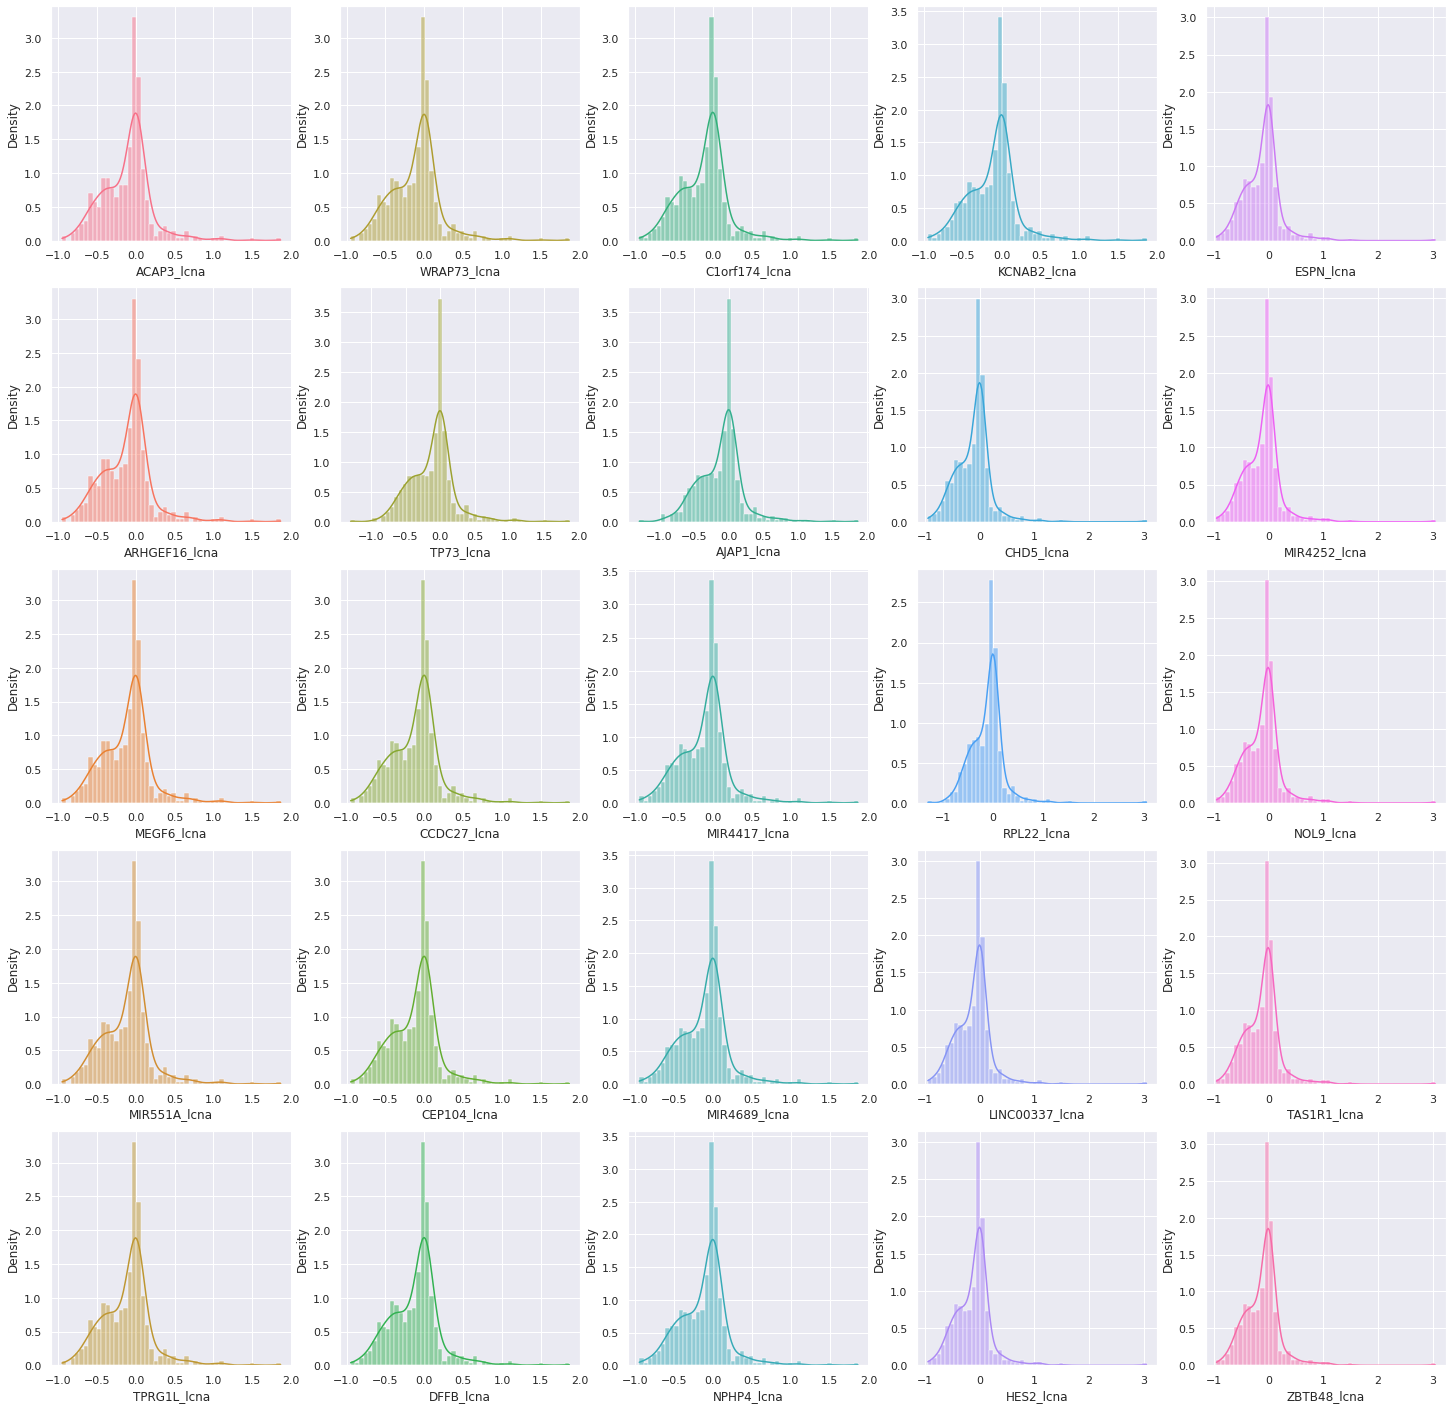

In [31]:
get_histograms_from_columns(linearCNA_t, np.random.choice(linearCNA_t.columns, 25))
pass

Finally for methylation:

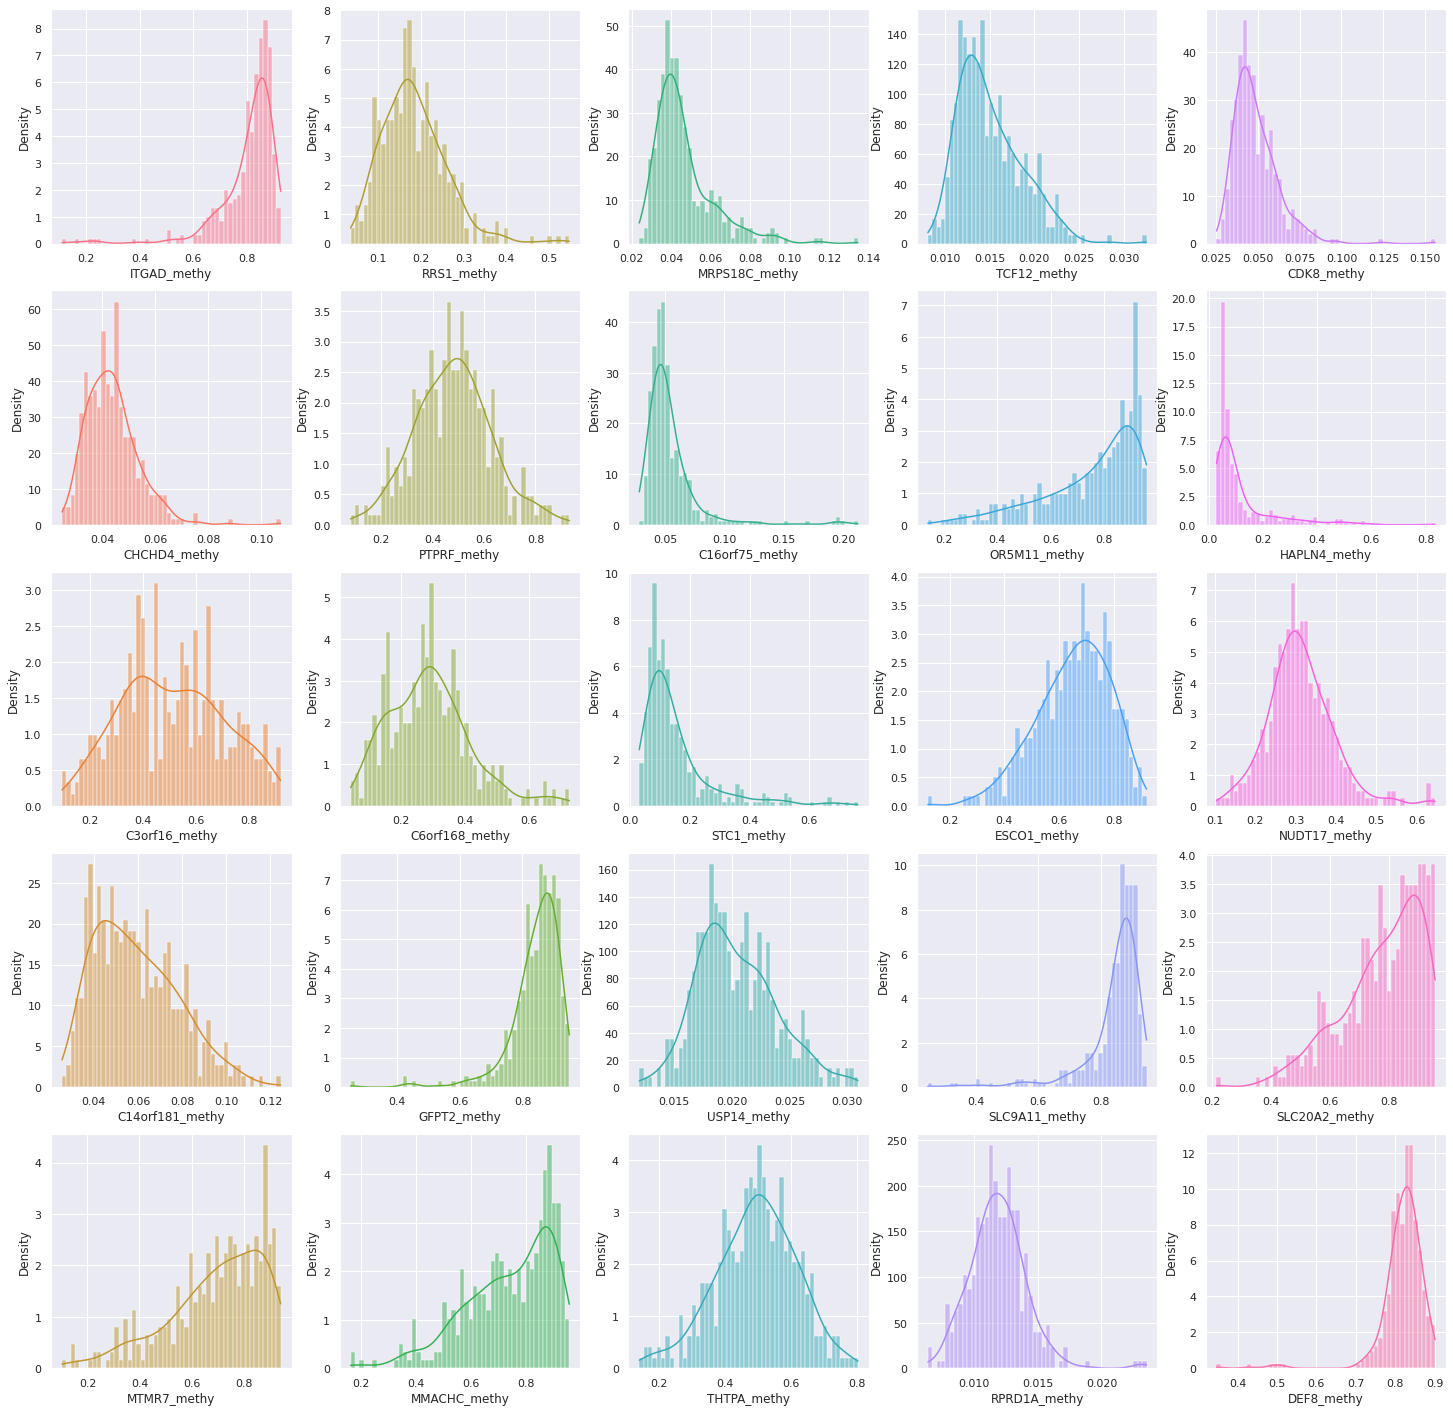

In [32]:
get_histograms_from_columns(methylation_hm450_t, methylation_hm450_t.columns[:25])
pass

In [ ]:
# This takes a long time. The result is cached below.
use_cached_duplicate_columns_for_methylation = False
if use_cached_duplicate_columns_for_methylation:
    duplicate_columns = []
else:
    duplicate_columns = get_columns_with_duplicates(methylation_hm450_t, disable_tqdm=False)
    print(duplicate_columns)

In [ ]:
len(duplicate_columns)

In [ ]:
methylation_hm450_t = methylation_hm450_t.drop(columns=duplicate_columns)

In [ ]:
get_histograms_from_columns(methylation_hm450_t, np.random.choice(methylation_hm450_t.columns, 25))
pass

Free up non-transposed dataframes

In [33]:
RNAseq = None
linearCNA = None
methylation_hm450 = None
len(RNAseq_t.columns), len(linearCNA_t.columns), len(methylation_hm450.columns)

(16827, 13818, 15854)

### miRNA data from gdc.cancer.gov

In [34]:
mirna_files_df = get_mirna_files()
mirna_files_df.describe()

,cases.0.samples.0.submitter_id,file_name,id
count,523,523,523
unique,523,523,523
top,TCGA-22-1011-01A,7df584d3-5b11-4987-8227-6d809e8305af.mirbase21...,07fa22d0-99b1-4364-9b93-d937005a2416
freq,1,1,1


In [35]:
# Either download the dataset again:
#mirna_fname = download_mirna_files(mirna_files_df, data_directory)
# Or use a previously downloaded file like:
#mirna_fname = "gdc_download_20211114_175949.738652.tar.gz"
mirna_fname = "gdc_download_20211118_203457.926713.tar.gz"

In [36]:
miRNA_df_t = untar_and_merge_mirna_files(mirna_files_df, mirna_fname, data_directory)
print("All columns:", len(miRNA_df_t.columns))
miRNA_df_t = remove_constant_columns(miRNA_df_t).dropna(axis="columns")
print("Only non-constant columns:", len(miRNA_df_t.columns))
miRNA_df_t = remove_columns_with_significant_modes(miRNA_df_t)
print("Only non-mode-dominant columns:", len(miRNA_df_t.columns))
miRNA_df = miRNA_df_t.transpose()
# Save the cleaned count dataframe in case the download stops working
miRNA_df.to_csv("./data/miRNA_clean_counts.csv", index_label="miRNA")
# Free up the non-transposed dataframe
miRNA_df = None
miRNA_df_t = miRNA_df_t.rename(lambda x: x+"_mirna", axis="columns")

All columns: 1881
Only non-constant columns: 1585
Only non-mode-dominant columns: 413


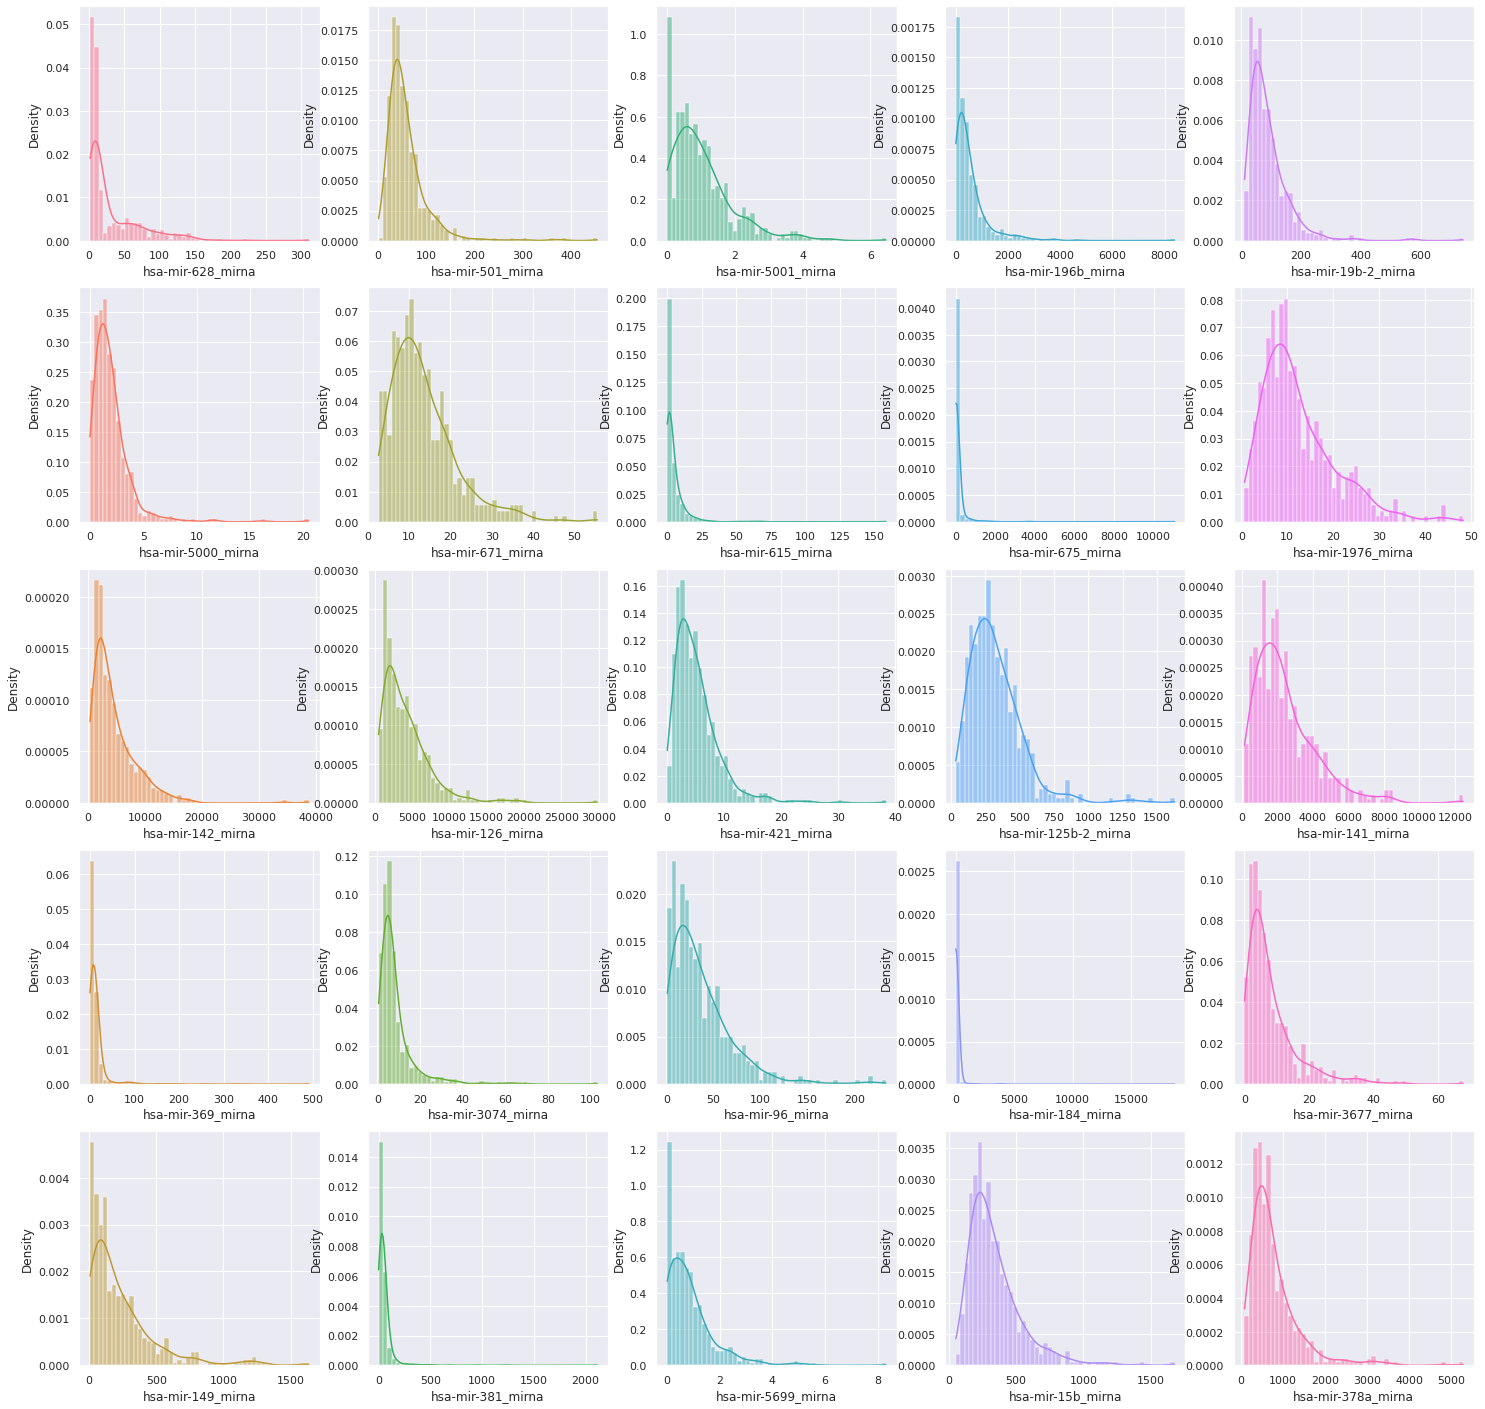

In [37]:
get_histograms_from_columns(miRNA_df_t, miRNA_df_t.columns[:25])
pass

In [38]:
#This takes about a minute. No columns were dropped and the result is cached below.
use_cached_duplicate_columns_for_mirna = True
if use_cached_duplicate_columns_for_mirna:
    duplicate_columns = []
else:
    duplicate_columns = get_columns_with_duplicates(miRNA_df_t, disable_tqdm=False)
    print(duplicate_columns)

## Reconciling data from cBioPortal and gdc.cancer.gov

Get the sets of patients that are in each and all dataframes:

In [73]:
clinical_patients = set(clinical_data.index)
RNAseq_patients = set(RNAseq_t.index)
linearCNA_patients = set(linearCNA_t.index)
methylation_hm450_patients = set(methylation_hm450_t.index)
miRNA_patients = set(miRNA_df_t.index)
all_sets = [clinical_patients, RNAseq_patients, linearCNA_patients, methylation_hm450_patients, miRNA_patients]
all_patients = functools.reduce(lambda x, y: x|y, all_sets, set())
patients_on_all_datasets = functools.reduce(lambda x, y: x&y, all_sets, all_patients)

In [74]:
list(map(len, all_sets))

[498, 501, 501, 370, 523]

In [ ]:
len(all_patients), len(patients_on_all_datasets)

Same for the columns, just to have a better idea of the final number of input features:

In [101]:
clinical_columns = set(clinical_data.columns)
RNAseq_columns = set(RNAseq_t.columns)
linearCNA_columns = set(linearCNA_t.columns)
methylation_hm450_columns = set(methylation_hm450_t.columns)
miRNA_columns = set(miRNA_df_t.columns)
all_col_sets = [clinical_columns, RNAseq_columns, linearCNA_columns,  methylation_hm450_columns, miRNA_columns]
all_columns = functools.reduce(lambda x, y: x|y, all_col_sets, set())
columns_on_all_datasets = functools.reduce(lambda x, y: x&y, all_col_sets, all_columns)

In [102]:
list(map(len, all_col_sets))

[3, 16827, 13818, 15854, 413]

In [78]:
len(all_columns), len(columns_on_all_datasets)

(31061, 0)

Check if there are no column collisions (this is avoided by appending `_{dtype}` to the columns' names.

In [79]:
[(i,j,len(all_col_sets[i]&all_col_sets[j])) for i in range(len(all_col_sets)) for j in range(i+1,len(all_col_sets))]

[(0, 1, 0), (0, 2, 0), (0, 3, 0), (1, 2, 0), (1, 3, 0), (2, 3, 0)]

Get the datasets that will be used as features and apply (log2 1+x) to the count-based datasets:

In [80]:
df_clin = clinical_data.loc[patients_on_all_datasets]
df_mrna = RNAseq_t.loc[patients_on_all_datasets].apply(lambda x: np.log2(x+1))
df_lcna = linearCNA_t.loc[patients_on_all_datasets]
df_methy = methylation_hm450_t.loc[patients_on_all_datasets]
df_mirna = miRNA_df_t.loc[patients_on_all_datasets].apply(lambda x: np.log2(x+1))
feature_dfs = [df_mrna, df_lcna, df_methy, df_mirna]

Get the input dataset:

In [81]:
df_ae = functools.reduce(lambda x,y: x.join(y), feature_dfs[1:], feature_dfs[0])
X_ae = scale(df_ae)

Plot a reduced dimensionality view of the dataset:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


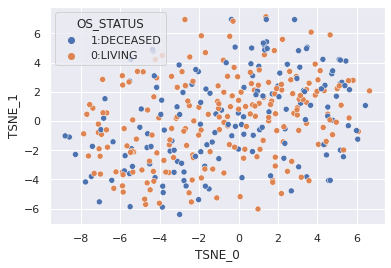

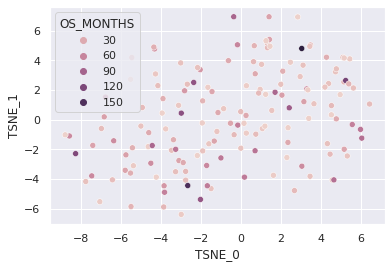

,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,-3.111981,-2.760140,TCGA-22-4601-01,1:DECEASED,34.72,True
1,-3.520011,-1.634475,TCGA-94-A5I6-01,0:LIVING,17.67,False
2,-5.901288,-3.505991,TCGA-J1-A4AH-01,0:LIVING,19.09,False
3,0.269598,2.291710,TCGA-98-8020-01,1:DECEASED,2.76,True
4,4.343513,2.080294,TCGA-43-A56U-01,0:LIVING,14.19,False
...,...,...,...,...,...,...
351,-5.139494,3.389507,TCGA-63-A5MY-01,0:LIVING,34.56,False
352,-2.705426,2.422827,TCGA-56-A4BW-01,0:LIVING,19.22,False
353,-3.908943,1.421516,TCGA-33-AASL-01,1:DECEASED,27.14,True
354,-2.190447,-2.420824,TCGA-77-7338-01,1:DECEASED,0.16,True


In [82]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X_ae), columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
plt.show()
sns.scatterplot(data=df_plot[df_plot["OS_STATUS_B"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_MONTHS")
plt.show()
df_plot

## Integrating the Data With an Autoencoder

Get the column sizes for each type of data to build a differential loss for each column:

In [83]:
column_sizes = functools.reduce(lambda x,y: x+[x[-1]+y], [len(df.columns) for df in feature_dfs], [0])
column_sizes

[0, 16827, 30645, 46499, 46912]

In [84]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

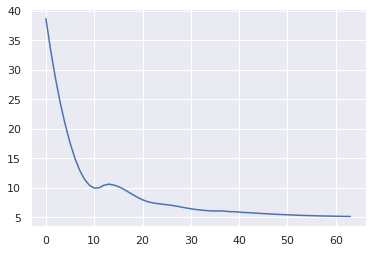

In [94]:
d_in = X_ae.shape[-1]

ae = Autoencoder(
        input_dim = d_in,
        hidden_dims = [512],
        encoding_dim = 128,
        nonlinearity = F.relu,#torch.tanh,
        final_nonlinearity = lambda x:x,#torch.tanh,
        dropout_rate = 0.3,
        bias = True)
ae.apply(init_weights)

parameter_normalizations = [(1e-3, 1)]
activation_normalizations = [(1e-4, 2)]
average_norms = True
l2_weight_decay = 0#1e-4

opt = torch.optim.Adam(ae.parameters(), lr=1e-2, weight_decay = l2_weight_decay)

tX_ae = torch.tensor(X_ae, dtype=torch.float32)

epochs = 64
losses = []
for e in range(epochs):
    act_norms = 0
    act_norms_count = 0
    param_norms = 0
    param_norms_count = 0
    
    if activation_normalizations is not None and len(activation_normalizations) > 0:
        activations = ae.layer_activations(tX_ae)
        y = activations[-1]
        for norm_weight, norm_type in activation_normalizations:
            act_norms += norm_weight * sum((torch.norm(acts, norm_type) for acts in activations))/len(activations)
            act_norms_count += 1
        act_norms /= act_norms_count if average_norms else 1
    else:
        y = ae(tX_ae)
    acc = 0
    reconstruction_losses = [F.mse_loss(y[...,s:t], tX_ae[...,s:t]) for s,t in zip(column_sizes[:-1], column_sizes[1:])]
    
    for norm_weight, norm_type in parameter_normalizations:
        param_norms += norm_weight * sum((torch.norm(params, norm_type) for params in ae.parameters()))/len(list(ae.parameters()))
        param_norms_count += 1
    param_norms /= param_norms_count if average_norms else 1
        
    loss = sum(reconstruction_losses) + param_norms + act_norms
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.detach().numpy().item())
    print("{} {}".format(e, losses[-1]), end='\x1b[1K\r')
sns.lineplot(x=list(range(len(losses))), y=losses)

ae.eval()
integrated_values = ae.encode(tX_ae).detach().numpy()

Visualise the embeddings in a lower-dimensionality projection:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


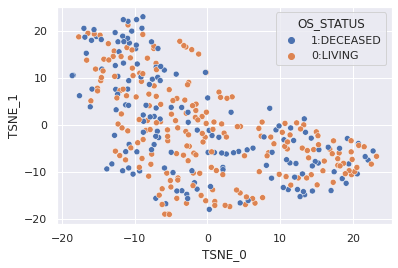

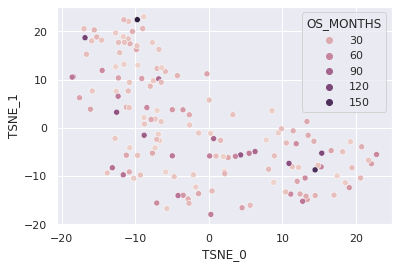

,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,13.379381,-14.860482,TCGA-22-4601-01,1:DECEASED,34.72,True
1,13.259832,0.028976,TCGA-94-A5I6-01,0:LIVING,17.67,False
2,16.848635,-5.162334,TCGA-J1-A4AH-01,0:LIVING,19.09,False
3,-6.888814,-1.333055,TCGA-98-8020-01,1:DECEASED,2.76,True
4,-12.833352,15.738594,TCGA-43-A56U-01,0:LIVING,14.19,False
...,...,...,...,...,...,...
351,4.011173,-13.843015,TCGA-63-A5MY-01,0:LIVING,34.56,False
352,0.904245,0.626484,TCGA-56-A4BW-01,0:LIVING,19.22,False
353,11.457567,-0.641065,TCGA-33-AASL-01,1:DECEASED,27.14,True
354,7.792128,-2.552197,TCGA-77-7338-01,1:DECEASED,0.16,True


In [95]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(integrated_values), columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
plt.show()
sns.scatterplot(data=df_plot[df_plot["OS_STATUS_B"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_MONTHS")
plt.show()
df_plot

### Find the Significant Factors  

In [96]:
# Set the threshold for significance
significance_threshold = 0.05

significant_factors_list = []
logRank_Pvalues_list = []

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # logRank_Pvalues is a vector that will store the log-rank p-values of each 
    # univariate Cox-PH models built
    logRank_Pvalues = list()
    # significant_factors is a vector that will store every factor for which a 
    # significant Cox-PH model was built (log-rank P < 0.05)
    significant_factor_indexes = list()
    # Iterate over all factors/features of the actual dataframe
    for i in range(integrated_values.shape[1]):
        # Create a df with 3 columns, one for factor, one for OS_MONTHS
        # and one for OS_STATUS
        factor_df = pd.DataFrame(
            {
                "OS_MONTHS": df_clin["OS_MONTHS"].values,
                "OS_STATUS": df_clin["OS_STATUS_B"].values,
                "Factor_{}".format(i): integrated_values[:,i]
            }
        )
        # Build univariate COX-PH models
        cox_ph = lifelines.fitters.coxph_fitter.CoxPHFitter().fit(factor_df, "OS_MONTHS", "OS_STATUS")
        #log_rank_p_value = cox_ph.log_likelihood_ratio_test().p_value #summary["-log2(p)"][0]
        log_rank_p_value = cox_ph.summary["p"][0]
        if (log_rank_p_value<significance_threshold):
            significant_factor_indexes.append(i)
            logRank_Pvalues.append(log_rank_p_value)

    print("")
    print(significant_factor_indexes)
    print(logRank_Pvalues)


[9, 43, 46, 79, 97, 99, 109, 120, 127]
[0.03862894432195686, 0.014222320139346798, 0.03671022301344399, 0.048974174212766466, 0.039670117855329305, 0.01838906121419908, 0.003481323320948439, 0.01632777559024377, 0.04465627865891969]


Get a dataframe with only the significant factors:

In [97]:
significant_factors = integrated_values[:,significant_factor_indexes]
significant_factors

array([[-1.148932  ,  0.24851486, -3.9748986 , ...,  2.574856  ,
        -1.1785216 , -0.24971046],
       [-0.75264096,  0.12094638, -1.8408914 , ...,  2.3810377 ,
        -2.6543093 ,  3.41215   ],
       [-3.0026581 ,  2.9662144 , -4.1204076 , ...,  0.20162523,
        -3.8205998 ,  1.8604949 ],
       ...,
       [-0.49936363,  2.1915364 , -1.7063005 , ..., -0.8877647 ,
        -1.5955912 ,  3.2012258 ],
       [ 1.4852253 ,  0.37550837,  0.15928786, ...,  1.4459443 ,
        -0.7275804 ,  1.6340263 ],
       [ 0.4896134 , -0.00929019, -0.01985535, ...,  1.6852486 ,
        -0.7476269 ,  2.346707  ]], dtype=float32)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


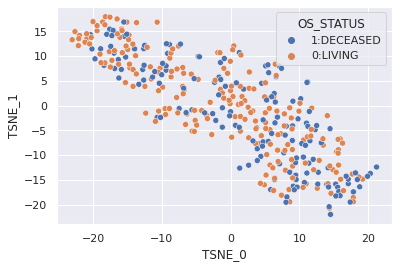

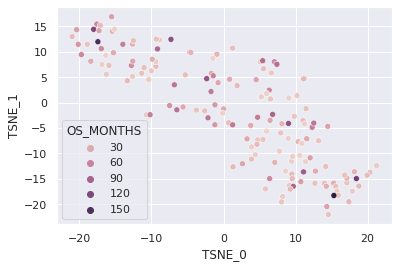

,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,4.527019,4.506098,TCGA-22-4601-01,1:DECEASED,34.72,True
1,-5.722052,6.371149,TCGA-94-A5I6-01,0:LIVING,17.67,False
2,-14.654366,7.610144,TCGA-J1-A4AH-01,0:LIVING,19.09,False
3,4.399975,-10.270923,TCGA-98-8020-01,1:DECEASED,2.76,True
4,15.421980,-9.313444,TCGA-43-A56U-01,0:LIVING,14.19,False
...,...,...,...,...,...,...
351,-10.489323,2.998707,TCGA-63-A5MY-01,0:LIVING,34.56,False
352,-0.223122,1.068103,TCGA-56-A4BW-01,0:LIVING,19.22,False
353,-9.893647,8.540095,TCGA-33-AASL-01,1:DECEASED,27.14,True
354,-0.138949,-2.073877,TCGA-77-7338-01,1:DECEASED,0.16,True


In [98]:
n_components = 2
df_plot = pd.DataFrame(
    dim_reduction(n_components).fit_transform(significant_factors),
    columns=[dim_reduction_label.format(i) for i in range(n_components)]
)    
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
plt.show()
sns.scatterplot(data=df_plot[df_plot["OS_STATUS_B"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_MONTHS")
plt.show()
df_plot

### Working Back Features from Factors

To be done, but not strictly necessary since later in the pipeline we will extract the most significant features directly using the low/high risk separation.

## Cluster Samples

In [99]:
for k in range(2,6):
    kmeans = KMeans(k)
    kmeans.fit(significant_factors)
    labels = kmeans.labels_
    silhouette = silhouette_score(factor_df, labels)
    CH_score = calinski_harabasz_score(factor_df, labels)
    print("k="+str(k))
    print("Silhouette score:", silhouette)
    print("CH score", CH_score)
    print()

k=2
Silhouette score: 0.04048486055431427
CH score 4.098929433532242

k=3
Silhouette score: -0.035108801146639994
CH score 1.5250664904888132

k=4
Silhouette score: -0.12989501547176524
CH score 1.4878092488432233

k=5
Silhouette score: -0.11664085909078362
CH score 1.5021641084115318



Two clusters seem to be consistently better than any other number, so keep 2 clusters as the default and plot the survival curves of each, doing a logrank test to see if they are significantly different.

log-rank P value: 0.03222610609071658


<AxesSubplot:xlabel='timeline'>

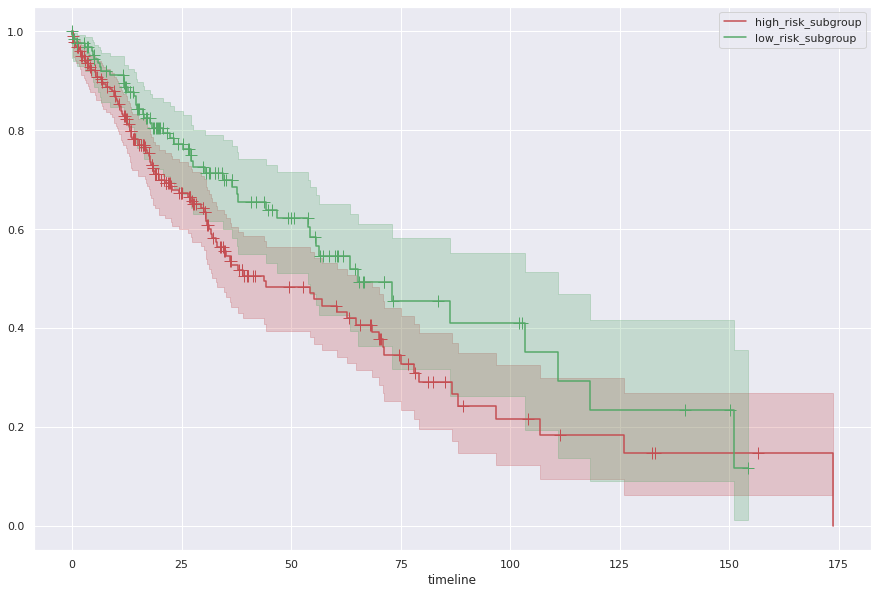

In [100]:
kmeans = KMeans(2).fit(significant_factors)
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["OS_MONTHS"], low_risk_samples["OS_MONTHS"],
                       high_risk_samples["OS_STATUS_B"], low_risk_samples["OS_STATUS_B"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
ax = plt.gca()
kmf_high.plot(show_censors=1, ci_show=1, color="r", ax=ax)
kmf_low.plot(show_censors=1, ci_show=1, color="g", ax=ax)
#lifelines.plotting.add_at_risk_counts(kmf_high, kmf_low, ax=ax)

Assign samples randomly just to see how it looks:

log-rank P value: 0.22250800495501383


<AxesSubplot:xlabel='timeline'>

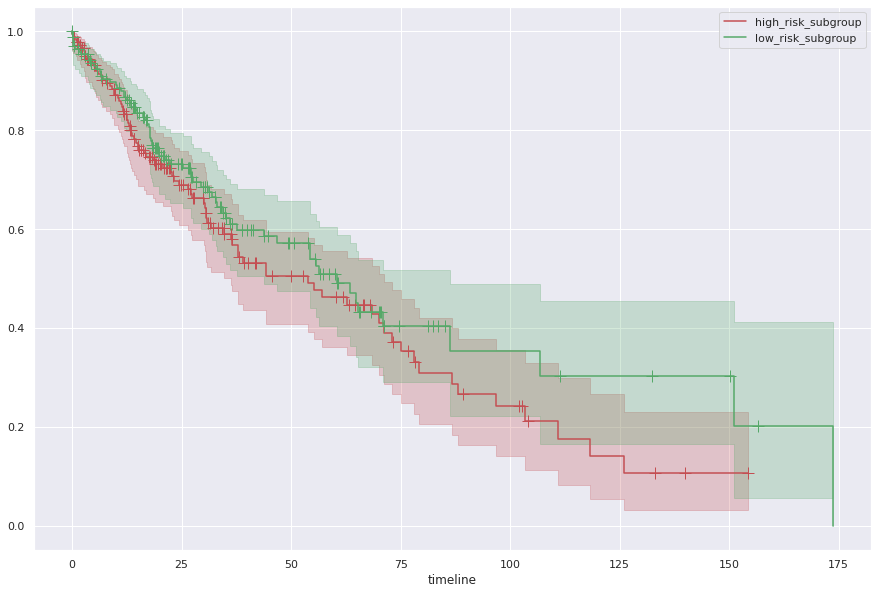

In [92]:
target_features = df_clin.copy()
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, np.random.choice([0,1], size=df_clin.shape[0]))
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["OS_MONTHS"], low_risk_samples["OS_MONTHS"],
                       high_risk_samples["OS_STATUS_B"], low_risk_samples["OS_STATUS_B"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
ax = plt.gca()
kmf_high.plot(show_censors=1, ci_show=1, color="r", ax=ax)
kmf_low.plot(show_censors=1, ci_show=1, color="g", ax=ax)
#lifelines.plotting.add_at_risk_counts(kmf_high, kmf_low, ax=ax)

Set the clusters from the kmeans algorithm as the dataset labels for training in the next parts of the pipeline:

In [93]:
target_features = df_clin.copy()
target_features["Risk_subgroup"] = kmeans.labels_
target_features

,OS_STATUS,OS_MONTHS,OS_STATUS_B,Risk_subgroup
PATIENT_ID,,,,
TCGA-22-4601-01,1:DECEASED,34.72,True,0
TCGA-94-A5I6-01,0:LIVING,17.67,False,0
TCGA-J1-A4AH-01,0:LIVING,19.09,False,1
TCGA-98-8020-01,1:DECEASED,2.76,True,0
TCGA-43-A56U-01,0:LIVING,14.19,False,0
...,...,...,...,...
TCGA-63-A5MY-01,0:LIVING,34.56,False,1
TCGA-56-A4BW-01,0:LIVING,19.22,False,0
TCGA-33-AASL-01,1:DECEASED,27.14,True,1


## Feature Selection

In [65]:
df_mrna
df_lcna
df_methy
df_mirna

,hsa-mir-628_mirna,hsa-mir-5000_mirna,hsa-mir-142_mirna,hsa-mir-369_mirna,hsa-mir-149_mirna,hsa-mir-501_mirna,hsa-mir-671_mirna,hsa-mir-126_mirna,hsa-mir-3074_mirna,hsa-mir-381_mirna,...,hsa-mir-382_mirna,hsa-let-7f-2_mirna,hsa-mir-29c_mirna,hsa-mir-655_mirna,hsa-mir-4521_mirna,hsa-mir-6892_mirna,hsa-mir-505_mirna,hsa-mir-92a-2_mirna,hsa-mir-1247_mirna,hsa-mir-99a_mirna
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-22-4601-01,7.522822,0.000000,11.454265,1.094952,7.938127,6.203746,4.079365,12.153743,3.754531,2.140183,...,2.140183,11.396463,11.041150,1.094952,1.710226,1.094952,6.521755,11.797774,3.627677,8.009826
TCGA-94-A5I6-01,2.591784,1.490692,10.212502,3.440386,8.793452,6.025978,4.161529,10.180352,2.269516,5.193824,...,4.209372,12.170446,9.545389,2.076628,0.851639,1.267813,5.604948,12.066036,0.851639,5.794630
TCGA-J1-A4AH-01,3.495676,1.820778,11.128465,2.945655,6.655622,6.288606,4.389826,10.671829,2.564732,5.217346,...,3.514607,12.158174,12.417215,1.030607,0.376254,0.533015,6.159249,13.107817,4.017593,6.386911
TCGA-98-8020-01,3.656552,1.210634,11.516101,3.287270,6.735924,6.002048,4.049079,11.423635,2.920669,5.547966,...,4.954755,10.625532,9.949807,1.341109,0.000000,2.645604,5.851450,13.792175,6.863538,7.357419
TCGA-43-A56U-01,4.197759,1.569296,12.499668,2.962949,6.027138,5.491939,3.849544,11.553744,2.194545,4.621242,...,3.794814,12.445041,12.628287,0.921713,0.921713,0.441213,5.136055,12.374334,4.454709,8.075990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-63-A5MY-01,2.568638,0.990227,10.563954,2.154694,7.613482,7.125186,4.025978,11.366527,4.504808,3.070172,...,1.985316,11.189849,9.260030,0.578455,0.000000,1.793374,6.390011,13.577336,0.578455,6.952089
TCGA-56-A4BW-01,2.275162,1.546097,10.559069,3.443026,6.743662,4.758126,2.922911,9.817663,2.501691,5.678102,...,4.079867,10.930320,10.188091,1.675628,0.631007,0.631007,5.280086,12.564964,5.738651,6.956184
TCGA-33-AASL-01,2.613772,1.150098,11.694275,3.342651,8.571074,4.817120,3.393754,10.724438,1.729727,5.630165,...,3.885377,12.518678,10.872431,1.729727,0.165981,1.068575,4.829546,12.152401,2.060101,7.008782


In [66]:
SelectKBest, f_classif

(sklearn.feature_selection._univariate_selection.SelectKBest,
 <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>)

## Training a Model for prediction survival

## External dataset validation

## Discussion

## Next steps

Voting scheme
FPKM/TPM
Bioconductor workshops